In [1]:
!nvidia-smi

Thu Apr 11 19:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gener...    On | 00000000:01:00.0 Off |                  Off |
| 30%   27C    P8               27W / 300W|      1MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from src.segmentation.framework_handlers import yolo_handler
yolo_handler.validate_version_and_gpu()

Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
Setup complete ✅ (64 CPUs, 503.6 GB RAM, 12.9/799.6 GB disk)


### Prepare Dataset
In this section, the dataset along with YOLO annotations is processed to conform to the input structure required by YOLO. The YOLO format necessitates organizing the dataset into two main directories, `images` and `labels`. Each of these directories is further divided into two subdirectories, `train` and `val`, for training and validation datasets respectively. This structure facilitates YOLO's training and validation processes.

In [3]:
from src.annotation_handling import annotation_handler

In [ ]:
# prepare data to fine tune yolo v8
annotations_folder_name = "etaylor_cannabis_patches_test"
dataset_version = "v0.1"
saving_yaml_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO"
yaml_file_path = annotation_handler.convert_coco_to_yolo_format(annotations_folder_name, dataset_version, saving_yaml_path, train_percentage=0.8)

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/export_coco-instance_etaylor_cannabis_patches_test_v0.1.json:  53%|█████▎    | 47/89 [00:00<00:00, 465.70it/s]

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/export_coco-instance_etaylor_cannabis_patches_test_v0.1.json: 100%|██████████| 89/89 [00:00<00:00, 479.47it/s]

COCO data converted successfully.
Results saved to /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo


The folder /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo has been deleted.


### Ultralytics Settings

In here we can modify the settings of the yolo runs. 

In [4]:
from ultralytics import settings

runs_dir = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs"
# Update a setting
settings.update({'runs_dir': runs_dir})

# View all settings
print(settings)

{'settings_version': '0.0.4', 'datasets_dir': '/sise/home/etaylor/datasets', 'weights_dir': '/home/etaylor/weights', 'runs_dir': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs', 'uuid': '3eabad9ed9f85e3e726c43f30dfeac36b9c8e6cecf6546d5abc3435b89c57f67', 'sync': True, 'api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


In [5]:
# in case dataset already converted from coco to yolo format use manual path
yaml_file_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml"

### Find best Hyper params with [Ray Tune](https://docs.ultralytics.com/integrations/ray-tune/#custom-search-space-example)

In the provided code snippet, Ray Tune is utilized for hyperparameter tuning of a YOLOv8n segmentation model using a specific model checkpoint and dataset defined in a YAML file.

In [6]:
from ultralytics import YOLO

model_checkpoint_path = 'yolov8x.pt'
model = YOLO(model_checkpoint_path) # pass any model type

# Start tuning hyperparameters for YOLOv8n training on the COCO8 dataset
result_grid = model.tune(data=yaml_file_path, use_ray=True, gpu_per_trial=6, imgsz=512)

(_tune pid=14411) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=14411) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train51, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 176k/6.23M [00:00<00:03, 1.78MB/s]
 16%|█▌        | 1.00M/6.23M [00:00<00:00, 5.80MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 20.1MB/s]


(_tune pid=14411) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=14411) Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train51/labels.jpg... 
(_tune pid=14411) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.09954484582803802' and 'momentum=0.7521418121958573' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=14411) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.000222889260606555), 103 bias(decay=0.0)
(_tune pid=14411) 100 epochs...
(_tune pid=14411) 
(_tune pid=14411)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      8.11G    0.02525      29.98      1.564        118        512:   4%|▍         | 1/23 [00:02<00:47,  2.15s/it]
      1/100      8.11G    0.02599      31.61      1.636         39        512:   9%|▊         | 2/23 [00:02<00:26,  1.26s/it]
      1/100      8.11G    0.02695      31.61      1.714         62        512:  13%|█▎        | 3/23 [00:03<00:16,  1.19it/s]
      1/100      8.11G     0.0278      32.24      1.748         30        512:  17%|█▋        | 4/23 [00:03<00:12,  1.51it/s]
      1/100      8.11G    0.02773      31.81      1.783        104        512:  22%|██▏       | 5/23 [00:03<00:08,  2.08it/s]
      1/100      8.11G    0.02775      31.33      1.797        140        512:  26%|██▌       | 6/23 [00:03<00:06,  2.67it/s]
      1/100      8.11G     0.0277      31.29      1.803         71        512:  30%|███       | 7/23 [00:03<00:04,  3.33it/s]
      1/100      8.11G    0.02777      30.96      1.816         99        512: 

(_tune pid=14411)                    all         91        719     0.0267      0.213     0.0181    0.00454


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


(_tune pid=14411) 
(_tune pid=14411)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100       8.7G    0.02243      15.46      1.572         76        512:   4%|▍         | 1/23 [00:00<00:04,  4.82it/s]
      2/100      8.73G     0.0236      15.89        1.6         62        512:   9%|▊         | 2/23 [00:00<00:03,  5.60it/s]
      2/100      8.73G    0.02265      14.76      1.573        101        512:  13%|█▎        | 3/23 [00:00<00:03,  6.37it/s]
      2/100      8.73G    0.02433      14.21       1.63        100        512:  17%|█▋        | 4/23 [00:00<00:02,  6.41it/s]
      2/100      8.73G    0.02438      31.03      1.659         24        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
      2/100      8.73G    0.02431      31.73       1.64         66        512:  26%|██▌       | 6/23 [00:00<00:02,  6.73it/s]
      2/100      8.73G    0.02451      45.03      1.687         20        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
      2/100      8.73G    0.02435      42.43      1.654         94        512: 

(_tune pid=14411)                    all         91        719      0.145      0.113     0.0982      0.036


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


(_tune pid=23258) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=23258) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 184k/6.23M [00:00<00:03, 1.87MB/s]
 16%|█▌        | 0.98M/6.23M [00:00<00:00, 5.67MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.8MB/s]


(_tune pid=23258) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=23258) Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train/labels.jpg... 
(_tune pid=23258) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.048974980552880354' and 'momentum=0.7994656394808668' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=23258) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0008154970005870602), 103 bias(decay=0.0)
(_tune pid=23258) 100 epochs...
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      8.11G    0.01943      3.777      1.448        361        512:   4%|▍         | 1/23 [00:00<00:14,  1.49it/s]
      1/100      8.11G    0.02027      3.792      1.544        308        512:   9%|▊         | 2/23 [00:01<00:20,  1.03it/s]
      1/100      8.11G    0.02056      3.856      1.566        101        512:  13%|█▎        | 3/23 [00:03<00:21,  1.05s/it]
      1/100      8.11G    0.02051      3.846      1.548        165        512:  17%|█▋        | 4/23 [00:03<00:15,  1.19it/s]
      1/100      8.11G    0.02027      3.821      1.522        300        512:  22%|██▏       | 5/23 [00:03<00:10,  1.69it/s]
      1/100      8.17G    0.02048      3.831       1.54        252        512:  26%|██▌       | 6/23 [00:03<00:07,  2.15it/s]
      1/100      8.17G    0.01993      3.635      1.505        276        512:  30%|███       | 7/23 [00:04<00:05,  2.76it/s]
      1/100      8.42G    0.01953      3.581      1.487        222        512: 

(_tune pid=23258)                    all         91        719     0.0773      0.527      0.075     0.0477


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100       8.7G    0.01408      1.764       1.16        276        512:   4%|▍         | 1/23 [00:00<00:04,  4.67it/s]
      2/100      8.73G    0.01408      1.695      1.193        197        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
      2/100      8.73G     0.0148      1.764      1.247        216        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
      2/100      8.73G     0.0147      1.736      1.233        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.42it/s]
      2/100      8.73G    0.01486      1.671      1.198        201        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
      2/100      8.73G    0.01487      1.619      1.193        250        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
      2/100      8.73G    0.01488      1.603      1.194        230        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
      2/100      8.73G    0.01481      1.587      1.197        231        512: 

(_tune pid=23258)                    all         91        719    0.00102     0.0308   0.000532   0.000369


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      8.71G    0.01502      1.781      1.152        197        512:   4%|▍         | 1/23 [00:00<00:04,  4.40it/s]
      3/100      8.71G     0.0152      1.731      1.224        145        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
      3/100      8.72G    0.01565      1.683      1.237        209        512:  13%|█▎        | 3/23 [00:00<00:03,  6.02it/s]
      3/100      8.72G    0.01542      1.621      1.224        255        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
      3/100      8.72G    0.01543      1.589      1.225        259        512:  22%|██▏       | 5/23 [00:00<00:02,  6.52it/s]
      3/100      8.72G    0.01533       1.56      1.216        194        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
      3/100      8.72G     0.0153       1.54       1.21        265        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
      3/100      8.72G    0.01543      1.522      1.213        244        512: 

(_tune pid=23258)                    all         91        719   0.000128    0.00366   6.58e-05   2.22e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      8.71G    0.01559      1.287      1.271        161        512:   4%|▍         | 1/23 [00:00<00:04,  5.46it/s]
      4/100      8.73G    0.01636      1.344      1.283        228        512:   9%|▊         | 2/23 [00:00<00:03,  6.60it/s]
      4/100      8.73G    0.01631      1.297      1.263        261        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
      4/100      8.73G    0.01627      1.311      1.261        229        512:  17%|█▋        | 4/23 [00:00<00:02,  7.01it/s]
      4/100      8.73G    0.01609      1.302      1.242        214        512:  22%|██▏       | 5/23 [00:00<00:02,  7.27it/s]
      4/100      8.73G    0.01597      1.314      1.225        243        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
      4/100      8.73G    0.01625       1.34       1.24        183        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
      4/100      8.73G     0.0163      1.342       1.25        321        512: 

(_tune pid=23258)                    all         91        719    0.00185    0.00147   0.000944   0.000481
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      8.71G    0.01519      1.315      1.252        306        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
      5/100      8.73G    0.01578      1.378      1.276        317        512:   9%|▊         | 2/23 [00:00<00:03,  6.27it/s]
      5/100      8.73G    0.01592      1.392      1.277        324        512:  13%|█▎        | 3/23 [00:00<00:02,  6.81it/s]
      5/100      8.73G     0.0164       1.38      1.283        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
      5/100      8.73G    0.01625      1.389      1.274        196        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
      5/100      8.73G    0.01636      1.384       1.29        159        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
      5/100      8.73G     0.0161       1.36      1.269        333        512:  30%|███       | 7/23 [00:01<00:02,  7.41it/s]
      5/100      8.73G    0.01599       1.35      1.261        247        512: 

(_tune pid=23258)                    all         91        719     0.0584      0.441     0.0459      0.029
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100      8.74G    0.01392      1.058      1.158        254        512:   4%|▍         | 1/23 [00:00<00:05,  4.05it/s]
      6/100      8.74G    0.01515      1.304      1.204        165        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
      6/100      8.75G    0.01508      1.293      1.198        224        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
      6/100      8.75G    0.01505      1.289      1.204        255        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
      6/100      8.75G    0.01484      1.259      1.198        242        512:  22%|██▏       | 5/23 [00:00<00:02,  6.54it/s]
      6/100      8.75G    0.01475      1.268      1.213        162        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
      6/100      8.75G    0.01493      1.254      1.211        240        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
      6/100      8.75G    0.01517      1.243      1.195        201        512: 

(_tune pid=23258)                    all         91        719     0.0859      0.305     0.0726     0.0441
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      8.74G    0.01645      1.282      1.274        238        512:   4%|▍         | 1/23 [00:00<00:03,  5.73it/s]
      7/100      8.76G    0.01671      1.405      1.247        140        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
      7/100      8.76G    0.01705      1.368      1.245        226        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
      7/100      8.76G    0.01684      1.355      1.227        327        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
      7/100      8.76G    0.01686      1.346      1.226        136        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
      7/100      8.76G    0.01683      1.341      1.221        289        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
      7/100      8.76G    0.01672      1.349       1.23        165        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
      7/100      8.76G    0.01661      1.346      1.226        263        512: 

(_tune pid=23258)                    all         91        719      0.267      0.241      0.131     0.0722
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100       8.7G    0.01526      1.165      1.126        223        512:   4%|▍         | 1/23 [00:00<00:04,  4.77it/s]
      8/100      8.72G    0.01585      1.223      1.207        268        512:   9%|▊         | 2/23 [00:00<00:03,  5.57it/s]
      8/100      8.72G    0.01561      1.258      1.217        306        512:  13%|█▎        | 3/23 [00:00<00:03,  5.88it/s]
      8/100      8.72G    0.01545      1.256      1.209        237        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
      8/100      8.72G    0.01529      1.244      1.196        247        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
      8/100      8.72G    0.01528      1.257      1.194        237        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
      8/100      8.72G    0.01529      1.259      1.203        224        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
      8/100      8.72G    0.01544      1.244      1.199        307        512: 

(_tune pid=23258)                    all         91        719     0.0209      0.163    0.00728    0.00444


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100       8.7G    0.01653      1.292       1.27        266        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
      9/100      8.72G    0.01585      1.275      1.218        202        512:   9%|▊         | 2/23 [00:00<00:03,  5.82it/s]
      9/100      8.72G    0.01607      1.282       1.18        236        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
      9/100      8.72G    0.01538      1.239      1.159        208        512:  17%|█▋        | 4/23 [00:00<00:03,  6.30it/s]
      9/100      8.72G    0.01514      1.236       1.17        163        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
      9/100      8.72G    0.01512      1.261      1.182        151        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
      9/100      8.72G    0.01486      1.267      1.167        147        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
      9/100      8.72G    0.01479      1.265      1.167        347        512: 

(_tune pid=23258)                    all         91        719    0.00202     0.0779    0.00105    0.00042


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      8.74G    0.01481      1.222      1.164        232        512:   4%|▍         | 1/23 [00:00<00:04,  4.41it/s]
     10/100      8.74G    0.01476      1.261      1.131        255        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     10/100      8.75G    0.01507      1.245      1.149        254        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     10/100      8.75G    0.01521      1.257      1.164        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     10/100      8.75G    0.01537      1.258      1.167        226        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     10/100      8.75G    0.01564      1.271      1.182        184        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     10/100      8.75G    0.01542      1.323      1.183         78        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     10/100      8.75G    0.01553      1.311        1.2        223        512: 

(_tune pid=23258)                    all         91        719      0.483      0.198      0.216      0.123
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      8.74G    0.01465      1.153      1.137        262        512:   4%|▍         | 1/23 [00:00<00:03,  5.89it/s]
     11/100      8.75G    0.01506      1.173      1.184        230        512:   9%|▊         | 2/23 [00:00<00:03,  5.91it/s]
     11/100      8.75G    0.01538      1.218      1.189        188        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     11/100      8.75G    0.01574      1.238      1.213        254        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     11/100      8.75G    0.01549      1.206      1.207        226        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     11/100      8.75G    0.01542       1.21      1.209        231        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     11/100      8.75G     0.0155      1.221        1.2        235        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     11/100      8.75G    0.01539      1.216      1.194        190        512: 

(_tune pid=23258)                    all         91        719      0.322      0.357       0.28      0.165
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100       8.7G    0.01417      1.104      1.133        204        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     12/100      8.72G    0.01503      1.152      1.142        404        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
     12/100      8.72G    0.01505       1.15      1.134        221        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
     12/100      8.72G    0.01514       1.14      1.193        150        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     12/100      8.72G    0.01514      1.155      1.185        369        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     12/100      8.72G    0.01501      1.155      1.188        331        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     12/100      8.72G    0.01505      1.147       1.19        215        512:  30%|███       | 7/23 [00:01<00:02,  6.52it/s]
     12/100      8.72G     0.0151      1.159      1.189        215        512: 

(_tune pid=23258)                    all         91        719       0.48      0.325      0.359      0.207
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100       8.7G    0.01324     0.9836      1.107        299        512:   4%|▍         | 1/23 [00:00<00:04,  4.92it/s]
     13/100      8.72G    0.01376      1.089      1.146        229        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     13/100      8.72G    0.01414      1.067      1.139        235        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     13/100      8.72G    0.01435      1.125      1.144        183        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     13/100      8.72G    0.01468       1.12      1.157        303        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     13/100      8.72G    0.01478      1.124      1.168        225        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     13/100      8.73G    0.01472      1.118       1.16        336        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     13/100      8.73G    0.01481       1.12      1.151        233        512: 

(_tune pid=23258)                    all         91        719        0.5      0.342      0.319      0.193


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100      8.76G    0.01566      1.109       1.18        244        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     14/100      8.76G    0.01526      1.223      1.158        132        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     14/100      8.76G    0.01492      1.254      1.135        178        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     14/100      8.76G      0.015       1.25      1.157        307        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
     14/100      8.76G    0.01489      1.221      1.149        343        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     14/100      8.76G    0.01514      1.233      1.162        300        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     14/100      8.76G    0.01518      1.207      1.162        177        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     14/100      8.76G    0.01497      1.194      1.169        234        512: 

(_tune pid=23258)                    all         91        719      0.413      0.276      0.282      0.167


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      8.99G    0.01335      1.094      1.179        183        512:   4%|▍         | 1/23 [00:00<00:04,  5.04it/s]
     15/100      9.01G    0.01444      1.055      1.149        262        512:   9%|▊         | 2/23 [00:00<00:03,  5.45it/s]
     15/100      9.01G    0.01521      1.081      1.161        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     15/100      9.01G     0.0152      1.106      1.167        263        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     15/100      9.01G    0.01525      1.127      1.169        285        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     15/100      9.01G    0.01517      1.111      1.161        210        512:  26%|██▌       | 6/23 [00:00<00:02,  6.71it/s]
     15/100      9.01G    0.01522      1.134      1.171        243        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     15/100      9.01G    0.01519      1.126       1.16        359        512: 

(_tune pid=23258)                    all         91        719      0.303      0.527      0.342      0.214


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100       8.7G    0.01362      1.086      1.159        203        512:   4%|▍         | 1/23 [00:00<00:04,  5.28it/s]
     16/100      8.72G     0.0139      1.117      1.168        314        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     16/100      8.72G    0.01373      1.112      1.173        206        512:  13%|█▎        | 3/23 [00:00<00:03,  6.20it/s]
     16/100      8.72G    0.01406      1.094      1.167        209        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     16/100      8.72G    0.01446      1.107       1.16        356        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     16/100      8.72G    0.01443      1.104      1.166        244        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     16/100      8.72G    0.01438      1.095      1.166        267        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     16/100      8.72G    0.01428      1.098      1.159        259        512: 

(_tune pid=23258)                    all         91        719      0.319      0.561      0.323      0.183


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      8.71G    0.01452      1.136      1.077        280        512:   4%|▍         | 1/23 [00:00<00:04,  4.94it/s]
     17/100      8.72G    0.01517      1.225      1.147        279        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
     17/100      8.73G    0.01492        1.2      1.139        348        512:  13%|█▎        | 3/23 [00:00<00:02,  6.75it/s]
     17/100      8.73G    0.01508      1.213      1.144        174        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     17/100      8.73G    0.01509      1.227      1.173        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     17/100      8.73G    0.01486      1.203      1.176        295        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     17/100      8.73G    0.01464      1.178      1.179        243        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     17/100      8.73G    0.01466      1.178      1.175        213        512: 

(_tune pid=23258)                    all         91        719      0.436      0.702      0.517      0.305
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100      8.74G    0.01434      1.095      1.077        231        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     18/100      8.74G    0.01446       1.11      1.096        170        512:   9%|▊         | 2/23 [00:00<00:03,  6.39it/s]
     18/100      8.74G    0.01441      1.109      1.137        208        512:  13%|█▎        | 3/23 [00:00<00:02,  6.97it/s]
     18/100      8.74G    0.01445      1.096      1.146        214        512:  17%|█▋        | 4/23 [00:00<00:02,  7.24it/s]
     18/100      8.74G    0.01444      1.101      1.157        245        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     18/100      8.74G    0.01437      1.093      1.141        257        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     18/100      8.74G    0.01453      1.113      1.163        250        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     18/100      8.74G    0.01449      1.103      1.153        241        512: 

(_tune pid=23258)                    all         91        719      0.535      0.469      0.428      0.258
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      8.75G    0.01407       1.02       1.18        199        512:   4%|▍         | 1/23 [00:00<00:04,  4.49it/s]
     19/100      8.76G    0.01447      1.126       1.18        423        512:   9%|▊         | 2/23 [00:00<00:04,  5.15it/s]
     19/100      8.76G    0.01403      1.101      1.164        173        512:  13%|█▎        | 3/23 [00:00<00:03,  6.16it/s]
     19/100      8.76G    0.01396      1.066      1.153        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     19/100      8.76G    0.01383      1.068      1.144        229        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     19/100      8.76G    0.01386      1.107      1.155        119        512:  26%|██▌       | 6/23 [00:00<00:02,  6.54it/s]
     19/100      8.76G    0.01401      1.113      1.152        221        512:  30%|███       | 7/23 [00:01<00:02,  6.87it/s]
     19/100      8.76G    0.01425       1.12      1.152        278        512: 

(_tune pid=23258)                    all         91        719      0.574      0.566      0.501      0.317
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      8.69G    0.01384      1.126      1.109        252        512:   4%|▍         | 1/23 [00:00<00:04,  4.93it/s]
     20/100      8.71G    0.01411      1.185      1.128        188        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     20/100      8.71G    0.01414      1.151      1.117        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.06it/s]
     20/100      8.71G    0.01427      1.131      1.118        348        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     20/100      8.71G    0.01424      1.131      1.133        220        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     20/100      8.71G    0.01424      1.139      1.145        232        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     20/100      8.71G     0.0142      1.131      1.142        253        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     20/100      8.71G     0.0142      1.142      1.146        191        512: 

(_tune pid=23258)                    all         91        719      0.561      0.517      0.512      0.322
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100       8.7G    0.01271      1.066      1.102        184        512:   4%|▍         | 1/23 [00:00<00:04,  4.76it/s]
     21/100      8.72G    0.01348      1.013      1.128        276        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     21/100      8.72G    0.01359      1.015      1.119        226        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     21/100      8.72G    0.01359      1.015      1.119        226        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     21/100      8.72G    0.01347      1.048      1.126        163        512:  17%|█▋        | 4/23 [00:00<00:02,  6.61it/s]
     21/100      8.72G    0.01368      1.042      1.142        202        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     21/100      8.72G    0.01379      1.048      1.155        242        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     21/100      8.72G    0.01382      1.038      1.155        270        512: 

(_tune pid=23258)                    all         91        719       0.57      0.672      0.549      0.348


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      8.74G    0.01365      1.014       1.07        241        512:   4%|▍         | 1/23 [00:00<00:05,  4.01it/s]
     22/100      8.74G    0.01439      1.266      1.113        113        512:   9%|▊         | 2/23 [00:00<00:03,  5.63it/s]
     22/100      8.74G    0.01435      1.198      1.108        277        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     22/100      8.75G    0.01448      1.182      1.123        356        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     22/100      8.75G    0.01434       1.14      1.113        272        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     22/100      8.75G    0.01425      1.135      1.126        224        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     22/100      8.75G    0.01434      1.127      1.123        343        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     22/100      8.75G    0.01439      1.119      1.129        236        512: 

(_tune pid=23258)                    all         91        719      0.475      0.571      0.469      0.288


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      8.76G     0.0141      1.067      1.136        277        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     23/100      8.78G    0.01375      1.096       1.13        313        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     23/100      8.78G    0.01362      1.087      1.125        192        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     23/100      8.78G    0.01332      1.105      1.123        196        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     23/100      8.78G    0.01334       1.11      1.128        162        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     23/100      8.78G    0.01363      1.113      1.132        285        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     23/100      8.78G    0.01372      1.116      1.121        276        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     23/100      8.78G    0.01374      1.123      1.124        245        512: 

(_tune pid=23258)                    all         91        719      0.583      0.603      0.578      0.357


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      8.82G    0.01384      1.084      1.067        309        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     24/100      8.83G     0.0133      1.031       1.06        201        512:   9%|▊         | 2/23 [00:00<00:03,  6.22it/s]
     24/100      8.84G     0.0137       1.03      1.086        248        512:  13%|█▎        | 3/23 [00:00<00:03,  6.23it/s]
     24/100      8.84G    0.01385      1.016      1.103        285        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     24/100      8.84G    0.01387      1.022      1.128        280        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     24/100      8.84G     0.0139      1.046      1.127        202        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     24/100      8.84G    0.01376      1.032      1.127        290        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     24/100      8.84G    0.01365      1.062      1.128        133        512: 

(_tune pid=23258)                    all         91        719      0.539      0.676      0.574      0.357


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100       8.7G    0.01449      1.163      1.253        148        512:   4%|▍         | 1/23 [00:00<00:04,  5.01it/s]
     25/100      8.72G    0.01383      1.134      1.219        271        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     25/100      8.72G    0.01305      1.072      1.168        172        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     25/100      8.72G    0.01327      1.077      1.172        275        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     25/100      8.72G    0.01339      1.068      1.163        298        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     25/100      8.72G    0.01323      1.063      1.162        155        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     25/100      8.72G    0.01333      1.073      1.171        132        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     25/100      8.72G    0.01336      1.077      1.161        229        512: 

(_tune pid=23258)                    all         91        719      0.542      0.644      0.595      0.361


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.55it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      8.73G    0.01354      1.062      1.124        278        512:   4%|▍         | 1/23 [00:00<00:05,  3.84it/s]
     26/100      8.73G    0.01359      1.011      1.121        203        512:   9%|▊         | 2/23 [00:00<00:03,  5.48it/s]
     26/100      8.73G    0.01389      1.034      1.133        253        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     26/100      8.73G    0.01385      1.018      1.124        261        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     26/100      8.73G    0.01389      1.049      1.114        171        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     26/100      8.73G    0.01405      1.076      1.125        225        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     26/100      8.73G    0.01426      1.103       1.14        176        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     26/100      8.73G    0.01449      1.121      1.145        261        512: 

(_tune pid=23258)                    all         91        719      0.535      0.574      0.511      0.313
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      8.76G    0.01483      1.256      1.167        107        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     27/100      8.77G    0.01378      1.142       1.15        224        512:   9%|▊         | 2/23 [00:00<00:03,  5.48it/s]
     27/100      8.77G    0.01355      1.119       1.13        237        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     27/100      8.77G    0.01368      1.119      1.128        152        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     27/100      8.78G    0.01368      1.106      1.128        320        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     27/100      8.78G    0.01376      1.098      1.123        182        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     27/100      8.78G    0.01397      1.096      1.129        225        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     27/100      8.78G    0.01409      1.115      1.139        458        512: 

(_tune pid=23258)                    all         91        719      0.513      0.656      0.535      0.333
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100       8.7G    0.01325       1.05      1.186        294        512:   4%|▍         | 1/23 [00:00<00:04,  5.31it/s]
     28/100      8.72G    0.01357     0.9964      1.105        244        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     28/100      8.72G     0.0135      1.027      1.118        242        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     28/100      8.72G    0.01329      1.016      1.118        251        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     28/100      8.72G    0.01312      1.004      1.101        164        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     28/100      8.72G    0.01333      1.008      1.107        255        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     28/100      8.72G     0.0133     0.9936      1.099        325        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     28/100      8.72G    0.01345       1.01      1.115        290        512: 

(_tune pid=23258)                    all         91        719      0.583      0.602      0.573      0.368


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      8.71G    0.01541       1.21      1.295        240        512:   4%|▍         | 1/23 [00:00<00:04,  4.93it/s]
     29/100      8.73G    0.01445      1.129      1.247        349        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     29/100      8.73G    0.01438      1.101      1.221        296        512:  13%|█▎        | 3/23 [00:00<00:02,  6.78it/s]
     29/100      8.73G    0.01468      1.096      1.227        131        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     29/100      8.73G    0.01463       1.09      1.204        248        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     29/100      8.73G    0.01435      1.057      1.187        265        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     29/100      8.73G    0.01433      1.061      1.179        320        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     29/100      8.73G    0.01435      1.053      1.182        303        512: 

(_tune pid=23258)                    all         91        719      0.507      0.606      0.537      0.342
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100      8.75G    0.01317      1.023      1.137        252        512:   4%|▍         | 1/23 [00:00<00:05,  3.91it/s]
     30/100      8.75G    0.01271      1.003      1.122        191        512:   9%|▊         | 2/23 [00:00<00:03,  5.35it/s]
     30/100      8.75G    0.01352      1.073      1.165        298        512:  13%|█▎        | 3/23 [00:00<00:03,  6.10it/s]
     30/100      8.75G    0.01366      1.062      1.164        251        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     30/100      8.75G    0.01366      1.059      1.159        288        512:  22%|██▏       | 5/23 [00:00<00:02,  6.21it/s]
     30/100      8.75G     0.0136      1.053      1.156        290        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     30/100      8.76G    0.01378      1.062      1.156        331        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     30/100      8.76G    0.01374      1.061      1.154        190        512: 

(_tune pid=23258)                    all         91        719      0.571      0.542      0.568      0.354


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      8.85G    0.01314      1.044       1.05        275        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     31/100      8.87G    0.01296     0.9727      1.086        220        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     31/100      8.87G    0.01291     0.9561      1.104        236        512:  13%|█▎        | 3/23 [00:00<00:03,  6.52it/s]
     31/100      8.87G    0.01302     0.9439      1.093        162        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     31/100      8.87G    0.01339     0.9422      1.107        234        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     31/100      8.87G    0.01323     0.9431      1.104        232        512:  26%|██▌       | 6/23 [00:00<00:02,  6.83it/s]
     31/100      8.87G    0.01328     0.9404      1.097        263        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     31/100      8.87G    0.01332     0.9702      1.105        149        512: 

(_tune pid=23258)                    all         91        719      0.497      0.635      0.567      0.359
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100       8.7G    0.01287     0.9521      1.132        288        512:   4%|▍         | 1/23 [00:00<00:03,  6.09it/s]
     32/100      8.72G    0.01329      1.042      1.142        170        512:   9%|▊         | 2/23 [00:00<00:03,  6.62it/s]
     32/100      8.72G    0.01327      1.006      1.123        235        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     32/100      8.72G    0.01336      1.015      1.105        241        512:  17%|█▋        | 4/23 [00:00<00:02,  6.69it/s]
     32/100      8.72G    0.01337     0.9842      1.098        213        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     32/100      8.72G    0.01375      1.012      1.109        193        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     32/100      8.72G    0.01382      1.011      1.113        241        512:  30%|███       | 7/23 [00:01<00:02,  6.66it/s]
     32/100      8.72G    0.01392      1.004      1.124        126        512: 

(_tune pid=23258)                    all         91        719      0.593      0.619      0.585       0.37
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      8.71G    0.01377     0.9141      1.075        250        512:   4%|▍         | 1/23 [00:00<00:03,  5.66it/s]
     33/100      8.73G     0.0139     0.9602      1.142        266        512:   9%|▊         | 2/23 [00:00<00:03,  6.60it/s]
     33/100      8.73G    0.01375     0.9441      1.125        226        512:  13%|█▎        | 3/23 [00:00<00:02,  7.00it/s]
     33/100      8.73G    0.01364     0.9534      1.104        207        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     33/100      8.73G    0.01379     0.9793      1.094        170        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     33/100      8.73G    0.01393     0.9897      1.097        207        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     33/100      8.73G    0.01387     0.9791      1.096        209        512:  30%|███       | 7/23 [00:00<00:02,  7.34it/s]
     33/100      8.73G    0.01377     0.9732      1.099        269        512: 

(_tune pid=23258)                    all         91        719      0.563      0.619      0.562      0.361
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100      8.74G    0.01411      1.063      1.085        284        512:   4%|▍         | 1/23 [00:00<00:04,  4.51it/s]
     34/100      8.74G    0.01463      1.064       1.12        264        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     34/100      8.74G    0.01409      1.007       1.13        221        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     34/100      8.74G    0.01405      1.002      1.137        304        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     34/100      8.74G    0.01396      1.022      1.168        197        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
     34/100      8.74G    0.01384      1.031      1.164        231        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     34/100      8.74G    0.01352      1.004      1.145        281        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     34/100      8.74G    0.01351      1.005      1.147        294        512: 

(_tune pid=23258)                    all         91        719      0.506      0.642      0.572       0.35
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      8.75G    0.01335      1.005      1.191        208        512:   4%|▍         | 1/23 [00:00<00:04,  5.19it/s]
     35/100      8.77G    0.01307      1.045      1.175        110        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     35/100      8.77G    0.01363      1.053      1.158        268        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     35/100      8.77G    0.01357      1.026      1.159        234        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     35/100      8.77G    0.01331     0.9931      1.146        225        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     35/100      8.77G    0.01337     0.9978      1.151        275        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     35/100      8.77G    0.01352      0.987      1.154        221        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     35/100      8.77G    0.01348     0.9839      1.148        362        512: 

(_tune pid=23258)                    all         91        719      0.505      0.656      0.531      0.335
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      8.48G      0.012      0.905      1.044        116        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
     36/100      8.49G    0.01289     0.9795      1.115        161        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     36/100      8.49G    0.01316     0.9802      1.156        175        512:  13%|█▎        | 3/23 [00:00<00:03,  5.90it/s]
     36/100      8.49G    0.01326     0.9772      1.152        163        512:  17%|█▋        | 4/23 [00:00<00:02,  6.50it/s]
     36/100      8.49G    0.01322     0.9985      1.145        250        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     36/100      8.49G    0.01336      1.011       1.14        200        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     36/100      8.49G    0.01332      1.004      1.137        241        512:  30%|███       | 7/23 [00:01<00:02,  6.92it/s]
     36/100      8.49G    0.01332      1.016      1.148        132        512: 

(_tune pid=23258)                    all         91        719        0.5      0.646      0.569      0.353


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100       8.7G    0.01351       0.95      1.155        249        512:   4%|▍         | 1/23 [00:00<00:05,  4.40it/s]
     37/100      8.72G    0.01318     0.9282      1.103        296        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     37/100      8.72G     0.0131     0.9533      1.104        271        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     37/100      8.72G    0.01329      0.951       1.12        251        512:  17%|█▋        | 4/23 [00:00<00:02,  6.35it/s]
     37/100      8.72G    0.01334     0.9625      1.121        291        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     37/100      8.72G    0.01314     0.9573      1.116        201        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     37/100      8.72G    0.01314     0.9627      1.125        351        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     37/100      8.72G    0.01298     0.9518      1.124        192        512: 

(_tune pid=23258)                    all         91        719      0.489      0.665      0.522      0.332


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      8.84G    0.01241     0.8961      1.035        264        512:   4%|▍         | 1/23 [00:00<00:05,  4.22it/s]
     38/100      8.84G    0.01305     0.9553      1.089        182        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     38/100      8.84G    0.01349      0.985      1.105        295        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     38/100      8.84G    0.01363     0.9968      1.128        168        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     38/100      8.84G    0.01348     0.9865      1.139        171        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     38/100      8.84G    0.01365      1.018      1.149        194        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     38/100      8.84G    0.01365      1.022       1.15        297        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     38/100      8.84G    0.01366      1.004      1.144        237        512: 

(_tune pid=23258)                    all         91        719      0.567       0.61      0.536      0.332


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      8.74G    0.01471      1.087      1.168        240        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     39/100      8.76G    0.01438     0.9809      1.148        306        512:   9%|▊         | 2/23 [00:00<00:03,  5.25it/s]
     39/100      8.76G    0.01375     0.9607      1.118        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.05it/s]
     39/100      8.76G    0.01372     0.9802      1.126        220        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     39/100      8.76G    0.01389      0.989      1.154        164        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     39/100      8.76G    0.01379     0.9995       1.14        101        512:  26%|██▌       | 6/23 [00:00<00:02,  6.61it/s]
     39/100      8.76G    0.01355     0.9884      1.133        288        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     39/100      8.76G    0.01375     0.9936      1.151        174        512: 

(_tune pid=23258)                    all         91        719      0.555      0.572      0.557      0.356


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      8.71G    0.01354     0.9372      1.108        241        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     40/100      8.73G    0.01369     0.9822      1.123        287        512:   9%|▊         | 2/23 [00:00<00:03,  6.31it/s]
     40/100      8.73G    0.01391      1.018      1.135        197        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     40/100      8.73G     0.0136     0.9768      1.115        267        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     40/100      8.73G    0.01367     0.9857       1.12        245        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     40/100      8.73G    0.01355     0.9737      1.111        290        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     40/100      8.73G     0.0135     0.9722      1.102        329        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     40/100      8.73G    0.01369     0.9898      1.114        246        512: 

(_tune pid=23258)                    all         91        719      0.571      0.636      0.596      0.373


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      8.71G    0.01333      1.024      1.181        178        512:   4%|▍         | 1/23 [00:00<00:04,  4.77it/s]
     41/100      8.73G    0.01246     0.9328      1.128        255        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
     41/100      8.73G    0.01248     0.9452      1.081        147        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     41/100      8.73G    0.01267     0.9328      1.088        274        512:  17%|█▋        | 4/23 [00:00<00:02,  6.42it/s]
     41/100      8.73G    0.01275     0.9331      1.082        297        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     41/100      8.73G    0.01289     0.9322      1.081        238        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     41/100      8.73G     0.0129     0.9334      1.088        205        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     41/100      8.73G    0.01306     0.9511      1.108        144        512: 

(_tune pid=23258)                    all         91        719      0.562      0.591      0.565      0.348


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      8.75G    0.01268     0.9734      1.078        178        512:   4%|▍         | 1/23 [00:00<00:05,  4.08it/s]
     42/100      8.75G    0.01343      1.012      1.099        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     42/100      8.75G    0.01361      1.008      1.069        316        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     42/100      8.75G    0.01345      1.008      1.095        167        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     42/100      8.75G    0.01338      1.005       1.09        291        512:  22%|██▏       | 5/23 [00:00<00:02,  6.31it/s]
     42/100      8.75G    0.01347      1.025      1.129        157        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     42/100      8.75G    0.01354      1.026      1.131        222        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     42/100      8.75G    0.01348      1.028      1.141        139        512: 

(_tune pid=23258)                    all         91        719      0.552       0.63      0.568      0.362
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      8.74G    0.01296     0.9483      1.125        300        512:   4%|▍         | 1/23 [00:00<00:04,  4.54it/s]
     43/100      8.76G    0.01319      0.926      1.109        232        512:   9%|▊         | 2/23 [00:00<00:04,  5.11it/s]
     43/100      8.76G    0.01352     0.9447      1.126        269        512:  13%|█▎        | 3/23 [00:00<00:03,  5.96it/s]
     43/100      8.76G    0.01356     0.9362      1.128        257        512:  17%|█▋        | 4/23 [00:00<00:02,  6.50it/s]
     43/100      8.76G    0.01348     0.9209      1.127        373        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     43/100      8.76G    0.01347     0.9221      1.142        280        512:  26%|██▌       | 6/23 [00:00<00:02,  6.68it/s]
     43/100      8.76G     0.0134     0.9388      1.145        175        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     43/100      8.76G    0.01352     0.9549      1.146        246        512: 

(_tune pid=23258)                    all         91        719      0.575       0.56      0.574      0.352
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100       8.7G    0.01225     0.8921       1.11        233        512:   4%|▍         | 1/23 [00:00<00:03,  5.93it/s]
     44/100      8.72G    0.01263     0.9728       1.11        109        512:   9%|▊         | 2/23 [00:00<00:03,  6.86it/s]
     44/100      8.72G    0.01304     0.9952      1.093        169        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     44/100      8.72G    0.01335          1      1.112        184        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     44/100      8.72G     0.0133     0.9804      1.115        226        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     44/100      8.72G    0.01346     0.9855      1.114        222        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     44/100      8.72G    0.01336     0.9686      1.114        181        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     44/100      8.72G    0.01326     0.9585      1.103        240        512: 

(_tune pid=23258)                    all         91        719      0.596      0.558       0.57      0.352
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      8.72G    0.01312      0.925      1.077        269        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     45/100      8.73G    0.01339     0.9387      1.107        198        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     45/100      8.73G    0.01336     0.9416      1.111        235        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     45/100      8.73G    0.01328     0.9195      1.098        188        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     45/100      8.73G    0.01306     0.9187      1.103        177        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     45/100      8.73G    0.01318     0.9164      1.095        303        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     45/100      8.73G      0.013     0.9206      1.084        219        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     45/100      8.73G    0.01311     0.9204      1.092        169        512: 

(_tune pid=23258)                    all         91        719      0.617      0.598      0.594      0.372


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      8.75G    0.01306     0.9248      1.085        287        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     46/100      8.75G    0.01326     0.9399      1.102        280        512:   9%|▊         | 2/23 [00:00<00:03,  6.24it/s]
     46/100      8.75G    0.01315     0.9114      1.088        277        512:  13%|█▎        | 3/23 [00:00<00:02,  6.84it/s]
     46/100      8.75G    0.01341     0.9403      1.108        259        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     46/100      8.75G    0.01332     0.9268      1.105        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     46/100      8.75G    0.01357      0.951      1.099        159        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     46/100      8.75G    0.01345     0.9612       1.09        161        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     46/100      8.75G    0.01333     0.9806      1.109        151        512: 

(_tune pid=23258)                    all         91        719       0.56       0.63       0.61      0.388
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      8.75G    0.01288     0.8126      1.036        257        512:   4%|▍         | 1/23 [00:00<00:04,  5.39it/s]
     47/100      8.77G    0.01307     0.8951      1.081        228        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
     47/100      8.77G    0.01279     0.9479      1.094        190        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     47/100      8.77G    0.01294     0.9578      1.103        391        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     47/100      8.77G    0.01274     0.9359      1.098        196        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     47/100      8.77G    0.01279     0.9394      1.105        288        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     47/100      8.77G    0.01297     0.9575      1.106        188        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     47/100      8.77G    0.01313     0.9605      1.113        212        512: 

(_tune pid=23258)                    all         91        719      0.503      0.648      0.546      0.351
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      8.69G    0.01339     0.9409      1.055        189        512:   4%|▍         | 1/23 [00:00<00:03,  5.58it/s]
     48/100      8.71G    0.01377     0.9449      1.085        351        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     48/100      8.71G    0.01335     0.9325      1.082        198        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     48/100      8.71G    0.01355     0.9412      1.081        263        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     48/100      8.71G    0.01322     0.9048      1.074        200        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     48/100      8.71G    0.01311     0.9114       1.08        314        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     48/100      8.71G    0.01304     0.9215      1.088        190        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     48/100      8.71G    0.01315     0.9399      1.103        163        512: 

(_tune pid=23258)                    all         91        719      0.558      0.587       0.56      0.348


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100       8.7G    0.01291      1.026      1.125        179        512:   4%|▍         | 1/23 [00:00<00:03,  5.90it/s]
     49/100      8.72G    0.01251     0.9569      1.121        233        512:   9%|▊         | 2/23 [00:00<00:03,  6.78it/s]
     49/100      8.72G    0.01271     0.9481      1.108        204        512:  13%|█▎        | 3/23 [00:00<00:02,  7.17it/s]
     49/100      8.72G    0.01265     0.9443      1.091        198        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     49/100      8.72G    0.01261     0.9333      1.084        183        512:  22%|██▏       | 5/23 [00:00<00:02,  7.26it/s]
     49/100      8.72G    0.01258     0.9193      1.089        227        512:  26%|██▌       | 6/23 [00:00<00:02,  7.40it/s]
     49/100      8.72G    0.01281     0.9511      1.089        236        512:  30%|███       | 7/23 [00:00<00:02,  7.46it/s]
     49/100      8.72G    0.01286     0.9585      1.091        323        512: 

(_tune pid=23258)                    all         91        719      0.581      0.564      0.602      0.357
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      8.75G    0.01272      0.933       1.11        138        512:   4%|▍         | 1/23 [00:00<00:04,  4.81it/s]
     50/100      8.75G    0.01279     0.9101      1.099        233        512:   9%|▊         | 2/23 [00:00<00:03,  6.26it/s]
     50/100      8.75G    0.01305     0.9353      1.121        283        512:  13%|█▎        | 3/23 [00:00<00:02,  6.81it/s]
     50/100      8.75G      0.013     0.9287      1.102        247        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     50/100      8.75G    0.01306       0.95      1.096        327        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     50/100      8.75G    0.01338     0.9548       1.11        224        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     50/100      8.75G    0.01325      0.948      1.111        212        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     50/100      8.75G     0.0133     0.9492      1.105        216        512: 

(_tune pid=23258)                    all         91        719       0.57      0.527      0.495      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      8.75G    0.01449      1.073      1.163        155        512:   4%|▍         | 1/23 [00:00<00:03,  5.86it/s]
     51/100      8.76G    0.01321      0.976      1.178        239        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     51/100      8.76G    0.01337     0.9915      1.164        166        512:  13%|█▎        | 3/23 [00:00<00:02,  6.85it/s]
     51/100      8.76G     0.0135     0.9881      1.146        282        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     51/100      8.76G    0.01347     0.9718      1.142        250        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     51/100      8.76G     0.0135      0.982      1.148        239        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     51/100      8.76G    0.01342     0.9812      1.142        152        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     51/100      8.76G    0.01333     0.9843      1.134        262        512: 

(_tune pid=23258)                    all         91        719      0.568      0.599      0.567      0.358


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      8.49G    0.01324     0.9524      1.064        251        512:   4%|▍         | 1/23 [00:00<00:04,  5.49it/s]
     52/100      8.51G    0.01335      0.936      1.088        232        512:   9%|▊         | 2/23 [00:00<00:03,  6.52it/s]
     52/100      8.51G    0.01342       0.96      1.113        217        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     52/100      8.51G    0.01327     0.9146      1.106        227        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     52/100      8.51G    0.01358      0.936      1.113        266        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     52/100      8.51G    0.01353     0.9191      1.107        254        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     52/100      8.51G    0.01372     0.9319       1.12        275        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     52/100      8.51G    0.01374     0.9376      1.128        250        512: 

(_tune pid=23258)                    all         91        719      0.601      0.646      0.588      0.349
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      8.71G    0.01341     0.9189      1.114        229        512:   4%|▍         | 1/23 [00:00<00:04,  5.34it/s]
     53/100      8.73G    0.01318     0.9199      1.077        331        512:   9%|▊         | 2/23 [00:00<00:03,  6.47it/s]
     53/100      8.73G    0.01353     0.9331      1.112        440        512:  13%|█▎        | 3/23 [00:00<00:02,  6.88it/s]
     53/100      8.73G    0.01337     0.9351      1.126        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     53/100      8.73G    0.01322     0.9327      1.135        119        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     53/100      8.73G    0.01324     0.9283      1.124        312        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     53/100      8.73G     0.0131     0.9161      1.124        206        512:  30%|███       | 7/23 [00:00<00:02,  7.37it/s]
     53/100      8.73G    0.01325     0.9271      1.122        339        512: 

(_tune pid=23258)                    all         91        719      0.568       0.65      0.614       0.36
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      8.74G    0.01369     0.9308      1.142        270        512:   4%|▍         | 1/23 [00:00<00:05,  4.36it/s]
     54/100      8.74G    0.01364     0.9556      1.141        193        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     54/100      8.74G    0.01353     0.9149      1.105        264        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
     54/100      8.74G     0.0133     0.9164      1.097        272        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     54/100      8.74G    0.01351     0.9286      1.106        306        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     54/100      8.74G     0.0135     0.9339      1.098        166        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     54/100      8.74G    0.01338     0.9313      1.098        207        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     54/100      8.74G     0.0134      0.932        1.1        264        512: 

(_tune pid=23258)                    all         91        719      0.543      0.673      0.589      0.357


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      8.75G    0.01346      1.027      1.183        215        512:   4%|▍         | 1/23 [00:00<00:03,  5.88it/s]
     55/100      8.77G    0.01281     0.9259      1.149        234        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     55/100      8.77G    0.01339     0.9419       1.13        330        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     55/100      8.77G    0.01359      0.948      1.143        318        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
     55/100      8.77G    0.01391     0.9736      1.177        195        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     55/100      8.77G    0.01388     0.9598       1.15        167        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     55/100      8.77G    0.01392     0.9718      1.168        186        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     55/100      8.77G    0.01377      0.962      1.162        287        512: 

(_tune pid=23258)                    all         91        719      0.571      0.622      0.593      0.376
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      8.69G    0.01215     0.7765      1.064        183        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     56/100      8.71G     0.0127     0.8502      1.118        225        512:   9%|▊         | 2/23 [00:00<00:03,  6.27it/s]
     56/100      8.71G    0.01268     0.8436      1.099        251        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     56/100      8.71G    0.01272     0.8377      1.107        288        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     56/100      8.71G    0.01297     0.8409      1.112        329        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     56/100      8.71G    0.01303     0.8606      1.106        316        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     56/100      8.71G    0.01293        0.9      1.099        220        512:  30%|███       | 7/23 [00:01<00:02,  6.56it/s]
     56/100      8.71G    0.01303     0.9111      1.105        188        512: 

(_tune pid=23258)                    all         91        719      0.561      0.643       0.56      0.344


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      8.71G    0.01297     0.9065      1.135        263        512:   4%|▍         | 1/23 [00:00<00:04,  4.96it/s]
     57/100      8.73G    0.01287     0.8682      1.083        269        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     57/100      8.73G    0.01256     0.8766      1.072        215        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     57/100      8.73G    0.01284     0.8702      1.073        255        512:  17%|█▋        | 4/23 [00:00<00:03,  5.49it/s]
     57/100      8.73G    0.01307      0.902      1.087        232        512:  22%|██▏       | 5/23 [00:00<00:02,  6.15it/s]
     57/100      8.73G    0.01291     0.8974      1.092        180        512:  26%|██▌       | 6/23 [00:00<00:02,  6.53it/s]
     57/100      8.73G    0.01278     0.8967       1.09        230        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     57/100      8.73G    0.01282     0.9002      1.101        198        512: 

(_tune pid=23258)                    all         91        719       0.55       0.64        0.6      0.385


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100      8.76G    0.01375      1.016      1.163        272        512:   4%|▍         | 1/23 [00:00<00:05,  4.14it/s]
     58/100      8.76G    0.01291     0.9474      1.113        279        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     58/100      8.76G    0.01268      0.896      1.104        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     58/100      8.76G    0.01295     0.9124      1.118        205        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     58/100      8.76G    0.01337     0.9321      1.147        145        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
     58/100      8.76G    0.01333     0.9257      1.147        155        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     58/100      8.76G    0.01314     0.9121      1.141        223        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     58/100      8.76G    0.01321     0.9091      1.146        193        512: 

(_tune pid=23258)                    all         91        719      0.581       0.64      0.636       0.39


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      8.77G    0.01351     0.8966      1.086        192        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     59/100      8.78G    0.01313     0.8664      1.091        230        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     59/100      8.78G    0.01261     0.8322      1.064        335        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     59/100      8.78G    0.01264     0.8504      1.076        211        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     59/100      8.78G    0.01271     0.8804      1.083        194        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     59/100      8.78G    0.01268     0.8812      1.082        201        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     59/100      8.78G    0.01263     0.8848      1.094        195        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     59/100      8.78G     0.0126     0.8747      1.086        247        512: 

(_tune pid=23258)                    all         91        719      0.616      0.619      0.621      0.389


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100       8.7G    0.01258     0.8846      1.134        245        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     60/100      8.72G    0.01325     0.9533      1.144        231        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     60/100      8.72G    0.01316     0.9279      1.158        158        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
     60/100      8.72G    0.01305     0.9212      1.129        273        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     60/100      8.72G    0.01292      0.914      1.127        187        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     60/100      8.72G    0.01293     0.9371      1.134        160        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     60/100      8.72G    0.01297     0.9206      1.146        228        512:  30%|███       | 7/23 [00:01<00:02,  6.78it/s]
     60/100      8.72G    0.01293      0.922      1.134        222        512: 

(_tune pid=23258)                    all         91        719      0.535      0.628      0.566      0.342
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100       8.7G    0.01248     0.8363       1.07        184        512:   4%|▍         | 1/23 [00:00<00:03,  6.21it/s]
     61/100      8.72G    0.01296     0.8696        1.1        247        512:   9%|▊         | 2/23 [00:00<00:03,  6.79it/s]
     61/100      8.72G    0.01319     0.8738      1.084        188        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     61/100      8.72G     0.0134     0.8694      1.071        312        512:  17%|█▋        | 4/23 [00:00<00:03,  6.18it/s]
     61/100      8.72G    0.01321     0.8555      1.068        243        512:  22%|██▏       | 5/23 [00:00<00:02,  6.63it/s]
     61/100      8.72G     0.0133     0.8793      1.078        315        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     61/100      8.72G    0.01331     0.8767      1.081        248        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     61/100      8.72G    0.01342     0.8729      1.085        161        512: 

(_tune pid=23258)                    all         91        719      0.553      0.635      0.583      0.362


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      8.74G    0.01216     0.8237      1.095        267        512:   4%|▍         | 1/23 [00:00<00:04,  4.60it/s]
     62/100      8.74G    0.01228     0.8221      1.104        300        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     62/100      8.74G    0.01269     0.8531      1.095        140        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     62/100      8.74G    0.01248     0.8365      1.076        227        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     62/100      8.74G    0.01255     0.8423       1.09        227        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     62/100      8.74G    0.01258     0.8411       1.09        257        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     62/100      8.74G    0.01265     0.8389       1.09        265        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     62/100      8.74G    0.01275     0.8468       1.09        183        512: 

(_tune pid=23258)                    all         91        719      0.582       0.64      0.596       0.38
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      8.73G    0.01276     0.8615      1.032        283        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     63/100      8.75G    0.01306     0.9689      1.146        189        512:   9%|▊         | 2/23 [00:00<00:03,  5.83it/s]
     63/100      8.75G    0.01281     0.9207      1.127        251        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     63/100      8.75G    0.01282     0.8988      1.115        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     63/100      8.75G    0.01264     0.8913      1.104        207        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     63/100      8.75G    0.01268     0.8782      1.099        275        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     63/100      8.75G    0.01274     0.8809      1.093        163        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     63/100      8.75G    0.01299     0.8959      1.107        204        512: 

(_tune pid=23258)                    all         91        719      0.579      0.671      0.606      0.375
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      8.71G    0.01411     0.9562      1.182        211        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     64/100      8.72G     0.0132     0.8613      1.128        251        512:   9%|▊         | 2/23 [00:00<00:03,  6.29it/s]
     64/100      8.72G    0.01295     0.8499      1.082        292        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     64/100      8.72G    0.01285     0.8344      1.096        254        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     64/100      8.72G    0.01313     0.8612      1.111        222        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     64/100      8.72G     0.0131     0.8546      1.097        250        512:  26%|██▌       | 6/23 [00:00<00:02,  7.28it/s]
     64/100      8.72G    0.01322     0.8598      1.108        183        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     64/100      8.72G    0.01319     0.8524        1.1        200        512: 

(_tune pid=23258)                    all         91        719      0.566      0.664      0.578      0.357
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      8.71G    0.01321     0.9095      1.169        172        512:   4%|▍         | 1/23 [00:00<00:03,  5.51it/s]
     65/100      8.72G    0.01351     0.9323      1.187        151        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     65/100      8.72G    0.01336     0.8863      1.132        212        512:  13%|█▎        | 3/23 [00:00<00:02,  6.91it/s]
     65/100      8.72G    0.01353     0.8983      1.137        216        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     65/100      8.72G    0.01343     0.8924      1.124        274        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     65/100      8.72G     0.0135     0.8889      1.128        211        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     65/100      8.72G    0.01336     0.8716      1.126        284        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     65/100      8.72G    0.01328     0.8848      1.113        225        512: 

(_tune pid=23258)                    all         91        719      0.598       0.56      0.595      0.359
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100         9G    0.01306     0.9049      1.109        340        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
     66/100         9G     0.0134     0.9409      1.131        189        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     66/100         9G    0.01375     0.9559      1.148        217        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     66/100         9G    0.01391     0.9713      1.173        175        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     66/100         9G    0.01333     0.9234      1.138        235        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     66/100         9G    0.01318     0.9139       1.11        196        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     66/100         9G    0.01302     0.8972      1.104        267        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     66/100         9G    0.01291     0.8789      1.098        354        512: 

(_tune pid=23258)                    all         91        719      0.598      0.615      0.625      0.388


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      8.77G    0.01175     0.8812       1.03        238        512:   4%|▍         | 1/23 [00:00<00:04,  4.83it/s]
     67/100      8.79G    0.01258     0.8839      1.042        363        512:   9%|▊         | 2/23 [00:00<00:03,  5.63it/s]
     67/100      8.79G    0.01224     0.8671      1.045        187        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     67/100      8.79G    0.01254     0.8839      1.049        385        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     67/100      8.79G    0.01253     0.9108      1.052        165        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     67/100      8.79G    0.01241     0.8895      1.058        260        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     67/100      8.79G    0.01245     0.8687       1.06        264        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     67/100      8.79G    0.01248      0.864      1.064        257        512: 

(_tune pid=23258)                    all         91        719      0.583      0.569      0.568       0.34


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      8.71G    0.01279     0.8971      1.131        232        512:   4%|▍         | 1/23 [00:00<00:03,  5.66it/s]
     68/100      8.72G    0.01374     0.9157      1.145        225        512:   9%|▊         | 2/23 [00:00<00:03,  6.37it/s]
     68/100      8.72G    0.01342     0.9105      1.096        255        512:  13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]
     68/100      8.72G    0.01301     0.8596      1.083        264        512:  17%|█▋        | 4/23 [00:00<00:03,  6.27it/s]
     68/100      8.72G    0.01274     0.8404      1.079        305        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     68/100      8.72G    0.01294     0.8536      1.091        303        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     68/100      8.72G    0.01306     0.8505      1.088        281        512:  30%|███       | 7/23 [00:01<00:02,  6.76it/s]
     68/100      8.72G    0.01302     0.8482      1.083        232        512: 

(_tune pid=23258)                    all         91        719      0.552      0.613      0.589      0.373


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100       8.7G    0.01234     0.7994      1.093        307        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     69/100      8.72G    0.01208     0.8545      1.114        278        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     69/100      8.72G    0.01211     0.8748      1.104        167        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     69/100      8.72G    0.01223     0.8726      1.102        281        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     69/100      8.72G    0.01251     0.8704      1.112        227        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     69/100      8.72G    0.01249     0.8638      1.102        267        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     69/100      8.72G    0.01262     0.8738      1.114        167        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     69/100      8.72G    0.01266     0.8665      1.112        221        512: 

(_tune pid=23258)                    all         91        719      0.578        0.6      0.579      0.356
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      8.75G    0.01343     0.8284      1.188        215        512:   4%|▍         | 1/23 [00:00<00:05,  4.18it/s]
     70/100      8.75G    0.01252     0.8088      1.123        148        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     70/100      8.75G    0.01229     0.8081      1.091        313        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     70/100      8.75G    0.01265     0.8463      1.111        196        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     70/100      8.75G    0.01273      0.874      1.102        249        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     70/100      8.75G    0.01256     0.8588      1.103        241        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     70/100      8.75G    0.01296     0.8616      1.104        240        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     70/100      8.75G    0.01306     0.8626      1.099        287        512: 

(_tune pid=23258)                    all         91        719      0.638       0.63      0.633      0.379


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      8.75G    0.01213     0.9223      1.118        181        512:   4%|▍         | 1/23 [00:00<00:03,  5.81it/s]
     71/100      8.77G    0.01191     0.8423      1.104        222        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     71/100      8.77G    0.01213     0.8404      1.086        196        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
     71/100      8.77G    0.01214     0.8047      1.068        238        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     71/100      8.77G    0.01198     0.7946      1.067        163        512:  22%|██▏       | 5/23 [00:00<00:02,  7.29it/s]
     71/100      8.77G    0.01224     0.8037      1.073        390        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     71/100      8.77G    0.01226      0.804      1.064        324        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     71/100      8.77G    0.01236     0.8055      1.067        328        512: 

(_tune pid=23258)                    all         91        719      0.574      0.653      0.609      0.378
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      8.95G    0.01236     0.8327       1.06        174        512:   4%|▍         | 1/23 [00:00<00:03,  6.08it/s]
     72/100      8.97G    0.01289     0.8512      1.108        237        512:   9%|▊         | 2/23 [00:00<00:03,  6.86it/s]
     72/100      8.97G    0.01292     0.8328      1.125        214        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     72/100      8.97G    0.01292     0.8379       1.11        371        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     72/100      8.97G    0.01275     0.8474      1.105        251        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     72/100      8.97G    0.01278     0.8391      1.102        275        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     72/100      8.97G    0.01273     0.8288      1.103        275        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     72/100      8.97G     0.0128     0.8329      1.105        162        512: 

(_tune pid=23258)                    all         91        719      0.593      0.576      0.602      0.375
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100       8.7G    0.01208      0.797      1.041        184        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     73/100      8.72G     0.0121     0.8225      1.053        269        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     73/100      8.72G    0.01183     0.8266      1.053        172        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     73/100      8.72G    0.01189     0.8266      1.059        190        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     73/100      8.72G    0.01221     0.8325      1.081        193        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     73/100      8.72G     0.0124      0.841      1.094        214        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     73/100      8.72G     0.0125      0.836      1.092        211        512:  30%|███       | 7/23 [00:00<00:02,  7.45it/s]
     73/100      8.72G    0.01259     0.8322      1.096        227        512: 

(_tune pid=23258)                    all         91        719       0.61      0.665      0.609      0.371
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      8.73G    0.01229     0.6874      1.035        158        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
     74/100      8.73G    0.01247     0.7467      1.099        191        512:   9%|▊         | 2/23 [00:00<00:03,  6.47it/s]
     74/100      8.74G    0.01229     0.7366      1.099        235        512:  13%|█▎        | 3/23 [00:00<00:02,  6.86it/s]
     74/100      8.74G    0.01271     0.7784      1.123        211        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     74/100      8.74G    0.01265     0.8036      1.108        246        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     74/100      8.74G    0.01296     0.8314      1.122        238        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     74/100      8.74G    0.01289      0.831      1.108        184        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     74/100      8.74G    0.01276     0.8282      1.107        276        512: 

(_tune pid=23258)                    all         91        719      0.626      0.633      0.633      0.396


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      8.83G    0.01253      0.743      1.049        259        512:   4%|▍         | 1/23 [00:00<00:03,  5.60it/s]
     75/100      8.85G    0.01192     0.7296      1.024        178        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     75/100      8.85G    0.01173     0.7138      1.002        307        512:  13%|█▎        | 3/23 [00:00<00:02,  6.82it/s]
     75/100      8.85G    0.01161     0.7225       1.02        209        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     75/100      8.85G    0.01181     0.7372      1.028        245        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     75/100      8.85G    0.01195     0.7449      1.037        239        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     75/100      8.85G    0.01221     0.7536      1.053        267        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     75/100      8.85G    0.01223     0.7673      1.057        252        512: 

(_tune pid=23258)                    all         91        719      0.603      0.613      0.631      0.388


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      8.69G    0.01322     0.8721      1.176        198        512:   4%|▍         | 1/23 [00:00<00:03,  5.50it/s]
     76/100      8.71G    0.01236     0.8291      1.112        205        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
     76/100      8.71G    0.01295     0.8698      1.117        236        512:  13%|█▎        | 3/23 [00:00<00:03,  6.56it/s]
     76/100      8.71G    0.01279     0.8449      1.096        382        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     76/100      8.71G    0.01266     0.8256       1.08        281        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     76/100      8.72G    0.01275     0.8434      1.079        409        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     76/100      8.72G    0.01268     0.8377      1.073        193        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     76/100      8.72G    0.01255     0.8257      1.069        101        512: 

(_tune pid=23258)                    all         91        719      0.596      0.671      0.603      0.365
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      8.71G    0.01314      0.867      1.121        300        512:   4%|▍         | 1/23 [00:00<00:03,  5.53it/s]
     77/100      8.73G     0.0132     0.8677      1.162        165        512:   9%|▊         | 2/23 [00:00<00:03,  6.61it/s]
     77/100      8.73G    0.01305     0.8537      1.152        208        512:  13%|█▎        | 3/23 [00:00<00:02,  7.02it/s]
     77/100      8.73G    0.01298     0.8494      1.127        254        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     77/100      8.73G    0.01263     0.8434      1.129        166        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     77/100      8.73G    0.01273     0.8442      1.129        256        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     77/100      8.73G    0.01287      0.842      1.113        315        512:  30%|███       | 7/23 [00:00<00:02,  7.40it/s]
     77/100      8.73G    0.01285     0.8376      1.105        226        512: 

(_tune pid=23258)                    all         91        719      0.576      0.633       0.58       0.37


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      8.75G    0.01204     0.7299     0.9964        331        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     78/100      8.75G    0.01251     0.8243      1.003        284        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     78/100      8.75G    0.01214     0.7839     0.9953        233        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     78/100      8.75G    0.01198     0.7659      1.004        231        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     78/100      8.75G    0.01208     0.7812       1.03        150        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     78/100      8.75G    0.01211     0.7912      1.041        224        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     78/100      8.75G    0.01229     0.7843      1.038        215        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     78/100      8.75G    0.01221     0.7784      1.042        202        512: 

(_tune pid=23258)                    all         91        719      0.584      0.644      0.609      0.364


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100         9G    0.01267     0.8367      1.111        259        512:   4%|▍         | 1/23 [00:00<00:04,  4.94it/s]
     79/100      9.02G    0.01256     0.8568      1.082        196        512:   9%|▊         | 2/23 [00:00<00:03,  5.52it/s]
     79/100      9.02G    0.01252     0.8712      1.068        122        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     79/100      9.02G    0.01265     0.8632      1.082        198        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     79/100      9.02G    0.01254     0.8391      1.089        258        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     79/100      9.02G    0.01255     0.8358       1.08        290        512:  26%|██▌       | 6/23 [00:00<00:02,  6.82it/s]
     79/100      9.02G    0.01248     0.8187       1.08        213        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     79/100      9.02G    0.01251     0.8205      1.082        198        512: 

(_tune pid=23258)                    all         91        719      0.588      0.624      0.585      0.367


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100       8.7G    0.01207     0.7528      1.036        243        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     80/100      8.72G    0.01217      0.782      1.041        312        512:   9%|▊         | 2/23 [00:00<00:03,  6.26it/s]
     80/100      8.72G    0.01222     0.7743      1.047        166        512:  13%|█▎        | 3/23 [00:00<00:03,  6.11it/s]
     80/100      8.72G    0.01212     0.7663      1.047        307        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     80/100      8.72G    0.01194     0.7417      1.042        279        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     80/100      8.72G    0.01213      0.755      1.064        156        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     80/100      8.72G    0.01227      0.764      1.061        498        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     80/100      8.72G    0.01242     0.7768      1.064        287        512: 

(_tune pid=23258)                    all         91        719      0.536      0.628      0.588      0.359
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      8.82G    0.01326      0.848      1.084        282        512:   4%|▍         | 1/23 [00:00<00:05,  4.25it/s]
     81/100      8.84G    0.01279      0.767      1.118        208        512:   9%|▊         | 2/23 [00:00<00:04,  5.23it/s]
     81/100      8.85G    0.01275     0.8078      1.105        311        512:  13%|█▎        | 3/23 [00:00<00:03,  5.85it/s]
     81/100      8.85G    0.01242      0.797      1.095        232        512:  17%|█▋        | 4/23 [00:00<00:03,  5.89it/s]
     81/100      8.85G    0.01226     0.7812      1.089        250        512:  22%|██▏       | 5/23 [00:00<00:02,  6.52it/s]
     81/100      8.85G    0.01228     0.7749      1.091        249        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     81/100      8.85G    0.01234     0.7734      1.079        228        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     81/100      8.85G    0.01252     0.7873      1.077        276        512: 

(_tune pid=23258)                    all         91        719      0.603      0.639      0.614      0.371


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100      8.76G    0.01215     0.8285      1.078        255        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     82/100      8.76G    0.01235     0.7826      1.046        258        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
     82/100      8.77G    0.01242     0.8065      1.044        159        512:  13%|█▎        | 3/23 [00:00<00:02,  7.04it/s]
     82/100      8.77G    0.01264     0.7788      1.059        185        512:  17%|█▋        | 4/23 [00:00<00:02,  7.29it/s]
     82/100      8.77G    0.01277     0.7888      1.058        261        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     82/100      8.77G    0.01274      0.782      1.055        192        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     82/100      8.77G    0.01251     0.7623      1.048        244        512:  30%|███       | 7/23 [00:00<00:02,  7.46it/s]
     82/100      8.77G    0.01254     0.7684      1.051        227        512: 

(_tune pid=23258)                    all         91        719      0.591      0.584      0.588      0.367
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      8.76G    0.01215     0.7014      1.059        211        512:   4%|▍         | 1/23 [00:00<00:04,  5.00it/s]
     83/100      8.78G    0.01206     0.6924      1.081        180        512:   9%|▊         | 2/23 [00:00<00:03,  5.57it/s]
     83/100      8.78G     0.0123      0.706      1.116        219        512:  13%|█▎        | 3/23 [00:00<00:03,  6.37it/s]
     83/100      8.78G     0.0126     0.7173      1.116        231        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     83/100      8.78G    0.01255     0.7347      1.113        315        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     83/100      8.78G    0.01238     0.7489      1.098        192        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     83/100      8.78G    0.01233     0.7557      1.083        218        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     83/100      8.78G    0.01235     0.7686      1.089        278        512: 

(_tune pid=23258)                    all         91        719      0.603      0.623      0.602      0.368
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      8.71G      0.011      0.626      1.062        233        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     84/100      8.72G    0.01174     0.7265      1.043        179        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     84/100      8.72G     0.0118     0.7428      1.041        153        512:  13%|█▎        | 3/23 [00:00<00:03,  5.87it/s]
     84/100      8.72G    0.01178     0.7278      1.049        340        512:  17%|█▋        | 4/23 [00:00<00:02,  6.44it/s]
     84/100      8.72G    0.01201     0.7201       1.04        186        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     84/100      8.72G     0.0121     0.7321      1.044        297        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     84/100      8.72G    0.01213     0.7359      1.047        311        512:  30%|███       | 7/23 [00:01<00:02,  6.67it/s]
     84/100      8.72G    0.01225     0.7444       1.05        255        512: 

(_tune pid=23258)                    all         91        719      0.584      0.608      0.583      0.362


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      8.71G    0.01109     0.6933      1.055        224        512:   4%|▍         | 1/23 [00:00<00:03,  5.99it/s]
     85/100      8.73G    0.01201     0.7565      1.085        328        512:   9%|▊         | 2/23 [00:00<00:03,  6.89it/s]
     85/100      8.73G    0.01247     0.8157      1.106        254        512:  13%|█▎        | 3/23 [00:00<00:02,  7.20it/s]
     85/100      8.73G    0.01201     0.7783      1.079        129        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     85/100      8.73G    0.01217      0.783      1.095        171        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     85/100      8.73G    0.01235     0.8033      1.098        233        512:  26%|██▌       | 6/23 [00:00<00:02,  7.35it/s]
     85/100      8.73G    0.01229     0.7991      1.088        327        512:  30%|███       | 7/23 [00:00<00:02,  7.37it/s]
     85/100      8.73G     0.0123     0.7848      1.087        259        512: 

(_tune pid=23258)                    all         91        719      0.674      0.578      0.607      0.382
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      8.73G    0.01268     0.8389      1.057        255        512:   4%|▍         | 1/23 [00:00<00:05,  4.18it/s]
     86/100      8.73G    0.01231     0.8024      1.071        352        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     86/100      8.74G    0.01196     0.7833      1.079        181        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     86/100      8.74G    0.01166     0.7405      1.074        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     86/100      8.74G     0.0117     0.7342      1.073        183        512:  22%|██▏       | 5/23 [00:00<00:02,  6.49it/s]
     86/100      8.74G    0.01183     0.7342      1.065        284        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     86/100      8.74G    0.01191      0.753      1.061        112        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     86/100      8.74G    0.01182     0.7448      1.066        233        512: 

(_tune pid=23258)                    all         91        719      0.629      0.588      0.604       0.36
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      8.54G    0.01395     0.8344      1.191        134        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     87/100      8.56G    0.01404      0.831      1.144        220        512:   9%|▊         | 2/23 [00:00<00:03,  5.30it/s]
     87/100      8.56G    0.01342     0.8031      1.137        175        512:  13%|█▎        | 3/23 [00:00<00:03,  6.15it/s]
     87/100      8.56G    0.01319     0.7993      1.118        363        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     87/100      8.56G    0.01312     0.7717      1.108        178        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     87/100      8.56G    0.01292     0.7718      1.102        220        512:  26%|██▌       | 6/23 [00:00<00:02,  6.52it/s]
     87/100      8.56G    0.01285     0.7759      1.098        218        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     87/100      8.56G    0.01278     0.7681      1.087        293        512: 

(_tune pid=23258)                    all         91        719      0.535      0.593      0.585      0.371


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      8.81G    0.01303     0.7024      1.068        220        512:   4%|▍         | 1/23 [00:00<00:04,  4.83it/s]
     88/100      8.84G     0.0128     0.6782      1.032        343        512:   9%|▊         | 2/23 [00:00<00:03,  5.87it/s]
     88/100      8.84G    0.01238     0.6812       1.02        301        512:  13%|█▎        | 3/23 [00:00<00:03,  5.80it/s]
     88/100      8.84G    0.01251     0.7153      1.033        230        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     88/100      8.84G    0.01254     0.7184      1.047        176        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     88/100      8.84G    0.01242     0.7299      1.046        239        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     88/100      8.84G    0.01234     0.7391      1.046        306        512:  30%|███       | 7/23 [00:01<00:02,  6.45it/s]
     88/100      8.84G    0.01253     0.7431      1.058        233        512: 

(_tune pid=23258)                    all         91        719      0.602      0.611      0.623      0.379


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      8.71G    0.01129     0.7421      1.059        178        512:   4%|▍         | 1/23 [00:00<00:04,  4.70it/s]
     89/100      8.72G    0.01124     0.7271      1.076        258        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     89/100      8.72G    0.01193     0.7397      1.081        221        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     89/100      8.72G    0.01168     0.7312      1.093        133        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     89/100      8.72G     0.0117     0.7347      1.084        223        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     89/100      8.72G    0.01171     0.7324       1.08        278        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     89/100      8.72G    0.01155     0.7132      1.067        269        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     89/100      8.72G    0.01164     0.7158      1.063        248        512: 

(_tune pid=23258)                    all         91        719      0.545      0.666      0.604       0.36


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      8.75G      0.012     0.7674      1.034        293        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
     90/100      8.75G    0.01172       0.78      1.065        116        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     90/100      8.75G    0.01134     0.7451      1.068        135        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     90/100      8.75G    0.01161     0.7985      1.104        151        512:  17%|█▋        | 4/23 [00:00<00:02,  6.85it/s]
     90/100      8.75G    0.01171      0.789      1.107        266        512:  22%|██▏       | 5/23 [00:00<00:02,  6.49it/s]
     90/100      8.75G    0.01159     0.7832      1.094        160        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     90/100      8.75G    0.01196     0.7945      1.099        363        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     90/100      8.75G    0.01215     0.7889      1.111        145        512: 

(_tune pid=23258)                    all         91        719      0.555       0.66      0.572      0.364


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


(_tune pid=23258) Closing dataloader mosaic
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     91/100      8.76G    0.01213     0.7475      1.067         84        512:   4%|▍         | 1/23 [00:00<00:07,  3.12it/s]
     91/100      8.78G    0.01127     0.7388      1.103         87        512:   9%|▊         | 2/23 [00:00<00:07,  2.72it/s]
     91/100      8.78G    0.01135     0.7178      1.079        103        512:  13%|█▎        | 3/23 [00:00<00:06,  3.27it/s]
     91/100      8.78G    0.01128      0.673      1.057         94        512:  17%|█▋        | 4/23 [00:01<00:08,  2.12it/s]
     91/100      8.78G    0.01111     0.6688      1.049        100        512:  22%|██▏       | 5/23 [00:01<00:06,  2.84it/s]
     91/100      8.78G    0.01091     0.6571      1.046        125        512:  26%|██▌       | 6/23 [00:01<00:04,  3.47it/s]
     91/100      8.78G    0.01098     0.6498      1.046        127        512:  30%|███       | 7/23 [00:02<00:03,  4.23it/s]
     91/100      8.78G    0.01087     0.6442      1.039        133        512: 

(_tune pid=23258)                    all         91        719      0.614      0.592      0.602       0.38


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     92/100      8.71G    0.01073     0.6929      1.008        129        512:   4%|▍         | 1/23 [00:00<00:04,  4.92it/s]
     92/100      8.72G    0.01165     0.6631      1.036        144        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
     92/100      8.72G    0.01136     0.6337      1.015        113        512:  13%|█▎        | 3/23 [00:00<00:03,  5.73it/s]
     92/100      8.72G    0.01123     0.6348      1.015        123        512:  17%|█▋        | 4/23 [00:00<00:03,  6.12it/s]
     92/100      8.72G    0.01117      0.621      1.015        120        512:  22%|██▏       | 5/23 [00:00<00:02,  6.57it/s]
     92/100      8.72G    0.01114     0.6198      1.016        102        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     92/100      8.72G    0.01097     0.6111      1.014        131        512:  30%|███       | 7/23 [00:01<00:02,  6.69it/s]
     92/100      8.72G    0.01092      0.606      1.009         86        512: 

(_tune pid=23258)                    all         91        719      0.644      0.585      0.638      0.385
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     93/100      8.72G    0.01186      0.711      1.034        128        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     93/100      8.73G    0.01241      0.715      1.073         51        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     93/100      8.73G    0.01143     0.6397       1.05        110        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     93/100      8.73G    0.01117     0.6433      1.027         95        512:  17%|█▋        | 4/23 [00:00<00:02,  6.50it/s]
     93/100      8.73G    0.01122     0.6494      1.034        176        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     93/100      8.73G    0.01097     0.6351      1.013        137        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     93/100      8.73G    0.01085     0.6237      1.016        242        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     93/100      8.73G    0.01088     0.6265      1.008         75        512: 

(_tune pid=23258)                    all         91        719      0.588      0.646      0.612      0.387
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     94/100      8.75G    0.01007     0.5335      1.002         81        512:   4%|▍         | 1/23 [00:00<00:05,  4.34it/s]
     94/100      8.75G   0.009949     0.4995      1.037         82        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
     94/100      8.75G    0.01008     0.5302      1.018        150        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     94/100      8.75G    0.01019     0.5423      1.024        114        512:  17%|█▋        | 4/23 [00:00<00:02,  7.01it/s]
     94/100      8.75G    0.01023     0.5525      1.015        164        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     94/100      8.75G    0.01062     0.5848      1.043         51        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     94/100      8.75G    0.01069     0.5839      1.043        105        512:  30%|███       | 7/23 [00:01<00:02,  7.37it/s]
     94/100      8.75G    0.01092     0.5911      1.056         90        512: 

(_tune pid=23258)                    all         91        719      0.585      0.622      0.622      0.369
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     95/100      8.75G    0.01194     0.6811      1.023        142        512:   4%|▍         | 1/23 [00:00<00:04,  4.65it/s]
     95/100      8.77G    0.01101     0.5647     0.9739         92        512:   9%|▊         | 2/23 [00:00<00:04,  5.09it/s]
     95/100      8.77G      0.011     0.5843      1.002        125        512:  13%|█▎        | 3/23 [00:00<00:03,  6.00it/s]
     95/100      8.77G     0.0108     0.5743      1.011        128        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     95/100      8.77G    0.01076     0.5637      1.009        165        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     95/100      8.77G    0.01099      0.606       1.02         83        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     95/100      8.77G    0.01108      0.602      1.025        107        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     95/100      8.77G    0.01117     0.6061      1.032        134        512: 

(_tune pid=23258)                    all         91        719      0.647      0.576      0.606      0.359


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     96/100       8.7G    0.01016     0.5633     0.9721        107        512:   4%|▍         | 1/23 [00:00<00:03,  5.73it/s]
     96/100      8.72G    0.01186     0.5749      1.003         93        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
     96/100      8.72G    0.01172     0.5732          1         85        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     96/100      8.72G    0.01163     0.5733      1.017         97        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     96/100      8.72G    0.01166     0.5868      1.006        180        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     96/100      8.72G    0.01156     0.5801      1.011         91        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     96/100      8.72G     0.0115     0.5808      1.007        169        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     96/100      8.72G    0.01144     0.5824      1.002         84        512: 

(_tune pid=23258)                    all         91        719      0.615      0.571      0.596      0.374
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     97/100      8.71G     0.0105     0.5278      1.042        105        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     97/100      8.73G    0.01095     0.6219      1.034         93        512:   9%|▊         | 2/23 [00:00<00:03,  6.45it/s]
     97/100      8.73G    0.01082     0.6019       1.01        115        512:  13%|█▎        | 3/23 [00:00<00:02,  6.94it/s]
     97/100      8.73G    0.01053     0.5659      0.996        121        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     97/100      8.73G    0.01068     0.5661     0.9975        101        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     97/100      8.73G    0.01083     0.5663      1.005         61        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     97/100      8.73G    0.01097     0.5736      1.012        143        512:  30%|███       | 7/23 [00:00<00:02,  7.44it/s]
     97/100      8.73G    0.01077     0.5632     0.9978         43        512: 

(_tune pid=23258)                    all         91        719      0.562      0.634      0.592      0.353
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     98/100      8.75G    0.01027     0.6149     0.9587        118        512:   4%|▍         | 1/23 [00:00<00:04,  4.55it/s]
     98/100      8.75G    0.01102     0.5992     0.9835        128        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     98/100      8.75G    0.01177     0.6247     0.9895        141        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     98/100      8.75G    0.01161     0.6759      1.047         50        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     98/100      8.75G    0.01132     0.6406      1.036         82        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     98/100      8.75G    0.01146     0.6313      1.051         71        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     98/100      8.75G    0.01173      0.656      1.048        103        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     98/100      8.75G    0.01167     0.6507      1.047        144        512: 

(_tune pid=23258)                    all         91        719      0.577      0.631      0.615       0.38


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     99/100      8.75G   0.009933      0.577      1.008        116        512:   4%|▍         | 1/23 [00:00<00:03,  5.66it/s]
     99/100      8.77G    0.01023     0.5699     0.9984         73        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     99/100      8.77G    0.01045     0.5601      1.016        109        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     99/100      8.77G    0.01045      0.551      1.018        116        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     99/100      8.77G    0.01058     0.5398      1.039        107        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     99/100      8.77G    0.01086     0.5719      1.035         72        512:  26%|██▌       | 6/23 [00:00<00:02,  6.54it/s]
     99/100      8.77G    0.01128     0.5817      1.036        100        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     99/100      8.77G    0.01123     0.5811      1.039        124        512: 

(_tune pid=23258)                    all         91        719      0.614      0.606      0.613      0.367


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
    100/100      8.49G    0.01066     0.5284      1.101         77        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
    100/100       8.5G    0.01089     0.5958      1.066        110        512:   9%|▊         | 2/23 [00:00<00:03,  6.35it/s]
    100/100       8.5G    0.01105     0.6778      1.037         89        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
    100/100       8.5G    0.01092     0.6285      1.029        142        512:  17%|█▋        | 4/23 [00:00<00:02,  6.85it/s]
    100/100       8.5G    0.01072     0.5868      1.011        167        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
    100/100       8.5G    0.01104      0.592      1.009         62        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
    100/100       8.5G    0.01107     0.5975     0.9987         84        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
    100/100       8.5G    0.01128     0.5963     0.9982         60        512: 

(_tune pid=23258)                    all         91        719      0.574      0.674      0.602      0.378


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


(_tune pid=23258) 
(_tune pid=23258) 100 epochs completed in 0.183 hours.
(_tune pid=23258) Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train/weights/last.pt, 136.7MB
(_tune pid=23258) Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train/weights/best.pt, 136.7MB
(_tune pid=23258) 
(_tune pid=23258) Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train/weights/best.pt...
(_tune pid=23258) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=23258) Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


(_tune pid=23258)                    all         91        719      0.626      0.633      0.633      0.397
(_tune pid=23258)               trichome         91        209      0.526      0.601      0.524      0.344
(_tune pid=23258)                  clear         91        455      0.647      0.753      0.721      0.486
(_tune pid=23258)                 cloudy         91         55      0.704      0.545      0.653       0.36
(_tune pid=23258) Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.6ms postprocess per image
(_tune pid=23258) Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train
(_tune pid=23258) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=23258) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100,

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 168k/6.23M [00:00<00:03, 1.72MB/s]
 16%|█▌        | 1.01M/6.23M [00:00<00:00, 5.90MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.9MB/s]


(_tune pid=23258) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=23258) Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train2/labels.jpg... 
(_tune pid=23258) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005510541464936799' and 'momentum=0.7758328674367255' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=23258) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005182361911505395), 103 bias(decay=0.0)
(_tune pid=23258) 100 epochs...
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      9.28G    0.01228      10.84      1.382        188        512:   4%|▍         | 1/23 [00:00<00:07,  2.87it/s]
      1/100      9.28G    0.01256         11      1.412        115        512:   9%|▊         | 2/23 [00:01<00:11,  1.84it/s]
      1/100      9.28G    0.01256      11.03      1.428        128        512:  13%|█▎        | 3/23 [00:01<00:10,  1.90it/s]
      1/100      9.28G    0.01255      11.09      1.418         99        512:  17%|█▋        | 4/23 [00:02<00:10,  1.83it/s]
      1/100      9.28G    0.01274      11.07       1.44        155        512:  22%|██▏       | 5/23 [00:02<00:07,  2.48it/s]
      1/100      9.28G    0.01284      11.01      1.456        165        512:  26%|██▌       | 6/23 [00:02<00:05,  3.09it/s]
      1/100      9.28G    0.01267      11.03      1.447        139        512:  30%|███       | 7/23 [00:02<00:04,  3.73it/s]
      1/100      9.34G    0.01279      10.99      1.461        143        512: 

(_tune pid=23258)                    all         91        719    0.00998     0.0882    0.00581     0.0038


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      10.2G    0.01115      4.995      1.229        182        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
      2/100      10.2G    0.01196      4.897      1.281        147        512:   9%|▊         | 2/23 [00:00<00:04,  5.24it/s]
      2/100      10.2G    0.01163      4.834       1.29        183        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
      2/100      10.2G    0.01142      4.833      1.273        154        512:  17%|█▋        | 4/23 [00:00<00:03,  6.08it/s]
      2/100      10.2G     0.0114      4.693      1.267        149        512:  22%|██▏       | 5/23 [00:00<00:02,  6.59it/s]
      2/100      10.2G    0.01163      4.671      1.266        116        512:  26%|██▌       | 6/23 [00:00<00:02,  6.38it/s]
      2/100      10.2G     0.0118       4.69      1.296         66        512:  30%|███       | 7/23 [00:01<00:02,  6.70it/s]
      2/100      10.2G    0.01163      4.551      1.281        159        512: 

(_tune pid=23258)                    all         91        719    0.00658     0.0293    0.00372    0.00203
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      9.98G    0.01237      3.903      1.381        104        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
      3/100      9.98G    0.01205      4.273      1.368        164        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
      3/100      9.99G    0.01199      4.524      1.349        111        512:  13%|█▎        | 3/23 [00:00<00:03,  5.97it/s]
      3/100      9.99G    0.01178      4.283      1.346        127        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
      3/100      9.99G    0.01156      4.258      1.326        185        512:  22%|██▏       | 5/23 [00:00<00:02,  6.47it/s]
      3/100      9.99G    0.01131      4.216      1.304         81        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
      3/100      9.99G    0.01136      4.185      1.307        163        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
      3/100      9.99G     0.0115      4.161      1.316        172        512: 

(_tune pid=23258)                    all         91        719   0.000194    0.00912     0.0001   3.83e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      9.95G    0.01257      4.276      1.384        109        512:   4%|▍         | 1/23 [00:00<00:04,  4.43it/s]
      4/100      9.97G    0.01197      4.201      1.345        142        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
      4/100      9.97G    0.01266      4.354       1.39        118        512:  13%|█▎        | 3/23 [00:00<00:03,  5.90it/s]
      4/100      9.97G    0.01249      4.317       1.37        147        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
      4/100      9.97G    0.01222      4.238      1.368        154        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
      4/100      9.97G    0.01212      4.156      1.358        146        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
      4/100      9.97G      0.012      4.281      1.338        122        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
      4/100      9.97G    0.01196      4.257      1.334        173        512: 

(_tune pid=23258)                    all         91        719   9.14e-05     0.0121   4.76e-05   3.08e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      9.95G    0.01148      3.609      1.245        165        512:   4%|▍         | 1/23 [00:00<00:05,  4.26it/s]
      5/100      9.97G    0.01136      3.643      1.269        207        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
      5/100      9.97G    0.01126      3.893      1.305        107        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
      5/100      9.97G    0.01112      3.808      1.282        146        512:  17%|█▋        | 4/23 [00:00<00:03,  5.99it/s]
      5/100      9.97G     0.0114      3.901      1.301         62        512:  22%|██▏       | 5/23 [00:00<00:02,  6.48it/s]
      5/100      9.97G    0.01127      3.894      1.292        220        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
      5/100      9.97G    0.01138      3.992      1.297        232        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
      5/100      9.97G    0.01131      3.943      1.282        103        512: 

(_tune pid=23258)                    all         91        719    0.00108       0.04   0.000604   0.000298


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100        10G    0.01162        4.5      1.285        168        512:   4%|▍         | 1/23 [00:00<00:05,  4.31it/s]
      6/100        10G    0.01181       4.67      1.315        103        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
      6/100        10G    0.01191      4.595      1.297        176        512:  13%|█▎        | 3/23 [00:00<00:03,  6.18it/s]
      6/100        10G    0.01209      4.662       1.32        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
      6/100        10G    0.01212      4.735      1.311        101        512:  22%|██▏       | 5/23 [00:00<00:02,  6.11it/s]
      6/100        10G    0.01208       4.65      1.329        141        512:  26%|██▌       | 6/23 [00:00<00:02,  6.59it/s]
      6/100        10G    0.01214      4.554      1.335        115        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
      6/100        10G    0.01209      4.468       1.34        165        512: 

(_tune pid=23258)                    all         91        719       0.55       0.32      0.243      0.118
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      9.99G    0.01146      3.925      1.299        166        512:   4%|▍         | 1/23 [00:00<00:03,  5.62it/s]
      7/100        10G    0.01123      4.023      1.296        114        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
      7/100        10G    0.01147      3.913      1.277        153        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
      7/100        10G     0.0115       3.98      1.282        102        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
      7/100        10G    0.01136      3.992      1.265        111        512:  22%|██▏       | 5/23 [00:00<00:02,  7.23it/s]
      7/100        10G    0.01151      3.926      1.272        212        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
      7/100        10G    0.01178          4      1.326        113        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
      7/100        10G    0.01199      4.089      1.344        205        512: 

(_tune pid=23258)                    all         91        719      0.184      0.235      0.114     0.0541
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      9.95G    0.01298      4.102      1.351        216        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
      8/100      9.97G     0.0138      4.746      1.486        131        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
      8/100      9.97G    0.01318      4.597       1.43        227        512:  13%|█▎        | 3/23 [00:00<00:03,  5.53it/s]
      8/100      9.97G    0.01326       4.58      1.448        132        512:  17%|█▋        | 4/23 [00:00<00:03,  5.99it/s]
      8/100      9.97G    0.01309      4.412      1.421        178        512:  22%|██▏       | 5/23 [00:00<00:02,  6.38it/s]
      8/100      9.97G      0.013      4.326      1.416        151        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
      8/100      9.97G    0.01314      4.262      1.419        230        512:  30%|███       | 7/23 [00:01<00:02,  6.29it/s]
      8/100      9.97G    0.01311      4.246       1.41        195        512: 

(_tune pid=23258)                    all         91        719      0.101     0.0267    0.00277    0.00119


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      9.94G    0.01312      3.866      1.292        186        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
      9/100      9.96G    0.01326      4.229      1.344        170        512:   9%|▊         | 2/23 [00:00<00:03,  5.54it/s]
      9/100      9.96G    0.01304      4.108      1.354        164        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
      9/100      9.96G    0.01264      4.004      1.344        153        512:  17%|█▋        | 4/23 [00:00<00:03,  6.27it/s]
      9/100      9.96G    0.01253      3.943      1.328        154        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
      9/100      9.96G    0.01238      3.992      1.318        127        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
      9/100      9.96G     0.0122      4.052      1.302         85        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
      9/100      9.96G    0.01211      3.985      1.298        255        512: 

(_tune pid=23258)                    all         91        719     0.0131      0.183    0.00715    0.00405


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      9.99G    0.01072      3.257      1.237        164        512:   4%|▍         | 1/23 [00:00<00:05,  4.34it/s]
     10/100      9.99G    0.01119      3.483      1.282        135        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     10/100        10G    0.01111      3.493      1.269        113        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     10/100        10G    0.01151      3.784      1.297        149        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     10/100        10G    0.01128      3.914      1.285         91        512:  22%|██▏       | 5/23 [00:00<00:02,  6.63it/s]
     10/100        10G    0.01169      3.981      1.306         97        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     10/100        10G     0.0118      4.018       1.32         88        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     10/100        10G    0.01184      4.054      1.326        142        512: 

(_tune pid=23258)                    all         91        719     0.0377      0.704     0.0351     0.0183


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      9.98G    0.01206      4.004      1.229        156        512:   4%|▍         | 1/23 [00:00<00:04,  4.68it/s]
     11/100        10G     0.0116      3.709      1.268        133        512:   9%|▊         | 2/23 [00:00<00:04,  5.12it/s]
     11/100        10G    0.01248      4.041      1.361        144        512:  13%|█▎        | 3/23 [00:00<00:03,  5.98it/s]
     11/100        10G    0.01236      3.944      1.346        132        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     11/100        10G    0.01217      3.885      1.343        147        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     11/100        10G    0.01206      3.866      1.335        260        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     11/100        10G    0.01208      3.916      1.332        111        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     11/100        10G    0.01212      4.012      1.337         62        512: 

(_tune pid=23258)                    all         91        719      0.399      0.525      0.376        0.2


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      9.98G    0.01115      3.296      1.213        185        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
     12/100      9.99G    0.01147      3.487      1.258        159        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     12/100      9.99G    0.01133       3.49      1.245        163        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     12/100      9.99G     0.0118      3.704        1.3        120        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     12/100      9.99G    0.01192      3.792      1.298        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     12/100      9.99G    0.01162      3.732      1.287        147        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     12/100      9.99G    0.01145       3.73      1.279        150        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     12/100      9.99G    0.01142      3.811      1.281         87        512: 

(_tune pid=23258)                    all         91        719      0.317      0.448      0.332      0.167


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      9.94G    0.01014       3.22      1.127        194        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     13/100      9.96G    0.01088      3.495      1.247        151        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     13/100      9.96G     0.0112      3.513      1.268        146        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     13/100      9.96G    0.01136       3.58      1.282        152        512:  17%|█▋        | 4/23 [00:00<00:02,  6.40it/s]
     13/100      9.96G    0.01131       3.55      1.276        177        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     13/100      9.96G    0.01118      3.568      1.271        116        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     13/100      9.96G    0.01137      3.584      1.291        170        512:  30%|███       | 7/23 [00:01<00:02,  7.34it/s]
     13/100      9.96G    0.01146      3.536      1.293         97        512: 

(_tune pid=23258)                    all         91        719      0.419      0.527      0.383      0.164


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100        10G    0.01189      3.273      1.275        198        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     14/100        10G    0.01169      3.508      1.274        138        512:   9%|▊         | 2/23 [00:00<00:04,  5.13it/s]
     14/100        10G    0.01116      3.407      1.239        143        512:  13%|█▎        | 3/23 [00:00<00:03,  5.93it/s]
     14/100        10G     0.0115      3.471      1.252        197        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     14/100        10G    0.01144      3.428      1.247        185        512:  22%|██▏       | 5/23 [00:00<00:02,  6.31it/s]
     14/100        10G    0.01165      3.511      1.272        132        512:  26%|██▌       | 6/23 [00:00<00:02,  6.30it/s]
     14/100        10G    0.01152      3.556      1.258         93        512:  30%|███       | 7/23 [00:01<00:02,  6.66it/s]
     14/100        10G    0.01161      3.648      1.271        116        512: 

(_tune pid=23258)                    all         91        719      0.427      0.256      0.197     0.0992
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      9.97G    0.01395      4.146      1.567         60        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     15/100      9.99G    0.01397      4.088      1.493        138        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
     15/100      9.99G    0.01352      3.772      1.435        122        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     15/100      9.99G    0.01309      3.694      1.404        141        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
     15/100      9.99G    0.01255        3.6      1.353        179        512:  22%|██▏       | 5/23 [00:00<00:02,  7.26it/s]
     15/100      9.99G    0.01234      3.558      1.337        123        512:  26%|██▌       | 6/23 [00:00<00:02,  6.42it/s]
     15/100      9.99G    0.01225      3.524      1.317        150        512:  30%|███       | 7/23 [00:01<00:02,  6.72it/s]
     15/100      9.99G    0.01225      3.562      1.322        199        512: 

(_tune pid=23258)                    all         91        719       0.35      0.517      0.376      0.189
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      9.95G    0.01232      4.067      1.383        171        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     16/100      9.97G    0.01247      3.989      1.408        133        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     16/100      9.97G     0.0118       3.79      1.346        198        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     16/100      9.97G    0.01162      3.759      1.328        144        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     16/100      9.97G    0.01176       3.81      1.323        195        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     16/100      9.97G    0.01159      3.716      1.311        207        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     16/100      9.97G    0.01139      3.614      1.303        163        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     16/100      9.97G    0.01141      3.618        1.3        116        512: 

(_tune pid=23258)                    all         91        719      0.296      0.309       0.25       0.12


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      9.94G    0.01076      3.355      1.132        104        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     17/100      9.96G     0.0111      3.703      1.188         95        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     17/100      9.96G    0.01102      3.395      1.216        102        512:  13%|█▎        | 3/23 [00:00<00:02,  6.83it/s]
     17/100      9.96G    0.01105      3.495      1.205        120        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     17/100      9.96G    0.01131      3.522      1.235         96        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     17/100      9.96G    0.01122      3.482      1.236        165        512:  26%|██▌       | 6/23 [00:00<00:02,  7.28it/s]
     17/100      9.96G    0.01127      3.505       1.24        134        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     17/100      9.96G     0.0113      3.513      1.243        108        512: 

(_tune pid=23258)                    all         91        719      0.444      0.437       0.37      0.202
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100        10G    0.01156      3.292      1.299        265        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     18/100        10G     0.0108      3.284       1.23        118        512:   9%|▊         | 2/23 [00:00<00:03,  6.45it/s]
     18/100        10G    0.01101      3.302      1.261        112        512:  13%|█▎        | 3/23 [00:00<00:02,  6.99it/s]
     18/100        10G    0.01097       3.33      1.259        151        512:  17%|█▋        | 4/23 [00:00<00:02,  7.28it/s]
     18/100        10G    0.01102      3.317      1.267        226        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     18/100        10G    0.01108      3.344      1.264        153        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     18/100        10G     0.0112      3.384      1.264        142        512:  30%|███       | 7/23 [00:00<00:02,  7.36it/s]
     18/100        10G    0.01113      3.374      1.264        186        512: 

(_tune pid=23258)                    all         91        719      0.471      0.429       0.38      0.195
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      9.98G    0.01183      3.539      1.256        131        512:   4%|▍         | 1/23 [00:00<00:04,  5.25it/s]
     19/100        10G    0.01198      3.722      1.294        209        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     19/100        10G     0.0117      3.601      1.266        177        512:  13%|█▎        | 3/23 [00:00<00:03,  6.20it/s]
     19/100        10G    0.01185       3.49      1.281        157        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     19/100        10G    0.01168      3.464      1.267        121        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     19/100        10G     0.0119       3.58      1.286         95        512:  26%|██▌       | 6/23 [00:00<00:02,  6.52it/s]
     19/100        10G    0.01187      3.538       1.29        102        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     19/100        10G    0.01212      3.606      1.304         62        512: 

(_tune pid=23258)                    all         91        719      0.543      0.318      0.366      0.158


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      9.95G    0.01124      3.458      1.256        187        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     20/100      9.97G    0.01076      3.175      1.221        121        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     20/100      9.97G    0.01072      3.278      1.245        159        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     20/100      9.97G    0.01101      3.342       1.27        134        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     20/100      9.97G    0.01123       3.39      1.273        203        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     20/100      9.97G    0.01127      3.392      1.274        105        512:  26%|██▌       | 6/23 [00:00<00:02,  7.35it/s]
     20/100      9.97G    0.01122      3.398      1.261        137        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     20/100      9.97G    0.01132        3.5      1.263        102        512: 

(_tune pid=23258)                    all         91        719      0.472      0.523      0.494      0.199
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      9.94G    0.01121      3.614       1.22        103        512:   4%|▍         | 1/23 [00:00<00:04,  4.90it/s]
     21/100      9.96G    0.01145      3.505      1.264        123        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     21/100      9.96G    0.01126      3.351      1.259        166        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     21/100      9.96G    0.01156      3.453      1.274        134        512:  17%|█▋        | 4/23 [00:00<00:02,  6.50it/s]
     21/100      9.96G    0.01187        3.5      1.291         67        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     21/100      9.96G    0.01165      3.463      1.284        115        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     21/100      9.96G    0.01135      3.426      1.261        171        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     21/100      9.96G    0.01135      3.372      1.258        107        512: 

(_tune pid=23258)                    all         91        719      0.464       0.61      0.486      0.267
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      9.99G    0.01077      3.147      1.342        139        512:   4%|▍         | 1/23 [00:00<00:04,  4.69it/s]
     22/100      9.99G    0.01089      3.178      1.269        118        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     22/100      9.99G    0.01103      3.275      1.251        125        512:  13%|█▎        | 3/23 [00:00<00:02,  6.82it/s]
     22/100      9.99G    0.01097       3.26       1.25        198        512:  17%|█▋        | 4/23 [00:00<00:02,  7.14it/s]
     22/100      9.99G    0.01094      3.275      1.247        288        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     22/100      9.99G    0.01104       3.29      1.251        135        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     22/100      9.99G    0.01098      3.305      1.257        146        512:  30%|███       | 7/23 [00:01<00:02,  7.40it/s]
     22/100      9.99G    0.01102      3.319      1.262        124        512: 

(_tune pid=23258)                    all         91        719      0.442      0.576      0.435      0.226
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      9.96G    0.01082      3.487      1.264        166        512:   4%|▍         | 1/23 [00:00<00:03,  5.58it/s]
     23/100      9.98G    0.01043      3.313      1.247        177        512:   9%|▊         | 2/23 [00:00<00:03,  6.03it/s]
     23/100      9.98G    0.01131      3.444      1.269        194        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     23/100      9.98G    0.01103      3.392      1.256        202        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     23/100      9.98G    0.01105       3.36      1.262        153        512:  22%|██▏       | 5/23 [00:00<00:02,  7.23it/s]
     23/100      9.98G      0.011      3.376      1.253         96        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     23/100      9.98G    0.01111      3.408       1.26        248        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     23/100      9.98G    0.01121      3.399      1.256        156        512: 

(_tune pid=23258)                    all         91        719      0.559       0.57      0.494      0.256


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      9.95G    0.01095      3.216      1.232        220        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     24/100      9.97G    0.01142      3.447      1.263        149        512:   9%|▊         | 2/23 [00:00<00:03,  5.87it/s]
     24/100      9.97G    0.01146      3.448      1.268        115        512:  13%|█▎        | 3/23 [00:00<00:03,  5.93it/s]
     24/100      9.97G    0.01105      3.273      1.245        178        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
     24/100      9.97G    0.01116      3.276      1.258        177        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     24/100      9.97G    0.01093      3.234      1.251        170        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     24/100      9.97G     0.0108      3.203      1.236        198        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     24/100      9.97G    0.01096      3.308      1.242        113        512: 

(_tune pid=23258)                    all         91        719      0.506      0.506      0.444      0.212


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      9.94G    0.01078      3.232      1.258        139        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     25/100      9.96G    0.01067      3.243      1.289        185        512:   9%|▊         | 2/23 [00:00<00:03,  6.31it/s]
     25/100      9.96G    0.01061      3.315      1.247        174        512:  13%|█▎        | 3/23 [00:00<00:02,  6.90it/s]
     25/100      9.96G    0.01098      3.411      1.263        218        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     25/100      9.96G    0.01093      3.388      1.255        109        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     25/100      9.96G    0.01102      3.429      1.264        179        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     25/100      9.96G    0.01131      3.541      1.285         91        512:  30%|███       | 7/23 [00:00<00:02,  7.42it/s]
     25/100      9.96G     0.0114      3.512      1.272        120        512: 

(_tune pid=23258)                    all         91        719      0.544      0.541      0.517      0.268
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100        10G    0.01076      3.373      1.252        143        512:   4%|▍         | 1/23 [00:00<00:05,  4.16it/s]
     26/100        10G    0.01184       3.22      1.409        101        512:   9%|▊         | 2/23 [00:00<00:03,  5.58it/s]
     26/100        10G    0.01151      3.293      1.336        127        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
     26/100        10G    0.01143      3.446       1.33        125        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     26/100        10G    0.01099       3.38      1.289        105        512:  22%|██▏       | 5/23 [00:00<00:02,  6.42it/s]
     26/100        10G    0.01098      3.356      1.283        163        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     26/100        10G    0.01118      3.413      1.303         64        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     26/100        10G    0.01122      3.409      1.296        113        512: 

(_tune pid=23258)                    all         91        719      0.378      0.352      0.315      0.167


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100        10G    0.01124      4.357      1.304         63        512:   4%|▍         | 1/23 [00:00<00:04,  5.19it/s]
     27/100        10G    0.01142      3.711      1.313        113        512:   9%|▊         | 2/23 [00:00<00:03,  5.57it/s]
     27/100        10G    0.01088       3.46      1.266        230        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     27/100        10G    0.01109      3.377      1.285        109        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     27/100        10G    0.01102      3.359      1.265        231        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     27/100        10G    0.01101      3.321      1.268        147        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     27/100        10G    0.01093      3.382      1.252         90        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     27/100        10G    0.01078      3.361      1.239        257        512: 

(_tune pid=23258)                    all         91        719      0.415      0.516       0.44      0.238


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      9.96G    0.01042      2.724       1.24        180        512:   4%|▍         | 1/23 [00:00<00:05,  4.03it/s]
     28/100      9.97G    0.01076      2.844      1.243        128        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     28/100      9.97G    0.01058      2.854      1.233        186        512:  13%|█▎        | 3/23 [00:00<00:03,  5.82it/s]
     28/100      9.97G    0.01033      2.859      1.228        160        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     28/100      9.97G     0.0105      2.956      1.223        138        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     28/100      9.97G    0.01067      2.947      1.228        181        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     28/100      9.97G    0.01066      2.927      1.229        195        512:  30%|███       | 7/23 [00:01<00:02,  6.68it/s]
     28/100      9.97G    0.01062       2.97      1.231        133        512: 

(_tune pid=23258)                    all         91        719      0.538      0.618      0.543      0.267
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      9.95G    0.01101      3.153      1.242        147        512:   4%|▍         | 1/23 [00:00<00:04,  4.91it/s]
     29/100      9.96G    0.01074      3.064      1.221        175        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     29/100      9.96G    0.01104       3.25      1.212        162        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     29/100      9.97G    0.01148      3.313      1.224        167        512:  17%|█▋        | 4/23 [00:00<00:02,  6.38it/s]
     29/100      9.97G    0.01132      3.235      1.213        215        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     29/100      9.97G    0.01125      3.229      1.215        142        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     29/100      9.97G     0.0113      3.264       1.24        138        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     29/100      9.97G    0.01136      3.277      1.243        122        512: 

(_tune pid=23258)                    all         91        719      0.514      0.561      0.502      0.263


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100        10G    0.01092      3.783      1.207        139        512:   4%|▍         | 1/23 [00:00<00:05,  4.21it/s]
     30/100        10G    0.01084      3.457      1.225        130        512:   9%|▊         | 2/23 [00:00<00:03,  5.59it/s]
     30/100        10G    0.01084      3.283      1.223        168        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     30/100        10G    0.01092      3.274      1.232        206        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     30/100        10G    0.01075      3.208      1.227        153        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
     30/100        10G     0.0109      3.237      1.242        127        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     30/100        10G    0.01088      3.193      1.228        195        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     30/100        10G    0.01083      3.158      1.225        112        512: 

(_tune pid=23258)                    all         91        719      0.519      0.558      0.561      0.306
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      9.78G    0.01034      3.175      1.182        237        512:   4%|▍         | 1/23 [00:00<00:03,  5.96it/s]
     31/100       9.8G    0.01021      3.126      1.185        134        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     31/100       9.8G    0.01001      3.007      1.188        144        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     31/100       9.8G    0.01022      2.934        1.2         80        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     31/100       9.8G    0.01025      2.964      1.205        181        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     31/100       9.8G    0.01021      2.988      1.201         76        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     31/100       9.8G    0.01024      3.004      1.193        141        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     31/100       9.8G    0.01021      3.029      1.193        139        512: 

(_tune pid=23258)                    all         91        719      0.481      0.505      0.488      0.238
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100      9.96G    0.01079      3.276      1.339        187        512:   4%|▍         | 1/23 [00:00<00:04,  5.20it/s]
     32/100      9.98G    0.01102      3.212      1.304        113        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     32/100      9.98G    0.01093      3.105       1.28        171        512:  13%|█▎        | 3/23 [00:00<00:03,  5.97it/s]
     32/100      9.98G    0.01072      3.061      1.248        117        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     32/100      9.98G    0.01102      3.153       1.25        125        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     32/100      9.98G    0.01105      3.246      1.256        100        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     32/100      9.98G    0.01107      3.212      1.245        128        512:  30%|███       | 7/23 [00:01<00:02,  6.46it/s]
     32/100      9.98G    0.01099      3.184      1.239         96        512: 

(_tune pid=23258)                    all         91        719      0.528      0.583      0.528      0.282
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      9.94G    0.01123      3.172      1.246        181        512:   4%|▍         | 1/23 [00:00<00:03,  5.70it/s]
     33/100      9.96G    0.01094      3.034       1.24        192        512:   9%|▊         | 2/23 [00:00<00:03,  6.70it/s]
     33/100      9.96G    0.01088       2.95      1.244        119        512:  13%|█▎        | 3/23 [00:00<00:02,  7.16it/s]
     33/100      9.96G    0.01106      3.015       1.26        124        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     33/100      9.96G    0.01119        3.1      1.266        114        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     33/100      9.96G    0.01091      3.029      1.248        143        512:  26%|██▌       | 6/23 [00:00<00:02,  7.37it/s]
     33/100      9.96G    0.01076      2.985      1.234        149        512:  30%|███       | 7/23 [00:00<00:02,  7.55it/s]
     33/100      9.96G    0.01071      2.969      1.229         98        512: 

(_tune pid=23258)                    all         91        719      0.576      0.612      0.571      0.291
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100        10G    0.01231      3.616       1.38         99        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
     34/100        10G      0.012      3.491      1.329        116        512:   9%|▊         | 2/23 [00:00<00:03,  6.03it/s]
     34/100        10G    0.01174      3.333      1.306        176        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     34/100        10G    0.01195      3.347      1.318        154        512:  17%|█▋        | 4/23 [00:00<00:02,  7.09it/s]
     34/100        10G    0.01165      3.301      1.305        142        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     34/100        10G    0.01137      3.256      1.281        248        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     34/100        10G    0.01139      3.206      1.279        232        512:  30%|███       | 7/23 [00:01<00:02,  7.35it/s]
     34/100        10G    0.01123      3.167      1.271        186        512: 

(_tune pid=23258)                    all         91        719      0.384       0.43      0.406        0.2
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      10.1G    0.01118      3.071      1.242        203        512:   4%|▍         | 1/23 [00:00<00:03,  6.28it/s]
     35/100      10.1G    0.01188       3.23      1.218         93        512:   9%|▊         | 2/23 [00:00<00:03,  6.53it/s]
     35/100      10.1G    0.01109       3.06      1.179        155        512:  13%|█▎        | 3/23 [00:00<00:02,  7.12it/s]
     35/100      10.1G     0.0108      3.083      1.192        116        512:  17%|█▋        | 4/23 [00:00<00:02,  7.36it/s]
     35/100      10.1G    0.01089      3.155      1.209        175        512:  22%|██▏       | 5/23 [00:00<00:02,  7.56it/s]
     35/100      10.1G    0.01107      3.167       1.24        173        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     35/100      10.1G    0.01119      3.153      1.232        138        512:  30%|███       | 7/23 [00:00<00:02,  7.44it/s]
     35/100      10.1G    0.01114      3.089      1.225        178        512: 

(_tune pid=23258)                    all         91        719      0.584      0.429       0.48      0.238


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      9.96G    0.01053      2.813      1.224        119        512:   4%|▍         | 1/23 [00:00<00:03,  5.69it/s]
     36/100      9.98G    0.01066      2.934      1.253        140        512:   9%|▊         | 2/23 [00:00<00:03,  6.77it/s]
     36/100      9.98G    0.01077      2.947      1.261        129        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
     36/100      9.98G    0.01113      3.105      1.264        200        512:  17%|█▋        | 4/23 [00:00<00:02,  7.18it/s]
     36/100      9.98G    0.01116      3.249       1.27         79        512:  22%|██▏       | 5/23 [00:00<00:02,  7.43it/s]
     36/100      9.98G    0.01115      3.371      1.283        101        512:  26%|██▌       | 6/23 [00:00<00:02,  7.55it/s]
     36/100      9.98G    0.01109      3.287      1.278        198        512:  30%|███       | 7/23 [00:00<00:02,  7.19it/s]
     36/100      9.98G    0.01117      3.286      1.284        114        512: 

(_tune pid=23258)                    all         91        719      0.541      0.551      0.513      0.278


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      9.94G   0.009984      2.774      1.195        150        512:   4%|▍         | 1/23 [00:00<00:03,  5.94it/s]
     37/100      9.96G    0.01045      3.002        1.2        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.81it/s]
     37/100      9.96G    0.01065      2.984       1.21        156        512:  13%|█▎        | 3/23 [00:00<00:02,  7.23it/s]
     37/100      9.96G    0.01084      3.088      1.219        135        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     37/100      9.96G    0.01072      3.139      1.229        135        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     37/100      9.96G    0.01054      3.118      1.222        101        512:  26%|██▌       | 6/23 [00:00<00:02,  7.37it/s]
     37/100      9.96G    0.01056      3.113      1.224        263        512:  30%|███       | 7/23 [00:00<00:02,  7.43it/s]
     37/100      9.96G    0.01067      3.129      1.239        238        512: 

(_tune pid=23258)                    all         91        719      0.552      0.525      0.541      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      9.99G     0.0111      2.885      1.277        176        512:   4%|▍         | 1/23 [00:00<00:04,  4.91it/s]
     38/100      9.99G    0.01197      3.323      1.358         82        512:   9%|▊         | 2/23 [00:00<00:03,  6.30it/s]
     38/100      9.99G    0.01175      3.212      1.316        181        512:  13%|█▎        | 3/23 [00:00<00:02,  6.88it/s]
     38/100      9.99G    0.01142      3.109      1.279        159        512:  17%|█▋        | 4/23 [00:00<00:02,  7.21it/s]
     38/100      9.99G    0.01152      3.329      1.279        112        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     38/100      9.99G    0.01142      3.296      1.271        107        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     38/100      9.99G    0.01129      3.249       1.26        251        512:  30%|███       | 7/23 [00:00<00:02,  7.41it/s]
     38/100      9.99G    0.01131      3.248      1.259        187        512: 

(_tune pid=23258)                    all         91        719      0.471      0.582      0.549       0.28


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      9.99G    0.01135      3.669      1.249        100        512:   4%|▍         | 1/23 [00:00<00:03,  5.66it/s]
     39/100        10G    0.01146      3.281      1.277        165        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     39/100        10G    0.01123      3.223      1.247        226        512:  13%|█▎        | 3/23 [00:00<00:02,  6.90it/s]
     39/100        10G     0.0111      3.233      1.228        142        512:  17%|█▋        | 4/23 [00:00<00:02,  7.19it/s]
     39/100        10G    0.01107      3.114      1.227        147        512:  22%|██▏       | 5/23 [00:00<00:02,  7.33it/s]
     39/100        10G      0.011       3.12      1.226        138        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     39/100        10G    0.01097      3.089       1.23        156        512:  30%|███       | 7/23 [00:00<00:02,  7.43it/s]
     39/100        10G    0.01093      3.024      1.235         98        512: 

(_tune pid=23258)                    all         91        719      0.608      0.612      0.573      0.252
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      9.95G   0.009998      2.599      1.182        163        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     40/100      9.97G    0.01071      2.787      1.252        146        512:   9%|▊         | 2/23 [00:00<00:03,  6.46it/s]
     40/100      9.97G    0.01135      3.055      1.267        130        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     40/100      9.97G    0.01109      3.027      1.255         99        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     40/100      9.97G    0.01095      2.984      1.239        155        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     40/100      9.97G    0.01089      2.919      1.239        185        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     40/100      9.97G    0.01093      2.955      1.242        189        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     40/100      9.97G    0.01095       2.97      1.245        225        512: 

(_tune pid=23258)                    all         91        719      0.516      0.511      0.457      0.237


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      9.94G    0.01051      3.321        1.2        121        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     41/100      9.96G    0.01065      3.141      1.202        273        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     41/100      9.96G     0.0105      3.129      1.175        108        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     41/100      9.96G     0.0105      3.129      1.175        108        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     41/100      9.96G    0.01031      2.976      1.185        173        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     41/100      9.96G    0.01008      2.993      1.173        122        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     41/100      9.96G    0.01018      2.945      1.181        140        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     41/100      9.96G    0.01011      2.928      1.174        113        512: 

(_tune pid=23258)                    all         91        719      0.493      0.653      0.538      0.277
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      9.99G    0.01051      2.827      1.125        131        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     42/100      9.99G    0.01043      2.921      1.183        164        512:   9%|▊         | 2/23 [00:00<00:03,  6.31it/s]
     42/100      9.99G    0.01038      2.978      1.224        141        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     42/100      9.99G    0.01047      2.919      1.217        171        512:  17%|█▋        | 4/23 [00:00<00:02,  7.22it/s]
     42/100      9.99G    0.01031      2.905      1.208        146        512:  17%|█▋        | 4/23 [00:00<00:02,  7.22it/s]
     42/100      9.99G    0.01031      2.905      1.208        146        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     42/100      9.99G    0.01027      2.868      1.201        113        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     42/100      9.99G    0.01052      2.859      1.209        171        512: 

(_tune pid=23258)                    all         91        719      0.477      0.602      0.539      0.275


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      9.78G   0.009986      3.028      1.151        203        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     43/100       9.8G    0.01074      3.299      1.235         98        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     43/100       9.8G    0.01114      3.205      1.262        233        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     43/100       9.8G    0.01088      3.142      1.261        166        512:  17%|█▋        | 4/23 [00:00<00:02,  6.69it/s]
     43/100       9.8G    0.01087      3.047      1.249        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     43/100       9.8G    0.01084      3.002      1.233        187        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     43/100       9.8G    0.01084          3       1.23        116        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     43/100       9.8G    0.01085      3.002      1.236        141        512: 

(_tune pid=23258)                    all         91        719      0.522      0.534      0.514      0.252
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100      9.96G    0.01209      2.961      1.245        151        512:   4%|▍         | 1/23 [00:00<00:03,  5.58it/s]
     44/100      9.97G    0.01163      2.773      1.236         88        512:   9%|▊         | 2/23 [00:00<00:03,  6.69it/s]
     44/100      9.97G    0.01217      3.023      1.251         72        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     44/100      9.97G    0.01151      2.996      1.228         87        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     44/100      9.97G    0.01125          3      1.214        158        512:  22%|██▏       | 5/23 [00:00<00:02,  7.31it/s]
     44/100      9.97G    0.01131      3.046      1.227        108        512:  26%|██▌       | 6/23 [00:00<00:02,  7.45it/s]
     44/100      9.97G      0.011      2.988      1.219        139        512:  30%|███       | 7/23 [00:00<00:02,  7.13it/s]
     44/100      9.97G    0.01108      2.981      1.223        120        512: 

(_tune pid=23258)                    all         91        719      0.535      0.619      0.541      0.296


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      9.94G    0.01096      3.048      1.185        184        512:   4%|▍         | 1/23 [00:00<00:03,  5.60it/s]
     45/100      9.96G    0.01126      3.026      1.212        120        512:   9%|▊         | 2/23 [00:00<00:03,  6.64it/s]
     45/100      9.96G    0.01066      3.046      1.201        110        512:  13%|█▎        | 3/23 [00:00<00:02,  7.12it/s]
     45/100      9.96G    0.01046      3.036      1.192        108        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     45/100      9.96G    0.01026      2.984      1.169         69        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     45/100      9.96G     0.0102      2.955      1.161        165        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     45/100      9.96G    0.01023      2.992      1.161        178        512:  30%|███       | 7/23 [00:00<00:02,  7.48it/s]
     45/100      9.96G    0.01025          3      1.163        210        512: 

(_tune pid=23258)                    all         91        719      0.521      0.597      0.575      0.283
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100        10G    0.01122      3.117      1.246        195        512:   4%|▍         | 1/23 [00:00<00:05,  4.14it/s]
     46/100        10G    0.01114       3.26      1.254        185        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     46/100        10G     0.0108      3.138      1.218        103        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     46/100        10G     0.0107      2.993      1.218        141        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     46/100        10G    0.01093      2.963      1.229        227        512:  22%|██▏       | 5/23 [00:00<00:02,  6.53it/s]
     46/100        10G    0.01106      3.048      1.248        106        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     46/100        10G    0.01089      3.019      1.233        131        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     46/100        10G    0.01075      3.022      1.223        107        512: 

(_tune pid=23258)                    all         91        719      0.583      0.501      0.527      0.278
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      10.1G    0.01081      3.103      1.156        197        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     47/100      10.1G    0.01063      3.112      1.182        191        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     47/100      10.1G    0.01101      3.181      1.204        118        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
     47/100      10.1G    0.01072      3.003      1.193        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     47/100      10.1G    0.01085      2.964      1.204        132        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     47/100      10.1G    0.01081      2.894      1.194        206        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     47/100      10.1G    0.01067      3.046      1.187         93        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     47/100      10.1G    0.01086      3.107      1.201        103        512: 

(_tune pid=23258)                    all         91        719      0.561      0.672      0.596      0.315


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      9.96G    0.01102      3.145      1.215         66        512:   4%|▍         | 1/23 [00:00<00:04,  5.40it/s]
     48/100      9.98G    0.01096       3.14       1.22        156        512:   9%|▊         | 2/23 [00:00<00:03,  6.55it/s]
     48/100      9.98G    0.01074      3.119      1.198        156        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     48/100      9.98G     0.0104       3.05      1.178        222        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     48/100      9.98G    0.01022      3.047      1.169        135        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     48/100      9.98G    0.01027       3.03      1.171        198        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     48/100      9.98G    0.01029      2.998      1.175        147        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     48/100      9.98G    0.01067      3.101      1.208        126        512: 

(_tune pid=23258)                    all         91        719      0.507      0.605      0.542      0.316
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      9.94G    0.01008      3.103      1.088        144        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     49/100      9.96G    0.01005      2.888      1.127        182        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     49/100      9.96G    0.01027      3.014      1.173        107        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     49/100      9.96G    0.01025      3.054      1.178        161        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     49/100      9.96G    0.01053      3.088      1.201        151        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     49/100      9.96G    0.01049      3.068      1.199         96        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     49/100      9.96G    0.01052      3.088      1.203        144        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
     49/100      9.96G    0.01058      3.111      1.199        203        512: 

(_tune pid=23258)                    all         91        719      0.623      0.654      0.634      0.294


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      9.99G    0.01034       2.73      1.197         83        512:   4%|▍         | 1/23 [00:00<00:05,  4.28it/s]
     50/100      9.99G    0.01079      2.767      1.205         99        512:   9%|▊         | 2/23 [00:00<00:03,  5.72it/s]
     50/100      9.99G    0.01089      2.798       1.21        143        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     50/100      9.99G    0.01127       2.93      1.245        139        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     50/100      9.99G    0.01134      2.877       1.24        150        512:  22%|██▏       | 5/23 [00:00<00:02,  6.40it/s]
     50/100      9.99G    0.01134      2.838      1.238        199        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     50/100      9.99G    0.01148      2.861      1.252        190        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     50/100      9.99G     0.0114      2.867      1.259        133        512: 

(_tune pid=23258)                    all         91        719      0.527      0.636      0.571      0.317


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      9.97G    0.01059      3.087      1.143        115        512:   4%|▍         | 1/23 [00:00<00:03,  5.98it/s]
     51/100      9.99G    0.01077      3.141      1.211        216        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     51/100      9.99G    0.01084      3.109      1.231        179        512:  13%|█▎        | 3/23 [00:00<00:02,  6.83it/s]
     51/100      9.99G    0.01091      3.041      1.233        173        512:  17%|█▋        | 4/23 [00:00<00:02,  7.13it/s]
     51/100      9.99G    0.01087      2.926      1.221        165        512:  22%|██▏       | 5/23 [00:00<00:02,  7.30it/s]
     51/100      9.99G    0.01081      2.922      1.211        169        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     51/100      9.99G    0.01068      2.895      1.202        118        512:  30%|███       | 7/23 [00:00<00:02,  7.29it/s]
     51/100      9.99G    0.01064      2.902      1.193        184        512: 

(_tune pid=23258)                    all         91        719      0.566      0.637      0.594      0.279
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      9.96G    0.01105      2.996      1.265        104        512:   4%|▍         | 1/23 [00:00<00:03,  5.94it/s]
     52/100      9.98G    0.01099      3.025      1.253         96        512:   9%|▊         | 2/23 [00:00<00:03,  6.82it/s]
     52/100      9.98G    0.01152      2.891      1.239         88        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     52/100      9.98G    0.01133      2.832      1.219        225        512:  17%|█▋        | 4/23 [00:00<00:02,  7.11it/s]
     52/100      9.98G    0.01103      2.889       1.21        188        512:  22%|██▏       | 5/23 [00:00<00:02,  7.35it/s]
     52/100      9.98G    0.01097      2.865      1.211        182        512:  26%|██▌       | 6/23 [00:00<00:02,  7.48it/s]
     52/100      9.98G    0.01095      2.942       1.22        105        512:  30%|███       | 7/23 [00:00<00:02,  7.11it/s]
     52/100      9.98G    0.01085      2.941      1.217        126        512: 

(_tune pid=23258)                    all         91        719      0.624      0.599      0.597      0.298


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      9.94G    0.01065      2.872      1.206        164        512:   4%|▍         | 1/23 [00:00<00:03,  5.51it/s]
     53/100      9.96G    0.01015      2.663      1.158        204        512:   9%|▊         | 2/23 [00:00<00:03,  6.63it/s]
     53/100      9.96G   0.009867      2.632      1.155        164        512:  13%|█▎        | 3/23 [00:00<00:02,  7.12it/s]
     53/100      9.96G    0.01016      2.608      1.174        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     53/100      9.96G    0.01038      2.661      1.187        130        512:  22%|██▏       | 5/23 [00:00<00:02,  7.29it/s]
     53/100      9.96G    0.01055      2.728      1.184        182        512:  26%|██▌       | 6/23 [00:00<00:02,  7.45it/s]
     53/100      9.96G    0.01041       2.69      1.178        226        512:  30%|███       | 7/23 [00:00<00:02,  7.45it/s]
     53/100      9.96G    0.01042      2.721       1.18         91        512: 

(_tune pid=23258)                    all         91        719      0.521      0.618      0.588      0.288
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      9.99G   0.009647      2.374      1.177        179        512:   4%|▍         | 1/23 [00:00<00:04,  4.54it/s]
     54/100      9.99G   0.009483       2.41      1.155        116        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     54/100      9.99G   0.009908      2.484      1.156        222        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     54/100      9.99G    0.01015      2.544      1.195        123        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     54/100      9.99G     0.0103      2.596      1.195        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     54/100      9.99G    0.01067      2.667       1.21         84        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     54/100      9.99G    0.01048      2.645      1.204        115        512:  30%|███       | 7/23 [00:01<00:02,  7.33it/s]
     54/100      9.99G    0.01065      2.692      1.219        176        512: 

(_tune pid=23258)                    all         91        719      0.594      0.604      0.575      0.303
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      9.97G    0.01032      2.672      1.168        118        512:   4%|▍         | 1/23 [00:00<00:03,  6.37it/s]
     55/100        10G    0.01007      2.758      1.165        208        512:   9%|▊         | 2/23 [00:00<00:03,  6.52it/s]
     55/100        10G    0.01004       2.77      1.183        164        512:  13%|█▎        | 3/23 [00:00<00:02,  7.14it/s]
     55/100        10G    0.01004      2.796      1.181        207        512:  17%|█▋        | 4/23 [00:00<00:02,  7.23it/s]
     55/100        10G    0.01034      2.912      1.182        150        512:  22%|██▏       | 5/23 [00:00<00:02,  7.39it/s]
     55/100        10G    0.01055       2.95      1.198         60        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     55/100        10G    0.01062      2.974      1.209        215        512:  30%|███       | 7/23 [00:00<00:02,  7.35it/s]
     55/100        10G    0.01067      2.973      1.211        179        512: 

(_tune pid=23258)                    all         91        719      0.517      0.586      0.501      0.243


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      9.96G    0.01014      2.585      1.147        139        512:   4%|▍         | 1/23 [00:00<00:03,  5.65it/s]
     56/100      9.97G    0.01039      2.716      1.185        199        512:   9%|▊         | 2/23 [00:00<00:03,  6.49it/s]
     56/100      9.97G    0.01017      2.721      1.193        112        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     56/100      9.97G    0.01002      2.688      1.176        196        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     56/100      9.97G    0.01008      2.736      1.178        110        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     56/100      9.97G    0.01005      2.781      1.184        137        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     56/100      9.97G    0.01002       2.83      1.173        137        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     56/100      9.97G   0.009998      2.815      1.169        104        512: 

(_tune pid=23258)                    all         91        719      0.553      0.616      0.574      0.301


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      9.95G     0.0101      2.509      1.195        105        512:   4%|▍         | 1/23 [00:00<00:03,  5.50it/s]
     57/100      9.97G    0.01015      2.654      1.187        161        512:   9%|▊         | 2/23 [00:00<00:03,  6.65it/s]
     57/100      9.97G   0.009927      2.831      1.184        128        512:  13%|█▎        | 3/23 [00:00<00:02,  7.07it/s]
     57/100      9.97G     0.0101      2.745      1.192        153        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     57/100      9.97G    0.01012      2.746      1.204         93        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     57/100      9.97G    0.01031      2.714      1.199        139        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     57/100      9.97G    0.01025      2.716      1.195        188        512:  30%|███       | 7/23 [00:00<00:02,  7.39it/s]
     57/100      9.97G    0.01032      2.732      1.191        134        512: 

(_tune pid=23258)                    all         91        719      0.538       0.62       0.56      0.257


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100      9.98G     0.0103      2.912       1.23        165        512:   4%|▍         | 1/23 [00:00<00:05,  4.26it/s]
     58/100      9.98G    0.01008       2.77      1.184        187        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
     58/100      9.98G    0.01014      2.766      1.181        133        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     58/100      9.98G    0.01024      2.721      1.206        115        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     58/100      9.98G     0.0104      2.728      1.223        195        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     58/100      9.98G    0.01043      2.747      1.224        117        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     58/100      9.98G    0.01034      2.715      1.222        132        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     58/100      9.98G    0.01039      2.689      1.219        171        512: 

(_tune pid=23258)                    all         91        719      0.563      0.657      0.573      0.282


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      9.99G    0.01145      3.074      1.272         70        512:   4%|▍         | 1/23 [00:00<00:03,  6.15it/s]
     59/100        10G    0.01104      3.133      1.262        172        512:   9%|▊         | 2/23 [00:00<00:03,  6.40it/s]
     59/100        10G    0.01091      2.957      1.244        123        512:  13%|█▎        | 3/23 [00:00<00:02,  7.01it/s]
     59/100        10G     0.0107      2.847      1.242        165        512:  17%|█▋        | 4/23 [00:00<00:02,  7.33it/s]
     59/100        10G    0.01054      2.779      1.226        130        512:  22%|██▏       | 5/23 [00:00<00:02,  7.49it/s]
     59/100        10G    0.01052      2.802      1.223        178        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     59/100        10G    0.01043      2.753      1.218        155        512:  30%|███       | 7/23 [00:00<00:02,  7.36it/s]
     59/100        10G    0.01051      2.768      1.217         83        512: 

(_tune pid=23258)                    all         91        719      0.538      0.621      0.586      0.307
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100      9.96G   0.009872      2.581       1.16        218        512:   4%|▍         | 1/23 [00:00<00:03,  5.95it/s]
     60/100      9.98G    0.01003      2.521       1.17        161        512:   9%|▊         | 2/23 [00:00<00:03,  6.77it/s]
     60/100      9.98G    0.01074      2.722      1.236         80        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     60/100      9.98G    0.01079      2.842      1.228        151        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     60/100      9.98G    0.01059      2.722      1.215        120        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     60/100      9.98G    0.01063      2.842      1.217        195        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     60/100      9.98G    0.01051      2.749      1.209        208        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     60/100      9.98G    0.01062      2.753      1.222        157        512: 

(_tune pid=23258)                    all         91        719      0.538      0.619      0.563       0.26


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      9.95G    0.01165      3.026      1.369        152        512:   4%|▍         | 1/23 [00:00<00:04,  4.60it/s]
     61/100      9.97G    0.01148      2.928      1.298        220        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     61/100      9.97G    0.01126       2.77       1.28        155        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
     61/100      9.97G    0.01109       2.77      1.245        160        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     61/100      9.97G    0.01089       2.78      1.236        144        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     61/100      9.97G    0.01077      2.698      1.231        149        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     61/100      9.97G    0.01068      2.673      1.224        163        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
     61/100      9.97G    0.01092      2.687      1.232        107        512: 

(_tune pid=23258)                    all         91        719      0.497      0.595       0.55      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      9.99G   0.009672      2.525      1.158        150        512:   4%|▍         | 1/23 [00:00<00:04,  4.51it/s]
     62/100      9.99G    0.01018      2.566      1.182        270        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     62/100      9.99G     0.0101      2.574      1.168        106        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     62/100      9.99G    0.01023      2.642      1.185        125        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     62/100      9.99G    0.01041      2.609      1.195        119        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     62/100      9.99G    0.01023      2.607      1.177         75        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     62/100      9.99G    0.01029       2.66      1.185        127        512:  30%|███       | 7/23 [00:01<00:02,  7.42it/s]
     62/100      9.99G    0.01036      2.669      1.196         80        512: 

(_tune pid=23258)                    all         91        719      0.584      0.596      0.603      0.284


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      9.98G   0.009682      2.517       1.22        127        512:   4%|▍         | 1/23 [00:00<00:04,  5.01it/s]
     63/100        10G   0.009919      2.754      1.211        136        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     63/100        10G   0.009855      2.792      1.187        208        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     63/100        10G   0.009916      2.743      1.176        142        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
     63/100        10G    0.00987      2.644      1.171        173        512:  22%|██▏       | 5/23 [00:00<00:02,  6.80it/s]
     63/100        10G   0.009934      2.669      1.175        118        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     63/100        10G     0.0101      2.721      1.176        127        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     63/100        10G   0.009991      2.691      1.177         83        512: 

(_tune pid=23258)                    all         91        719      0.491       0.63      0.506      0.244
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      9.97G    0.01055      2.573      1.229        131        512:   4%|▍         | 1/23 [00:00<00:03,  5.65it/s]
     64/100      9.99G    0.01038      2.594      1.221        154        512:   9%|▊         | 2/23 [00:00<00:03,  6.57it/s]
     64/100      9.99G    0.01065      2.707      1.218        180        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     64/100      9.99G     0.0108      2.657      1.241        111        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     64/100      9.99G    0.01076      2.733      1.234        108        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     64/100      9.99G    0.01082      2.657       1.22        153        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     64/100      9.99G    0.01088      2.706      1.233        135        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     64/100      9.99G    0.01062      2.657      1.219         94        512: 

(_tune pid=23258)                    all         91        719      0.521      0.565      0.497      0.268
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      9.94G    0.01058      2.615      1.195        137        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     65/100      9.96G    0.01126      2.825      1.217        123        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     65/100      9.96G    0.01093      2.754      1.198        149        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     65/100      9.96G    0.01063      2.738      1.158        109        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
     65/100      9.96G    0.01047      2.697      1.149        148        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     65/100      9.96G    0.01051      2.729      1.159        141        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     65/100      9.96G    0.01067      2.752       1.18        224        512:  30%|███       | 7/23 [00:01<00:02,  7.39it/s]
     65/100      9.96G    0.01063      2.737      1.187        110        512: 

(_tune pid=23258)                    all         91        719      0.583      0.622      0.591       0.28


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100      9.99G    0.01099      2.712      1.212        199        512:   4%|▍         | 1/23 [00:00<00:04,  4.59it/s]
     66/100      9.99G    0.01065      2.714        1.2        108        512:   9%|▊         | 2/23 [00:00<00:03,  5.99it/s]
     66/100      9.99G    0.01091      2.817      1.225        241        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     66/100      9.99G    0.01104      2.782      1.235        157        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     66/100      9.99G    0.01094      2.734      1.232        128        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     66/100      9.99G    0.01068      2.733      1.216        101        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     66/100      9.99G    0.01063        2.7      1.222        168        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     66/100      9.99G    0.01054      2.691      1.217        194        512: 

(_tune pid=23258)                    all         91        719      0.538       0.69      0.622      0.292


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      9.98G    0.01007      2.959      1.162        125        512:   4%|▍         | 1/23 [00:00<00:04,  5.39it/s]
     67/100        10G   0.009968      2.814      1.163        241        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     67/100        10G   0.009986      2.787      1.157        124        512:  13%|█▎        | 3/23 [00:00<00:03,  6.56it/s]
     67/100        10G   0.009997      2.694      1.149        159        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     67/100        10G    0.01014      2.805      1.169        200        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     67/100        10G    0.01009        2.8      1.171        206        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
     67/100        10G    0.01016       2.72      1.175        168        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     67/100        10G    0.01018      2.727      1.182        119        512: 

(_tune pid=23258)                    all         91        719      0.536      0.661      0.584      0.307


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      9.95G    0.01032      2.523      1.159        122        512:   4%|▍         | 1/23 [00:00<00:03,  5.77it/s]
     68/100      9.97G    0.01127      2.931      1.243         88        512:   9%|▊         | 2/23 [00:00<00:03,  6.55it/s]
     68/100      9.97G    0.01079      2.976      1.224        113        512:  13%|█▎        | 3/23 [00:00<00:03,  6.26it/s]
     68/100      9.97G    0.01065      2.908      1.203        130        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     68/100      9.97G    0.01053      2.788      1.208        105        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     68/100      9.97G    0.01043      2.747      1.204        178        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     68/100      9.97G    0.01049      2.728      1.209        127        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     68/100      9.97G     0.0107      2.806      1.217        151        512: 

(_tune pid=23258)                    all         91        719      0.522      0.643      0.586      0.271
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      9.94G   0.009992        2.5      1.175        189        512:   4%|▍         | 1/23 [00:00<00:04,  4.47it/s]
     69/100      9.96G    0.01019      2.604       1.18        169        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     69/100      9.96G    0.01035      2.758       1.21        119        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     69/100      9.96G    0.01001      2.618      1.179        173        512:  17%|█▋        | 4/23 [00:00<00:04,  4.67it/s]
     69/100      9.96G       0.01      2.598      1.178        167        512:  22%|██▏       | 5/23 [00:00<00:03,  5.50it/s]
     69/100      9.96G    0.01011      2.638      1.179        177        512:  26%|██▌       | 6/23 [00:01<00:02,  6.08it/s]
     69/100      9.96G    0.01009      2.639      1.179        139        512:  30%|███       | 7/23 [00:01<00:02,  6.54it/s]
     69/100      9.96G    0.01014      2.643      1.181        129        512: 

(_tune pid=23258)                    all         91        719      0.542      0.598      0.566      0.252
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      9.98G   0.009866      2.054      1.249        134        512:   4%|▍         | 1/23 [00:00<00:04,  4.76it/s]
     70/100      9.98G    0.01036      2.231      1.247        115        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     70/100      9.98G    0.01054       2.41      1.227        191        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     70/100      9.98G    0.01049      2.409      1.215        125        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     70/100      9.98G    0.01048      2.588      1.203        212        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     70/100      9.98G    0.01042      2.606      1.201        225        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     70/100      9.98G    0.01054      2.643      1.218        133        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     70/100      9.98G    0.01046      2.686      1.216        220        512: 

(_tune pid=23258)                    all         91        719      0.552      0.679      0.613      0.318


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      9.98G    0.01029      2.531       1.17        158        512:   4%|▍         | 1/23 [00:00<00:04,  5.25it/s]
     71/100        10G    0.01027      2.397      1.169        113        512:   9%|▊         | 2/23 [00:00<00:03,  5.39it/s]
     71/100        10G    0.01022      2.377      1.181        177        512:  13%|█▎        | 3/23 [00:00<00:03,  5.93it/s]
     71/100        10G    0.01005      2.369      1.168        147        512:  17%|█▋        | 4/23 [00:00<00:02,  6.48it/s]
     71/100        10G    0.01003      2.448      1.162         90        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     71/100        10G    0.01002      2.478      1.167        220        512:  26%|██▌       | 6/23 [00:00<00:02,  6.56it/s]
     71/100        10G   0.009897       2.48      1.165        172        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     71/100        10G    0.01002      2.488      1.177        209        512: 

(_tune pid=23258)                    all         91        719      0.571       0.66      0.542      0.261
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      9.95G    0.01007      2.384      1.203        148        512:   4%|▍         | 1/23 [00:00<00:04,  4.87it/s]
     72/100      9.97G    0.01014      2.663      1.182        174        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     72/100      9.97G    0.01055      2.761      1.208        120        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
     72/100      9.97G    0.01036      2.648       1.19        212        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
     72/100      9.97G    0.01044      2.735      1.196        132        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     72/100      9.97G    0.01038      2.728      1.192        109        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     72/100      9.97G     0.0104      2.715      1.195        324        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     72/100      9.97G    0.01059      2.715      1.215        156        512: 

(_tune pid=23258)                    all         91        719      0.528      0.599      0.596      0.307


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      9.95G    0.01049      2.773      1.246        147        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     73/100      9.97G     0.0103      2.572      1.212        174        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     73/100      9.97G    0.01056       2.66      1.217        109        512:  13%|█▎        | 3/23 [00:00<00:02,  6.94it/s]
     73/100      9.97G    0.01017      2.596      1.191        125        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     73/100      9.97G    0.01034      2.578      1.204        190        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     73/100      9.97G    0.01021      2.578      1.196        154        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     73/100      9.97G     0.0101      2.539      1.182        145        512:  30%|███       | 7/23 [00:01<00:02,  7.35it/s]
     73/100      9.97G     0.0103      2.566      1.197        148        512: 

(_tune pid=23258)                    all         91        719      0.581      0.674      0.623       0.31
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      9.98G    0.01074      2.198      1.221        110        512:   4%|▍         | 1/23 [00:00<00:05,  4.21it/s]
     74/100      9.98G    0.01012      2.262      1.169        154        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
     74/100      9.98G   0.009886      2.277      1.188        121        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     74/100      9.98G   0.009851      2.346      1.175         80        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     74/100      9.98G   0.009938      2.435      1.174        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     74/100      9.98G    0.01009      2.533       1.19        132        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     74/100      9.98G    0.01018      2.572        1.2        188        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     74/100      9.98G    0.01018      2.573      1.193        228        512: 

(_tune pid=23258)                    all         91        719      0.554      0.637      0.553      0.287


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      9.98G     0.0108      3.045      1.192        218        512:   4%|▍         | 1/23 [00:00<00:04,  4.80it/s]
     75/100        10G       0.01      2.785      1.171        140        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     75/100        10G    0.00997      2.675      1.173        141        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     75/100        10G   0.009618      2.586      1.167        155        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     75/100        10G   0.009539      2.539      1.151        202        512:  22%|██▏       | 5/23 [00:00<00:02,  7.22it/s]
     75/100        10G   0.009568      2.525      1.153        164        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     75/100        10G   0.009683      2.522      1.154        150        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     75/100        10G   0.009637      2.495      1.151        200        512: 

(_tune pid=23258)                    all         91        719      0.532      0.614      0.584      0.296


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      9.75G    0.01074       2.05      1.215        117        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     76/100      9.77G   0.009729      2.169       1.16        176        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     76/100      9.77G    0.00993       2.25      1.177        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     76/100      9.77G    0.01007        2.3      1.169        198        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     76/100      9.77G    0.01003      2.341      1.167        179        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     76/100      9.77G    0.01016      2.359      1.172        108        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     76/100      9.77G    0.01001      2.357      1.164        144        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     76/100      9.77G    0.01008      2.422      1.168         85        512: 

(_tune pid=23258)                    all         91        719      0.528      0.635      0.587      0.288
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      9.94G    0.01108       2.82      1.198        230        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     77/100      9.96G    0.01113      2.774      1.223        171        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     77/100      9.96G    0.01058      2.581      1.209        131        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     77/100      9.96G    0.01055      2.617      1.201        205        512:  17%|█▋        | 4/23 [00:00<00:02,  6.44it/s]
     77/100      9.96G     0.0107      2.609      1.216        184        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     77/100      9.96G    0.01062      2.644      1.218        131        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     77/100      9.96G     0.0105      2.616      1.215        169        512:  30%|███       | 7/23 [00:01<00:02,  7.34it/s]
     77/100      9.96G    0.01054      2.637      1.222        147        512: 

(_tune pid=23258)                    all         91        719      0.561       0.66       0.62      0.301
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      9.99G   0.008325      2.146      1.098        121        512:   4%|▍         | 1/23 [00:00<00:04,  4.90it/s]
     78/100      9.99G   0.009353      2.529      1.158         90        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     78/100      9.99G   0.009253      2.398      1.134        189        512:  13%|█▎        | 3/23 [00:00<00:02,  6.76it/s]
     78/100      9.99G    0.00922      2.318      1.138        150        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     78/100      9.99G   0.009454       2.48      1.165         52        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     78/100      9.99G   0.009493      2.476      1.158        142        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     78/100      9.99G   0.009685      2.503      1.164        119        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
     78/100      9.99G   0.009901      2.553      1.177         94        512: 

(_tune pid=23258)                    all         91        719      0.589      0.624      0.586      0.283


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100        10G   0.009422      2.323      1.135        183        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     79/100        10G   0.009913      2.388      1.184        121        512:   9%|▊         | 2/23 [00:00<00:03,  5.83it/s]
     79/100        10G   0.009933      2.361       1.18        135        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     79/100        10G    0.01005      2.336      1.181        112        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     79/100        10G    0.00987      2.282      1.176        155        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     79/100        10G    0.01008      2.366      1.189        175        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     79/100        10G    0.01022      2.381        1.2        158        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     79/100        10G    0.01013      2.383      1.192        171        512: 

(_tune pid=23258)                    all         91        719      0.548      0.597      0.519      0.251
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      9.95G   0.009009      2.212      1.166        161        512:   4%|▍         | 1/23 [00:00<00:04,  5.14it/s]
     80/100      9.97G   0.009377      2.321      1.142        260        512:   9%|▊         | 2/23 [00:00<00:03,  6.24it/s]
     80/100      9.97G    0.01004      2.556       1.19         51        512:  13%|█▎        | 3/23 [00:00<00:03,  6.41it/s]
     80/100      9.97G    0.01029      2.557      1.206        179        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     80/100      9.97G    0.01032      2.629       1.22         73        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     80/100      9.97G    0.01035      2.707      1.218        231        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     80/100      9.97G    0.01055      2.796      1.218        261        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     80/100      9.97G    0.01063      2.786      1.215        122        512: 

(_tune pid=23258)                    all         91        719      0.501      0.683      0.592      0.292


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      9.94G    0.01038      2.433      1.222        125        512:   4%|▍         | 1/23 [00:00<00:04,  5.50it/s]
     81/100      9.96G    0.01078      2.472      1.226        167        512:   9%|▊         | 2/23 [00:00<00:03,  6.40it/s]
     81/100      9.96G    0.01081      2.424      1.229        170        512:  13%|█▎        | 3/23 [00:00<00:02,  6.76it/s]
     81/100      9.96G    0.01072      2.512      1.224        108        512:  17%|█▋        | 4/23 [00:00<00:02,  6.35it/s]
     81/100      9.96G    0.01049      2.455      1.204        195        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     81/100      9.96G    0.01045      2.477      1.201        179        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     81/100      9.96G    0.01057      2.504      1.206         88        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     81/100      9.96G     0.0107      2.598      1.214         94        512: 

(_tune pid=23258)                    all         91        719      0.561      0.719      0.633      0.307
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100        10G    0.01038      2.757      1.209        142        512:   4%|▍         | 1/23 [00:00<00:04,  4.65it/s]
     82/100        10G   0.009507      2.499      1.153        250        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     82/100        10G   0.009788      2.686       1.17        104        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     82/100        10G   0.009868       2.63      1.158         60        512:  17%|█▋        | 4/23 [00:00<00:02,  7.09it/s]
     82/100        10G   0.009862      2.635      1.155        159        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     82/100        10G    0.01005      2.577      1.163        167        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     82/100        10G    0.01019      2.648       1.17        202        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     82/100        10G    0.01022      2.611       1.17        124        512: 

(_tune pid=23258)                    all         91        719      0.542      0.622      0.592      0.279


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      9.99G   0.009925      2.884      1.226        148        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
     83/100        10G   0.009855      2.613      1.188         74        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     83/100        10G     0.0101      2.496      1.198        217        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     83/100        10G    0.01017       2.42      1.196        180        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     83/100        10G     0.0102      2.457      1.206        162        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     83/100        10G    0.01023      2.483      1.198        189        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     83/100        10G    0.01015      2.483      1.187        106        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     83/100        10G    0.01004      2.472      1.186        141        512: 

(_tune pid=23258)                    all         91        719      0.571      0.622      0.587      0.283
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      9.94G   0.008766      2.164      1.134        166        512:   4%|▍         | 1/23 [00:00<00:03,  5.57it/s]
     84/100      9.96G   0.009309      2.372      1.177        107        512:   9%|▊         | 2/23 [00:00<00:03,  6.58it/s]
     84/100      9.96G   0.009639      2.427      1.153         81        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     84/100      9.96G    0.01008      2.502      1.164        259        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
     84/100      9.96G    0.01019      2.531       1.19         56        512:  22%|██▏       | 5/23 [00:00<00:02,  7.27it/s]
     84/100      9.96G    0.01013      2.522      1.188        139        512:  26%|██▌       | 6/23 [00:00<00:02,  7.40it/s]
     84/100      9.96G    0.01012      2.502      1.184        182        512:  30%|███       | 7/23 [00:01<00:02,  6.72it/s]
     84/100      9.96G    0.01029      2.554        1.2        164        512: 

(_tune pid=23258)                    all         91        719      0.543      0.611       0.53      0.272


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      9.94G   0.009823      2.424      1.112        177        512:   4%|▍         | 1/23 [00:00<00:03,  5.57it/s]
     85/100      9.96G   0.009801       2.44      1.135        113        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
     85/100      9.96G   0.009916      2.429      1.147        166        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     85/100      9.96G    0.01021      2.474      1.184         78        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
     85/100      9.96G    0.01026      2.547      1.181        122        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     85/100      9.96G    0.01029      2.529      1.191        164        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     85/100      9.96G    0.01035      2.566       1.19        177        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     85/100      9.96G    0.01017      2.537      1.182        147        512: 

(_tune pid=23258)                    all         91        719      0.581      0.654      0.622      0.308


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      9.99G    0.01029      2.327      1.161        138        512:   4%|▍         | 1/23 [00:00<00:05,  4.35it/s]
     86/100      9.99G    0.01007      2.275      1.172        238        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
     86/100      9.99G    0.01017      2.244      1.171        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     86/100      9.99G   0.009928      2.229      1.158        145        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     86/100      9.99G   0.009875      2.269      1.158        123        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     86/100      9.99G   0.009891      2.317      1.163        151        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     86/100      9.99G   0.009905      2.348      1.158        115        512:  30%|███       | 7/23 [00:01<00:02,  7.33it/s]
     86/100      9.99G   0.009857      2.335      1.156        236        512: 

(_tune pid=23258)                    all         91        719      0.575      0.645      0.582      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      9.98G    0.01067      2.582      1.132         89        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     87/100        10G    0.01085      2.862      1.184        182        512:   9%|▊         | 2/23 [00:00<00:03,  5.77it/s]
     87/100        10G    0.01065      2.852      1.183        106        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     87/100        10G    0.01035      2.772      1.174        192        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     87/100        10G    0.01031        2.7      1.176        137        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     87/100        10G    0.01019       2.68      1.169        110        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
     87/100        10G    0.01009      2.683      1.167        154        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     87/100        10G     0.0101       2.67       1.17        136        512: 

(_tune pid=23258)                    all         91        719      0.547      0.654      0.604      0.298


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      9.95G    0.01113      2.579      1.242        108        512:   4%|▍         | 1/23 [00:00<00:03,  5.76it/s]
     88/100      9.97G    0.01064      2.424      1.195        147        512:   9%|▊         | 2/23 [00:00<00:03,  6.79it/s]
     88/100      9.97G    0.01026      2.405      1.205        101        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     88/100      9.97G    0.01009      2.408      1.185        135        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     88/100      9.97G    0.01025      2.431      1.203        126        512:  22%|██▏       | 5/23 [00:00<00:02,  7.33it/s]
     88/100      9.97G     0.0102      2.473      1.194        159        512:  26%|██▌       | 6/23 [00:00<00:02,  7.37it/s]
     88/100      9.97G     0.0102      2.461      1.186        141        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     88/100      9.97G    0.01029      2.497      1.196        202        512: 

(_tune pid=23258)                    all         91        719      0.561      0.731      0.615      0.321
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      9.94G   0.008492      2.442      1.076         87        512:   4%|▍         | 1/23 [00:00<00:03,  5.79it/s]
     89/100      9.96G   0.009231      2.495      1.142        149        512:   9%|▊         | 2/23 [00:00<00:03,  6.71it/s]
     89/100      9.96G   0.009561      2.534      1.143        123        512:  13%|█▎        | 3/23 [00:00<00:02,  7.18it/s]
     89/100      9.96G   0.009498      2.515      1.139        172        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     89/100      9.96G   0.009829      2.559      1.153        135        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     89/100      9.96G    0.00989       2.56      1.161        200        512:  26%|██▌       | 6/23 [00:00<00:02,  7.41it/s]
     89/100      9.96G   0.009948       2.55      1.166        175        512:  30%|███       | 7/23 [00:00<00:02,  7.51it/s]
     89/100      9.96G    0.01002      2.557      1.165        174        512: 

(_tune pid=23258)                    all         91        719      0.547      0.662      0.609      0.282


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      9.99G    0.01045      2.487      1.184        196        512:   4%|▍         | 1/23 [00:00<00:05,  4.22it/s]
     90/100      9.99G    0.01043      2.403      1.153        156        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     90/100      9.99G    0.01045      2.483      1.187        148        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     90/100      9.99G    0.01062      2.513      1.197        103        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     90/100      9.99G    0.01032      2.482      1.179        134        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
     90/100      9.99G     0.0102      2.452      1.172        161        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     90/100      9.99G    0.01029      2.446       1.17        200        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     90/100      9.99G    0.01041      2.496      1.183         92        512: 

(_tune pid=23258)                    all         91        719      0.552       0.64      0.532      0.299


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


(_tune pid=23258) Closing dataloader mosaic
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     91/100      9.98G    0.01116      2.567      1.267         79        512:   4%|▍         | 1/23 [00:00<00:08,  2.52it/s]
     91/100        10G     0.0102      2.375      1.219        116        512:   9%|▊         | 2/23 [00:00<00:08,  2.43it/s]
     91/100        10G    0.01008      2.347      1.185        103        512:  13%|█▎        | 3/23 [00:01<00:08,  2.31it/s]
     91/100        10G   0.009968      2.286       1.16         89        512:  17%|█▋        | 4/23 [00:01<00:06,  2.82it/s]
     91/100        10G   0.009799      2.239      1.151        111        512:  22%|██▏       | 5/23 [00:01<00:06,  2.94it/s]
     91/100        10G   0.009652      2.269      1.152        133        512:  26%|██▌       | 6/23 [00:01<00:04,  3.55it/s]
     91/100        10G   0.009619      2.251      1.148        121        512:  30%|███       | 7/23 [00:02<00:03,  4.31it/s]
     91/100        10G   0.009491      2.235       1.14        125        512: 

(_tune pid=23258)                    all         91        719      0.634      0.618      0.625      0.285
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     92/100      9.95G   0.009213      2.092      1.133        132        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     92/100      9.97G    0.01017      2.186      1.181        146        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     92/100      9.97G    0.00992       2.15      1.158        107        512:  13%|█▎        | 3/23 [00:00<00:03,  6.07it/s]
     92/100      9.97G   0.009977      2.146      1.159        127        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     92/100      9.97G   0.009981      2.108      1.156        110        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     92/100      9.97G   0.009888       2.12      1.152        107        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     92/100      9.97G   0.009858       2.12       1.15        128        512:  30%|███       | 7/23 [00:01<00:02,  6.75it/s]
     92/100      9.97G   0.009743      2.118      1.147         88        512: 

(_tune pid=23258)                    all         91        719      0.569      0.661      0.601      0.303


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     93/100      9.94G    0.01042      2.236      1.158        127        512:   4%|▍         | 1/23 [00:00<00:05,  4.34it/s]
     93/100      9.96G    0.01128      2.677      1.279         53        512:   9%|▊         | 2/23 [00:00<00:03,  5.66it/s]
     93/100      9.96G    0.01051      2.432      1.232        115        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     93/100      9.96G   0.009941      2.382      1.186         93        512:  17%|█▋        | 4/23 [00:00<00:03,  5.94it/s]
     93/100      9.96G   0.009824      2.332      1.175        168        512:  22%|██▏       | 5/23 [00:00<00:02,  6.37it/s]
     93/100      9.96G   0.009697      2.255      1.155        123        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     93/100      9.96G   0.009587       2.23      1.148        234        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     93/100      9.96G   0.009599      2.253      1.145         66        512: 

(_tune pid=23258)                    all         91        719      0.568      0.711      0.607      0.328


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     94/100      9.99G   0.008812      2.105      1.094         79        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     94/100      9.99G   0.009183       2.07       1.14         92        512:   9%|▊         | 2/23 [00:00<00:03,  5.79it/s]
     94/100      9.99G   0.009127      2.062       1.12        142        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     94/100      9.99G   0.009156      2.088      1.113        112        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     94/100      9.99G   0.009066      2.054      1.102        166        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     94/100      9.99G    0.00931      2.126      1.127         53        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     94/100      9.99G   0.009392      2.156      1.135         98        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
     94/100      9.99G   0.009521      2.168      1.144        108        512: 

(_tune pid=23258)                    all         91        719       0.58      0.643      0.586      0.281
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     95/100      9.99G    0.01105      2.311      1.207        136        512:   4%|▍         | 1/23 [00:00<00:04,  5.28it/s]
     95/100        10G    0.01032       2.23       1.14         83        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     95/100        10G    0.01011      2.133      1.156        132        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     95/100        10G    0.01014      2.196      1.168        131        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     95/100        10G    0.01003      2.168      1.159        162        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     95/100        10G    0.01024      2.222      1.165         84        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     95/100        10G    0.01019      2.237      1.165         98        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     95/100        10G    0.01011      2.236      1.165        138        512: 

(_tune pid=23258)                    all         91        719      0.589      0.636      0.622      0.299
(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     96/100      9.95G   0.009767      2.344      1.136        108        512:   4%|▍         | 1/23 [00:00<00:03,  5.59it/s]
     96/100      9.97G    0.01134      2.344      1.194         90        512:   9%|▊         | 2/23 [00:00<00:03,  6.46it/s]
     96/100      9.97G    0.01136      2.314      1.192         86        512:  13%|█▎        | 3/23 [00:00<00:03,  6.16it/s]
     96/100      9.97G    0.01105      2.302      1.205         96        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     96/100      9.97G    0.01091      2.286      1.192        179        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     96/100      9.97G     0.0107      2.258      1.183         92        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     96/100      9.97G     0.0106      2.253      1.179        163        512:  30%|███       | 7/23 [00:01<00:02,  6.73it/s]
     96/100      9.97G    0.01057      2.262      1.182         86        512: 

(_tune pid=23258)                    all         91        719      0.583      0.662      0.628      0.323


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     97/100      9.94G   0.009429      2.451       1.12        109        512:   4%|▍         | 1/23 [00:00<00:04,  5.47it/s]
     97/100      9.96G   0.009911      2.375      1.137         93        512:   9%|▊         | 2/23 [00:00<00:03,  6.49it/s]
     97/100      9.96G   0.009518       2.35      1.109        116        512:  13%|█▎        | 3/23 [00:00<00:02,  6.97it/s]
     97/100      9.96G   0.009372      2.255      1.099        116        512:  17%|█▋        | 4/23 [00:00<00:02,  6.69it/s]
     97/100      9.96G   0.009599      2.212      1.116        103        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     97/100      9.96G     0.0098      2.239      1.142         64        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     97/100      9.96G   0.009952      2.251      1.151        152        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     97/100      9.97G   0.009925      2.242      1.151         43        512: 

(_tune pid=23258)                    all         91        719      0.578       0.62      0.618      0.287


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     98/100      9.99G   0.009494      2.435      1.107        112        512:   4%|▍         | 1/23 [00:00<00:05,  4.37it/s]
     98/100      9.99G   0.009803      2.253      1.138        128        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     98/100      9.99G     0.0102      2.232      1.136        147        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     98/100      9.99G    0.01025      2.242      1.167         68        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     98/100      9.99G    0.01001      2.267      1.162         82        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     98/100      9.99G    0.01037      2.269      1.186         76        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     98/100      9.99G    0.01045      2.277      1.183        106        512:  30%|███       | 7/23 [00:01<00:02,  7.41it/s]
     98/100      9.99G    0.01048      2.285      1.181        150        512: 

(_tune pid=23258)                    all         91        719      0.575      0.655      0.609      0.323


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.26it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     99/100      9.97G   0.009397       1.82      1.095        120        512:   4%|▍         | 1/23 [00:00<00:04,  5.19it/s]
     99/100      9.99G   0.009274      1.904      1.097         78        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     99/100      9.99G    0.00965       2.07      1.127        102        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     99/100      9.99G    0.00973      2.018      1.135        116        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     99/100      9.99G   0.009839      2.043      1.155        118        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     99/100      9.99G   0.009953      2.141       1.16         70        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     99/100      9.99G    0.01028      2.141      1.181        102        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     99/100      9.99G    0.01023      2.129       1.18        120        512: 

(_tune pid=23258)                    all         91        719      0.599      0.701      0.625      0.309


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


(_tune pid=23258) 
(_tune pid=23258)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
    100/100      9.94G    0.01116      2.403      1.304         82        512:   4%|▍         | 1/23 [00:00<00:03,  5.61it/s]
    100/100      9.96G    0.01029      2.256      1.213        123        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
    100/100      9.96G    0.01007      2.308      1.181         89        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
    100/100      9.96G    0.00991      2.255      1.164        132        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
    100/100      9.96G   0.009874      2.152      1.151        152        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
    100/100      9.96G   0.009867      2.099      1.147         63        512:  26%|██▌       | 6/23 [00:00<00:02,  7.42it/s]
    100/100      9.96G   0.009936      2.074      1.133         77        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
    100/100      9.96G    0.01004      2.068      1.141         62        512: 

(_tune pid=23258)                    all         91        719      0.577      0.661      0.606      0.319


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


(_tune pid=23258) 
(_tune pid=23258) 100 epochs completed in 0.181 hours.
(_tune pid=23258) Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train2/weights/last.pt, 136.7MB
(_tune pid=23258) Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train2/weights/best.pt, 136.7MB
(_tune pid=23258) 
(_tune pid=23258) Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train2/weights/best.pt...
(_tune pid=23258) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=23258) Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


(_tune pid=23258)                    all         91        719      0.569       0.71      0.607      0.328
(_tune pid=23258)               trichome         91        209      0.422      0.684      0.474      0.268
(_tune pid=23258)                  clear         91        455      0.629      0.756      0.689      0.385
(_tune pid=23258)                 cloudy         91         55      0.656      0.691      0.658       0.33
(_tune pid=23258) Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
(_tune pid=23258) Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train2
(_tune pid=23258) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=23258) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 168k/6.23M [00:00<00:03, 1.71MB/s]
 15%|█▌        | 968k/6.23M [00:00<00:01, 5.51MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.9MB/s]


(_tune pid=23258) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]
2024-04-11 20:12:30,445	ERROR tune_controller.py:1374 -- Trial task failed for trial _tune_5e6c9_00003
Traceback (most recent call last):
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_pr

(_tune pid=57504) WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
(_tune pid=57504) View settings with 'yolo settings' or at '/home/etaylor/.config/Ultralytics/settings.yaml'
(_tune pid=57504) Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'.
(_tune pid=57504) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=57504) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False,

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 176k/6.23M [00:00<00:03, 1.77MB/s]
 16%|█▌        | 1.00M/6.23M [00:00<00:00, 5.81MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 20.1MB/s]


(_tune pid=57504) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=57504) Plotting labels to /home/etaylor/runs/detect/train4/labels.jpg... 
(_tune pid=57504) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0854720318035501' and 'momentum=0.7520371249561384' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=57504) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0009565920343394331), 103 bias(decay=0.0)
(_tune pid=57504) 100 epochs...
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      8.11G    0.03363      29.75      1.529        165        512:   4%|▍         | 1/23 [00:00<00:17,  1.24it/s]
      1/100      8.11G    0.03484      29.59      1.519        190        512:   9%|▊         | 2/23 [00:01<00:15,  1.37it/s]
      1/100      8.11G    0.03562      29.61      1.542         91        512:  13%|█▎        | 3/23 [00:02<00:15,  1.30it/s]
      1/100      8.11G    0.03623      29.93      1.515        172        512:  17%|█▋        | 4/23 [00:02<00:12,  1.53it/s]
      1/100      8.11G    0.03607       29.9      1.507        254        512:  22%|██▏       | 5/23 [00:02<00:08,  2.11it/s]
      1/100      8.11G    0.03613      29.94      1.552        117        512:  26%|██▌       | 6/23 [00:03<00:06,  2.74it/s]
      1/100      8.11G    0.03595       30.1      1.509        144        512:  30%|███       | 7/23 [00:03<00:04,  3.36it/s]
      1/100      8.11G     0.0357      30.02      1.504        204        512: 

(_tune pid=57504)                    all         91        719    0.00299       0.13    0.00204    0.00114


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      8.71G    0.03315      17.82      1.305        316        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
      2/100      8.74G    0.03217      17.72      1.347        195        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
      2/100      8.74G     0.0313      16.97      1.304        224        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
      2/100      8.74G    0.03174      16.41       1.31        170        512:  17%|█▋        | 4/23 [00:00<00:03,  6.14it/s]
      2/100      8.74G     0.0314      16.65      1.307        139        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
      2/100      8.74G    0.03141      16.27      1.302        232        512:  26%|██▌       | 6/23 [00:00<00:02,  6.64it/s]
      2/100      8.74G    0.03174      16.73        1.3        223        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
      2/100      8.74G    0.03173      16.31        1.3        202        512: 

(_tune pid=57504)                    all         91        719   0.000939     0.0139   0.000491   9.89e-05
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      8.82G    0.03543      13.96      1.395        254        512:   4%|▍         | 1/23 [00:00<00:06,  3.66it/s]
      3/100      8.82G    0.03481      13.88       1.38        224        512:   9%|▊         | 2/23 [00:00<00:04,  4.80it/s]
      3/100      8.82G    0.03415      13.39      1.356        144        512:  13%|█▎        | 3/23 [00:00<00:03,  5.35it/s]
      3/100      8.82G    0.03461      13.81      1.364        311        512:  17%|█▋        | 4/23 [00:00<00:03,  6.07it/s]
      3/100      8.82G    0.03487      13.84      1.346        288        512:  22%|██▏       | 5/23 [00:00<00:02,  6.24it/s]
      3/100      8.82G    0.03471      14.25      1.342         96        512:  26%|██▌       | 6/23 [00:01<00:02,  6.76it/s]
      3/100      8.82G    0.03504      14.03      1.373        270        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
      3/100      8.82G    0.03517      13.98      1.377        197        512: 

(_tune pid=57504)                    all         91        719     0.0908      0.279     0.0628     0.0252
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      8.71G    0.03385      13.76      1.498         85        512:   4%|▍         | 1/23 [00:00<00:03,  5.56it/s]
      4/100      8.73G    0.03652      13.75      1.507        168        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
      4/100      8.73G    0.03697      13.47      1.529        202        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
      4/100      8.73G    0.03743      13.92      1.529        140        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
      4/100      8.73G    0.03797       13.9      1.512        263        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
      4/100      8.73G    0.03782      13.84      1.513        186        512:  26%|██▌       | 6/23 [00:00<00:02,  6.63it/s]
      4/100      8.73G    0.03823      13.95      1.505        123        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
      4/100      8.73G    0.03768      13.96      1.511        260        512: 

(_tune pid=57504)                    all         91        719   9.77e-05     0.0128   5.67e-05   1.09e-05
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      8.72G    0.04392       12.5      1.573        229        512:   4%|▍         | 1/23 [00:00<00:04,  4.83it/s]
      5/100      8.74G    0.04025      12.33      1.505        229        512:   9%|▊         | 2/23 [00:00<00:03,  5.59it/s]
      5/100      8.74G    0.03976      12.55      1.527        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
      5/100      8.74G    0.03894      12.42      1.481        220        512:  17%|█▋        | 4/23 [00:00<00:03,  6.28it/s]
      5/100      8.74G    0.03867      12.65      1.501        122        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
      5/100      8.74G    0.03757       12.4      1.503        226        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
      5/100      8.74G      0.037      12.24      1.483        285        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
      5/100      8.74G    0.03687      12.31      1.459        172        512: 

(_tune pid=57504)                    all         91        719   9.77e-05     0.0128   5.67e-05   1.09e-05
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100      8.75G    0.03386      13.89      1.377        208        512:   4%|▍         | 1/23 [00:00<00:04,  5.02it/s]
      6/100      8.75G    0.03419      13.85      1.384        181        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
      6/100      8.75G    0.03532         14      1.442        180        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
      6/100      8.75G    0.03523      14.11      1.425        251        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
      6/100      8.75G    0.03574      13.79      1.422        152        512:  22%|██▏       | 5/23 [00:00<00:02,  6.63it/s]
      6/100      8.75G    0.03601      13.46      1.421        167        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
      6/100      8.75G    0.03663      13.33      1.457        189        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
      6/100      8.75G    0.03664      13.09      1.447        197        512: 

(_tune pid=57504)                    all         91        719   9.77e-05     0.0128   5.67e-05   1.09e-05
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      8.76G    0.03395      11.68      1.289        204        512:   0%|          | 0/23 [00:00<?, ?it/s]
      7/100      8.76G    0.03395      11.68      1.289        204        512:   4%|▍         | 1/23 [00:00<00:04,  5.12it/s]
      7/100      8.78G     0.0337      11.64      1.311        120        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
      7/100      8.78G    0.03335       11.6      1.301        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
      7/100      8.78G    0.03399      11.68       1.32        249        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
      7/100      8.78G    0.03516      12.01      1.296        181        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
      7/100      8.78G    0.03563      11.91      1.295        311        512:  26%|██▌       | 6/23 [00:00<00:02,  6.72it/s]
      7/100      8.78G     0.0352      11.95      1.289        160        512:  30%|███

(_tune pid=57504)                    all         91        719      0.337   0.000733   6.44e-05   4.51e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100       8.7G    0.03141      12.83      1.369        252        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
      8/100      8.72G    0.03318      12.44      1.378        150        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
      8/100      8.72G    0.03373      12.56      1.377        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.01it/s]
      8/100      8.72G    0.03437      12.36      1.416        114        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
      8/100      8.72G     0.0344      12.16      1.421        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
      8/100      8.72G    0.03406      12.04      1.416        192        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
      8/100      8.72G     0.0349      12.02      1.413        222        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
      8/100      8.72G    0.03485      11.91      1.395        314        512: 

(_tune pid=57504)                    all         91        719      0.159      0.449      0.161     0.0957


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      8.96G    0.04166      12.73      1.607        303        512:   4%|▍         | 1/23 [00:00<00:05,  4.36it/s]
      9/100      8.99G    0.03794      12.72      1.485        225        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
      9/100      8.99G    0.03866      13.23      1.545         98        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
      9/100      8.99G    0.03692      12.83      1.523        222        512:  17%|█▋        | 4/23 [00:00<00:03,  6.12it/s]
      9/100      8.99G    0.03729      12.93      1.528        161        512:  22%|██▏       | 5/23 [00:00<00:02,  6.55it/s]
      9/100      8.99G    0.03721      12.82      1.528        146        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
      9/100      8.99G    0.03689      12.72       1.51        229        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
      9/100      8.99G    0.03701      12.59      1.501        297        512: 

(_tune pid=57504)                    all         91        719      0.188      0.479      0.153     0.0834
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      8.87G    0.03249      11.02      1.271        369        512:   4%|▍         | 1/23 [00:00<00:05,  3.71it/s]
     10/100      8.87G    0.03305         11      1.305        347        512:   9%|▊         | 2/23 [00:00<00:03,  5.37it/s]
     10/100      8.87G    0.03335      11.41      1.284        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     10/100      8.87G    0.03455       11.7      1.276        218        512:  17%|█▋        | 4/23 [00:00<00:02,  6.61it/s]
     10/100      8.87G     0.0346      11.63      1.256        226        512:  22%|██▏       | 5/23 [00:00<00:02,  6.20it/s]
     10/100      8.87G    0.03476      11.88      1.282        134        512:  26%|██▌       | 6/23 [00:00<00:02,  6.61it/s]
     10/100      8.87G    0.03521      12.04      1.298        184        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     10/100      8.87G    0.03518      12.25      1.305        118        512: 

(_tune pid=57504)                    all         91        719     0.0219      0.607     0.0243     0.0127


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      8.73G    0.03209       10.5      1.275        264        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     11/100      8.75G      0.033      10.29      1.317        192        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     11/100      8.75G    0.03479      10.45      1.328        287        512:  13%|█▎        | 3/23 [00:00<00:03,  6.52it/s]
     11/100      8.75G    0.03444       10.7       1.31        237        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     11/100      8.75G     0.0339      10.53      1.309        295        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     11/100      8.75G    0.03387       10.8      1.323        309        512:  26%|██▌       | 6/23 [00:00<00:02,  6.66it/s]
     11/100      8.75G    0.03389      10.56      1.321        219        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     11/100      8.75G    0.03415      10.64      1.342        189        512: 

(_tune pid=57504)                    all         91        719      0.415      0.484      0.426        0.2


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      8.96G    0.03899      12.09       1.27        303        512:   4%|▍         | 1/23 [00:00<00:04,  5.48it/s]
     12/100      8.97G    0.03691      12.07      1.366        188        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     12/100      8.97G    0.03579      11.45      1.396        130        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     12/100      8.97G     0.0351      10.82       1.38        166        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     12/100      8.97G    0.03517      11.11      1.379        322        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     12/100      8.97G    0.03463      11.07      1.386        193        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     12/100      8.97G    0.03377      10.89      1.363        139        512:  30%|███       | 7/23 [00:01<00:02,  6.70it/s]
     12/100      8.97G    0.03404      11.04      1.368        182        512: 

(_tune pid=57504)                    all         91        719      0.458      0.552      0.463      0.207


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      8.72G    0.03473      10.16      1.314        301        512:   4%|▍         | 1/23 [00:00<00:04,  4.91it/s]
     13/100      8.74G    0.03392      10.81      1.377        225        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     13/100      8.74G    0.03381      10.71      1.368        226        512:  13%|█▎        | 3/23 [00:00<00:02,  6.76it/s]
     13/100      8.74G    0.03398      10.95      1.372        191        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     13/100      8.74G    0.03411      10.75      1.345        231        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     13/100      8.74G    0.03388      10.66      1.335        195        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     13/100      8.74G    0.03356      10.64      1.332        340        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     13/100      8.74G    0.03369      10.76      1.339        189        512: 

(_tune pid=57504)                    all         91        719      0.529      0.565      0.467      0.219


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100      8.76G    0.03232      10.15      1.339        146        512:   4%|▍         | 1/23 [00:00<00:05,  3.96it/s]
     14/100      8.76G    0.03226      11.07      1.382        192        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     14/100      8.76G    0.03144      10.77      1.345        134        512:  13%|█▎        | 3/23 [00:00<00:03,  6.13it/s]
     14/100      8.76G     0.0321      10.78      1.367        155        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     14/100      8.76G    0.03146      10.57       1.33        297        512:  22%|██▏       | 5/23 [00:00<00:02,  6.37it/s]
     14/100      8.76G    0.03147      10.56      1.324        240        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     14/100      8.76G    0.03159      10.55      1.314        144        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     14/100      8.76G    0.03172      10.65      1.314        177        512: 

(_tune pid=57504)                    all         91        719      0.342       0.43       0.32      0.182
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      8.76G    0.03545      11.25      1.339        195        512:   4%|▍         | 1/23 [00:00<00:04,  4.51it/s]
     15/100      8.77G    0.03614       11.1      1.377        236        512:   9%|▊         | 2/23 [00:00<00:04,  5.23it/s]
     15/100      8.77G     0.0355      10.98      1.391        141        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     15/100      8.77G    0.03579      10.73      1.376        205        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     15/100      8.77G    0.03502      10.61      1.353        236        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     15/100      8.77G    0.03543      10.62      1.349        230        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     15/100      8.77G    0.03482      10.65      1.347        205        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     15/100      8.77G     0.0345      10.67      1.344        286        512: 

(_tune pid=57504)                    all         91        719      0.504      0.452      0.404      0.197
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      8.71G    0.03616      13.93      1.455         97        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     16/100      8.72G    0.03574      12.28      1.433        210        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     16/100      8.73G    0.03421      11.48      1.436        146        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     16/100      8.73G    0.03364      11.24      1.416        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     16/100      8.73G    0.03322      11.01      1.362        257        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     16/100      8.73G    0.03275      11.16      1.367        234        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     16/100      8.73G     0.0324      11.01      1.362        236        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     16/100      8.73G    0.03238      11.01      1.358        156        512: 

(_tune pid=57504)                    all         91        719      0.368       0.45      0.358      0.192
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      8.72G    0.03583      10.46      1.301        253        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     17/100      8.74G    0.03578      11.98       1.33        147        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     17/100      8.74G    0.03536      11.27      1.319        208        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     17/100      8.74G    0.03559      11.04      1.304        240        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     17/100      8.74G    0.03473      11.18      1.325        144        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     17/100      8.74G    0.03453      11.21      1.337        180        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     17/100      8.74G    0.03441      11.11      1.331        243        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     17/100      8.74G    0.03441       11.1       1.34        161        512: 

(_tune pid=57504)                    all         91        719      0.606      0.467      0.433      0.228
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100      8.74G    0.03239      9.511      1.193        301        512:   4%|▍         | 1/23 [00:00<00:04,  4.49it/s]
     18/100      8.74G    0.03384      10.59      1.208        205        512:   9%|▊         | 2/23 [00:00<00:03,  5.91it/s]
     18/100      8.74G    0.03287      10.44      1.206        184        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     18/100      8.74G    0.03322      10.67      1.205        217        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     18/100      8.74G    0.03339      10.76       1.23        304        512:  22%|██▏       | 5/23 [00:00<00:02,  6.29it/s]
     18/100      8.74G    0.03349      10.86      1.231        196        512:  26%|██▌       | 6/23 [00:00<00:02,  6.64it/s]
     18/100      8.74G    0.03363         11      1.248        259        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     18/100      8.74G    0.03345      11.01      1.264        241        512: 

(_tune pid=57504)                    all         91        719      0.399      0.539      0.433      0.233
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      8.75G    0.03099      10.93      1.383        146        512:   4%|▍         | 1/23 [00:00<00:04,  5.20it/s]
     19/100      8.76G    0.03357      11.42      1.381        303        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     19/100      8.76G    0.03405      11.52       1.42        169        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     19/100      8.76G    0.03473       11.6      1.399        143        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     19/100      8.76G    0.03398      11.31      1.386        219        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     19/100      8.76G    0.03474      11.56      1.368        190        512:  26%|██▌       | 6/23 [00:00<00:02,  6.72it/s]
     19/100      8.76G    0.03422      11.37      1.356        142        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     19/100      8.76G    0.03459      11.16      1.352        246        512: 

(_tune pid=57504)                    all         91        719      0.276      0.528      0.286      0.176


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      8.79G    0.03402      10.25      1.274        330        512:   4%|▍         | 1/23 [00:00<00:04,  5.13it/s]
     20/100      8.81G    0.03489      10.89      1.373        185        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     20/100      8.81G    0.03462      11.04      1.379        314        512:  13%|█▎        | 3/23 [00:00<00:03,  5.76it/s]
     20/100      8.81G     0.0337      10.74      1.355        209        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     20/100      8.81G    0.03337      10.47      1.326        289        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     20/100      8.81G     0.0331      10.66      1.306        123        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     20/100      8.81G    0.03319      10.74      1.325        266        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     20/100      8.81G    0.03295      10.62      1.322        159        512: 

(_tune pid=57504)                    all         91        719      0.568      0.485      0.479      0.224
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      8.72G    0.03447      11.55      1.302        145        512:   4%|▍         | 1/23 [00:00<00:04,  4.82it/s]
     21/100      8.74G    0.03332      10.48      1.261        144        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     21/100      8.74G    0.03368      9.957      1.265        250        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     21/100      8.74G    0.03301      10.69      1.284        127        512:  17%|█▋        | 4/23 [00:00<00:02,  6.48it/s]
     21/100      8.74G     0.0333      10.57      1.293        242        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     21/100      8.74G    0.03413      10.55      1.309        233        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     21/100      8.74G    0.03381      10.51      1.311        240        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     21/100      8.74G    0.03326      10.32      1.289        137        512: 

(_tune pid=57504)                    all         91        719      0.439      0.527      0.452      0.233


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      8.75G    0.02845      9.199      1.328        147        512:   4%|▍         | 1/23 [00:00<00:05,  4.18it/s]
     22/100      8.75G    0.03045      9.479      1.263        191        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     22/100      8.75G    0.03061      9.826      1.302        147        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     22/100      8.75G    0.03091      9.962      1.302        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     22/100      8.75G    0.03148      9.869      1.336        258        512:  22%|██▏       | 5/23 [00:00<00:02,  6.24it/s]
     22/100      8.75G    0.03219      10.02      1.319        377        512:  26%|██▌       | 6/23 [00:00<00:02,  6.64it/s]
     22/100      8.75G     0.0321         10      1.306        216        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     22/100      8.75G     0.0322      9.913      1.304        266        512: 

(_tune pid=57504)                    all         91        719      0.486      0.616      0.501      0.288


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      8.85G    0.03418      9.936      1.149        363        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     23/100      8.87G    0.03491         10      1.329        219        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
     23/100      8.87G    0.03489      10.04      1.339        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     23/100      8.87G    0.03503      10.72      1.379        118        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     23/100      8.87G    0.03456      10.52      1.337        214        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     23/100      8.87G    0.03454      10.59       1.37        146        512:  26%|██▌       | 6/23 [00:00<00:02,  6.62it/s]
     23/100      8.87G    0.03439      10.59      1.356        268        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     23/100      8.87G    0.03435      10.77      1.348        149        512: 

(_tune pid=57504)                    all         91        719      0.498      0.572      0.474      0.217


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      8.71G    0.03265      10.38       1.34        275        512:   4%|▍         | 1/23 [00:00<00:04,  5.42it/s]
     24/100      8.72G    0.03244      10.19      1.296        162        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     24/100      8.72G     0.0335      10.63      1.291        216        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     24/100      8.72G    0.03309      10.53      1.301        183        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     24/100      8.72G    0.03368      10.52      1.297        235        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     24/100      8.72G    0.03356      10.45      1.284        260        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     24/100      8.72G    0.03321      10.28      1.276        337        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     24/100      8.72G    0.03366      10.52      1.285        166        512: 

(_tune pid=57504)                    all         91        719      0.442      0.645      0.514      0.293


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      8.71G    0.02936      10.08      1.238        184        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     25/100      8.73G    0.03068      9.644      1.301        215        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     25/100      8.73G    0.03098      9.591      1.287        293        512:  13%|█▎        | 3/23 [00:00<00:02,  6.68it/s]
     25/100      8.73G    0.03166      9.966      1.294        287        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     25/100      8.73G    0.03151      10.26      1.319        146        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     25/100      8.73G    0.03107      10.25        1.3         99        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     25/100      8.73G    0.03127      10.29      1.312        112        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     25/100      8.73G    0.03093       10.2      1.302        150        512: 

(_tune pid=57504)                    all         91        719      0.458      0.534      0.521      0.232


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      8.76G    0.03104      9.726      1.242        155        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     26/100      8.76G    0.03009      9.421      1.266        150        512:   9%|▊         | 2/23 [00:00<00:03,  6.33it/s]
     26/100      8.76G    0.03073      9.682      1.258        191        512:  13%|█▎        | 3/23 [00:00<00:02,  6.88it/s]
     26/100      8.76G    0.02988      9.643      1.237        168        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     26/100      8.76G    0.03024      9.752      1.215        147        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     26/100      8.76G    0.03061      9.967      1.221        204        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     26/100      8.76G    0.03139       10.4      1.246         68        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     26/100      8.76G    0.03144      10.46      1.251        193        512: 

(_tune pid=57504)                    all         91        719      0.465      0.623      0.522       0.28


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      8.76G    0.03066      9.892       1.19        223        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     27/100      8.77G    0.03206      11.42      1.251        134        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     27/100      8.77G    0.03097      10.76      1.243        236        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     27/100      8.77G    0.03131       10.8      1.252        153        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     27/100      8.77G    0.03138      10.53      1.241        336        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     27/100      8.77G      0.032      10.65      1.265        180        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
     27/100      8.77G    0.03192      11.16      1.249         79        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     27/100      8.77G    0.03187      11.11      1.261        272        512: 

(_tune pid=57504)                    all         91        719      0.466      0.527       0.47      0.226
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      8.71G    0.03296      9.855      1.219        242        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     28/100      8.73G    0.03096      9.534      1.214        274        512:   9%|▊         | 2/23 [00:00<00:03,  6.39it/s]
     28/100      8.73G    0.03057      9.413      1.207        264        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     28/100      8.73G    0.03041      9.201      1.204        295        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     28/100      8.73G    0.03079      9.749      1.226        119        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     28/100      8.73G    0.03107      9.692      1.219        277        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     28/100      8.73G    0.03126      9.727      1.227        329        512:  30%|███       | 7/23 [00:01<00:02,  6.83it/s]
     28/100      8.73G    0.03115      9.679      1.218        242        512: 

(_tune pid=57504)                    all         91        719      0.503      0.557       0.52      0.253


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      8.71G    0.03053      10.61      1.329        185        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     29/100      8.73G    0.02926      10.56      1.274        216        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
     29/100      8.73G    0.02972      10.56      1.243        253        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     29/100      8.73G    0.02982      10.44      1.243        194        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     29/100      8.73G    0.03021      10.45      1.251        211        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     29/100      8.73G    0.03093      10.39      1.251        252        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     29/100      8.73G    0.03084       10.5      1.277        167        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     29/100      8.73G    0.03092      10.51      1.281        186        512: 

(_tune pid=57504)                    all         91        719      0.539      0.597      0.567      0.309


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100      8.76G    0.02704      9.677      1.155        176        512:   4%|▍         | 1/23 [00:00<00:04,  4.75it/s]
     30/100      8.76G     0.0286      9.716      1.162        234        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     30/100      8.76G    0.02973      9.845      1.187        391        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     30/100      8.76G    0.02911      9.611      1.169        214        512:  17%|█▋        | 4/23 [00:00<00:02,  7.09it/s]
     30/100      8.76G    0.02873      9.438      1.197        134        512:  22%|██▏       | 5/23 [00:00<00:02,  6.80it/s]
     30/100      8.76G    0.02956      9.516      1.202        222        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     30/100      8.76G    0.02991        9.5      1.212        218        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     30/100      8.76G    0.03016      9.855      1.225         89        512: 

(_tune pid=57504)                    all         91        719      0.542        0.5      0.496       0.23
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      8.76G    0.03285      10.83      1.463        281        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     31/100      8.77G    0.03329      11.01      1.369        145        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     31/100      8.77G    0.03243      10.55      1.308        228        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     31/100      8.77G    0.03204      10.12      1.308        214        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     31/100      8.77G     0.0315      9.873      1.274        192        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     31/100      8.77G    0.03152      9.814      1.263        150        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     31/100      8.77G    0.03123      9.752      1.263        212        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     31/100      8.77G    0.03101      9.707       1.26        172        512: 

(_tune pid=57504)                    all         91        719      0.489      0.538      0.494       0.24
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100       8.7G    0.02994      8.822        1.2        251        512:   4%|▍         | 1/23 [00:00<00:04,  5.20it/s]
     32/100      8.72G    0.03372      10.66      1.322        199        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     32/100      8.72G    0.03249      10.41      1.313        243        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     32/100      8.72G    0.03205      10.16      1.294        133        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     32/100      8.72G    0.03203      10.06      1.319        179        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     32/100      8.72G    0.03219      10.07      1.318        120        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     32/100      8.72G    0.03242      10.08      1.303        196        512:  30%|███       | 7/23 [00:01<00:02,  6.87it/s]
     32/100      8.72G    0.03214      9.989      1.293        154        512: 

(_tune pid=57504)                    all         91        719       0.57      0.503      0.544      0.287


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      8.97G    0.03289       10.2      1.322        195        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     33/100      8.98G    0.03107      9.494      1.277        218        512:   9%|▊         | 2/23 [00:00<00:03,  5.99it/s]
     33/100      8.98G    0.03154      9.811      1.311        203        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     33/100      8.98G    0.03118      9.718        1.3        179        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     33/100      8.98G    0.03159      9.733      1.321        156        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     33/100      8.98G    0.03122      9.691      1.318        215        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     33/100      8.98G     0.0305      9.483      1.317        146        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     33/100      8.98G    0.03085      9.459      1.312        191        512: 

(_tune pid=57504)                    all         91        719      0.548      0.521       0.52      0.258


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100      8.76G    0.03394      12.14      1.389         96        512:   4%|▍         | 1/23 [00:00<00:04,  4.57it/s]
     34/100      8.76G    0.03293      10.51      1.336        179        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     34/100      8.76G    0.03172      10.84      1.385        158        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     34/100      8.76G    0.03061      10.66      1.346        180        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     34/100      8.76G    0.02988      10.34      1.324        201        512:  22%|██▏       | 5/23 [00:00<00:02,  6.38it/s]
     34/100      8.76G    0.02996      10.44      1.335        254        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     34/100      8.76G    0.02974      10.17      1.318        251        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     34/100      8.76G    0.02983      10.12      1.319        299        512: 

(_tune pid=57504)                    all         91        719      0.532      0.567      0.516      0.255


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      8.76G    0.02744      8.694      1.278        129        512:   4%|▍         | 1/23 [00:00<00:04,  5.33it/s]
     35/100      8.78G    0.02937      9.436      1.281        136        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     35/100      8.78G    0.02893      9.492      1.253        308        512:  13%|█▎        | 3/23 [00:00<00:03,  6.52it/s]
     35/100      8.78G    0.02984      9.639      1.233        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     35/100      8.78G    0.03031      9.773       1.25        194        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     35/100      8.78G    0.03051      9.771      1.258        190        512:  26%|██▌       | 6/23 [00:00<00:02,  6.72it/s]
     35/100      8.78G    0.03057      9.628      1.252        209        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     35/100      8.78G    0.03057      9.613      1.249        227        512: 

(_tune pid=57504)                    all         91        719      0.536      0.523      0.504      0.254
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      8.72G    0.02928      7.915      1.109        216        512:   4%|▍         | 1/23 [00:00<00:03,  6.30it/s]
     36/100      8.74G    0.02894      8.907      1.222        162        512:   9%|▊         | 2/23 [00:00<00:02,  7.00it/s]
     36/100      8.74G    0.02997      9.095      1.211        244        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     36/100      8.74G    0.03105      9.637      1.215        146        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     36/100      8.74G    0.03079      9.761      1.247        135        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     36/100      8.74G     0.0311      9.821      1.242        201        512:  26%|██▌       | 6/23 [00:00<00:02,  7.28it/s]
     36/100      8.74G    0.03087      9.763      1.244        276        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     36/100      8.74G    0.03116       9.74      1.244        195        512: 

(_tune pid=57504)                    all         91        719      0.418      0.512      0.412      0.218


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      8.97G    0.03506      8.962      1.323        232        512:   4%|▍         | 1/23 [00:00<00:04,  4.65it/s]
     37/100      8.99G    0.03171      8.791      1.272        214        512:   9%|▊         | 2/23 [00:00<00:03,  5.82it/s]
     37/100      8.99G    0.03151      8.617      1.247        196        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     37/100      8.99G    0.03167      8.838      1.215        204        512:  17%|█▋        | 4/23 [00:00<00:02,  6.45it/s]
     37/100      8.99G    0.03185      9.047      1.248        219        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     37/100      8.99G    0.03115      9.123      1.236        197        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     37/100      8.99G    0.03149      9.142      1.237        217        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     37/100      8.99G    0.03117      9.201      1.261        228        512: 

(_tune pid=57504)                    all         91        719      0.527      0.384      0.425      0.211


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      8.77G    0.03373      9.324      1.456        262        512:   4%|▍         | 1/23 [00:00<00:05,  4.28it/s]
     38/100      8.77G    0.03207      9.373      1.383        152        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     38/100      8.77G    0.03134      9.234      1.343        240        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     38/100      8.77G    0.03025      9.088       1.34        164        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     38/100      8.77G    0.03072      9.121      1.306        189        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     38/100      8.77G     0.0312      9.192      1.305        288        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     38/100      8.77G    0.03141      9.253      1.294        256        512:  26%|██▌       | 6/23 [00:01<00:02,  6.88it/s]
     38/100      8.77G    0.03141      9.253      1.294        256        512: 

(_tune pid=57504)                    all         91        719       0.52      0.578      0.511      0.243


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      9.01G    0.02914      9.588        1.3        176        512:   4%|▍         | 1/23 [00:00<00:05,  4.31it/s]
     39/100      9.02G    0.03121      9.541      1.306        217        512:   9%|▊         | 2/23 [00:00<00:04,  5.18it/s]
     39/100      9.02G    0.03191      9.773      1.305        249        512:  13%|█▎        | 3/23 [00:00<00:03,  5.94it/s]
     39/100      9.02G    0.03152      9.601      1.343        132        512:  17%|█▋        | 4/23 [00:00<00:02,  6.41it/s]
     39/100      9.02G    0.03117      9.539      1.331        186        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     39/100      9.03G    0.03122      9.399      1.299        165        512:  26%|██▌       | 6/23 [00:00<00:02,  6.47it/s]
     39/100      9.03G    0.03108       9.31      1.296        170        512:  30%|███       | 7/23 [00:01<00:02,  6.81it/s]
     39/100      9.03G    0.03096      9.305      1.272        224        512: 

(_tune pid=57504)                    all         91        719       0.47      0.273      0.257       0.11


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100       8.7G    0.02649      9.387      1.337        175        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     40/100      8.72G    0.02805      9.419      1.333        172        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     40/100      8.72G    0.02849      9.525      1.319        179        512:  13%|█▎        | 3/23 [00:00<00:03,  5.46it/s]
     40/100      8.72G    0.02867       9.28      1.295        173        512:  17%|█▋        | 4/23 [00:00<00:03,  6.10it/s]
     40/100      8.72G    0.02864      9.195      1.273        164        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     40/100      8.72G    0.02899      9.285      1.288        180        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     40/100      8.72G     0.0294      9.418      1.283        233        512:  30%|███       | 7/23 [00:01<00:02,  6.63it/s]
     40/100      8.72G    0.02963      9.428      1.278        226        512: 

(_tune pid=57504)                    all         91        719      0.535      0.566      0.542      0.328


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      8.71G    0.03188      10.17      1.199        216        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     41/100      8.73G    0.02933      9.245      1.138        258        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     41/100      8.73G    0.03071      9.355      1.216        202        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     41/100      8.73G    0.03025      9.351      1.239        165        512:  17%|█▋        | 4/23 [00:00<00:02,  6.40it/s]
     41/100      8.73G    0.02985      9.352      1.235        267        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     41/100      8.73G    0.02973      9.248      1.216        230        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     41/100      8.73G    0.02982       9.11      1.209        123        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     41/100      8.73G    0.03031      9.295      1.234        209        512: 

(_tune pid=57504)                    all         91        719      0.558      0.404      0.403      0.213
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      8.75G     0.0288      9.393      1.176        202        512:   4%|▍         | 1/23 [00:00<00:04,  4.62it/s]
     42/100      8.75G    0.03106      9.783      1.204        195        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     42/100      8.75G     0.0318      9.328      1.195        242        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     42/100      8.75G    0.03166      9.427        1.2        270        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     42/100      8.75G    0.03153        9.6      1.217        242        512:  22%|██▏       | 5/23 [00:00<00:02,  6.66it/s]
     42/100      8.75G    0.03143      9.538      1.234        187        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     42/100      8.75G    0.03125       9.59      1.261        243        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     42/100      8.75G    0.03081       9.49       1.26        109        512: 

(_tune pid=57504)                    all         91        719      0.545      0.459      0.437      0.235


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      8.77G    0.02904      8.859      1.331        188        512:   4%|▍         | 1/23 [00:00<00:03,  6.14it/s]
     43/100      8.79G    0.02954      10.07      1.341        187        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     43/100      8.79G    0.03014      9.897      1.301        276        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     43/100      8.79G    0.03025      9.942      1.306        322        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     43/100      8.79G    0.03068      9.897        1.3        234        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     43/100      8.79G    0.03096      9.897       1.32        182        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     43/100      8.79G     0.0314      10.08      1.315        126        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     43/100      8.79G    0.03132      10.09      1.311        177        512: 

(_tune pid=57504)                    all         91        719      0.424       0.41      0.373      0.192
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100      8.71G    0.02947        9.4      1.377        146        512:   4%|▍         | 1/23 [00:00<00:03,  6.02it/s]
     44/100      8.73G    0.02798      8.456      1.248        142        512:   9%|▊         | 2/23 [00:00<00:03,  6.81it/s]
     44/100      8.73G    0.02794      8.643      1.245        171        512:  13%|█▎        | 3/23 [00:00<00:03,  6.44it/s]
     44/100      8.73G    0.02795      8.728      1.278        136        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     44/100      8.73G    0.02832       8.59      1.262        247        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     44/100      8.73G    0.02899      8.741      1.273        169        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     44/100      8.73G    0.02851      8.664      1.246        187        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     44/100      8.73G    0.02921      8.698      1.251        223        512: 

(_tune pid=57504)                    all         91        719      0.561       0.57      0.527      0.241
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      8.71G    0.02851       8.38      1.184        237        512:   4%|▍         | 1/23 [00:00<00:05,  4.38it/s]
     45/100      8.73G    0.03012      9.126      1.233        159        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     45/100      8.73G    0.03109      9.316      1.253        263        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     45/100      8.73G    0.03144      9.461      1.298        117        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     45/100      8.73G    0.03128      9.413      1.313         99        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     45/100      8.73G    0.03121      9.265      1.293        316        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     45/100      8.73G    0.03091      9.218      1.287        247        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     45/100      8.73G    0.03092       9.28      1.278        242        512: 

(_tune pid=57504)                    all         91        719      0.503      0.532      0.485       0.25
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      8.76G    0.03072       9.17      1.199        213        512:   4%|▍         | 1/23 [00:00<00:05,  4.10it/s]
     46/100      8.76G    0.03023      8.909      1.231        185        512:   9%|▊         | 2/23 [00:00<00:03,  5.67it/s]
     46/100      8.76G    0.03018       8.64      1.207        133        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     46/100      8.76G    0.03018      8.473      1.231        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     46/100      8.76G    0.03018      8.488      1.232        237        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     46/100      8.76G       0.03      8.457      1.232        151        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     46/100      8.76G    0.03012      8.573      1.216        197        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     46/100      8.76G    0.03049      8.867      1.248        193        512: 

(_tune pid=57504)                    all         91        719      0.512      0.562       0.52      0.248


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      8.75G    0.03114      8.484      1.232        159        512:   4%|▍         | 1/23 [00:00<00:03,  5.86it/s]
     47/100      8.77G    0.03063      8.845      1.267        251        512:   9%|▊         | 2/23 [00:00<00:03,  5.91it/s]
     47/100      8.77G    0.03004      9.312      1.306        115        512:  13%|█▎        | 3/23 [00:00<00:03,  6.67it/s]
     47/100      8.77G    0.02996      8.939      1.276        244        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     47/100      8.77G    0.02988      8.853      1.272        190        512:  22%|██▏       | 5/23 [00:00<00:02,  7.18it/s]
     47/100      8.77G    0.02983      8.881       1.27        312        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     47/100      8.77G    0.02959      8.834      1.269        156        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     47/100      8.77G    0.02987      8.952      1.277        138        512: 

(_tune pid=57504)                    all         91        719      0.547      0.551      0.534      0.284


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100       8.7G     0.0287      8.974      1.278        117        512:   4%|▍         | 1/23 [00:00<00:04,  4.91it/s]
     48/100      8.72G    0.02828      9.013      1.285        220        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     48/100      8.72G    0.02808      9.204      1.252        220        512:  13%|█▎        | 3/23 [00:00<00:03,  6.13it/s]
     48/100      8.72G    0.02891      9.231      1.254        256        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     48/100      8.72G    0.02891      9.136      1.254        117        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     48/100      8.72G    0.02862      8.962      1.242        182        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     48/100      8.72G    0.02915      9.023      1.243        322        512:  30%|███       | 7/23 [00:01<00:02,  6.73it/s]
     48/100      8.72G    0.02943      9.049      1.231        166        512: 

(_tune pid=57504)                    all         91        719      0.508      0.588      0.545      0.281
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      8.71G    0.02892      8.849      1.246        246        512:   4%|▍         | 1/23 [00:00<00:04,  5.25it/s]
     49/100      8.73G    0.02879      8.638      1.246        211        512:   9%|▊         | 2/23 [00:00<00:03,  6.26it/s]
     49/100      8.73G    0.02903      8.303      1.242        178        512:  13%|█▎        | 3/23 [00:00<00:02,  6.86it/s]
     49/100      8.73G    0.02924      8.624      1.266        156        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     49/100      8.73G    0.02953       8.77      1.283        115        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     49/100      8.73G    0.02922      8.684      1.265        190        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     49/100      8.73G    0.02924      8.745      1.254        195        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     49/100      8.73G      0.029      8.759      1.249        136        512: 

(_tune pid=57504)                    all         91        719      0.542      0.406      0.433      0.234


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      8.75G    0.03187      11.27       1.29        118        512:   4%|▍         | 1/23 [00:00<00:05,  4.02it/s]
     50/100      8.75G    0.03355       11.3      1.272        118        512:   9%|▊         | 2/23 [00:00<00:03,  5.51it/s]
     50/100      8.75G    0.03224      10.76      1.283        171        512:  13%|█▎        | 3/23 [00:00<00:03,  6.01it/s]
     50/100      8.75G    0.03243      10.83      1.325        113        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     50/100      8.75G    0.03261      10.33      1.304        227        512:  22%|██▏       | 5/23 [00:00<00:02,  6.34it/s]
     50/100      8.75G    0.03246      10.15      1.294        233        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     50/100      8.75G    0.03201      9.972      1.293        216        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     50/100      8.75G    0.03194      9.864      1.271        150        512: 

(_tune pid=57504)                    all         91        719      0.408      0.375      0.333      0.173
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      8.76G    0.03109      8.446      1.154        213        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     51/100      8.77G     0.0308      8.851      1.246        224        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     51/100      8.77G    0.03007       8.91      1.276        218        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     51/100      8.77G    0.03028      9.178      1.326        168        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     51/100      8.77G    0.03038      9.201      1.317        222        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     51/100      8.77G    0.03066      9.073      1.302        275        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     51/100      8.77G    0.03065      9.018      1.298        156        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     51/100      8.77G    0.03036      8.948      1.282        333        512: 

(_tune pid=57504)                    all         91        719      0.511      0.552      0.541      0.276


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100       8.5G    0.02943      8.583      1.214        204        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     52/100      8.52G    0.03161      9.148      1.253        132        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
     52/100      8.52G    0.02975      9.079      1.241        175        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
     52/100      8.52G    0.03034      8.983      1.227        320        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     52/100      8.52G    0.03103      9.273      1.224        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     52/100      8.52G    0.03082       9.14      1.234        185        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     52/100      8.52G    0.03103      9.236      1.245        215        512:  30%|███       | 7/23 [00:01<00:02,  6.68it/s]
     52/100      8.52G    0.03132      9.387      1.272        168        512: 

(_tune pid=57504)                    all         91        719      0.491      0.621      0.492      0.247
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      8.97G    0.02989      9.163      1.314        191        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     53/100      8.99G    0.02814      8.555       1.25        186        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     53/100      8.99G    0.02844       8.54      1.234        182        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     53/100      8.99G    0.02867      8.385      1.247        286        512:  17%|█▋        | 4/23 [00:00<00:03,  6.06it/s]
     53/100      8.99G    0.02916      8.709      1.241        142        512:  22%|██▏       | 5/23 [00:00<00:02,  6.48it/s]
     53/100      8.99G       0.03      8.821       1.26        265        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     53/100      8.99G    0.03021      8.783      1.265        201        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     53/100      8.99G    0.03036      8.713      1.283        198        512: 

(_tune pid=57504)                    all         91        719      0.558      0.613      0.568      0.295


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      8.73G    0.02743      8.967       1.18        268        512:   4%|▍         | 1/23 [00:00<00:04,  4.41it/s]
     54/100      8.73G     0.0298      8.958      1.274        199        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     54/100      8.74G    0.03087      9.134      1.272        333        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     54/100      8.74G     0.0308      9.187      1.282        243        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     54/100      8.74G    0.03171      9.461      1.265        259        512:  22%|██▏       | 5/23 [00:00<00:02,  6.59it/s]
     54/100      8.74G    0.03206      9.792      1.278         98        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     54/100      8.74G    0.03145      9.599      1.269        223        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     54/100      8.74G    0.03192      9.577      1.285        239        512: 

(_tune pid=57504)                    all         91        719      0.559       0.55      0.536      0.251


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      8.74G    0.03303      10.25       1.55        114        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     55/100      8.76G    0.03091      9.184      1.393        216        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     55/100      8.76G    0.03029      9.071      1.374        193        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     55/100      8.76G    0.03023       8.81      1.346        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     55/100      8.76G    0.03106      9.162      1.335        204        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     55/100      8.76G    0.03078      9.027      1.323         86        512:  26%|██▌       | 6/23 [00:00<00:02,  6.28it/s]
     55/100      8.76G    0.03064      8.991      1.321        185        512:  30%|███       | 7/23 [00:01<00:02,  6.64it/s]
     55/100      8.76G    0.03044       8.93      1.314        222        512: 

(_tune pid=57504)                    all         91        719      0.533       0.55      0.519      0.273


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      8.72G     0.0311      8.366      1.242        242        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
     56/100      8.73G    0.03282      8.635      1.303        250        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     56/100      8.73G    0.03253      8.906      1.344        144        512:  13%|█▎        | 3/23 [00:00<00:03,  5.79it/s]
     56/100      8.73G    0.03152      8.943      1.332        226        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     56/100      8.73G    0.03082      8.766      1.294        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     56/100      8.73G    0.03084      8.857      1.281        237        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     56/100      8.73G    0.03123      8.966      1.274        209        512:  30%|███       | 7/23 [00:01<00:02,  6.69it/s]
     56/100      8.73G    0.03061      8.804      1.253        137        512: 

(_tune pid=57504)                    all         91        719       0.47      0.504      0.445      0.212
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      8.72G    0.02731      7.633      1.138        231        512:   4%|▍         | 1/23 [00:00<00:04,  4.65it/s]
     57/100      8.73G    0.02778       7.75      1.125        162        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     57/100      8.73G    0.02843      8.628      1.226        107        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     57/100      8.73G    0.02896      8.663      1.246        220        512:  17%|█▋        | 4/23 [00:00<00:02,  6.33it/s]
     57/100      8.73G    0.02939      9.023       1.26        142        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     57/100      8.73G    0.02959      8.897      1.255        168        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     57/100      8.73G    0.02931      8.771      1.239        226        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     57/100      8.73G    0.02919      8.812      1.233        198        512: 

(_tune pid=57504)                    all         91        719      0.502      0.564      0.525       0.28


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100      8.75G    0.02871      9.257      1.269        219        512:   4%|▍         | 1/23 [00:00<00:05,  4.11it/s]
     58/100      8.75G    0.02685       8.81      1.226        197        512:   9%|▊         | 2/23 [00:00<00:03,  5.42it/s]
     58/100      8.75G    0.02771      8.883       1.21        175        512:  13%|█▎        | 3/23 [00:00<00:03,  6.07it/s]
     58/100      8.75G    0.02922      9.097      1.265        168        512:  17%|█▋        | 4/23 [00:00<00:03,  6.04it/s]
     58/100      8.75G    0.03018        9.2      1.274        171        512:  22%|██▏       | 5/23 [00:00<00:03,  5.92it/s]
     58/100      8.75G    0.02973      9.232      1.274        141        512:  26%|██▌       | 6/23 [00:01<00:02,  6.39it/s]
     58/100      8.75G    0.02933      9.086      1.262        165        512:  30%|███       | 7/23 [00:01<00:02,  6.70it/s]
     58/100      8.75G    0.02952      9.188      1.263        146        512: 

(_tune pid=57504)                    all         91        719      0.489      0.423      0.427      0.204
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      8.75G    0.02979      9.453      1.291        109        512:   4%|▍         | 1/23 [00:00<00:04,  5.20it/s]
     59/100      8.77G     0.0314      8.923      1.271        147        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
     59/100      8.77G     0.0313      9.264      1.312         99        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     59/100      8.77G    0.03107      9.232      1.297        319        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     59/100      8.77G    0.03119      9.039      1.277        277        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     59/100      8.77G    0.03141       9.06       1.31        112        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     59/100      8.77G     0.0313      8.941      1.291        273        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     59/100      8.77G    0.03132      9.009      1.291        142        512: 

(_tune pid=57504)                    all         91        719      0.499      0.587      0.502      0.292
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100       8.7G    0.02976      8.628      1.198        217        512:   4%|▍         | 1/23 [00:00<00:03,  5.81it/s]
     60/100      8.72G    0.03023      8.605      1.232        177        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     60/100      8.72G    0.03196      9.373      1.357        146        512:  13%|█▎        | 3/23 [00:00<00:03,  6.15it/s]
     60/100      8.72G    0.03204       9.34       1.33        157        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     60/100      8.72G    0.03179      9.197      1.316        190        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     60/100      8.72G    0.03161      9.169      1.306        146        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     60/100      8.72G    0.03166      9.046      1.303        276        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     60/100      8.72G    0.03114      8.973        1.3        208        512: 

(_tune pid=57504)                    all         91        719      0.527      0.651      0.545      0.264


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      8.71G    0.03248      8.536      1.224        199        512:   4%|▍         | 1/23 [00:00<00:04,  5.31it/s]
     61/100      8.73G    0.03259      8.827      1.195        233        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     61/100      8.73G     0.0314      8.598      1.199        237        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     61/100      8.73G     0.0311      8.792      1.202        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     61/100      8.73G    0.03029      8.752      1.193        123        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     61/100      8.73G    0.03043      8.775      1.216        178        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     61/100      8.73G    0.03041      8.664      1.221        268        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     61/100      8.73G    0.03074      8.796      1.254        142        512: 

(_tune pid=57504)                    all         91        719      0.534      0.619      0.585      0.317


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      8.76G    0.02705      7.642      1.086        215        512:   4%|▍         | 1/23 [00:00<00:05,  4.12it/s]
     62/100      8.76G    0.02781      7.874      1.129        225        512:   9%|▊         | 2/23 [00:00<00:03,  5.54it/s]
     62/100      8.76G     0.0279      7.958      1.182        138        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     62/100      8.76G     0.0285      8.011      1.187        296        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     62/100      8.76G    0.02909      8.243      1.233        165        512:  22%|██▏       | 5/23 [00:00<00:02,  6.34it/s]
     62/100      8.76G    0.02879      8.165      1.231        225        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     62/100      8.76G    0.02916      8.252      1.217        238        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     62/100      8.76G    0.02964      8.442      1.228        112        512: 

(_tune pid=57504)                    all         91        719      0.589      0.574      0.563      0.289


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      8.73G    0.02892      8.204      1.196        245        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     63/100      8.75G    0.03094      8.969      1.336        233        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     63/100      8.75G    0.03154      8.902      1.325        262        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
     63/100      8.75G    0.03204      8.963      1.325        183        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     63/100      8.75G     0.0316      8.902      1.305        182        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     63/100      8.75G    0.03137      9.109      1.322        105        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     63/100      8.75G    0.03155      9.203      1.306        200        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     63/100      8.75G    0.03124      9.277      1.291        126        512: 

(_tune pid=57504)                    all         91        719      0.529      0.569      0.503      0.271
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      8.71G     0.0326      9.494      1.546        166        512:   4%|▍         | 1/23 [00:00<00:03,  5.97it/s]
     64/100      8.72G    0.03197      9.329       1.42        246        512:   9%|▊         | 2/23 [00:00<00:03,  6.66it/s]
     64/100      8.72G    0.03126      9.188      1.388        220        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     64/100      8.72G    0.03102      9.041      1.368        193        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     64/100      8.72G    0.03098      9.211      1.346        145        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     64/100      8.72G    0.03032      9.073      1.324        235        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     64/100      8.72G    0.03007      9.063      1.319        225        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     64/100      8.72G       0.03      9.012      1.295        175        512: 

(_tune pid=57504)                    all         91        719      0.497      0.554      0.498      0.234
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      8.71G    0.03121      9.268      1.212        150        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     65/100      8.72G    0.02907      8.577      1.233        204        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     65/100      8.72G    0.02932      8.404       1.23        188        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     65/100      8.72G    0.02899      8.335      1.201        237        512:  17%|█▋        | 4/23 [00:00<00:03,  6.05it/s]
     65/100      8.72G    0.02892      8.421      1.215        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.43it/s]
     65/100      8.72G     0.0291      8.506      1.216        223        512:  26%|██▌       | 6/23 [00:00<00:02,  6.71it/s]
     65/100      8.72G    0.02896      8.502       1.22        171        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     65/100      8.72G    0.02947      8.627      1.214        237        512: 

(_tune pid=57504)                    all         91        719      0.578      0.594      0.575      0.313
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100      8.75G    0.03138      9.612      1.266        330        512:   4%|▍         | 1/23 [00:00<00:05,  4.39it/s]
     66/100      8.75G    0.03031      9.186      1.237        133        512:   9%|▊         | 2/23 [00:00<00:03,  5.67it/s]
     66/100      8.75G    0.03035      8.916      1.238        308        512:  13%|█▎        | 3/23 [00:00<00:03,  6.37it/s]
     66/100      8.75G    0.02949      8.745      1.201        127        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     66/100      8.75G    0.03008      8.775      1.209        291        512:  22%|██▏       | 5/23 [00:00<00:02,  6.14it/s]
     66/100      8.75G    0.02973      8.689      1.226        108        512:  26%|██▌       | 6/23 [00:00<00:02,  6.53it/s]
     66/100      8.75G    0.03052      8.669      1.257        195        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     66/100      8.75G    0.03074      8.747      1.282        233        512: 

(_tune pid=57504)                    all         91        719      0.558       0.53      0.545      0.227


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      8.76G    0.02874      9.053      1.334        118        512:   4%|▍         | 1/23 [00:00<00:03,  5.88it/s]
     67/100      8.77G    0.02938      8.515      1.267        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     67/100      8.77G    0.02922      8.533      1.253        225        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     67/100      8.77G    0.02956      8.504       1.27        155        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     67/100      8.77G    0.03033      8.735      1.278        220        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     67/100      8.77G    0.03017       8.71      1.267        219        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     67/100      8.77G    0.03007      8.643      1.261        210        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     67/100      8.77G    0.03024      8.724      1.267        146        512: 

(_tune pid=57504)                    all         91        719      0.514      0.588      0.523      0.242
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100       8.7G     0.0328       8.56      1.357        224        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     68/100      8.72G    0.03107      9.305      1.295        132        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     68/100      8.72G    0.03067      9.375      1.293        140        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     68/100      8.72G    0.03062      9.132      1.284        148        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     68/100      8.72G    0.03082      8.879      1.268        198        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     68/100      8.72G    0.03076      8.849      1.264        306        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     68/100      8.72G    0.03068      8.993      1.286        201        512:  30%|███       | 7/23 [00:01<00:02,  6.78it/s]
     68/100      8.72G    0.03063      8.999       1.29        100        512: 

(_tune pid=57504)                    all         91        719      0.527       0.63      0.518      0.273
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      8.71G     0.0346      9.342      1.286        172        512:   4%|▍         | 1/23 [00:00<00:04,  4.92it/s]
     69/100      8.73G    0.03259      9.643      1.297        228        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     69/100      8.73G    0.03195      10.23      1.307         86        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     69/100      8.73G    0.03149      9.752      1.298        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     69/100      8.73G    0.03138      9.377      1.277        219        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     69/100      8.73G    0.03142      9.147      1.252        253        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     69/100      8.73G    0.03203      9.246      1.269        170        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     69/100      8.73G    0.03191      9.082      1.266        147        512: 

(_tune pid=57504)                    all         91        719      0.497      0.608      0.547      0.271
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      8.75G     0.0286      7.998      1.198        183        512:   4%|▍         | 1/23 [00:00<00:04,  4.77it/s]
     70/100      8.75G    0.03033      8.602        1.3        107        512:   9%|▊         | 2/23 [00:00<00:03,  6.29it/s]
     70/100      8.75G    0.03024      8.419      1.275        238        512:  13%|█▎        | 3/23 [00:00<00:02,  6.88it/s]
     70/100      8.75G    0.02942      8.302      1.269        194        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     70/100      8.75G    0.02968      8.324      1.283        162        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     70/100      8.75G    0.02943      8.224      1.274        207        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     70/100      8.75G    0.02997      8.369      1.292        132        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     70/100      8.75G    0.02997      8.437      1.294        137        512: 

(_tune pid=57504)                    all         91        719      0.499      0.561      0.528      0.282
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      8.75G    0.02853      9.357       1.23        246        512:   4%|▍         | 1/23 [00:00<00:04,  5.24it/s]
     71/100      8.77G    0.02873      9.507      1.193        216        512:   9%|▊         | 2/23 [00:00<00:03,  5.59it/s]
     71/100      8.77G    0.02783      9.331      1.192        196        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     71/100      8.77G    0.02803      8.925      1.198        189        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     71/100      8.77G     0.0289      9.492      1.211         76        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     71/100      8.77G     0.0292      9.331      1.226        277        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     71/100      8.77G    0.02876       9.13      1.212        167        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     71/100      8.77G    0.02892      9.204      1.214        221        512: 

(_tune pid=57504)                    all         91        719       0.56      0.647      0.524      0.236


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      8.71G    0.02663      8.885      1.199        158        512:   4%|▍         | 1/23 [00:00<00:03,  5.64it/s]
     72/100      8.73G    0.02862      9.102      1.266        227        512:   9%|▊         | 2/23 [00:00<00:03,  6.58it/s]
     72/100      8.73G    0.03068      9.132      1.277        145        512:  13%|█▎        | 3/23 [00:00<00:03,  6.17it/s]
     72/100      8.73G     0.0301      8.811       1.26        172        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     72/100      8.73G    0.03122      8.888      1.275        180        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     72/100      8.73G    0.03109      8.823      1.278        169        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     72/100      8.73G     0.0309      8.739       1.28        316        512:  30%|███       | 7/23 [00:01<00:02,  6.87it/s]
     72/100      8.73G    0.03106      8.707      1.259        153        512: 

(_tune pid=57504)                    all         91        719      0.478      0.566      0.534      0.317
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      9.21G    0.02986      9.617      1.129        284        512:   4%|▍         | 1/23 [00:00<00:04,  4.53it/s]
     73/100      9.23G    0.03072      9.061      1.148        266        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
     73/100      9.23G    0.03172      8.941      1.207         96        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     73/100      9.23G    0.03102      8.806      1.182        230        512:  17%|█▋        | 4/23 [00:00<00:03,  6.16it/s]
     73/100      9.23G    0.03104      8.926      1.222        180        512:  22%|██▏       | 5/23 [00:00<00:02,  6.57it/s]
     73/100      9.23G    0.03063       8.84      1.215        162        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
     73/100      9.23G    0.03041      8.774      1.216        200        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     73/100      9.23G    0.03037      8.712      1.215        198        512: 

(_tune pid=57504)                    all         91        719      0.551      0.639      0.574      0.265
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      8.74G    0.03298      8.519      1.332        170        512:   4%|▍         | 1/23 [00:00<00:04,  4.59it/s]
     74/100      8.74G    0.03059       7.91      1.257        244        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     74/100      8.74G    0.02803       7.81      1.253        123        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     74/100      8.74G    0.03069      8.108      1.215        192        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     74/100      8.74G    0.03097      8.137      1.201        304        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     74/100      8.74G    0.03125      8.413      1.222        216        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     74/100      8.74G    0.03128      8.436      1.228        195        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     74/100      8.74G    0.03058      8.353      1.234        202        512: 

(_tune pid=57504)                    all         91        719      0.534      0.624       0.55      0.305


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      8.74G    0.02906      9.334      1.153        127        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     75/100      8.76G    0.02894      8.581      1.184        181        512:   9%|▊         | 2/23 [00:00<00:03,  5.57it/s]
     75/100      8.76G    0.02999      8.791      1.212        246        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     75/100      8.76G    0.02938      8.937      1.216        222        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     75/100      8.76G    0.02932      8.761      1.203        260        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     75/100      8.76G    0.02894      8.474      1.215        200        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     75/100      8.76G    0.02939      8.579      1.229        206        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     75/100      8.76G    0.02919      8.561      1.219        156        512: 

(_tune pid=57504)                    all         91        719      0.616      0.577      0.578      0.292
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      8.71G    0.02585      8.209       1.29        106        512:   4%|▍         | 1/23 [00:00<00:03,  6.24it/s]
     76/100      8.72G    0.02596      7.927      1.208        187        512:   9%|▊         | 2/23 [00:00<00:03,  6.99it/s]
     76/100      8.72G    0.02769      8.323      1.265        178        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     76/100      8.72G    0.02811      8.496      1.247        163        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     76/100      8.72G    0.02789       8.44      1.239        262        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     76/100      8.72G    0.02835      8.547      1.242        224        512:  26%|██▌       | 6/23 [00:00<00:02,  7.40it/s]
     76/100      8.72G    0.02857      8.621      1.242        179        512:  30%|███       | 7/23 [00:00<00:02,  7.07it/s]
     76/100      8.72G    0.02885      8.689      1.261        200        512: 

(_tune pid=57504)                    all         91        719      0.575      0.543      0.559      0.273
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      8.71G    0.02801       8.02      1.132        186        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     77/100      8.73G     0.0281      8.286       1.17        233        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
     77/100      8.73G    0.02927      8.413      1.181        308        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     77/100      8.73G    0.02856      8.347      1.167        238        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     77/100      8.73G    0.02885      8.325        1.2        160        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     77/100      8.73G    0.02895      8.403      1.224        270        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     77/100      8.73G    0.02892      8.356      1.218        234        512:  30%|███       | 7/23 [00:01<00:02,  7.37it/s]
     77/100      8.73G    0.02926      8.452      1.222        257        512: 

(_tune pid=57504)                    all         91        719      0.548       0.62      0.572      0.299


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      8.76G    0.02821      7.972      1.184        184        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     78/100      8.76G    0.02912       8.04      1.264        166        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     78/100      8.77G    0.02965      8.175      1.284        245        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     78/100      8.77G    0.02935      7.878      1.277        201        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     78/100      8.77G    0.02947      8.124      1.272        115        512:  22%|██▏       | 5/23 [00:00<00:02,  6.36it/s]
     78/100      8.77G    0.02957       8.27      1.259        237        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     78/100      8.77G    0.02966       8.33      1.263        205        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     78/100      8.77G    0.02987      8.463      1.272        196        512: 

(_tune pid=57504)                    all         91        719      0.552      0.657      0.581        0.3
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100      8.73G    0.02762      8.456       1.15        237        512:   4%|▍         | 1/23 [00:00<00:04,  5.34it/s]
     79/100      8.75G    0.02859      8.394      1.167        128        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     79/100      8.75G    0.02816       8.33      1.157        272        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     79/100      8.75G    0.02916      8.396      1.209        186        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     79/100      8.75G    0.02999      8.597      1.231        323        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     79/100      8.75G    0.03034      8.593      1.235        141        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     79/100      8.75G    0.03007      8.447       1.23        186        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     79/100      8.75G    0.03072      8.571      1.239        206        512: 

(_tune pid=57504)                    all         91        719        0.6       0.63      0.592      0.325


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.78it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      8.71G    0.03158      8.213      1.242        208        512:   4%|▍         | 1/23 [00:00<00:04,  5.13it/s]
     80/100      8.73G    0.03123      7.954      1.183        276        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     80/100      8.73G    0.03196      8.966      1.216         81        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     80/100      8.73G    0.03296      9.111      1.253        306        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     80/100      8.73G    0.03356      9.025      1.257        195        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     80/100      8.73G    0.03385      9.294      1.296        186        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     80/100      8.73G    0.03339      9.242      1.281        343        512:  30%|███       | 7/23 [00:01<00:02,  6.81it/s]
     80/100      8.73G    0.03307      9.075      1.278        218        512: 

(_tune pid=57504)                    all         91        719      0.482      0.569      0.497      0.218
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      8.71G    0.03121      8.997      1.298        187        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     81/100      8.73G    0.03225      9.189      1.271        322        512:   9%|▊         | 2/23 [00:00<00:03,  6.34it/s]
     81/100      8.73G    0.03231      9.323        1.3        264        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
     81/100      8.73G    0.03207      9.069      1.276        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     81/100      8.73G    0.03226      8.892      1.275        333        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     81/100      8.73G    0.03152      8.738      1.264        189        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     81/100      8.73G    0.03159      8.823      1.265        153        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     81/100      8.73G    0.03123      9.003      1.248        100        512: 

(_tune pid=57504)                    all         91        719      0.533      0.563      0.539      0.289


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100      8.74G    0.02766      8.221      1.123        208        512:   4%|▍         | 1/23 [00:00<00:05,  4.31it/s]
     82/100      8.74G    0.02914      8.345      1.182        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.85it/s]
     82/100      8.74G    0.02873      8.257      1.201        197        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     82/100      8.74G    0.02922      8.615      1.208        122        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     82/100      8.74G    0.02925      8.509       1.24        187        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     82/100      8.74G    0.02944      8.416      1.236        263        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     82/100      8.74G    0.02997      8.482      1.252        214        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     82/100      8.74G    0.03009      8.438       1.23        238        512: 

(_tune pid=57504)                    all         91        719      0.495      0.557      0.524      0.272


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      8.76G    0.02794      7.779      1.182        152        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
     83/100      8.77G    0.02894      7.626      1.181         98        512:   9%|▊         | 2/23 [00:00<00:03,  5.77it/s]
     83/100      8.77G    0.02946      7.835      1.182        266        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     83/100      8.77G     0.0301      7.834      1.223        216        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     83/100      8.77G    0.03019      7.821      1.217        275        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     83/100      8.77G    0.03055      8.148       1.24        247        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     83/100      8.77G    0.03046      8.499      1.223        160        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     83/100      8.77G    0.03044      8.672       1.23        205        512: 

(_tune pid=57504)                    all         91        719      0.531       0.64      0.558       0.32
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      8.79G    0.02905       8.14      1.207        300        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     84/100       8.8G    0.02867      8.655      1.175        170        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     84/100       8.8G    0.02747      8.388      1.147        187        512:  13%|█▎        | 3/23 [00:00<00:03,  6.02it/s]
     84/100       8.8G    0.02763      8.327      1.154        235        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     84/100       8.8G    0.02775      8.226      1.167        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     84/100       8.8G    0.02782      8.263      1.155        234        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     84/100       8.8G    0.02781      8.182      1.166        185        512:  30%|███       | 7/23 [00:01<00:02,  6.79it/s]
     84/100       8.8G    0.02809      8.271      1.183        156        512: 

(_tune pid=57504)                    all         91        719       0.54       0.62      0.581      0.293
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      8.71G    0.03025      8.939      1.163        254        512:   4%|▍         | 1/23 [00:00<00:04,  5.20it/s]
     85/100      8.73G    0.02996      8.693      1.141        208        512:   9%|▊         | 2/23 [00:00<00:03,  6.29it/s]
     85/100      8.73G    0.03123      9.349       1.26        129        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     85/100      8.73G    0.03141      9.052      1.214        158        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
     85/100      8.73G     0.0307      8.949      1.213        218        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     85/100      8.73G    0.02997      8.779      1.202        216        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     85/100      8.73G     0.0299      8.805      1.207        148        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     85/100      8.73G    0.02981      8.851      1.213        224        512: 

(_tune pid=57504)                    all         91        719      0.546      0.623      0.575       0.32
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      8.75G    0.03042      8.525      1.388        201        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     86/100      8.75G    0.02945      8.304      1.326        260        512:   9%|▊         | 2/23 [00:00<00:03,  6.33it/s]
     86/100      8.75G    0.02946      8.346      1.289        281        512:  13%|█▎        | 3/23 [00:00<00:02,  6.87it/s]
     86/100      8.75G     0.0296      8.269      1.267        227        512:  17%|█▋        | 4/23 [00:00<00:02,  7.14it/s]
     86/100      8.75G    0.02893      8.342      1.264        173        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     86/100      8.75G    0.02955      8.636      1.265        128        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     86/100      8.75G    0.02961      8.571      1.252        354        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     86/100      8.75G    0.02932      8.393      1.247        370        512: 

(_tune pid=57504)                    all         91        719      0.527      0.531      0.495      0.211
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      8.74G    0.03057      8.466      1.163        160        512:   4%|▍         | 1/23 [00:00<00:04,  5.40it/s]
     87/100      8.76G    0.03048      8.916      1.208        109        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     87/100      8.76G     0.0299      8.562      1.216        173        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     87/100      8.76G    0.02968      8.629      1.211        297        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     87/100      8.76G    0.03072      8.729      1.226        173        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     87/100      8.76G    0.03048      8.611      1.228        154        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     87/100      8.76G    0.03058      8.533      1.214        175        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     87/100      8.76G    0.03005      8.359      1.209        232        512: 

(_tune pid=57504)                    all         91        719      0.652      0.453      0.477      0.265
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      8.69G    0.02782      7.403      1.251        111        512:   4%|▍         | 1/23 [00:00<00:03,  5.64it/s]
     88/100      8.71G    0.02781      8.196      1.267        206        512:   9%|▊         | 2/23 [00:00<00:03,  6.64it/s]
     88/100      8.71G    0.02866      8.191      1.304        214        512:  13%|█▎        | 3/23 [00:00<00:03,  6.00it/s]
     88/100      8.71G    0.02817      8.132      1.284        215        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     88/100      8.71G    0.02932      8.445      1.277        170        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     88/100      8.71G    0.02942      8.661       1.27        174        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     88/100      8.71G    0.02914      8.519      1.243        182        512:  30%|███       | 7/23 [00:01<00:02,  6.83it/s]
     88/100      8.71G    0.02942      8.583       1.26        247        512: 

(_tune pid=57504)                    all         91        719      0.587      0.562      0.565      0.287


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      8.71G    0.02731      7.022      1.163        265        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     89/100      8.73G    0.02842      7.851      1.166        207        512:   9%|▊         | 2/23 [00:00<00:03,  6.37it/s]
     89/100      8.73G    0.02884       8.02      1.184        198        512:  13%|█▎        | 3/23 [00:00<00:02,  6.84it/s]
     89/100      8.73G    0.02868       8.17      1.184        162        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     89/100      8.73G    0.02906      8.233       1.22        198        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     89/100      8.73G    0.02982      8.503      1.279        181        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     89/100      8.73G    0.02975      8.553      1.269        296        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     89/100      8.73G    0.02987       8.55      1.256        184        512: 

(_tune pid=57504)                    all         91        719       0.49      0.558      0.527      0.272
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      8.74G    0.02601      7.953      1.201        195        512:   4%|▍         | 1/23 [00:00<00:05,  4.00it/s]
     90/100      8.74G    0.02706      8.214       1.19        193        512:   9%|▊         | 2/23 [00:00<00:04,  5.05it/s]
     90/100      8.75G    0.02798      8.025      1.231        205        512:  13%|█▎        | 3/23 [00:00<00:03,  5.87it/s]
     90/100      8.75G    0.02915      8.319      1.252        207        512:  17%|█▋        | 4/23 [00:00<00:02,  6.45it/s]
     90/100      8.75G    0.02918      8.342      1.237        341        512:  22%|██▏       | 5/23 [00:00<00:02,  6.38it/s]
     90/100      8.75G    0.02945      8.289      1.222        278        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     90/100      8.75G    0.02977       8.31      1.244        210        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     90/100      8.75G    0.02995      8.436      1.263        125        512: 

(_tune pid=57504)                    all         91        719      0.519      0.566      0.534      0.245
(_tune pid=57504) Closing dataloader mosaic
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     91/100      8.76G    0.02697      8.548      1.172         81        512:   4%|▍         | 1/23 [00:00<00:07,  3.05it/s]
     91/100      8.78G    0.02647      8.518      1.253         82        512:   9%|▊         | 2/23 [00:00<00:09,  2.25it/s]
     91/100      8.78G    0.02702      8.464      1.248        101        512:  13%|█▎        | 3/23 [00:01<00:08,  2.37it/s]
     91/100      8.78G     0.0277      8.474      1.237         89        512:  17%|█▋        | 4/23 [00:01<00:08,  2.32it/s]
     91/100      8.78G    0.02754      8.195      1.242         82        512:  22%|██▏       | 5/23 [00:01<00:05,  3.09it/s]
     91/100      8.78G    0.02745        8.2      1.244        113        512:  26%|██▌       | 6/23 [00:01<00:04,  3.68it/s]
     91/100      8.78G    0.02752      8.074      1.235        115        512:  30%|███       | 7/23 [00:02<00:03,  4.44it/s]
     91/100      8.78G    0.02722      7.998      1.217        128        512: 

(_tune pid=57504)                    all         91        719      0.549      0.644      0.559      0.301
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     92/100      8.71G    0.02955      9.361      1.206        119        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     92/100      8.73G     0.0293      8.932      1.222        137        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     92/100      8.73G    0.02858      8.584       1.18        110        512:  13%|█▎        | 3/23 [00:00<00:03,  5.96it/s]
     92/100      8.73G    0.02821      8.499      1.193        119        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     92/100      8.73G    0.02859      8.378      1.187        117        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     92/100      8.73G    0.02871      8.237       1.21         96        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     92/100      8.73G    0.02832      8.033        1.2        124        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     92/100      8.73G    0.02859      7.867      1.208         86        512: 

(_tune pid=57504)                    all         91        719      0.523      0.636      0.576      0.283
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     93/100      8.71G    0.02761      7.762        1.1        127        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
     93/100      8.73G    0.03151      8.926      1.283         52        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     93/100      8.73G    0.02952      8.182      1.264        104        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     93/100      8.73G    0.02956       8.11      1.247         94        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     93/100      8.73G    0.02959       8.01      1.242        160        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     93/100      8.73G    0.02896      7.998      1.212        134        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     93/100      8.73G    0.02886      7.946      1.218        225        512:  30%|███       | 7/23 [00:01<00:02,  7.42it/s]
     93/100      8.73G    0.02883      8.039        1.2         72        512: 

(_tune pid=57504)                    all         91        719      0.648      0.612      0.601      0.316
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     94/100      8.75G    0.02905      7.314      1.254         79        512:   4%|▍         | 1/23 [00:00<00:05,  4.32it/s]
     94/100      8.75G    0.02716      7.117      1.323         76        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     94/100      8.75G    0.02731      7.222       1.28        142        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     94/100      8.75G    0.02795      7.493      1.262        107        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     94/100      8.75G    0.02746      7.262      1.234        152        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
     94/100      8.75G    0.02807      7.521      1.276         49        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     94/100      8.75G    0.02784      7.608      1.264        102        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     94/100      8.75G    0.02778      7.609      1.262         85        512: 

(_tune pid=57504)                    all         91        719      0.594      0.643      0.627      0.243
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     95/100      8.74G    0.03466       7.82      1.272        137        512:   4%|▍         | 1/23 [00:00<00:04,  5.25it/s]
     95/100      8.76G    0.03428      8.184       1.23         85        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     95/100      8.76G     0.0335      8.078      1.268        116        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     95/100      8.76G     0.0327      7.916       1.28        120        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     95/100      8.76G    0.03201      7.763      1.272        154        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     95/100      8.76G    0.03176      7.737      1.275         79        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     95/100      8.76G    0.03156      7.561      1.266        100        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     95/100      8.76G    0.03135      7.582      1.275        132        512: 

(_tune pid=57504)                    all         91        719      0.538      0.625      0.556      0.261
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     96/100      8.69G    0.02839      7.296      1.183        101        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     96/100      8.71G    0.03089      7.035      1.184         85        512:   9%|▊         | 2/23 [00:00<00:03,  6.54it/s]
     96/100      8.71G    0.03149      7.185      1.184         75        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     96/100      8.71G    0.03101      7.251      1.207         91        512:  17%|█▋        | 4/23 [00:00<00:02,  7.14it/s]
     96/100      8.71G    0.03068      7.276      1.187        174        512:  22%|██▏       | 5/23 [00:00<00:02,  7.32it/s]
     96/100      8.71G     0.0298      7.194      1.179         88        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     96/100      8.71G    0.02948      7.255      1.167        164        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     96/100      8.71G    0.03029      7.307        1.2         77        512: 

(_tune pid=57504)                    all         91        719      0.545      0.544      0.523      0.251


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     97/100      8.71G    0.02689      7.522      1.275         94        512:   4%|▍         | 1/23 [00:00<00:04,  4.80it/s]
     97/100      8.73G    0.03189      7.829      1.246         90        512:   9%|▊         | 2/23 [00:00<00:03,  5.95it/s]
     97/100      8.73G    0.03046      7.776      1.196        108        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     97/100      8.73G    0.02911      7.441      1.165        118        512:  17%|█▋        | 4/23 [00:00<00:03,  6.15it/s]
     97/100      8.73G    0.02915      7.498      1.165         98        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     97/100      8.73G    0.02977      7.699      1.191         53        512:  26%|██▌       | 6/23 [00:00<00:02,  6.82it/s]
     97/100      8.73G    0.02981      7.764      1.203        137        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     97/100      8.73G    0.02939      7.533      1.187         43        512: 

(_tune pid=57504)                    all         91        719      0.545        0.7      0.621      0.297
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     98/100      8.76G    0.03257      9.101       1.14        114        512:   4%|▍         | 1/23 [00:00<00:04,  4.96it/s]
     98/100      8.76G    0.03149      8.128      1.174        125        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     98/100      8.76G    0.03229      8.193      1.144        138        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     98/100      8.76G    0.03178      8.441      1.276         42        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     98/100      8.76G    0.03021      8.197      1.234         81        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     98/100      8.76G    0.03011      8.028      1.246         62        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     98/100      8.76G    0.03004      8.083      1.238         98        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     98/100      8.76G    0.02973       8.09      1.236        136        512: 

(_tune pid=57504)                    all         91        719      0.569      0.593      0.576      0.301


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     99/100      8.76G    0.02666      6.449      1.208        108        512:   4%|▍         | 1/23 [00:00<00:03,  5.80it/s]
     99/100      8.78G    0.02722      7.493      1.228         71        512:   9%|▊         | 2/23 [00:00<00:03,  6.08it/s]
     99/100      8.78G    0.02779      7.682      1.241        100        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     99/100      8.78G    0.02836      7.587      1.264        106        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     99/100      8.78G    0.02791      7.451      1.281         95        512:  22%|██▏       | 5/23 [00:00<00:02,  7.26it/s]
     99/100      8.78G    0.02806       7.71       1.25         70        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     99/100      8.78G    0.02862      7.702      1.232         97        512:  30%|███       | 7/23 [00:00<00:02,  7.33it/s]
     99/100      8.78G     0.0286      7.618      1.242        120        512: 

(_tune pid=57504)                    all         91        719      0.511      0.639       0.55       0.27


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
    100/100      8.71G    0.02876      8.352      1.417         70        512:   4%|▍         | 1/23 [00:00<00:04,  5.44it/s]
    100/100      8.73G    0.02877      8.112      1.342        101        512:   9%|▊         | 2/23 [00:00<00:03,  6.59it/s]
    100/100      8.73G     0.0298      9.012      1.295         87        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
    100/100      8.73G    0.02987       8.67      1.279        131        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
    100/100      8.73G    0.02949      8.255      1.254        150        512:  22%|██▏       | 5/23 [00:00<00:02,  7.29it/s]
    100/100      8.73G    0.02974      8.181      1.241         62        512:  26%|██▌       | 6/23 [00:00<00:02,  7.42it/s]
    100/100      8.73G    0.03063      8.383       1.23         84        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
    100/100      8.73G    0.03089      8.394      1.226         61        512: 

(_tune pid=57504)                    all         91        719      0.511      0.603      0.522       0.28
(_tune pid=57504) 
(_tune pid=57504) 100 epochs completed in 0.188 hours.
(_tune pid=57504) Optimizer stripped from /home/etaylor/runs/detect/train4/weights/last.pt, 136.7MB
(_tune pid=57504) Optimizer stripped from /home/etaylor/runs/detect/train4/weights/best.pt, 136.7MB
(_tune pid=57504) 
(_tune pid=57504) Validating /home/etaylor/runs/detect/train4/weights/best.pt...
(_tune pid=57504) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=57504) Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


(_tune pid=57504)                    all         91        719        0.6      0.634      0.592      0.325
(_tune pid=57504)               trichome         91        209      0.439      0.584      0.485      0.268
(_tune pid=57504)                  clear         91        455      0.468      0.864      0.666      0.389
(_tune pid=57504)                 cloudy         91         55      0.893      0.453      0.624      0.317
(_tune pid=57504) Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
(_tune pid=57504) Results saved to /home/etaylor/runs/detect/train4
(_tune pid=57504) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=57504) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=T

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 176k/6.23M [00:00<00:03, 1.76MB/s]
 15%|█▌        | 976k/6.23M [00:00<00:01, 5.41MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.5MB/s]


(_tune pid=57504) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=57504) Plotting labels to /home/etaylor/runs/detect/train5/labels.jpg... 
(_tune pid=57504) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02476326086028251' and 'momentum=0.7889542991588833' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=57504) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00036054761401480207), 103 bias(decay=0.0)
(_tune pid=57504) 100 epochs...
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      9.29G   0.007896      28.61      1.467        352        512:   4%|▍         | 1/23 [00:00<00:06,  3.26it/s]
      1/100      9.29G    0.00829      28.92      1.522        196        512:   9%|▊         | 2/23 [00:01<00:18,  1.12it/s]
      1/100      9.29G   0.008217      28.97      1.523        257        512:  13%|█▎        | 3/23 [00:02<00:16,  1.22it/s]
      1/100      9.29G   0.008037      28.82      1.492        123        512:  17%|█▋        | 4/23 [00:03<00:17,  1.10it/s]
      1/100      9.29G   0.007971      28.73      1.494        222        512:  22%|██▏       | 5/23 [00:03<00:11,  1.57it/s]
      1/100      9.29G   0.008029      28.68        1.5        181        512:  26%|██▌       | 6/23 [00:03<00:08,  2.12it/s]
      1/100      9.29G   0.007984      28.78        1.5        176        512:  30%|███       | 7/23 [00:03<00:05,  2.71it/s]
      1/100      9.36G   0.008073      28.76      1.499        231        512: 

(_tune pid=57504)                    all         91        719       0.13      0.613      0.121     0.0614


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100       9.9G   0.006123      12.01      1.088        244        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
      2/100      9.92G   0.006578      12.65      1.209        157        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
      2/100      9.92G    0.00659      12.15      1.223        241        512:  13%|█▎        | 3/23 [00:00<00:03,  6.52it/s]
      2/100      9.92G   0.006393      11.49      1.211        265        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
      2/100      9.92G    0.00637      11.16      1.208        258        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
      2/100      9.92G   0.006328      10.93        1.2        177        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
      2/100      9.92G    0.00636      10.85      1.201        198        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
      2/100      9.92G   0.006365      10.78      1.197        252        512: 

(_tune pid=57504)                    all         91        719     0.0815      0.368     0.0514     0.0254


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      9.98G   0.006856      11.49      1.349        199        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
      3/100      9.98G   0.006635      10.45      1.322        202        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
      3/100      9.98G   0.006614      10.42      1.302        268        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
      3/100      9.98G   0.006668      11.07       1.31        205        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
      3/100      9.98G   0.006648      10.95      1.295        198        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
      3/100      9.98G   0.006834       11.6      1.299         97        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
      3/100      9.98G   0.006881      11.58      1.297        338        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
      3/100      9.98G   0.007019       11.6      1.305        229        512: 

(_tune pid=57504)                    all         91        719     0.0815      0.368     0.0514     0.0254


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      10.1G   0.007334      10.57      1.269        196        512:   4%|▍         | 1/23 [00:00<00:03,  5.99it/s]
      4/100      10.1G   0.007544      11.28      1.353        140        512:   9%|▊         | 2/23 [00:00<00:03,  6.89it/s]
      4/100      10.1G   0.007715      11.78      1.362        128        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
      4/100      10.1G   0.008039      11.87      1.365        153        512:  17%|█▋        | 4/23 [00:00<00:02,  7.18it/s]
      4/100      10.1G   0.008053      11.79      1.378        203        512:  22%|██▏       | 5/23 [00:00<00:02,  7.36it/s]
      4/100      10.1G   0.008259      11.82      1.376        177        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
      4/100      10.1G   0.008193      11.83      1.361        236        512:  30%|███       | 7/23 [00:00<00:02,  7.33it/s]
      4/100      10.1G   0.008055      11.82      1.361        267        512: 

(_tune pid=57504)                    all         91        719     0.0639    0.00899   0.000954   0.000449
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      9.95G   0.006961      10.25      1.264        223        512:   4%|▍         | 1/23 [00:00<00:03,  5.98it/s]
      5/100      9.96G   0.006665      9.952       1.22        227        512:   9%|▊         | 2/23 [00:00<00:03,  6.82it/s]
      5/100      9.96G   0.006484      9.689       1.22        178        512:  13%|█▎        | 3/23 [00:00<00:02,  7.13it/s]
      5/100      9.97G   0.006589       9.86      1.232        278        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
      5/100      9.97G   0.006808      10.02      1.249        205        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
      5/100      9.97G   0.006811      10.03      1.247        210        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
      5/100      9.97G   0.006815      10.06      1.255        231        512:  30%|███       | 7/23 [00:00<00:02,  7.34it/s]
      5/100      9.97G   0.006764      10.11      1.253        221        512: 

(_tune pid=57504)                    all         91        719   0.000143     0.0044   7.23e-05   1.56e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100        10G   0.006316      9.802      1.216        264        512:   4%|▍         | 1/23 [00:00<00:04,  4.41it/s]
      6/100        10G   0.006904      10.53      1.233        251        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
      6/100        10G   0.006986      10.75      1.255        217        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
      6/100        10G   0.007121      10.69      1.267        347        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
      6/100        10G   0.007074      10.77      1.259        221        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
      6/100        10G   0.007176      10.82      1.281        279        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
      6/100        10G   0.007144       10.7      1.282        225        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
      6/100        10G    0.00717      10.82      1.284        146        512: 

(_tune pid=57504)                    all         91        719       0.35    0.00465      0.001   0.000404
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      9.79G   0.007203      11.97      1.401        194        512:   4%|▍         | 1/23 [00:00<00:03,  5.93it/s]
      7/100      9.81G    0.00701      11.58      1.288        177        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
      7/100      9.81G   0.007152      11.39      1.288        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
      7/100      9.81G   0.007217      11.22      1.284        192        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
      7/100      9.81G   0.007213      11.03       1.29        230        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
      7/100      9.81G   0.007367      11.03      1.327        204        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
      7/100      9.81G   0.007429      10.94      1.332        273        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
      7/100      9.81G   0.007347      10.86      1.323        275        512: 

(_tune pid=57504)                    all         91        719      0.237      0.218      0.135     0.0645


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      9.95G   0.005815        9.3       1.18        188        512:   4%|▍         | 1/23 [00:00<00:04,  5.50it/s]
      8/100      9.97G   0.006452       10.1      1.247        200        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
      8/100      9.97G   0.006555      10.11      1.271        278        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
      8/100      9.97G   0.006591      10.04      1.265        217        512:  17%|█▋        | 4/23 [00:00<00:02,  6.61it/s]
      8/100      9.97G    0.00652      9.866      1.262        152        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
      8/100      9.97G   0.006625      9.846      1.266        269        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
      8/100      9.97G   0.006671      9.773      1.257        294        512:  30%|███       | 7/23 [00:01<00:02,  6.66it/s]
      8/100      9.97G   0.006719      9.681      1.266        250        512: 

(_tune pid=57504)                    all         91        719      0.307      0.278      0.215      0.115
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      9.95G   0.007292      11.08      1.366        290        512:   4%|▍         | 1/23 [00:00<00:03,  5.89it/s]
      9/100      9.97G   0.007105      10.67      1.326        209        512:   9%|▊         | 2/23 [00:00<00:03,  6.78it/s]
      9/100      9.97G    0.00694      10.36      1.299        199        512:  13%|█▎        | 3/23 [00:00<00:02,  7.14it/s]
      9/100      9.97G   0.006903      10.24      1.288        318        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
      9/100      9.97G    0.00677      9.965      1.266        200        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
      9/100      9.97G   0.006904      9.987      1.285        173        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
      9/100      9.97G   0.006866      9.853      1.283        236        512:  30%|███       | 7/23 [00:00<00:02,  7.30it/s]
      9/100      9.97G   0.006826       9.66      1.273        340        512: 

(_tune pid=57504)                    all         91        719      0.268      0.322      0.191     0.0945
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100        10G   0.007207      9.937      1.327        212        512:   4%|▍         | 1/23 [00:00<00:05,  3.72it/s]
     10/100        10G   0.007005       9.78      1.285        315        512:   9%|▊         | 2/23 [00:00<00:03,  5.29it/s]
     10/100        10G   0.007104       9.71      1.286        256        512:  13%|█▎        | 3/23 [00:00<00:03,  6.09it/s]
     10/100        10G   0.007169      9.701      1.285        278        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
     10/100        10G   0.007144      9.759      1.288        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.45it/s]
     10/100        10G   0.007066      9.837      1.281        125        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     10/100        10G   0.006998      9.813      1.272        180        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     10/100        10G   0.006967      9.964      1.269        132        512: 

(_tune pid=57504)                    all         91        719       0.38      0.467      0.394      0.205
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100        10G   0.006838      9.741      1.263        170        512:   4%|▍         | 1/23 [00:00<00:04,  5.40it/s]
     11/100        10G   0.006666      9.193      1.221        280        512:   9%|▊         | 2/23 [00:00<00:03,  5.95it/s]
     11/100        10G   0.006931       9.94      1.246        162        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     11/100        10G   0.006851      9.892      1.244        141        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     11/100        10G   0.006765      9.688      1.247        180        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     11/100        10G   0.006822      9.726      1.249        312        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     11/100        10G   0.006803      9.744      1.247        188        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     11/100        10G   0.006837      9.784      1.256        143        512: 

(_tune pid=57504)                    all         91        719      0.318      0.449      0.332      0.153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      9.96G   0.007078       9.59       1.24        176        512:   4%|▍         | 1/23 [00:00<00:04,  4.59it/s]
     12/100      9.97G   0.006951      9.842      1.271        231        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     12/100      9.98G   0.007043        9.7      1.285        263        512:  13%|█▎        | 3/23 [00:00<00:03,  6.03it/s]
     12/100      9.98G   0.006915      9.504      1.278        217        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     12/100      9.98G   0.006786      9.565      1.268        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     12/100      9.98G   0.006763       9.53      1.271        267        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     12/100      9.98G   0.006647      9.456      1.264        133        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     12/100      9.98G   0.006575      9.341      1.254        185        512: 

(_tune pid=57504)                    all         91        719      0.368      0.453      0.346        0.2


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      9.95G   0.006183      8.173      1.169        250        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     13/100      9.97G   0.006847      9.093      1.243        175        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     13/100      9.97G   0.006991       9.18      1.261        266        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     13/100      9.97G   0.007087      9.858      1.293        110        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     13/100      9.97G   0.007123      9.868       1.29        340        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     13/100      9.97G   0.007142      9.874      1.287        318        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     13/100      9.97G   0.007202       9.94      1.299        243        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     13/100      9.97G   0.007233       9.95      1.305        175        512: 

(_tune pid=57504)                    all         91        719      0.293      0.221      0.179      0.092


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100      10.1G   0.007267      9.596      1.246        212        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     14/100      10.1G   0.006831      9.668      1.225        212        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     14/100      10.1G   0.006715      9.693      1.225        224        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     14/100      10.1G   0.006822      9.759      1.248        228        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
     14/100      10.1G   0.006767       9.76       1.25        240        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     14/100      10.1G   0.006804      9.735      1.264        228        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     14/100      10.1G   0.006788      9.778      1.266        199        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     14/100      10.1G   0.006804      9.756      1.275        199        512: 

(_tune pid=57504)                    all         91        719      0.307     0.0527     0.0428     0.0153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      9.98G    0.00737      9.712      1.317        167        512:   4%|▍         | 1/23 [00:00<00:03,  5.80it/s]
     15/100      9.99G   0.007372      9.979       1.33        173        512:   9%|▊         | 2/23 [00:00<00:03,  6.06it/s]
     15/100      9.99G   0.007425      9.846      1.308        240        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     15/100      9.99G   0.007281      9.646      1.299        305        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     15/100      9.99G   0.007308      9.716      1.317        183        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     15/100      9.99G   0.007329      9.733      1.317        222        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     15/100      9.99G   0.007202      9.629       1.29        273        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     15/100      9.99G   0.007227      9.736      1.299        298        512: 

(_tune pid=57504)                    all         91        719      0.398      0.513      0.394      0.208
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      9.96G   0.005898      8.637      1.144        194        512:   4%|▍         | 1/23 [00:00<00:03,  5.93it/s]
     16/100      9.98G    0.00655      8.864      1.198        330        512:   9%|▊         | 2/23 [00:00<00:03,  6.68it/s]
     16/100      9.98G   0.006582      9.067      1.218        177        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     16/100      9.98G   0.006597      9.061      1.236        243        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     16/100      9.98G    0.00654       9.12       1.23        210        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     16/100      9.98G   0.006525       9.12      1.237        148        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     16/100      9.98G   0.006601      9.126      1.245        246        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     16/100      9.98G   0.006646      9.091       1.24        250        512: 

(_tune pid=57504)                    all         91        719      0.549      0.343      0.384      0.203


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      9.95G   0.006124      8.826      1.185        229        512:   4%|▍         | 1/23 [00:00<00:03,  5.67it/s]
     17/100      9.96G   0.006728      9.491      1.264        196        512:   9%|▊         | 2/23 [00:00<00:03,  6.64it/s]
     17/100      9.96G   0.006662      9.313      1.254        214        512:  13%|█▎        | 3/23 [00:00<00:02,  7.07it/s]
     17/100      9.97G   0.006902      9.592      1.284        195        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     17/100      9.97G   0.006844      9.491      1.261        307        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     17/100      9.97G   0.006902      9.556      1.267        249        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     17/100      9.97G   0.006938      9.535      1.273        214        512:  30%|███       | 7/23 [00:00<00:02,  7.35it/s]
     17/100      9.97G   0.006861      9.592      1.271        256        512: 

(_tune pid=57504)                    all         91        719      0.419      0.511      0.431      0.234
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100        10G   0.006642      8.222       1.21        346        512:   4%|▍         | 1/23 [00:00<00:04,  5.00it/s]
     18/100        10G   0.006726      8.576      1.215        247        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     18/100        10G   0.006581      8.644       1.21        225        512:  13%|█▎        | 3/23 [00:00<00:02,  6.81it/s]
     18/100        10G   0.006547      8.745      1.217        201        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     18/100        10G   0.006539      8.842      1.217        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     18/100        10G   0.006676      8.817      1.232        257        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     18/100        10G   0.006714      8.891      1.242        256        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     18/100        10G   0.006727      8.912      1.248        279        512: 

(_tune pid=57504)                    all         91        719      0.267      0.263      0.208     0.0963
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100        10G   0.006065      8.657      1.159        147        512:   4%|▍         | 1/23 [00:00<00:03,  5.60it/s]
     19/100        10G   0.006693      9.409      1.248        226        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     19/100        10G   0.006498      9.147      1.236        167        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     19/100        10G    0.00659      8.928       1.23        233        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     19/100        10G    0.00644      8.793      1.212        289        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     19/100        10G    0.00644      8.841      1.223        279        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     19/100        10G   0.006411      8.695      1.215        191        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     19/100        10G   0.006472      8.897      1.225        216        512: 

(_tune pid=57504)                    all         91        719      0.393      0.392      0.344      0.175
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      9.74G   0.006639      9.099       1.26        262        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     20/100      9.76G   0.006509      8.846      1.233        208        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     20/100      9.76G   0.006524      8.863      1.229        264        512:  13%|█▎        | 3/23 [00:00<00:03,  6.19it/s]
     20/100      9.76G   0.006573      8.775      1.218        311        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     20/100      9.76G   0.006592      8.794      1.215        195        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     20/100      9.76G    0.00666      8.914      1.225        208        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     20/100      9.76G   0.006652      8.905       1.22        311        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     20/100      9.76G   0.006707      8.913      1.221        273        512: 

(_tune pid=57504)                    all         91        719      0.188     0.0883     0.0245     0.0144
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      9.95G   0.006042      10.45      1.136        113        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     21/100      9.96G   0.006309      9.372      1.171        245        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     21/100      9.96G   0.006232      8.883      1.161        216        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     21/100      9.97G   0.006386      8.993       1.17        262        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     21/100      9.97G   0.006397      8.793      1.174        140        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     21/100      9.97G   0.006365      8.772      1.167        259        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     21/100      9.97G   0.006364      8.675      1.174        253        512:  30%|███       | 7/23 [00:00<00:02,  7.36it/s]
     21/100      9.97G   0.006337       8.64      1.173        149        512: 

(_tune pid=57504)                    all         91        719      0.414      0.535      0.461      0.235
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100        10G   0.006849      7.611       1.16        218        512:   4%|▍         | 1/23 [00:00<00:05,  3.78it/s]
     22/100        10G   0.006669      8.125      1.178        205        512:   9%|▊         | 2/23 [00:00<00:03,  5.36it/s]
     22/100        10G   0.006428      8.385      1.166        223        512:  13%|█▎        | 3/23 [00:00<00:03,  6.20it/s]
     22/100        10G   0.006367      8.424      1.178        273        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     22/100        10G   0.006422      8.446      1.192        367        512:  22%|██▏       | 5/23 [00:00<00:02,  6.54it/s]
     22/100        10G   0.006496      8.538      1.201        232        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     22/100        10G   0.006551      8.576      1.214        312        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     22/100        10G   0.006672      8.842      1.235        172        512: 

(_tune pid=57504)                    all         91        719      0.344      0.533      0.355      0.165
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      10.2G   0.006557      8.348       1.22        260        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     23/100      10.3G   0.006266      8.146      1.194        211        512:   9%|▊         | 2/23 [00:00<00:03,  5.66it/s]
     23/100      10.3G   0.006239      8.145      1.179        276        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     23/100      10.3G   0.006165      8.475      1.195        131        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     23/100      10.3G    0.00633       8.56      1.197        290        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     23/100      10.3G   0.006374      8.471      1.197        207        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     23/100      10.3G   0.006425      8.638      1.202        245        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     23/100      10.3G   0.006459      8.647      1.206        177        512: 

(_tune pid=57504)                    all         91        719       0.42      0.577       0.52      0.256
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      9.96G    0.00603       8.14      1.147        207        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
     24/100      9.97G   0.006236      8.951      1.215        167        512:   9%|▊         | 2/23 [00:00<00:03,  6.33it/s]
     24/100      9.98G   0.006316      8.829      1.209        213        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     24/100      9.98G   0.006287      8.558      1.187        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     24/100      9.98G   0.006392      8.609      1.193        222        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     24/100      9.98G   0.006257      8.429      1.182        233        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     24/100      9.98G   0.006252      8.397      1.183        304        512:  30%|███       | 7/23 [00:01<00:02,  6.74it/s]
     24/100      9.98G    0.00618      8.385      1.183        240        512: 

(_tune pid=57504)                    all         91        719      0.446      0.593      0.485      0.222


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      9.95G    0.00773      9.702      1.263        177        512:   4%|▍         | 1/23 [00:00<00:04,  5.08it/s]
     25/100      9.97G    0.00712      9.178      1.233        329        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     25/100      9.97G    0.00691       8.86      1.211        204        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     25/100      9.97G   0.006882      8.737      1.234        230        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     25/100      9.97G   0.006784      8.558      1.221        253        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     25/100      9.97G   0.006764      8.618      1.238        131        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     25/100      9.97G   0.006756      8.912      1.236        111        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     25/100      9.97G   0.006726      8.822      1.231        207        512: 

(_tune pid=57504)                    all         91        719      0.343      0.566      0.402      0.213


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100        10G   0.006512       7.77      1.222        258        512:   4%|▍         | 1/23 [00:00<00:04,  4.52it/s]
     26/100        10G   0.006405       7.69      1.198        317        512:   9%|▊         | 2/23 [00:00<00:03,  5.82it/s]
     26/100        10G   0.006517      8.176      1.207        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     26/100        10G   0.006489      8.343      1.212        171        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     26/100        10G   0.006441      8.241      1.196        306        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     26/100        10G   0.006476      8.351      1.203        263        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     26/100        10G   0.006535      8.328      1.205        147        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     26/100        10G   0.006503       8.39      1.206        271        512: 

(_tune pid=57504)                    all         91        719      0.492      0.591      0.451      0.238
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      9.99G     0.0059      8.019      1.155        214        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     27/100        10G   0.006079      9.663       1.19        132        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     27/100        10G   0.006092      8.992      1.168        237        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     27/100        10G   0.006092      8.992      1.168        237        512:  13%|█▎        | 3/23 [00:00<00:03,  6.41it/s]
     27/100        10G   0.006144      8.827      1.185        216        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     27/100        10G   0.006218      8.771      1.186        394        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     27/100        10G   0.006264      8.689      1.181        216        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     27/100        10G   0.006235       8.78      1.176        203        512: 

(_tune pid=57504)                    all         91        719      0.424       0.58      0.461      0.234


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      9.95G   0.006392      7.992      1.228        288        512:   4%|▍         | 1/23 [00:00<00:03,  5.96it/s]
     28/100      9.97G   0.006474      7.959        1.2        258        512:   9%|▊         | 2/23 [00:00<00:03,  6.65it/s]
     28/100      9.97G   0.006482      8.114      1.205        198        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     28/100      9.97G   0.006473      8.149      1.212        286        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     28/100      9.97G   0.006418      8.277      1.206        180        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     28/100      9.97G   0.006428      8.146      1.218        169        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     28/100      9.97G    0.00644      8.174      1.209        334        512:  30%|███       | 7/23 [00:01<00:02,  6.72it/s]
     28/100      9.97G   0.006475      8.248      1.215        250        512: 

(_tune pid=57504)                    all         91        719      0.505      0.567      0.525      0.261


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      9.95G   0.006422      9.022      1.182        140        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     29/100      9.96G   0.006407      8.287       1.18        230        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     29/100      9.96G   0.006268      7.865      1.165        272        512:  13%|█▎        | 3/23 [00:00<00:03,  6.67it/s]
     29/100      9.97G   0.006324      7.835      1.178        211        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
     29/100      9.97G   0.006248      7.729      1.167        222        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     29/100      9.97G   0.006213      7.698      1.167        190        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     29/100      9.97G   0.006291      7.768      1.172        314        512:  30%|███       | 7/23 [00:01<00:02,  7.34it/s]
     29/100      9.97G   0.006311      7.808      1.174        306        512: 

(_tune pid=57504)                    all         91        719      0.424       0.46      0.384      0.205
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100        10G   0.006257      10.51      1.166        125        512:   4%|▍         | 1/23 [00:00<00:05,  4.32it/s]
     30/100        10G   0.006284      9.408      1.189        226        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     30/100        10G   0.006366      8.749      1.197        235        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     30/100        10G   0.006457      8.643      1.204        314        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     30/100        10G   0.006346      8.383      1.196        306        512:  22%|██▏       | 5/23 [00:00<00:02,  6.34it/s]
     30/100        10G   0.006479      8.572      1.227        113        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     30/100        10G   0.006489      8.452       1.22        296        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     30/100        10G   0.006428       8.44      1.227        150        512: 

(_tune pid=57504)                    all         91        719      0.459      0.516      0.464      0.263
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100        10G   0.006567      8.067      1.221        254        512:   4%|▍         | 1/23 [00:00<00:03,  6.31it/s]
     31/100        10G   0.006526      8.216      1.209        172        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     31/100        10G    0.00664      8.578      1.266        138        512:  13%|█▎        | 3/23 [00:00<00:02,  7.02it/s]
     31/100        10G   0.006455      8.489      1.254        204        512:  17%|█▋        | 4/23 [00:00<00:02,  7.24it/s]
     31/100        10G    0.00639      8.442      1.244        261        512:  22%|██▏       | 5/23 [00:00<00:02,  7.38it/s]
     31/100        10G   0.006366      8.483       1.23        184        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     31/100        10G   0.006395      8.452      1.227        252        512:  30%|███       | 7/23 [00:00<00:02,  7.18it/s]
     31/100        10G   0.006375      8.377       1.22        156        512: 

(_tune pid=57504)                    all         91        719      0.506      0.439      0.453       0.21
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100      9.95G   0.006453      8.599      1.265        251        512:   4%|▍         | 1/23 [00:00<00:04,  5.18it/s]
     32/100      9.96G   0.006517      8.859      1.227        203        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     32/100      9.97G   0.006555      8.936      1.242        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.23it/s]
     32/100      9.97G   0.006602      8.905      1.234        318        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     32/100      9.97G    0.00649      8.543      1.212        219        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     32/100      9.97G   0.006481       8.53      1.216        122        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     32/100      9.97G   0.006456      8.524      1.223        223        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     32/100      9.97G   0.006501        8.5      1.227        175        512: 

(_tune pid=57504)                    all         91        719      0.431      0.479      0.435      0.217
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      9.95G    0.00681      8.268       1.26        180        512:   4%|▍         | 1/23 [00:00<00:04,  5.48it/s]
     33/100      9.97G   0.006402       7.75      1.221        257        512:   9%|▊         | 2/23 [00:00<00:03,  6.52it/s]
     33/100      9.97G   0.006455       7.68      1.214        216        512:  13%|█▎        | 3/23 [00:00<00:02,  6.92it/s]
     33/100      9.97G   0.006466      7.873      1.211        233        512:  17%|█▋        | 4/23 [00:00<00:02,  6.69it/s]
     33/100      9.97G   0.006525      8.266      1.213        140        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     33/100      9.97G   0.006426      8.229      1.205        185        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     33/100      9.97G   0.006323      8.122      1.205        183        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     33/100      9.97G   0.006333      8.154      1.201        237        512: 

(_tune pid=57504)                    all         91        719      0.413      0.529      0.438      0.236
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100        10G   0.006759      8.402      1.285        237        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
     34/100        10G   0.006329      7.973      1.244        159        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     34/100        10G   0.006355      8.192       1.23        253        512:  13%|█▎        | 3/23 [00:00<00:02,  6.76it/s]
     34/100        10G   0.006357      8.085      1.213        331        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     34/100        10G   0.006228       7.92      1.191        177        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     34/100        10G   0.006179      7.991      1.174        235        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     34/100        10G   0.006183       8.01      1.173        345        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     34/100        10G    0.00617      7.971      1.173        330        512: 

(_tune pid=57504)                    all         91        719      0.452      0.519       0.46       0.23


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100        10G   0.005833       7.64      1.131        219        512:   4%|▍         | 1/23 [00:00<00:04,  4.78it/s]
     35/100        10G   0.005963      7.518      1.121        217        512:   9%|▊         | 2/23 [00:00<00:04,  5.25it/s]
     35/100        10G   0.005982      7.648      1.134        321        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     35/100        10G   0.006196      7.951      1.149        250        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     35/100        10G    0.00625      7.798      1.152        249        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     35/100        10G   0.006318      7.939      1.173        189        512:  26%|██▌       | 6/23 [00:00<00:02,  6.66it/s]
     35/100        10G   0.006306      7.889      1.184        213        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     35/100        10G   0.006289      7.883      1.177        339        512: 

(_tune pid=57504)                    all         91        719      0.427      0.483      0.427      0.217
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      9.97G   0.005442      6.802      1.049        204        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
     36/100      9.98G   0.005864      7.647       1.12        352        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     36/100      9.99G   0.005814      7.672      1.133        197        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     36/100      9.99G   0.006039      7.932      1.152        223        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     36/100      9.99G   0.006073      7.945      1.155        200        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     36/100      9.99G   0.006189      8.075      1.165        191        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     36/100      9.99G   0.006118      7.914      1.169        239        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     36/100      9.99G   0.006175      7.845      1.169        276        512: 

(_tune pid=57504)                    all         91        719      0.483      0.534      0.498      0.257


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.79it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100        10G    0.00633      7.794      1.253        313        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     37/100      10.1G   0.006109       7.81      1.193        265        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     37/100      10.1G   0.006137      7.845      1.187        203        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     37/100      10.1G   0.006149       7.76       1.18        287        512:  17%|█▋        | 4/23 [00:00<00:03,  6.33it/s]
     37/100      10.1G   0.006078      7.805      1.177        247        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     37/100      10.1G     0.0061      7.786      1.183        230        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     37/100      10.1G   0.006082      7.707      1.183        303        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     37/100      10.1G   0.006066      7.616      1.183        209        512: 

(_tune pid=57504)                    all         91        719      0.424      0.563      0.451      0.252
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100        10G   0.006107      7.846      1.195        205        512:   4%|▍         | 1/23 [00:00<00:05,  4.39it/s]
     38/100        10G   0.006497      8.162      1.221        302        512:   9%|▊         | 2/23 [00:00<00:03,  5.94it/s]
     38/100        10G   0.006523      8.054      1.217        288        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     38/100        10G   0.006333      8.071      1.217        185        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     38/100        10G   0.006249      7.816      1.208        119        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     38/100        10G    0.00633      7.902      1.215        173        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     38/100        10G   0.006266      7.833      1.206        280        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     38/100        10G   0.006258      7.903      1.206        198        512: 

(_tune pid=57504)                    all         91        719      0.408      0.494      0.437      0.228
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      9.98G   0.006375      7.962      1.184        198        512:   4%|▍         | 1/23 [00:00<00:04,  5.49it/s]
     39/100        10G   0.005976      7.414      1.169        209        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     39/100        10G    0.00616      7.481      1.168        319        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     39/100        10G   0.006098      7.575      1.155        248        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     39/100        10G   0.006187      7.725       1.17        239        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     39/100        10G   0.006199      7.697      1.171        112        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     39/100        10G   0.006077      7.682       1.16        157        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     39/100        10G   0.006061      7.559      1.164        186        512: 

(_tune pid=57504)                    all         91        719      0.463      0.581      0.502      0.249


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      9.97G   0.006427      8.782      1.272        249        512:   4%|▍         | 1/23 [00:00<00:03,  5.79it/s]
     40/100      9.98G   0.007037      9.039      1.251        129        512:   9%|▊         | 2/23 [00:00<00:03,  6.63it/s]
     40/100      9.99G   0.006878       8.49       1.22        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     40/100      9.99G   0.006713      8.411      1.226        212        512:  17%|█▋        | 4/23 [00:00<00:02,  7.01it/s]
     40/100      9.99G   0.006452      8.033      1.205        293        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     40/100      9.99G    0.00648      8.323      1.227        142        512:  26%|██▌       | 6/23 [00:00<00:02,  7.18it/s]
     40/100      9.99G   0.006438       8.19      1.222        320        512:  30%|███       | 7/23 [00:01<00:02,  6.81it/s]
     40/100      9.99G   0.006401      8.166       1.22        256        512: 

(_tune pid=57504)                    all         91        719      0.449      0.541       0.51      0.275
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      9.95G   0.006035      9.271      1.138        105        512:   4%|▍         | 1/23 [00:00<00:03,  5.80it/s]
     41/100      9.97G   0.005945      8.241      1.131        225        512:   9%|▊         | 2/23 [00:00<00:03,  6.81it/s]
     41/100      9.97G   0.006167      8.099      1.162        212        512:  13%|█▎        | 3/23 [00:00<00:02,  7.23it/s]
     41/100      9.97G   0.006201      7.991      1.165        250        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     41/100      9.97G   0.006077      7.948      1.151        221        512:  22%|██▏       | 5/23 [00:00<00:02,  7.31it/s]
     41/100      9.97G   0.006075      7.755      1.149        225        512:  26%|██▌       | 6/23 [00:00<00:02,  7.46it/s]
     41/100      9.97G   0.006167      7.735       1.16        123        512:  30%|███       | 7/23 [00:00<00:02,  7.53it/s]
     41/100      9.97G   0.006212       7.76      1.164        182        512: 

(_tune pid=57504)                    all         91        719      0.457      0.544      0.471      0.238


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      9.99G   0.006525       7.99      1.192        239        512:   4%|▍         | 1/23 [00:00<00:05,  4.22it/s]
     42/100      9.99G    0.00645      8.044      1.227        242        512:   9%|▊         | 2/23 [00:00<00:03,  5.60it/s]
     42/100      9.99G   0.006346      7.902      1.234        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.15it/s]
     42/100      9.99G   0.006132      7.594      1.205        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     42/100      9.99G   0.006048      7.487      1.196        165        512:  22%|██▏       | 5/23 [00:00<00:02,  6.34it/s]
     42/100      9.99G   0.006084      7.702      1.198        173        512:  26%|██▌       | 6/23 [00:00<00:02,  6.73it/s]
     42/100      9.99G   0.006136      7.778      1.209        174        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     42/100      9.99G   0.006116      7.823        1.2        220        512: 

(_tune pid=57504)                    all         91        719      0.432      0.576      0.497      0.255


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      10.1G   0.006769      7.642      1.244        326        512:   4%|▍         | 1/23 [00:00<00:05,  4.19it/s]
     43/100      10.1G   0.006673      8.342      1.314         98        512:   9%|▊         | 2/23 [00:00<00:04,  5.17it/s]
     43/100      10.1G   0.006504      8.149      1.258        340        512:  13%|█▎        | 3/23 [00:00<00:03,  6.11it/s]
     43/100      10.1G   0.006578      8.269      1.257        202        512:  17%|█▋        | 4/23 [00:00<00:02,  6.61it/s]
     43/100      10.1G   0.006458      8.114      1.239        302        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     43/100      10.1G   0.006435      8.045      1.227        312        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     43/100      10.1G    0.00644       8.09      1.225        132        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     43/100      10.1G   0.006431      8.124      1.223        268        512: 

(_tune pid=57504)                    all         91        719      0.519      0.528       0.49      0.279
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100      9.95G   0.005959        7.8      1.173        191        512:   4%|▍         | 1/23 [00:00<00:04,  5.36it/s]
     44/100      9.96G   0.006201      7.906      1.175        185        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
     44/100      9.97G   0.005955      7.653      1.157        223        512:  13%|█▎        | 3/23 [00:00<00:03,  6.41it/s]
     44/100      9.97G   0.005828      7.516      1.137        170        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     44/100      9.97G   0.006014       7.72      1.146        182        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     44/100      9.97G   0.006058      7.693      1.133        247        512:  26%|██▌       | 6/23 [00:00<00:02,  7.33it/s]
     44/100      9.97G   0.006065      7.664      1.137        232        512:  30%|███       | 7/23 [00:01<00:02,  6.87it/s]
     44/100      9.97G   0.006005      7.591      1.131        245        512: 

(_tune pid=57504)                    all         91        719      0.416      0.593      0.493      0.267
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      9.95G   0.005832      7.433      1.142        234        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     45/100      9.97G   0.005942      7.431      1.147        265        512:   9%|▊         | 2/23 [00:00<00:03,  5.94it/s]
     45/100      9.97G   0.005978      7.605      1.171        221        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     45/100      9.97G   0.005998      7.656      1.168        227        512:  17%|█▋        | 4/23 [00:00<00:03,  6.20it/s]
     45/100      9.97G   0.006143      7.906      1.182        127        512:  22%|██▏       | 5/23 [00:00<00:02,  6.66it/s]
     45/100      9.97G   0.006114      7.801      1.182        242        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     45/100      9.97G   0.006102      7.814      1.179        216        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     45/100      9.97G   0.006088      7.715      1.179        292        512: 

(_tune pid=57504)                    all         91        719      0.471      0.509      0.473      0.222


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      9.99G   0.006793       8.62      1.235        227        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     46/100      9.99G    0.00677      8.669      1.227        279        512:   9%|▊         | 2/23 [00:00<00:03,  5.60it/s]
     46/100      9.99G   0.006757      8.155      1.198        156        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     46/100      9.99G   0.006566      8.094      1.199        233        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     46/100      9.99G   0.006548      7.982      1.189        288        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     46/100      9.99G    0.00642      8.017      1.182        224        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     46/100      9.99G   0.006384      8.027      1.186        286        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     46/100      9.99G   0.006301      7.959       1.18        158        512: 

(_tune pid=57504)                    all         91        719      0.474      0.591      0.505      0.267


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      9.98G    0.00583       6.13      1.077        192        512:   4%|▍         | 1/23 [00:00<00:04,  4.58it/s]
     47/100        10G   0.005919      6.524      1.143        272        512:   9%|▊         | 2/23 [00:00<00:04,  5.17it/s]
     47/100        10G   0.005956      6.795      1.147        281        512:  13%|█▎        | 3/23 [00:00<00:03,  6.06it/s]
     47/100        10G   0.005982      6.927      1.152        348        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     47/100        10G   0.005908      6.897      1.148        229        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     47/100        10G   0.005886      6.946      1.151        262        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     47/100        10G   0.005856      6.872      1.145        307        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     47/100        10G   0.005986      7.035      1.167        222        512: 

(_tune pid=57504)                    all         91        719      0.432      0.609      0.504      0.279
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      9.97G   0.006803      8.384      1.331        112        512:   4%|▍         | 1/23 [00:00<00:04,  5.34it/s]
     48/100      9.98G   0.006233      7.588      1.215        267        512:   9%|▊         | 2/23 [00:00<00:03,  6.47it/s]
     48/100      9.99G   0.005992       7.39      1.173        167        512:  13%|█▎        | 3/23 [00:00<00:03,  6.41it/s]
     48/100      9.99G   0.006073      7.442      1.185        225        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     48/100      9.99G   0.006099      7.603      1.192        154        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     48/100      9.99G   0.006151      7.645      1.192        251        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     48/100      9.99G   0.006173      7.604      1.199        270        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     48/100      9.99G   0.006209      7.625      1.203        220        512: 

(_tune pid=57504)                    all         91        719       0.49      0.533      0.486      0.235


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      9.95G   0.006128      6.898       1.19        244        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     49/100      9.97G   0.006314      6.986      1.184        303        512:   9%|▊         | 2/23 [00:00<00:03,  6.24it/s]
     49/100      9.97G   0.006298       7.09      1.181        224        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     49/100      9.97G   0.006311      7.441      1.201        271        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     49/100      9.97G    0.00639      7.339      1.199        245        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     49/100      9.97G   0.006357      7.318      1.206        201        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     49/100      9.97G    0.00641      7.474      1.218        194        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     49/100      9.97G   0.006486      7.458      1.215        337        512: 

(_tune pid=57504)                    all         91        719       0.54      0.547      0.488      0.253


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      9.99G   0.005968      7.661      1.228        168        512:   4%|▍         | 1/23 [00:00<00:04,  4.61it/s]
     50/100      9.99G    0.00628      7.779      1.212        150        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     50/100      9.99G   0.006196      7.396        1.2        224        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     50/100      9.99G   0.006409       7.48      1.204        140        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     50/100      9.99G   0.006525      7.609      1.228        138        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     50/100      9.99G   0.006528      7.566      1.221        345        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     50/100      9.99G   0.006452      7.587      1.224        212        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     50/100      9.99G   0.006486      7.794      1.219        130        512: 

(_tune pid=57504)                    all         91        719      0.519      0.602      0.541      0.294
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100        10G   0.006383      7.395      1.224        244        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     51/100        10G   0.006212      7.032      1.199        324        512:   9%|▊         | 2/23 [00:00<00:05,  3.62it/s]
     51/100        10G   0.006191       7.35      1.209        190        512:  13%|█▎        | 3/23 [00:00<00:04,  4.81it/s]
     51/100        10G   0.006302      7.454      1.214        328        512:  17%|█▋        | 4/23 [00:00<00:03,  5.56it/s]
     51/100        10G   0.006203      7.366      1.207        171        512:  22%|██▏       | 5/23 [00:00<00:02,  6.12it/s]
     51/100        10G   0.006223      7.435      1.201        241        512:  26%|██▌       | 6/23 [00:01<00:02,  6.19it/s]
     51/100        10G    0.00621      7.314      1.194        299        512:  30%|███       | 7/23 [00:01<00:02,  6.56it/s]
     51/100        10G   0.006213      7.293      1.188        201        512: 

(_tune pid=57504)                    all         91        719      0.456      0.585      0.492      0.249


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      9.96G   0.005916      7.072      1.153        212        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     52/100      9.97G   0.005915      7.135      1.141        189        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     52/100      9.98G   0.005915      7.162      1.136        198        512:  13%|█▎        | 3/23 [00:00<00:03,  6.17it/s]
     52/100      9.98G   0.005956      6.978      1.133        294        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     52/100      9.98G   0.006018      7.102      1.151        221        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     52/100      9.98G   0.006079      7.118      1.156        315        512:  26%|██▌       | 6/23 [00:00<00:02,  7.18it/s]
     52/100      9.98G   0.006074      7.241      1.156        176        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     52/100      9.98G   0.006119      7.282      1.163        172        512: 

(_tune pid=57504)                    all         91        719       0.46      0.574      0.463      0.255


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      9.95G   0.006241      7.756      1.257        275        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     53/100      9.97G   0.006359      7.782      1.208        358        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     53/100      9.97G    0.00609      7.652      1.179        249        512:  13%|█▎        | 3/23 [00:00<00:02,  6.83it/s]
     53/100      9.97G   0.005968      7.494       1.17        289        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     53/100      9.97G   0.006017      7.593      1.178        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     53/100      9.97G   0.006033      7.652      1.189        149        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     53/100      9.97G   0.006007      7.488      1.173        354        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     53/100      9.97G   0.006056      7.455      1.184        201        512: 

(_tune pid=57504)                    all         91        719      0.381      0.545      0.425       0.22
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      9.99G   0.005349      6.354      1.083        247        512:   4%|▍         | 1/23 [00:00<00:04,  4.47it/s]
     54/100      9.99G   0.005881      6.946      1.118        208        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     54/100      9.99G   0.005907      6.811      1.108        290        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     54/100      9.99G    0.00598      6.986       1.13        141        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     54/100      9.99G   0.006055      6.983      1.142        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     54/100      9.99G   0.006126      7.038      1.157        139        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     54/100      9.99G   0.006103      7.057      1.156        202        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     54/100      9.99G    0.00614      7.153      1.162        196        512: 

(_tune pid=57504)                    all         91        719      0.458       0.55      0.473       0.24
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100       9.8G   0.005786      7.292      1.081        154        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     55/100      9.81G   0.005974      7.212      1.132        213        512:   9%|▊         | 2/23 [00:00<00:03,  5.77it/s]
     55/100      9.81G   0.005985      7.018      1.137        284        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     55/100      9.81G   0.006049      6.891       1.14        292        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     55/100      9.81G   0.006192      7.088      1.145        231        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     55/100      9.81G   0.006217      7.202       1.15        105        512:  26%|██▌       | 6/23 [00:00<00:02,  6.83it/s]
     55/100      9.81G   0.006183      7.231      1.149        286        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     55/100      9.81G   0.006208      7.217      1.151        196        512: 

(_tune pid=57504)                    all         91        719      0.529       0.54      0.508      0.261


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      9.96G   0.006195      8.606      1.263        190        512:   4%|▍         | 1/23 [00:00<00:03,  5.68it/s]
     56/100      9.97G   0.006081      7.435       1.18        259        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     56/100      9.98G   0.006206      7.538      1.178        165        512:  13%|█▎        | 3/23 [00:00<00:03,  5.99it/s]
     56/100      9.98G   0.006092      7.377      1.166        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     56/100      9.98G   0.006143      7.249      1.158        259        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     56/100      9.98G   0.006157       7.38      1.162        213        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     56/100      9.98G   0.006166      7.259      1.155        195        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     56/100      9.98G   0.006193      7.246      1.153        233        512: 

(_tune pid=57504)                    all         91        719      0.453      0.539      0.509      0.264
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      9.96G   0.006512      7.889      1.202        157        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     57/100      9.97G   0.006203      7.645      1.172        262        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     57/100      9.97G   0.006425      8.319       1.18        157        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     57/100      9.98G   0.006367      8.009      1.188        248        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     57/100      9.98G   0.006361      7.805      1.194        160        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     57/100      9.98G   0.006228      7.494      1.185        216        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     57/100      9.98G   0.006184      7.442      1.182        238        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     57/100      9.98G    0.00624      7.366      1.179        231        512: 

(_tune pid=57504)                    all         91        719       0.46      0.487      0.464      0.252


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100        10G   0.006391       7.94      1.224        233        512:   4%|▍         | 1/23 [00:00<00:05,  4.08it/s]
     58/100        10G   0.006065      7.186      1.186        287        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
     58/100        10G   0.006154      6.943      1.179        186        512:  13%|█▎        | 3/23 [00:00<00:03,  6.37it/s]
     58/100        10G   0.006262       7.11      1.205        211        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     58/100        10G   0.006237      7.089      1.221        178        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
     58/100        10G   0.006205       6.96      1.221        240        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     58/100        10G   0.006195      6.929      1.209        183        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     58/100        10G   0.006267      7.146      1.209        123        512: 

(_tune pid=57504)                    all         91        719      0.446      0.566      0.466      0.253


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100        10G    0.00593      7.277      1.152        162        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     59/100        10G   0.006205      7.273      1.139        184        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
     59/100        10G   0.006287      7.152      1.166        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     59/100        10G   0.006436      7.256       1.21        291        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     59/100        10G   0.006417      7.261      1.207        192        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     59/100        10G   0.006526      7.523      1.217        164        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     59/100        10G   0.006461      7.459      1.209        242        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     59/100        10G   0.006432        7.4      1.208        213        512: 

(_tune pid=57504)                    all         91        719      0.498      0.695      0.535      0.286
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100      9.97G   0.005883      7.019      1.145        236        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     60/100      9.98G    0.00635      7.462      1.157        172        512:   9%|▊         | 2/23 [00:00<00:03,  6.29it/s]
     60/100      9.98G   0.006334      7.259      1.167        177        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     60/100      9.98G   0.006384      7.414       1.17        273        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
     60/100      9.98G   0.006234      7.283      1.168        293        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     60/100      9.98G   0.006313      7.282      1.173        242        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     60/100      9.98G   0.006387      7.322      1.187        265        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     60/100      9.98G   0.006293      7.207      1.184        219        512: 

(_tune pid=57504)                    all         91        719       0.45      0.588       0.51      0.278
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      9.95G   0.006037      6.824      1.225        133        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     61/100      9.96G   0.006149      7.195      1.215        193        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
     61/100      9.96G   0.006078      7.026      1.194        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     61/100      9.97G   0.006021       7.07      1.189        198        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     61/100      9.97G   0.006137      7.265      1.179        183        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     61/100      9.97G   0.006062      7.097      1.164        297        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     61/100      9.97G   0.006141      7.183      1.177        252        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     61/100      9.97G   0.006175      7.293       1.17        246        512: 

(_tune pid=57504)                    all         91        719      0.492      0.582      0.512      0.254


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100        10G   0.006153      6.696      1.138        280        512:   4%|▍         | 1/23 [00:00<00:04,  4.68it/s]
     62/100        10G   0.006025          7      1.131        228        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     62/100        10G   0.005799      6.812      1.127        162        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     62/100        10G    0.00588      6.847       1.13        249        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     62/100        10G    0.00592      6.955      1.142        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
     62/100        10G   0.005916       6.99      1.152        146        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     62/100        10G   0.005911      7.119      1.155        157        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     62/100        10G   0.005891      7.036      1.156        301        512: 

(_tune pid=57504)                    all         91        719      0.488      0.534      0.451       0.24


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100        10G   0.006352      7.392      1.178        148        512:   4%|▍         | 1/23 [00:00<00:04,  5.19it/s]
     63/100        10G   0.006249      7.243      1.175        237        512:   9%|▊         | 2/23 [00:00<00:03,  5.61it/s]
     63/100        10G   0.006111      7.182      1.158        295        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     63/100        10G   0.006165      7.115      1.152        202        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     63/100        10G   0.006135      6.928      1.163        175        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     63/100        10G   0.006171        7.1      1.184        144        512:  26%|██▌       | 6/23 [00:00<00:02,  6.61it/s]
     63/100        10G   0.006173      7.011      1.177        243        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     63/100        10G   0.006098      6.936      1.169        125        512: 

(_tune pid=57504)                    all         91        719      0.515      0.507      0.495      0.257
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      9.96G   0.006229       7.42      1.217        211        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     64/100      9.97G   0.006108      7.654      1.199        255        512:   9%|▊         | 2/23 [00:00<00:03,  6.53it/s]
     64/100      9.98G    0.00618      7.663      1.186        341        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     64/100      9.98G   0.006256      7.438      1.198        176        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     64/100      9.98G   0.006249      7.403      1.194        250        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     64/100      9.98G    0.00619      7.492      1.184        171        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     64/100      9.98G    0.00622       7.47      1.198        180        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     64/100      9.98G   0.006209      7.402      1.191        178        512: 

(_tune pid=57504)                    all         91        719      0.491      0.503      0.459      0.247


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.45it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      9.95G   0.006651      7.896      1.214        163        512:   4%|▍         | 1/23 [00:00<00:04,  4.90it/s]
     65/100      9.96G   0.006355      7.449      1.184        236        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     65/100      9.96G   0.006091      7.006      1.155        230        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     65/100      9.97G   0.005988      6.635       1.13        253        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     65/100      9.97G   0.005884      6.694      1.128        136        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     65/100      9.97G   0.005848      6.786      1.134        165        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     65/100      9.97G   0.005927      6.967      1.142        288        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     65/100      9.97G   0.005949       6.95      1.148        332        512: 

(_tune pid=57504)                    all         91        719      0.498      0.551       0.49      0.252
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100        10G   0.006238      7.373      1.203        251        512:   4%|▍         | 1/23 [00:00<00:04,  5.14it/s]
     66/100        10G   0.006128      7.222      1.176        207        512:   9%|▊         | 2/23 [00:00<00:03,  6.29it/s]
     66/100        10G    0.00601      7.358      1.176        215        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     66/100        10G   0.005954      7.434      1.163        133        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     66/100        10G   0.005965      7.278       1.16        215        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     66/100        10G   0.005976      7.207      1.148        252        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     66/100        10G   0.006027       7.15      1.155        178        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     66/100        10G   0.006021      7.089      1.158        201        512: 

(_tune pid=57504)                    all         91        719      0.457      0.596      0.484      0.257
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      9.99G   0.005677      6.972      1.169        191        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     67/100        10G   0.005828      6.613      1.155        203        512:   9%|▊         | 2/23 [00:00<00:03,  5.43it/s]
     67/100        10G   0.005705       6.37      1.135        211        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     67/100        10G   0.005809      6.493      1.139        337        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     67/100        10G    0.00582      6.803      1.146        186        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     67/100        10G   0.005877      6.826      1.147        260        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
     67/100        10G   0.005943      6.924      1.153        284        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     67/100        10G   0.005935      6.946      1.151        277        512: 

(_tune pid=57504)                    all         91        719      0.476       0.51      0.472      0.237
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      9.94G   0.005858      6.622      1.184        210        512:   4%|▍         | 1/23 [00:00<00:04,  5.23it/s]
     68/100      9.96G   0.005755      6.725      1.155        152        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     68/100      9.96G   0.005899      6.621      1.142        241        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     68/100      9.96G   0.005855      6.706      1.139        253        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     68/100      9.96G   0.005864      6.773      1.148        355        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     68/100      9.96G   0.005792      6.615      1.141        219        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     68/100      9.96G   0.005773      6.516      1.136        248        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     68/100      9.96G   0.005699      6.441       1.13        196        512: 

(_tune pid=57504)                    all         91        719        0.5      0.623       0.51      0.255


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      10.1G   0.006315      6.852      1.222        326        512:   4%|▍         | 1/23 [00:00<00:04,  5.04it/s]
     69/100      10.1G   0.006012      6.791      1.177        238        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     69/100      10.1G   0.005818      6.551      1.137        150        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
     69/100      10.1G   0.005963      6.819      1.152        233        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     69/100      10.1G   0.005929      6.761      1.148        187        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     69/100      10.1G   0.005983      6.688      1.145        215        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     69/100      10.1G   0.005905      6.708      1.151        137        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     69/100      10.1G    0.00591      6.678       1.15        210        512: 

(_tune pid=57504)                    all         91        719      0.428      0.549      0.477      0.246


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.26it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100        10G   0.006013      6.203      1.129        265        512:   4%|▍         | 1/23 [00:00<00:05,  4.39it/s]
     70/100        10G   0.005982      6.587      1.166        141        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
     70/100        10G   0.005878      6.772      1.148        246        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     70/100        10G    0.00584      6.573      1.158        164        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     70/100        10G   0.005861      6.665       1.16        233        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     70/100        10G    0.00594      6.666      1.167        170        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     70/100        10G   0.005914      6.638      1.165        199        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     70/100        10G   0.006021       6.75      1.171        204        512: 

(_tune pid=57504)                    all         91        719      0.474      0.588      0.509      0.265


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      10.2G   0.006162      7.282      1.137        199        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     71/100      10.2G   0.005912      6.534      1.118        198        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     71/100      10.2G   0.005737       6.16      1.114        224        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     71/100      10.2G   0.005775      6.114      1.117        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     71/100      10.2G   0.005762      6.235      1.115        133        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     71/100      10.2G     0.0058      6.313      1.119        233        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     71/100      10.2G   0.005801      6.323      1.121        271        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     71/100      10.2G   0.005878       6.47      1.133        233        512: 

(_tune pid=57504)                    all         91        719      0.525      0.555      0.488       0.25
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      9.96G   0.005873      6.579      1.129        262        512:   4%|▍         | 1/23 [00:00<00:04,  5.49it/s]
     72/100      9.97G   0.005994      6.962      1.157        212        512:   9%|▊         | 2/23 [00:00<00:03,  6.54it/s]
     72/100      9.97G   0.005961      6.873      1.156        214        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     72/100      9.97G   0.005984      6.982      1.177        269        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     72/100      9.97G   0.006085      6.889      1.182        178        512:  22%|██▏       | 5/23 [00:00<00:02,  7.31it/s]
     72/100      9.97G   0.006293      7.427      1.197         97        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     72/100      9.98G    0.00628      7.425      1.201        389        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     72/100      9.98G   0.006277      7.291      1.201        197        512: 

(_tune pid=57504)                    all         91        719      0.481      0.555      0.507      0.282
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      9.96G   0.005979      6.748      1.196        250        512:   4%|▍         | 1/23 [00:00<00:03,  5.65it/s]
     73/100      9.97G   0.005953      7.138      1.178        308        512:   9%|▊         | 2/23 [00:00<00:03,  6.55it/s]
     73/100      9.97G   0.005893      7.039      1.173        188        512:  13%|█▎        | 3/23 [00:00<00:02,  6.95it/s]
     73/100      9.97G   0.005824      6.807      1.148        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     73/100      9.97G   0.005875      6.867      1.164        149        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     73/100      9.97G   0.005859      6.734      1.159        235        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     73/100      9.97G   0.005838      6.714       1.16        206        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     73/100      9.97G   0.005954      6.779      1.172        300        512: 

(_tune pid=57504)                    all         91        719      0.448      0.534      0.473      0.261
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      9.99G   0.005917      6.755      1.165        145        512:   4%|▍         | 1/23 [00:00<00:05,  4.08it/s]
     74/100      9.99G    0.00596      6.935      1.139        215        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     74/100      9.99G    0.00589      6.837      1.134        253        512:  13%|█▎        | 3/23 [00:00<00:03,  6.23it/s]
     74/100      9.99G   0.006116      7.265      1.218        133        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     74/100      9.99G   0.005991      7.145       1.19        197        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     74/100      9.99G   0.006077      7.204      1.196        213        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     74/100      9.99G    0.00605      7.262      1.184        298        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     74/100      9.99G   0.006014      7.129      1.167        214        512: 

(_tune pid=57504)                    all         91        719      0.468      0.605      0.527      0.287


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100        10G    0.00634      7.267      1.173        224        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     75/100        10G   0.006444      7.563      1.196        192        512:   9%|▊         | 2/23 [00:00<00:03,  5.79it/s]
     75/100        10G   0.006426      7.396      1.199        255        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     75/100        10G   0.006302      7.543      1.208        234        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     75/100        10G   0.006171      7.174      1.186        221        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     75/100        10G   0.006205      7.128      1.193        231        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     75/100        10G   0.006205      7.108      1.198        252        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     75/100        10G   0.006125      7.056      1.187        224        512: 

(_tune pid=57504)                    all         91        719      0.472       0.55      0.472      0.251


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      10.1G   0.005575      5.783      1.059        250        512:   4%|▍         | 1/23 [00:00<00:03,  5.76it/s]
     76/100      10.1G   0.005738      6.201      1.112        267        512:   9%|▊         | 2/23 [00:00<00:03,  6.63it/s]
     76/100      10.1G   0.006107      6.669       1.15        218        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     76/100      10.1G   0.006074      6.512      1.143        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     76/100      10.1G   0.006021      6.569      1.136        203        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     76/100      10.1G   0.006041      6.536      1.146        269        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     76/100      10.1G   0.006087      6.675       1.15        232        512:  30%|███       | 7/23 [00:01<00:02,  6.72it/s]
     76/100      10.1G   0.006072      6.687      1.153        220        512: 

(_tune pid=57504)                    all         91        719      0.458       0.53      0.446      0.245
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      9.96G   0.006232      7.083      1.204        258        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     77/100      9.97G    0.00622      7.263      1.176        220        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     77/100      9.97G   0.006202      7.133      1.173        214        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     77/100      9.97G   0.006185      7.194      1.158        274        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     77/100      9.97G    0.00613      7.033      1.162        250        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     77/100      9.97G   0.006052      6.913      1.146        243        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     77/100      9.97G   0.006052      6.938       1.15        222        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     77/100      9.97G   0.006015       6.83       1.14        251        512: 

(_tune pid=57504)                    all         91        719      0.506       0.56      0.498      0.255
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      9.99G   0.005579      6.323      1.114        168        512:   4%|▍         | 1/23 [00:00<00:04,  4.48it/s]
     78/100      9.99G   0.005928      6.401      1.116        205        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     78/100      9.99G   0.005832      6.435      1.125        212        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     78/100      9.99G   0.005902      6.436      1.125        198        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
     78/100      9.99G   0.005935      6.449      1.127        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
     78/100      9.99G   0.006007      6.507      1.123        209        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     78/100      9.99G   0.005986      6.446      1.129        147        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     78/100      9.99G   0.006022      6.555       1.14        318        512: 

(_tune pid=57504)                    all         91        719      0.487      0.646      0.557      0.303


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100        10G   0.005624      5.725       1.12        207        512:   4%|▍         | 1/23 [00:00<00:03,  6.07it/s]
     79/100        10G   0.005995      5.868      1.127        158        512:   9%|▊         | 2/23 [00:00<00:03,  5.72it/s]
     79/100        10G   0.005936      6.092      1.141        256        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     79/100        10G   0.005992      6.247      1.132        172        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     79/100        10G   0.006086      6.483      1.156        279        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     79/100        10G   0.006106      6.768      1.169        138        512:  26%|██▌       | 6/23 [00:00<00:02,  6.82it/s]
     79/100        10G   0.006042      6.634      1.171        186        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     79/100        10G   0.006019      6.609      1.167        256        512: 

(_tune pid=57504)                    all         91        719      0.443      0.632      0.486      0.257


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      10.1G   0.006032      6.171      1.115        311        512:   4%|▍         | 1/23 [00:00<00:04,  5.43it/s]
     80/100      10.1G   0.005631      6.027        1.1        377        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     80/100      10.1G    0.00577        6.4      1.148        141        512:  13%|█▎        | 3/23 [00:00<00:03,  6.08it/s]
     80/100      10.1G   0.005794      6.537      1.148        238        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     80/100      10.1G   0.005759      6.604      1.141        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     80/100      10.1G   0.005798      6.587      1.142        263        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     80/100      10.1G   0.005866      6.666      1.142        318        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     80/100      10.1G   0.005872      6.591      1.138        288        512: 

(_tune pid=57504)                    all         91        719      0.511      0.529      0.499      0.269
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      9.95G   0.005562       5.36      1.156        285        512:   4%|▍         | 1/23 [00:00<00:04,  4.63it/s]
     81/100      9.96G   0.005807      6.135       1.18        348        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     81/100      9.96G   0.006025      6.192      1.209        213        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     81/100      9.97G   0.006165      6.407       1.21        167        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     81/100      9.97G   0.006014      6.278      1.181        281        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     81/100      9.97G   0.006027      6.526      1.174        205        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     81/100      9.97G    0.00611      6.608      1.177        156        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     81/100      9.97G   0.006067      6.626      1.167        256        512: 

(_tune pid=57504)                    all         91        719      0.481      0.544      0.474      0.252
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100        10G   0.006428      7.424      1.179        242        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
     82/100        10G   0.006229      7.098      1.149        276        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     82/100        10G   0.006061      6.925      1.144        190        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     82/100        10G   0.006043      7.115      1.163        202        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     82/100        10G   0.005993      7.144      1.151        255        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     82/100        10G   0.006056      7.063      1.147        220        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     82/100        10G   0.006073      7.051      1.146        245        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     82/100        10G   0.006015      6.933      1.144        206        512: 

(_tune pid=57504)                    all         91        719      0.492      0.537      0.488      0.251


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100        10G   0.005728      6.527      1.135        180        512:   4%|▍         | 1/23 [00:00<00:04,  5.12it/s]
     83/100        10G   0.006082      7.049      1.206        200        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     83/100        10G    0.00591       6.84      1.164        269        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     83/100        10G   0.005843       6.51      1.157        231        512:  17%|█▋        | 4/23 [00:00<00:02,  6.85it/s]
     83/100        10G   0.005872      6.591      1.154        319        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     83/100        10G   0.005904      6.599      1.145        315        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     83/100        10G   0.005917      6.672      1.137        178        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     83/100        10G   0.005869      6.646      1.138        284        512: 

(_tune pid=57504)                    all         91        719      0.425      0.562      0.462      0.234


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      9.97G   0.005877      7.049      1.149        293        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     84/100      9.99G    0.00607      7.272      1.167        231        512:   9%|▊         | 2/23 [00:00<00:03,  6.37it/s]
     84/100      9.99G    0.00608       7.24      1.158        174        512:  13%|█▎        | 3/23 [00:00<00:03,  6.19it/s]
     84/100      9.99G   0.006122      7.303      1.165        342        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     84/100      9.99G    0.00606      7.188      1.148        214        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     84/100      9.99G   0.006026      7.064      1.145        255        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     84/100      9.99G   0.006013      7.126       1.15        296        512:  30%|███       | 7/23 [00:01<00:02,  6.78it/s]
     84/100      9.99G   0.006027      6.997      1.152        236        512: 

(_tune pid=57504)                    all         91        719      0.509      0.616      0.546       0.28


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      9.95G   0.006521      6.948      1.185        248        512:   4%|▍         | 1/23 [00:00<00:04,  5.42it/s]
     85/100      9.96G   0.006389       6.72       1.17        250        512:   9%|▊         | 2/23 [00:00<00:03,  6.48it/s]
     85/100      9.96G   0.006174      6.529      1.147        155        512:  13%|█▎        | 3/23 [00:00<00:02,  6.91it/s]
     85/100      9.97G   0.006061      6.788      1.147        111        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     85/100      9.97G    0.00595      6.784      1.136        166        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     85/100      9.97G   0.005993      6.785      1.154        218        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     85/100      9.97G   0.005969      6.714      1.156        250        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     85/100      9.97G   0.005993      6.796      1.156        233        512: 

(_tune pid=57504)                    all         91        719      0.464      0.555      0.484      0.245


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100        10G   0.006363      6.334       1.18        146        512:   4%|▍         | 1/23 [00:00<00:05,  4.18it/s]
     86/100        10G     0.0064      6.744      1.196        351        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     86/100        10G   0.006441      6.624      1.186        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     86/100        10G   0.006288      6.603      1.164        190        512:  17%|█▋        | 4/23 [00:00<00:02,  6.44it/s]
     86/100        10G   0.006157      6.592      1.164        194        512:  22%|██▏       | 5/23 [00:00<00:02,  6.25it/s]
     86/100        10G   0.006144      6.748      1.156        234        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     86/100        10G   0.006107      6.639      1.156        187        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     86/100        10G   0.005989      6.443      1.153        198        512: 

(_tune pid=57504)                    all         91        719      0.478      0.639      0.499      0.269
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      9.99G   0.005551      6.191      1.073        234        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     87/100        10G   0.005833      6.749      1.124        171        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
     87/100        10G   0.005925      7.154      1.151        188        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     87/100        10G   0.006044      7.082      1.156        209        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     87/100        10G   0.006014      6.985      1.156        109        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     87/100        10G   0.006058      6.989      1.173        184        512:  26%|██▌       | 6/23 [00:00<00:02,  6.66it/s]
     87/100        10G   0.006007      6.901      1.177        198        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     87/100        10G   0.005997      6.774      1.171        225        512: 

(_tune pid=57504)                    all         91        719      0.425      0.585       0.47      0.241
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      9.96G   0.006038      6.397      1.146        152        512:   4%|▍         | 1/23 [00:00<00:03,  5.74it/s]
     88/100      9.98G   0.006013      6.596      1.167        260        512:   9%|▊         | 2/23 [00:00<00:03,  6.49it/s]
     88/100      9.98G   0.005915      6.223      1.152        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     88/100      9.98G   0.005993      6.218      1.158        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     88/100      9.98G   0.006103       6.23      1.162        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     88/100      9.98G   0.006092      6.158      1.148        221        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     88/100      9.98G   0.006094      6.201      1.152        270        512:  30%|███       | 7/23 [00:01<00:02,  6.70it/s]
     88/100      9.98G    0.00614      6.324      1.159        235        512: 

(_tune pid=57504)                    all         91        719      0.504      0.518      0.477      0.241


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.79it/s]


(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      9.95G   0.005833      6.066      1.248        154        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     89/100      9.97G    0.00617      5.769      1.191        313        512:   9%|▊         | 2/23 [00:00<00:03,  5.99it/s]
     89/100      9.97G   0.006149      6.042      1.185        172        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     89/100      9.97G   0.006063      6.226      1.179        256        512:  17%|█▋        | 4/23 [00:00<00:02,  6.50it/s]
     89/100      9.97G   0.006034      6.213      1.167        226        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     89/100      9.97G   0.006066      6.284      1.173        239        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     89/100      9.97G   0.006172       6.44      1.183        279        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     89/100      9.97G   0.006136      6.459      1.181        244        512: 

(_tune pid=57504)                    all         91        719       0.46      0.621      0.502      0.263
(_tune pid=57504) 
(_tune pid=57504)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      10.3G   0.005989      6.347      1.067        260        512:   4%|▍         | 1/23 [00:00<00:04,  5.00it/s]
     90/100      10.3G   0.005799      5.909      1.086        222        512:   9%|▊         | 2/23 [00:00<00:03,  6.30it/s]
     90/100      10.3G   0.005874      6.005      1.132        180        512:  13%|█▎        | 3/23 [00:00<00:02,  6.80it/s]
     90/100      10.3G   0.005855      6.068       1.13        190        512:  17%|█▋        | 4/23 [00:00<00:02,  7.01it/s]
     90/100      10.3G   0.005823      6.109      1.122        179        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     90/100      10.3G   0.005796      6.021       1.13        163        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     90/100      10.3G   0.005865      6.081      1.143        183        512:  30%|███       | 7/23 [00:01<00:02,  7.30it/s]
     90/100      10.3G   0.005894      6.149      1.146        225        512: 

(_tune pid=57504)                    all         91        719      0.434      0.581      0.466      0.247


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=57504) Closing dataloader mosaic


2024-04-11 20:34:42,915	ERROR tune_controller.py:1374 -- Trial task failed for trial _tune_5e6c9_00005
Traceback (most recent call last):
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=57504, ip=132.72.66.157, actor_id=b52f8ee3ffed960399f481ab01000000, repr=_tune)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-pack

(_tune pid=16166) WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
(_tune pid=16166) View settings with 'yolo settings' or at '/home/etaylor/.config/Ultralytics/settings.yaml'
(_tune pid=16166) Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'.
(_tune pid=16166) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=16166) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False,

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 176k/6.23M [00:00<00:03, 1.78MB/s]
 16%|█▌        | 1.00M/6.23M [00:00<00:00, 5.78MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 20.1MB/s]


(_tune pid=16166) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=16166) Plotting labels to /home/etaylor/runs/detect/train6/labels.jpg... 
(_tune pid=16166) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.04774086441744099' and 'momentum=0.8474011395652714' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=16166) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=9.413393633440458e-05), 103 bias(decay=0.0)
(_tune pid=16166) 100 epochs...
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      8.11G    0.04829       28.4      1.749        206        512:   4%|▍         | 1/23 [00:00<00:18,  1.17it/s]
      1/100      8.11G    0.05245      28.01      1.853        334        512:   9%|▊         | 2/23 [00:01<00:16,  1.30it/s]
      1/100      8.11G    0.05004      27.97      1.782        310        512:  13%|█▎        | 3/23 [00:02<00:19,  1.00it/s]
      1/100      8.11G    0.05083      27.94      1.792        159        512:  17%|█▋        | 4/23 [00:03<00:19,  1.02s/it]
      1/100      8.11G    0.05085      27.82      1.785        274        512:  22%|██▏       | 5/23 [00:04<00:12,  1.41it/s]
      1/100      8.11G    0.05126      27.77      1.812        280        512:  26%|██▌       | 6/23 [00:04<00:08,  1.93it/s]
      1/100      8.11G     0.0516      27.76      1.832        233        512:  30%|███       | 7/23 [00:04<00:06,  2.52it/s]
      1/100      8.11G    0.05205      27.69      1.857        223        512: 

(_tune pid=16166)                    all         91        719      0.106      0.221     0.0906     0.0182


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      8.72G    0.04022      15.16      1.383        203        512:   4%|▍         | 1/23 [00:00<00:04,  4.46it/s]
      2/100      8.74G    0.04232       15.3      1.452        213        512:   9%|▊         | 2/23 [00:00<00:04,  4.79it/s]
      2/100      8.74G    0.04133      14.34      1.454        271        512:  13%|█▎        | 3/23 [00:00<00:03,  5.70it/s]
      2/100      8.74G    0.04049      13.63      1.422        271        512:  17%|█▋        | 4/23 [00:00<00:03,  6.00it/s]
      2/100      8.74G     0.0407      13.25      1.397        213        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
      2/100      8.74G    0.04022      12.96      1.394        230        512:  26%|██▌       | 6/23 [00:00<00:02,  6.47it/s]
      2/100      8.74G    0.03991      12.72      1.394        183        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
      2/100      8.74G    0.04021      12.51        1.4        232        512: 

(_tune pid=16166)                    all         91        719   0.000423     0.0126   0.000226   4.68e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      8.73G    0.04759      11.78      1.467        168        512:   4%|▍         | 1/23 [00:00<00:04,  4.45it/s]
      3/100      8.73G    0.04382      11.55      1.454        237        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
      3/100      8.73G    0.04256      11.41      1.437        252        512:  13%|█▎        | 3/23 [00:00<00:03,  5.95it/s]
      3/100      8.73G     0.0423      11.31      1.445        226        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
      3/100      8.73G    0.04156      11.18      1.436        271        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
      3/100      8.73G    0.04108      11.89      1.424        123        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
      3/100      8.73G    0.04108      11.77      1.426        258        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
      3/100      8.73G    0.04111      11.76      1.429        221        512: 

(_tune pid=16166)                    all         91        719    0.00949      0.268    0.00602    0.00249


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      8.71G     0.0375      11.03      1.396        200        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
      4/100      8.73G    0.03735      10.55      1.381        193        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
      4/100      8.73G    0.03855       10.5      1.379        259        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
      4/100      8.73G    0.03827      10.59      1.367        227        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
      4/100      8.73G    0.03861      10.67      1.393        298        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
      4/100      8.73G    0.03809      10.56      1.385        265        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
      4/100      8.73G    0.03783      10.53      1.377        197        512:  30%|███       | 7/23 [00:01<00:02,  6.92it/s]
      4/100      8.73G    0.03833       10.7        1.4        299        512: 

(_tune pid=16166)                    all         91        719    0.00949      0.268    0.00602    0.00249
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      8.72G    0.03874      10.83      1.394        320        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
      5/100      8.74G    0.03955       11.2      1.419        293        512:   9%|▊         | 2/23 [00:00<00:03,  6.60it/s]
      5/100      8.74G    0.03832      11.23      1.414        181        512:  13%|█▎        | 3/23 [00:00<00:02,  7.06it/s]
      5/100      8.74G    0.03778      10.95      1.405        224        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
      5/100      8.74G    0.03753      10.81      1.405        233        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
      5/100      8.74G    0.03733      10.62        1.4        214        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
      5/100      8.74G    0.03774      10.65      1.401        297        512:  30%|███       | 7/23 [00:00<00:02,  7.39it/s]
      5/100      8.74G    0.03801      10.62      1.407        224        512: 

(_tune pid=16166)                    all         91        719    0.00271      0.048    0.00116    0.00041


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100      8.75G    0.04686      10.87      1.503        218        512:   4%|▍         | 1/23 [00:00<00:05,  4.34it/s]
      6/100      8.75G    0.04401      10.71      1.402        183        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
      6/100      8.75G    0.04461      11.21      1.444        253        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
      6/100      8.75G    0.04336       11.3      1.435        333        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
      6/100      8.75G    0.04355      11.41      1.447        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
      6/100      8.75G    0.04273      11.52      1.448        174        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
      6/100      8.75G    0.04238      11.44      1.449        219        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
      6/100      8.75G     0.0422      11.33      1.439        177        512: 

(_tune pid=16166)                    all         91        719     0.0316      0.201     0.0145    0.00559
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      8.76G    0.04141         12      1.452        181        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
      7/100      8.78G    0.03815      11.24      1.369        149        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
      7/100      8.78G    0.04056      11.61      1.445        180        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
      7/100      8.78G    0.04025      11.34      1.445        199        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
      7/100      8.78G    0.04021      11.18      1.423        315        512:  22%|██▏       | 5/23 [00:00<00:02,  7.23it/s]
      7/100      8.78G    0.04042      11.19       1.44        281        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
      7/100      8.78G    0.04105      11.32      1.461        248        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
      7/100      8.78G    0.04104       11.3      1.459        277        512: 

(_tune pid=16166)                    all         91        719      0.328      0.537      0.313     0.0774
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      8.71G    0.03759      10.06      1.328        260        512:   4%|▍         | 1/23 [00:00<00:04,  5.50it/s]
      8/100      8.73G    0.04051      10.98      1.508        213        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
      8/100      8.73G    0.03978       10.8      1.477        278        512:  13%|█▎        | 3/23 [00:00<00:03,  5.62it/s]
      8/100      8.73G    0.03884      10.71      1.444        299        512:  17%|█▋        | 4/23 [00:00<00:03,  6.25it/s]
      8/100      8.73G    0.03843      10.65      1.419        311        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
      8/100      8.73G    0.03818      10.66      1.415        247        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
      8/100      8.73G    0.03804      10.61       1.41        269        512:  30%|███       | 7/23 [00:01<00:02,  6.81it/s]
      8/100      8.73G    0.03825      10.63      1.415        268        512: 

(_tune pid=16166)                    all         91        719      0.347      0.533      0.402      0.117


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      8.72G     0.0382      11.98      1.404        287        512:   4%|▍         | 1/23 [00:00<00:05,  3.96it/s]
      9/100      8.73G    0.03752      11.51      1.389        231        512:   9%|▊         | 2/23 [00:00<00:03,  5.35it/s]
      9/100      8.73G     0.0388      11.76        1.4        221        512:  13%|█▎        | 3/23 [00:00<00:03,  6.05it/s]
      9/100      8.73G    0.03858       11.6        1.4        274        512:  17%|█▋        | 4/23 [00:00<00:03,  6.16it/s]
      9/100      8.73G    0.03869      11.39      1.402        252        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
      9/100      8.73G    0.03908      11.28        1.4        276        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
      9/100      8.73G    0.03961      11.16      1.422        260        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
      9/100      8.74G    0.03912      11.02      1.404        392        512: 

(_tune pid=16166)                    all         91        719      0.363      0.491      0.365      0.137
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      8.75G    0.03816      10.28      1.419        211        512:   4%|▍         | 1/23 [00:00<00:04,  4.75it/s]
     10/100      8.75G    0.03833      10.63      1.417        223        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     10/100      8.75G    0.03893      10.47      1.428        199        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     10/100      8.75G     0.0402      10.62      1.435        206        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     10/100      8.75G    0.04003      10.51      1.427        248        512:  22%|██▏       | 5/23 [00:00<00:02,  6.59it/s]
     10/100      8.75G     0.0402      10.56      1.437        210        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     10/100      8.75G    0.04039       11.1      1.441         85        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     10/100      8.75G    0.04037      11.01      1.441        234        512: 

(_tune pid=16166)                    all         91        719      0.278      0.547      0.347     0.0943
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      8.75G    0.03481      9.267       1.35        204        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     11/100      8.76G    0.03688      10.02      1.394        209        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
     11/100      8.76G    0.03876      10.35      1.392        260        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     11/100      8.76G    0.03776       10.6      1.367        199        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     11/100      8.76G    0.03864      10.57      1.387        204        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     11/100      8.76G    0.03864      10.57      1.386        408        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     11/100      8.76G    0.03831      10.61      1.373        201        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     11/100      8.76G    0.03833      10.84      1.387        123        512: 

(_tune pid=16166)                    all         91        719      0.403      0.427      0.362     0.0947
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      8.72G    0.03737      12.19      1.348        284        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     12/100      8.73G    0.03843      11.27      1.329        204        512:   9%|▊         | 2/23 [00:00<00:03,  6.24it/s]
     12/100      8.73G    0.03729      11.12      1.325        258        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     12/100      8.73G    0.03752      10.63       1.32        293        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     12/100      8.73G     0.0382      10.83      1.333        236        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     12/100      8.73G    0.03853      10.76      1.345        216        512:  26%|██▌       | 6/23 [00:00<00:02,  7.39it/s]
     12/100      8.73G    0.03846      10.74       1.35        215        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     12/100      8.73G    0.03861      10.71       1.35        300        512: 

(_tune pid=16166)                    all         91        719      0.348      0.506      0.385      0.113
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      8.71G    0.03613      10.01       1.31        308        512:   4%|▍         | 1/23 [00:00<00:04,  4.62it/s]
     13/100      8.73G    0.03669       10.6      1.373        165        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     13/100      8.73G    0.03614      10.44      1.355        147        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     13/100      8.73G    0.03568      10.31      1.335        187        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     13/100      8.73G    0.03598       10.4      1.339        350        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     13/100      8.73G    0.03577      10.59       1.33        189        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     13/100      8.73G    0.03649      10.86      1.359        227        512:  30%|███       | 7/23 [00:01<00:02,  7.33it/s]
     13/100      8.73G    0.03672      10.85      1.355        168        512: 

(_tune pid=16166)                    all         91        719      0.252      0.449      0.207      0.073
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100      8.74G    0.03971      10.73      1.405        273        512:   4%|▍         | 1/23 [00:00<00:05,  4.02it/s]
     14/100      8.74G    0.03979      10.87      1.445        197        512:   9%|▊         | 2/23 [00:00<00:03,  5.58it/s]
     14/100      8.74G    0.03918      10.81      1.408        194        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     14/100      8.74G    0.03813      10.45      1.393        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     14/100      8.74G    0.03776      10.39      1.379        285        512:  22%|██▏       | 5/23 [00:00<00:02,  6.38it/s]
     14/100      8.74G    0.03813      10.43        1.4        208        512:  26%|██▌       | 6/23 [00:00<00:02,  6.73it/s]
     14/100      8.74G    0.03814      10.38      1.395        240        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     14/100      8.74G    0.03804      10.35      1.388        230        512: 

(_tune pid=16166)                    all         91        719       0.39      0.366       0.34     0.0895
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      8.73G    0.03512      11.16      1.432         97        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     15/100      8.75G    0.03616       10.9      1.381        290        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     15/100      8.75G    0.03669      11.02      1.382        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     15/100      8.75G    0.03697      11.02      1.403        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     15/100      8.75G    0.03666      10.94      1.375        290        512:  22%|██▏       | 5/23 [00:00<00:02,  7.18it/s]
     15/100      8.75G    0.03633      10.86      1.362        170        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     15/100      8.75G    0.03658      10.87      1.371        258        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     15/100      8.75G    0.03638      10.78      1.366        218        512: 

(_tune pid=16166)                    all         91        719      0.232      0.495      0.216     0.0608


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      8.72G    0.03416      10.46      1.276        142        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
     16/100      8.74G    0.03897      10.77      1.411        163        512:   9%|▊         | 2/23 [00:00<00:03,  6.36it/s]
     16/100      8.74G    0.03676      10.23      1.374        228        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     16/100      8.74G    0.03669      10.26      1.382        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     16/100      8.74G    0.03651      10.23      1.363        270        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     16/100      8.74G    0.03626      10.25      1.353        199        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     16/100      8.74G    0.03647       10.2      1.351        216        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     16/100      8.74G    0.03665      10.35      1.347        174        512: 

(_tune pid=16166)                    all         91        719      0.395      0.416       0.37      0.106


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      8.97G    0.03568      9.639      1.366        298        512:   4%|▍         | 1/23 [00:00<00:04,  4.61it/s]
     17/100      8.99G    0.03654      11.03      1.402        166        512:   9%|▊         | 2/23 [00:00<00:03,  5.82it/s]
     17/100      8.99G    0.03663      10.49      1.366        278        512:  13%|█▎        | 3/23 [00:00<00:03,  6.56it/s]
     17/100      8.99G    0.03736      10.39      1.368        223        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     17/100      8.99G    0.03771      10.55      1.375        137        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     17/100      8.99G    0.03784      10.53       1.38        212        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     17/100      8.99G    0.03819      10.62      1.378        166        512:  30%|███       | 7/23 [00:01<00:02,  7.34it/s]
     17/100      8.99G    0.03761      10.53       1.37        175        512: 

(_tune pid=16166)                    all         91        719      0.396      0.458       0.38      0.109


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100      8.73G    0.03366      9.788       1.26        312        512:   4%|▍         | 1/23 [00:00<00:05,  4.31it/s]
     18/100      8.73G    0.03478      10.02      1.303        277        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     18/100      8.74G    0.03625      10.74      1.344        158        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     18/100      8.74G    0.03641      11.01      1.326        146        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     18/100      8.74G    0.03666         11      1.335        270        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     18/100      8.74G    0.03711      11.17      1.342        213        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     18/100      8.74G    0.03699      11.21      1.346        249        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     18/100      8.74G    0.03718      11.23      1.354        296        512: 

(_tune pid=16166)                    all         91        719       0.46      0.498       0.45       0.16
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      8.73G    0.04032      11.09      1.461        187        512:   4%|▍         | 1/23 [00:00<00:03,  5.75it/s]
     19/100      8.75G    0.03839      10.91      1.405        276        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     19/100      8.75G    0.03861       10.8      1.401        259        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     19/100      8.75G    0.03917      10.56      1.419        224        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     19/100      8.75G    0.03878      10.74      1.411        162        512:  22%|██▏       | 5/23 [00:00<00:02,  7.23it/s]
     19/100      8.75G    0.03859      10.69      1.403        229        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     19/100      8.75G     0.0379      10.62      1.379        184        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     19/100      8.75G    0.03753      10.49      1.371        195        512: 

(_tune pid=16166)                    all         91        719      0.545      0.471      0.443      0.123


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      8.97G    0.04082      10.41      1.381        358        512:   4%|▍         | 1/23 [00:00<00:04,  5.24it/s]
     20/100      8.99G    0.03657      9.977      1.334        247        512:   9%|▊         | 2/23 [00:00<00:03,  6.31it/s]
     20/100      8.99G    0.03611      9.764      1.338        282        512:  13%|█▎        | 3/23 [00:00<00:03,  6.09it/s]
     20/100      8.99G    0.03622      9.741      1.335        270        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
     20/100      8.99G    0.03585      9.708      1.332        237        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     20/100      8.99G    0.03539      9.717      1.315        213        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     20/100      8.99G    0.03505      9.755      1.307        262        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     20/100      8.99G    0.03529      9.757      1.309        250        512: 

(_tune pid=16166)                    all         91        719      0.449      0.572      0.501      0.147
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      8.72G    0.03789      10.82      1.472        111        512:   4%|▍         | 1/23 [00:00<00:04,  4.62it/s]
     21/100      8.73G    0.03934      10.21      1.457        220        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     21/100      8.73G    0.03734      9.763      1.386        189        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     21/100      8.73G    0.03711      9.708      1.368        137        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     21/100      8.73G    0.03742      9.857      1.372        199        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     21/100      8.73G    0.03747      9.834      1.372        265        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     21/100      8.74G    0.03735      9.873      1.375        296        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     21/100      8.74G    0.03656      9.634      1.349        153        512: 

(_tune pid=16166)                    all         91        719      0.427      0.528      0.431      0.137


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      8.75G    0.03342      9.014      1.389        225        512:   4%|▍         | 1/23 [00:00<00:05,  4.27it/s]
     22/100      8.75G     0.0364      9.922      1.396        224        512:   9%|▊         | 2/23 [00:00<00:03,  5.77it/s]
     22/100      8.75G    0.03614      10.01       1.38        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     22/100      8.75G    0.03638      9.974      1.363        323        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     22/100      8.75G    0.03593      9.832      1.356        348        512:  22%|██▏       | 5/23 [00:00<00:02,  6.43it/s]
     22/100      8.75G    0.03586      9.811      1.363        327        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     22/100      8.75G    0.03598      9.816      1.375        269        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     22/100      8.75G    0.03611      9.787      1.373        269        512: 

(_tune pid=16166)                    all         91        719       0.45      0.562      0.468      0.139
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      9.01G    0.03837      10.11      1.399        236        512:   4%|▍         | 1/23 [00:00<00:04,  4.71it/s]
     23/100      9.02G     0.0369      9.799      1.361        229        512:   9%|▊         | 2/23 [00:00<00:03,  5.44it/s]
     23/100      9.02G    0.03718      10.04      1.351        345        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     23/100      9.02G    0.03799      10.06      1.381        268        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     23/100      9.02G    0.03769      10.07      1.377        286        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     23/100      9.02G    0.03739      10.09      1.374        205        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     23/100      9.02G    0.03731      10.08      1.371        292        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     23/100      9.02G    0.03711      10.02      1.361        253        512: 

(_tune pid=16166)                    all         91        719      0.527      0.522      0.498       0.16


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100       8.7G    0.03793       10.6      1.394        321        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     24/100      8.72G    0.03701      10.03       1.34        261        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     24/100      8.72G    0.03686      10.09      1.361        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.00it/s]
     24/100      8.72G    0.03647      10.18      1.347        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     24/100      8.72G    0.03632      10.18      1.345        308        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     24/100      8.72G    0.03603      10.13      1.335        222        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     24/100      8.72G    0.03597      10.08      1.336        243        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     24/100      8.72G    0.03645      10.21      1.353        196        512: 

(_tune pid=16166)                    all         91        719      0.439      0.562      0.469      0.162


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      8.71G     0.0385      10.19      1.382        192        512:   4%|▍         | 1/23 [00:00<00:04,  4.42it/s]
     25/100      8.73G    0.03641      9.739      1.335        204        512:   9%|▊         | 2/23 [00:00<00:03,  5.88it/s]
     25/100      8.73G     0.0365      9.623      1.335        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     25/100      8.73G    0.03577      9.602       1.33        278        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
     25/100      8.73G    0.03665       9.65      1.338        255        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     25/100      8.73G    0.03651      9.568      1.333        178        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     25/100      8.73G    0.03718      9.981      1.359        107        512:  30%|███       | 7/23 [00:01<00:02,  7.37it/s]
     25/100      8.73G     0.0375      9.944      1.348        140        512: 

(_tune pid=16166)                    all         91        719      0.492      0.482      0.475      0.131
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      8.74G    0.03562      8.834      1.234        293        512:   4%|▍         | 1/23 [00:00<00:05,  3.77it/s]
     26/100      8.74G    0.03387      9.468      1.252        141        512:   9%|▊         | 2/23 [00:00<00:04,  5.23it/s]
     26/100      8.74G    0.03356      9.431       1.26        196        512:  13%|█▎        | 3/23 [00:00<00:03,  5.97it/s]
     26/100      8.74G    0.03353      9.574      1.281        197        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     26/100      8.74G     0.0345      9.638      1.287        205        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     26/100      8.74G    0.03443      9.661      1.298        337        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     26/100      8.74G    0.03475      9.945      1.318        110        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     26/100      8.74G    0.03487      10.01      1.314        157        512: 

(_tune pid=16166)                    all         91        719      0.499      0.529      0.483      0.145
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      8.76G    0.03513      9.781      1.312        216        512:   4%|▍         | 1/23 [00:00<00:04,  4.81it/s]
     27/100      8.78G    0.03621      10.27       1.37        140        512:   9%|▊         | 2/23 [00:00<00:04,  4.92it/s]
     27/100      8.78G    0.03537      9.741      1.348        317        512:  13%|█▎        | 3/23 [00:00<00:03,  5.84it/s]
     27/100      8.78G    0.03496       9.52      1.331        204        512:  17%|█▋        | 4/23 [00:00<00:02,  6.42it/s]
     27/100      8.78G    0.03436      9.374       1.31        348        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     27/100      8.78G    0.03471      9.397      1.307        333        512:  26%|██▌       | 6/23 [00:00<00:02,  6.83it/s]
     27/100      8.78G    0.03503      9.564      1.301        160        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     27/100      8.78G    0.03499      9.672      1.298        389        512: 

(_tune pid=16166)                    all         91        719      0.513      0.519      0.491      0.179
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      8.71G    0.03564      9.611      1.298        322        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     28/100      8.72G    0.03361      9.001      1.235        283        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     28/100      8.72G    0.03378       8.96      1.226        274        512:  13%|█▎        | 3/23 [00:00<00:03,  5.69it/s]
     28/100      8.72G     0.0337      9.126      1.233        352        512:  17%|█▋        | 4/23 [00:00<00:02,  6.39it/s]
     28/100      8.72G    0.03461      9.392      1.244        197        512:  22%|██▏       | 5/23 [00:00<00:02,  6.72it/s]
     28/100      8.72G    0.03487      9.509      1.254        277        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     28/100      8.72G     0.0351      9.603      1.266        246        512:  30%|███       | 7/23 [00:01<00:02,  6.61it/s]
     28/100      8.72G    0.03514      9.686      1.279        287        512: 

(_tune pid=16166)                    all         91        719      0.449      0.476      0.423      0.102
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      8.97G    0.03525      9.851      1.401        278        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     29/100      8.98G    0.03365      9.444      1.337        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     29/100      8.98G    0.03433      9.467      1.318        292        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     29/100      8.99G    0.03522      9.559      1.323        207        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     29/100      8.99G    0.03518      9.488      1.311        330        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     29/100      8.99G    0.03441      9.357      1.295        268        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     29/100      8.99G    0.03423      9.429      1.301        201        512:  30%|███       | 7/23 [00:01<00:02,  7.33it/s]
     29/100      8.99G    0.03423      9.465      1.304        170        512: 

(_tune pid=16166)                    all         91        719      0.497      0.535      0.508      0.169
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100      8.74G    0.03416      10.11        1.3        196        512:   4%|▍         | 1/23 [00:00<00:05,  4.40it/s]
     30/100      8.74G    0.03624      10.02      1.347        181        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     30/100      8.75G    0.03622      9.888      1.335        290        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     30/100      8.75G    0.03647      9.931      1.347        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     30/100      8.75G    0.03609      9.917      1.348        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     30/100      8.75G     0.0362      9.941      1.352        210        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     30/100      8.75G    0.03611      9.944      1.351        225        512:  30%|███       | 7/23 [00:01<00:02,  7.31it/s]
     30/100      8.75G    0.03578      9.899      1.344        227        512: 

(_tune pid=16166)                    all         91        719      0.498      0.541      0.493      0.133
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      8.74G    0.03417      9.976      1.329        268        512:   4%|▍         | 1/23 [00:00<00:05,  4.16it/s]
     31/100      8.76G    0.03758      10.08      1.366        216        512:   9%|▊         | 2/23 [00:00<00:04,  4.94it/s]
     31/100      8.76G    0.03577      9.573       1.36        204        512:  13%|█▎        | 3/23 [00:00<00:03,  5.91it/s]
     31/100      8.76G    0.03557      9.344      1.325        172        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     31/100      8.76G    0.03574      9.359       1.33        195        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     31/100      8.76G     0.0351      9.134      1.316        156        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     31/100      8.76G    0.03551      9.146      1.309        237        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     31/100      8.76G    0.03487        9.1        1.3        279        512: 

(_tune pid=16166)                    all         91        719      0.446      0.438      0.421      0.144
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100      8.96G    0.03423      9.298      1.333        266        512:   4%|▍         | 1/23 [00:00<00:03,  5.65it/s]
     32/100      8.98G    0.03575      9.592      1.355        256        512:   9%|▊         | 2/23 [00:00<00:03,  6.61it/s]
     32/100      8.98G    0.03513      9.423      1.339        197        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     32/100      8.98G    0.03457      9.669      1.315        113        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     32/100      8.98G    0.03511      9.676      1.332        193        512:  22%|██▏       | 5/23 [00:00<00:02,  7.28it/s]
     32/100      8.98G    0.03597      10.12      1.362        121        512:  26%|██▌       | 6/23 [00:00<00:02,  7.49it/s]
     32/100      8.98G    0.03622      9.975      1.352        267        512:  30%|███       | 7/23 [00:00<00:02,  7.23it/s]
     32/100      8.98G    0.03662      9.969      1.361        154        512: 

(_tune pid=16166)                    all         91        719      0.441      0.573      0.493      0.149
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      8.71G     0.0355      9.726      1.325        323        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
     33/100      8.73G    0.03533      9.188        1.3        296        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     33/100      8.73G    0.03448      9.255      1.257        174        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     33/100      8.73G    0.03437        9.4      1.254        200        512:  17%|█▋        | 4/23 [00:00<00:02,  6.42it/s]
     33/100      8.73G     0.0348      9.632      1.268        218        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     33/100      8.73G    0.03495      9.552      1.272        237        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     33/100      8.73G    0.03488      9.478      1.257        198        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     33/100      8.73G    0.03573      9.586      1.279        152        512: 

(_tune pid=16166)                    all         91        719      0.521       0.56      0.512      0.156


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100      8.74G    0.03549      9.607      1.414        150        512:   4%|▍         | 1/23 [00:00<00:05,  4.08it/s]
     34/100      8.74G    0.03523       9.64      1.347        231        512:   9%|▊         | 2/23 [00:00<00:03,  5.68it/s]
     34/100      8.74G    0.03454      9.368      1.337        177        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     34/100      8.74G    0.03502      9.537      1.335        202        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     34/100      8.74G    0.03592      9.743      1.353        200        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     34/100      8.74G    0.03524      9.675      1.337        296        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     34/100      8.74G    0.03547      9.738      1.334        290        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     34/100      8.74G    0.03515      9.795      1.327        343        512: 

(_tune pid=16166)                    all         91        719      0.416      0.564      0.466      0.118


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      8.76G    0.03305      8.713      1.261        270        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     35/100      8.78G     0.0324      8.624      1.244        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     35/100      8.78G    0.03308      8.792      1.254        344        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     35/100      8.78G    0.03384      9.134      1.281        192        512:  17%|█▋        | 4/23 [00:00<00:02,  6.46it/s]
     35/100      8.78G    0.03382      9.113      1.297        244        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     35/100      8.78G    0.03421      9.244      1.305        306        512:  26%|██▌       | 6/23 [00:00<00:02,  6.47it/s]
     35/100      8.78G     0.0346      9.342        1.3        225        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     35/100      8.78G    0.03457      9.305      1.294        315        512: 

(_tune pid=16166)                    all         91        719      0.493      0.537      0.486       0.14


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      8.71G    0.03292      8.159      1.268        123        512:   4%|▍         | 1/23 [00:00<00:04,  5.41it/s]
     36/100      8.73G    0.03473      8.942      1.292        326        512:   9%|▊         | 2/23 [00:00<00:03,  6.50it/s]
     36/100      8.73G    0.03478       8.83      1.286        252        512:  13%|█▎        | 3/23 [00:00<00:03,  6.53it/s]
     36/100      8.73G    0.03485       9.14      1.284        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
     36/100      8.73G    0.03579       9.36      1.311        254        512:  22%|██▏       | 5/23 [00:00<00:02,  7.27it/s]
     36/100      8.73G    0.03588      9.351       1.32        190        512:  26%|██▌       | 6/23 [00:00<00:02,  7.45it/s]
     36/100      8.73G    0.03568      9.318      1.314        261        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     36/100      8.73G     0.0353      9.157      1.316        148        512: 

(_tune pid=16166)                    all         91        719      0.451      0.516      0.465      0.148


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      8.97G    0.03525      10.24      1.347        247        512:   4%|▍         | 1/23 [00:00<00:04,  5.12it/s]
     37/100      8.99G    0.03542       10.2      1.327        329        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     37/100      8.99G    0.03455      10.09      1.305        303        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     37/100      8.99G    0.03468      9.901       1.31        274        512:  17%|█▋        | 4/23 [00:00<00:03,  6.05it/s]
     37/100      8.99G    0.03497      9.873      1.338        171        512:  22%|██▏       | 5/23 [00:00<00:02,  6.52it/s]
     37/100      8.99G    0.03499      9.772      1.338        235        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     37/100      8.99G    0.03507      9.763      1.331        255        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     37/100      8.99G    0.03511      9.758      1.337        353        512: 

(_tune pid=16166)                    all         91        719      0.499      0.579      0.522       0.17


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.88it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      8.74G    0.03498      8.838      1.311        247        512:   4%|▍         | 1/23 [00:00<00:05,  4.27it/s]
     38/100      8.74G    0.03675      9.519      1.342        178        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     38/100      8.75G    0.03521      9.307      1.293        317        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     38/100      8.75G     0.0355      9.275      1.308        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     38/100      8.75G    0.03526      9.349      1.301        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     38/100      8.75G    0.03608      9.489      1.317        266        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     38/100      8.75G    0.03607      9.378      1.318        218        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     38/100      8.75G     0.0362      9.518      1.328        379        512: 

(_tune pid=16166)                    all         91        719      0.509      0.453      0.438      0.148
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100         9G     0.0391      10.38       1.36        260        512:   4%|▍         | 1/23 [00:00<00:04,  4.81it/s]
     39/100      9.02G    0.03838      9.659      1.374        201        512:   9%|▊         | 2/23 [00:00<00:04,  4.87it/s]
     39/100      9.02G    0.03626      9.658      1.337        257        512:  13%|█▎        | 3/23 [00:00<00:03,  5.61it/s]
     39/100      9.02G    0.03551       9.48      1.318        261        512:  17%|█▋        | 4/23 [00:00<00:03,  6.12it/s]
     39/100      9.02G    0.03609      9.662      1.356        220        512:  22%|██▏       | 5/23 [00:00<00:02,  6.47it/s]
     39/100      9.02G    0.03607      9.617      1.342        223        512:  26%|██▌       | 6/23 [00:00<00:02,  6.51it/s]
     39/100      9.02G    0.03606      9.539      1.347        199        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     39/100      9.02G    0.03636      9.568      1.354        260        512: 

(_tune pid=16166)                    all         91        719      0.453       0.33      0.328     0.0995


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      8.71G    0.03532      9.082      1.336        242        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     40/100      8.73G     0.0336      9.161      1.301        305        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     40/100      8.73G    0.03389      9.015      1.272        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     40/100      8.73G    0.03413      9.156      1.296        219        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     40/100      8.73G     0.0346       9.21      1.298        327        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     40/100      8.73G    0.03513      9.278      1.307        265        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     40/100      8.73G    0.03464      9.225      1.294        257        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     40/100      8.73G    0.03501      9.287      1.306        370        512: 

(_tune pid=16166)                    all         91        719       0.54      0.571      0.559      0.182
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      8.72G    0.03693      11.21      1.373        158        512:   4%|▍         | 1/23 [00:00<00:04,  5.09it/s]
     41/100      8.74G    0.03547      10.13      1.326        333        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     41/100      8.74G    0.03529      9.805      1.329        246        512:  13%|█▎        | 3/23 [00:00<00:02,  6.82it/s]
     41/100      8.74G     0.0348      9.556      1.312        256        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     41/100      8.74G    0.03466      9.483      1.296        278        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     41/100      8.74G    0.03451      9.529      1.285        247        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     41/100      8.74G    0.03498      9.624      1.286        119        512:  30%|███       | 7/23 [00:01<00:02,  7.40it/s]
     41/100      8.74G     0.0351      9.629      1.285        267        512: 

(_tune pid=16166)                    all         91        719       0.45      0.471       0.44      0.129
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      8.75G    0.03174      9.605      1.229        221        512:   4%|▍         | 1/23 [00:00<00:05,  3.98it/s]
     42/100      8.75G    0.03494      9.583      1.317        209        512:   9%|▊         | 2/23 [00:00<00:03,  5.56it/s]
     42/100      8.75G    0.03416      9.187      1.288        213        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     42/100      8.75G    0.03421      9.042      1.281        226        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     42/100      8.75G    0.03458      9.189      1.286        201        512:  22%|██▏       | 5/23 [00:00<00:02,  6.57it/s]
     42/100      8.75G     0.0346      9.174      1.298        191        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     42/100      8.75G    0.03476      9.117      1.307        262        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     42/100      8.75G    0.03461      9.129      1.301        160        512: 

(_tune pid=16166)                    all         91        719       0.55      0.551      0.531      0.153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      8.75G    0.03388      8.795      1.316        216        512:   4%|▍         | 1/23 [00:00<00:04,  5.49it/s]
     43/100      8.77G    0.03534      9.343      1.358        189        512:   9%|▊         | 2/23 [00:00<00:03,  5.72it/s]
     43/100      8.77G    0.03396      8.888      1.322        291        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     43/100      8.77G     0.0332      8.752      1.302        292        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     43/100      8.77G    0.03364      8.882      1.309        373        512:  22%|██▏       | 5/23 [00:00<00:02,  7.27it/s]
     43/100      8.77G    0.03384      8.837      1.301        313        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     43/100      8.77G    0.03428       8.93      1.313        266        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     43/100      8.77G    0.03435      8.941      1.318        224        512: 

(_tune pid=16166)                    all         91        719      0.511      0.579      0.515      0.172


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100      8.71G    0.03803      10.64      1.341        159        512:   4%|▍         | 1/23 [00:00<00:03,  5.52it/s]
     44/100      8.73G    0.03596      9.664      1.304        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     44/100      8.73G    0.03515      9.324      1.287        147        512:  13%|█▎        | 3/23 [00:00<00:03,  5.89it/s]
     44/100      8.73G    0.03484      9.144      1.286        258        512:  17%|█▋        | 4/23 [00:00<00:02,  6.48it/s]
     44/100      8.73G    0.03448      9.099      1.274        222        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     44/100      8.73G    0.03512      9.118       1.29        274        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     44/100      8.73G    0.03509      9.181      1.296        250        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     44/100      8.73G    0.03446      9.022      1.284        167        512: 

(_tune pid=16166)                    all         91        719      0.462      0.584      0.487      0.137
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      8.96G    0.03366      8.829      1.277        254        512:   4%|▍         | 1/23 [00:00<00:05,  4.33it/s]
     45/100      8.98G    0.03746      9.446      1.425        194        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
     45/100      8.98G    0.03675      9.656      1.395        217        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     45/100      8.98G    0.03719      9.928      1.388        165        512:  17%|█▋        | 4/23 [00:00<00:04,  4.34it/s]
     45/100      8.98G    0.03736      10.09      1.392        101        512:  22%|██▏       | 5/23 [00:00<00:03,  5.16it/s]
     45/100      8.98G    0.03635      9.764      1.376        230        512:  26%|██▌       | 6/23 [00:01<00:02,  5.83it/s]
     45/100      8.98G    0.03585      9.726      1.361        228        512:  30%|███       | 7/23 [00:01<00:02,  6.35it/s]
     45/100      8.98G     0.0353      9.788      1.347        260        512: 

(_tune pid=16166)                    all         91        719      0.454      0.555      0.479      0.162
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      8.75G    0.03198      9.188       1.31        236        512:   4%|▍         | 1/23 [00:00<00:05,  3.97it/s]
     46/100      8.75G    0.03257      8.893      1.312        290        512:   9%|▊         | 2/23 [00:00<00:03,  5.48it/s]
     46/100      8.75G    0.03529      9.416      1.327        143        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     46/100      8.75G    0.03434      9.172      1.313        190        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     46/100      8.76G    0.03412      9.111      1.307        299        512:  22%|██▏       | 5/23 [00:00<00:02,  6.46it/s]
     46/100      8.76G    0.03397      9.013      1.293        213        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     46/100      8.76G    0.03398      9.011      1.299        228        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     46/100      8.76G    0.03396      9.093      1.301        164        512: 

(_tune pid=16166)                    all         91        719        0.5       0.53      0.523      0.189


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      8.88G    0.03469      9.498      1.241        334        512:   4%|▍         | 1/23 [00:00<00:04,  5.46it/s]
     47/100       8.9G    0.03366      9.191       1.24        312        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
     47/100       8.9G      0.035      9.556      1.265        162        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     47/100       8.9G    0.03513      9.456      1.284        332        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     47/100       8.9G    0.03501      9.337      1.278        220        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     47/100       8.9G    0.03465      9.277      1.271        235        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     47/100       8.9G    0.03453      9.272      1.271        229        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     47/100       8.9G     0.0349      9.228      1.281        164        512: 

(_tune pid=16166)                    all         91        719      0.436      0.488      0.421      0.145
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      8.71G    0.03473      10.39      1.357        121        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     48/100      8.73G    0.03306      9.431      1.258        187        512:   9%|▊         | 2/23 [00:00<00:03,  6.22it/s]
     48/100      8.73G    0.03299       8.95      1.252        173        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     48/100      8.73G    0.03301      9.004      1.255        211        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     48/100      8.73G    0.03324       9.07      1.255        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     48/100      8.73G    0.03307      9.027      1.261        248        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     48/100      8.73G    0.03369      9.099      1.274        285        512:  30%|███       | 7/23 [00:01<00:02,  6.61it/s]
     48/100      8.73G    0.03348      9.081      1.267        139        512: 

(_tune pid=16166)                    all         91        719      0.518      0.569      0.528      0.165


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      8.72G    0.03343      8.576      1.279        191        512:   4%|▍         | 1/23 [00:00<00:05,  4.37it/s]
     49/100      8.73G    0.03479      8.791      1.276        265        512:   9%|▊         | 2/23 [00:00<00:03,  5.37it/s]
     49/100      8.73G    0.03491      8.872       1.28        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     49/100      8.73G    0.03513      8.811      1.277        258        512:  17%|█▋        | 4/23 [00:00<00:03,  5.96it/s]
     49/100      8.73G    0.03529      9.092      1.294        199        512:  22%|██▏       | 5/23 [00:00<00:02,  6.40it/s]
     49/100      8.73G    0.03548       9.13      1.289        233        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     49/100      8.73G    0.03597      9.249      1.309        275        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     49/100      8.73G    0.03568      9.171      1.311        135        512: 

(_tune pid=16166)                    all         91        719      0.529      0.464      0.477      0.143
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      8.76G    0.03603      8.978      1.246        161        512:   4%|▍         | 1/23 [00:00<00:05,  3.73it/s]
     50/100      8.76G    0.03554       8.86      1.276        253        512:   9%|▊         | 2/23 [00:00<00:04,  5.15it/s]
     50/100      8.76G    0.03551      8.787      1.276        235        512:  13%|█▎        | 3/23 [00:00<00:03,  5.96it/s]
     50/100      8.76G    0.03709      9.277      1.322        202        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
     50/100      8.76G    0.03669      9.222      1.322        230        512:  22%|██▏       | 5/23 [00:00<00:02,  6.19it/s]
     50/100      8.76G    0.03672      9.186      1.327        260        512:  26%|██▌       | 6/23 [00:00<00:02,  6.55it/s]
     50/100      8.76G     0.0361      9.029      1.326        284        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     50/100      8.76G    0.03554      8.967       1.31        231        512: 

(_tune pid=16166)                    all         91        719       0.49      0.558       0.49      0.163


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      8.74G    0.03398      9.042      1.279        287        512:   4%|▍         | 1/23 [00:00<00:05,  4.36it/s]
     51/100      8.76G    0.03516      8.787      1.332        195        512:   9%|▊         | 2/23 [00:00<00:04,  5.22it/s]
     51/100      8.76G    0.03384      8.457      1.288        261        512:  13%|█▎        | 3/23 [00:00<00:03,  6.07it/s]
     51/100      8.76G    0.03468      8.679      1.292        209        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     51/100      8.76G    0.03439      8.651      1.285        334        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     51/100      8.76G    0.03382      8.512      1.277        234        512:  26%|██▌       | 6/23 [00:00<00:02,  6.23it/s]
     51/100      8.76G    0.03405      8.505      1.269        245        512:  30%|███       | 7/23 [00:01<00:02,  6.73it/s]
     51/100      8.76G    0.03353      8.427      1.263        220        512: 

(_tune pid=16166)                    all         91        719      0.528      0.563      0.506      0.155


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      8.97G    0.03456      9.223      1.338        180        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     52/100      8.98G    0.03626      9.512      1.327        111        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     52/100      8.98G    0.03548      9.472      1.308        221        512:  13%|█▎        | 3/23 [00:00<00:03,  5.87it/s]
     52/100      8.98G    0.03459      9.289       1.29        316        512:  17%|█▋        | 4/23 [00:00<00:02,  6.48it/s]
     52/100      8.98G    0.03481      9.326      1.289        154        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     52/100      8.98G    0.03495       9.25      1.288        258        512:  26%|██▌       | 6/23 [00:00<00:02,  7.18it/s]
     52/100      8.98G    0.03544      9.299      1.294        248        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     52/100      8.98G    0.03525      9.304      1.295        260        512: 

(_tune pid=16166)                    all         91        719      0.577       0.55      0.517       0.16


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      8.71G    0.03493      9.012      1.261        182        512:   4%|▍         | 1/23 [00:00<00:04,  4.57it/s]
     53/100      8.73G    0.03478      8.943      1.266        228        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     53/100      8.73G     0.0337      9.022      1.263        203        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     53/100      8.73G    0.03373      8.839      1.251        313        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     53/100      8.73G    0.03458      8.924      1.258        189        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     53/100      8.73G    0.03454      8.885      1.263        273        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     53/100      8.73G     0.0342      8.806      1.261        348        512:  30%|███       | 7/23 [00:01<00:02,  7.35it/s]
     53/100      8.73G    0.03423      8.785      1.275        219        512: 

(_tune pid=16166)                    all         91        719      0.478       0.55      0.507      0.144
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      8.76G    0.03379      8.116      1.294        267        512:   4%|▍         | 1/23 [00:00<00:05,  4.21it/s]
     54/100      8.76G    0.03566       8.93      1.325        221        512:   9%|▊         | 2/23 [00:00<00:03,  5.59it/s]
     54/100      8.76G    0.03644      9.158      1.344        225        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     54/100      8.76G    0.03634       9.25      1.346        196        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     54/100      8.76G     0.0363      9.213      1.327        312        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     54/100      8.76G    0.03595      9.203      1.322        158        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     54/100      8.76G     0.0355      9.118      1.318        201        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     54/100      8.76G    0.03542      9.096      1.319        231        512: 

(_tune pid=16166)                    all         91        719      0.587      0.554      0.543      0.165
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100         9G    0.03626      9.716       1.31        204        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     55/100      9.02G    0.03507        9.2       1.28        244        512:   9%|▊         | 2/23 [00:00<00:03,  5.38it/s]
     55/100      9.02G    0.03343      8.839      1.253        211        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     55/100      9.02G    0.03423      9.076      1.265        231        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     55/100      9.02G    0.03356      8.992      1.256        236        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     55/100      9.02G    0.03378      8.915      1.253        260        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     55/100      9.02G    0.03378      8.915      1.253        260        512:  26%|██▌       | 6/23 [00:00<00:02,  6.71it/s]
     55/100      9.02G    0.03393      8.915      1.256        273        512: 

(_tune pid=16166)                    all         91        719      0.426      0.619      0.498      0.173
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      8.71G    0.03224      8.533      1.303        192        512:   4%|▍         | 1/23 [00:00<00:04,  4.80it/s]
     56/100      8.73G    0.03531      9.008      1.301        211        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     56/100      8.73G    0.03512      9.436      1.281        137        512:  13%|█▎        | 3/23 [00:00<00:03,  5.96it/s]
     56/100      8.73G    0.03461      9.227      1.277        262        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     56/100      8.73G    0.03448      9.199      1.285        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     56/100      8.73G    0.03417      9.131      1.276        279        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     56/100      8.73G    0.03401      9.202      1.278        171        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     56/100      8.73G    0.03359      9.054      1.267        199        512: 

(_tune pid=16166)                    all         91        719      0.512      0.498      0.496      0.148
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      8.71G    0.03653      9.634      1.342        150        512:   4%|▍         | 1/23 [00:00<00:04,  4.94it/s]
     57/100      8.73G    0.03503      8.875      1.351        200        512:   9%|▊         | 2/23 [00:00<00:03,  6.22it/s]
     57/100      8.73G    0.03367      8.841      1.305        162        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     57/100      8.73G    0.03369      8.826        1.3        332        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     57/100      8.73G    0.03357      8.717        1.3        249        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     57/100      8.73G    0.03364      8.627        1.3        240        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     57/100      8.73G    0.03338      8.611       1.29        465        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     57/100      8.73G    0.03332       8.59      1.292        246        512: 

(_tune pid=16166)                    all         91        719       0.46      0.528      0.457      0.132


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100      8.76G    0.03768      8.974      1.308        401        512:   4%|▍         | 1/23 [00:00<00:04,  4.64it/s]
     58/100      8.76G    0.03612      9.001      1.301        281        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     58/100      8.76G    0.03588      9.017      1.302        237        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     58/100      8.76G    0.03463      8.709      1.273        217        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
     58/100      8.76G    0.03425      8.691      1.267        276        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     58/100      8.76G    0.03421      8.884      1.288        190        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     58/100      8.76G    0.03335      8.669      1.268        204        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     58/100      8.76G    0.03375      8.682      1.274        217        512: 

(_tune pid=16166)                    all         91        719      0.439      0.554      0.472      0.176
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      8.75G     0.0316      8.229      1.258        124        512:   4%|▍         | 1/23 [00:00<00:04,  4.83it/s]
     59/100      8.76G    0.03236      8.409      1.241        297        512:   9%|▊         | 2/23 [00:00<00:03,  5.61it/s]
     59/100      8.76G    0.03217      8.369      1.238        292        512:  13%|█▎        | 3/23 [00:00<00:03,  6.44it/s]
     59/100      8.76G    0.03164      8.356      1.224        271        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     59/100      8.76G    0.03197      8.449       1.23        267        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     59/100      8.76G    0.03247      8.535      1.247        208        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     59/100      8.76G    0.03288      8.564      1.253        220        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     59/100      8.76G    0.03313      8.656      1.254        209        512: 

(_tune pid=16166)                    all         91        719      0.434      0.529      0.475      0.155


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100      8.71G    0.03353       8.83      1.306        281        512:   4%|▍         | 1/23 [00:00<00:04,  4.96it/s]
     60/100      8.72G    0.03289      8.957      1.296        187        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     60/100      8.72G    0.03309      9.048      1.294        247        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     60/100      8.72G    0.03324      8.851      1.276        234        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     60/100      8.72G    0.03381      8.903      1.283        191        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     60/100      8.72G    0.03383      8.838      1.277        237        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     60/100      8.72G    0.03368      8.702      1.278        321        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     60/100      8.72G    0.03371      8.698      1.278        248        512: 

(_tune pid=16166)                    all         91        719      0.576      0.592      0.544      0.191


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      8.71G    0.03508       8.74      1.307        189        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     61/100      8.73G    0.03533       8.35      1.292        245        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     61/100      8.73G      0.035      8.152      1.281        242        512:  13%|█▎        | 3/23 [00:00<00:02,  6.83it/s]
     61/100      8.73G    0.03581      8.389      1.296        227        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     61/100      8.73G    0.03595      8.453      1.304        219        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     61/100      8.73G    0.03587      8.338      1.301        196        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     61/100      8.73G    0.03587      8.314      1.296        258        512:  30%|███       | 7/23 [00:00<00:02,  7.46it/s]
     61/100      8.73G    0.03578      8.272      1.288        274        512: 

(_tune pid=16166)                    all         91        719      0.507      0.544      0.475      0.152
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      8.75G    0.03095      7.978      1.213        165        512:   4%|▍         | 1/23 [00:00<00:05,  4.04it/s]
     62/100      8.75G    0.03411      8.655       1.28        249        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
     62/100      8.75G    0.03447      8.336      1.273        195        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     62/100      8.75G    0.03519      8.663      1.297        137        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     62/100      8.75G    0.03568      8.843      1.313        153        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     62/100      8.75G    0.03551      8.812      1.305        168        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     62/100      8.75G    0.03559      8.937       1.31        273        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     62/100      8.75G    0.03573      9.018      1.313        123        512: 

(_tune pid=16166)                    all         91        719      0.528      0.495      0.518      0.169
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      8.75G    0.03436      8.774      1.344        277        512:   4%|▍         | 1/23 [00:00<00:04,  4.90it/s]
     63/100      8.77G    0.03413      8.514      1.321        220        512:   9%|▊         | 2/23 [00:00<00:03,  5.68it/s]
     63/100      8.77G    0.03402      8.594      1.306        292        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     63/100      8.77G    0.03433      8.605      1.306        289        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     63/100      8.77G    0.03375      8.449      1.287        273        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     63/100      8.77G    0.03387      8.458      1.283        244        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     63/100      8.77G    0.03427      8.532       1.29        218        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     63/100      8.77G    0.03436      8.659      1.286        158        512: 

(_tune pid=16166)                    all         91        719      0.563      0.577       0.58      0.188


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      8.71G     0.0316      8.075      1.204        212        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     64/100      8.73G    0.03208      7.985      1.219        171        512:   9%|▊         | 2/23 [00:00<00:03,  6.47it/s]
     64/100      8.73G    0.03223      7.878      1.212        246        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     64/100      8.73G    0.03281      8.157       1.23        261        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     64/100      8.73G    0.03381      8.495      1.247        179        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     64/100      8.73G    0.03356      8.495      1.255        199        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     64/100      8.73G    0.03308      8.439      1.254        236        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     64/100      8.73G     0.0336      8.514      1.254        234        512: 

(_tune pid=16166)                    all         91        719      0.463      0.562      0.477      0.133


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      8.71G    0.03467      9.455      1.393        204        512:   4%|▍         | 1/23 [00:00<00:04,  4.94it/s]
     65/100      8.73G    0.03464      9.195      1.395        189        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     65/100      8.73G     0.0356      9.013      1.361        216        512:  13%|█▎        | 3/23 [00:00<00:02,  6.68it/s]
     65/100      8.73G    0.03526      8.856      1.328        284        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
     65/100      8.73G    0.03448      8.933      1.315        163        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     65/100      8.73G    0.03452      8.781      1.308        239        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     65/100      8.73G    0.03464       8.76      1.299        482        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     65/100      8.73G    0.03456      8.751      1.303        206        512: 

(_tune pid=16166)                    all         91        719      0.536      0.548      0.525      0.179


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100      8.76G    0.03407       8.53      1.276        288        512:   4%|▍         | 1/23 [00:00<00:05,  3.82it/s]
     66/100      8.76G     0.0318      8.268      1.213        233        512:   9%|▊         | 2/23 [00:00<00:04,  5.16it/s]
     66/100      8.76G    0.03387      8.617      1.289        203        512:  13%|█▎        | 3/23 [00:00<00:03,  5.95it/s]
     66/100      8.76G    0.03313      8.593      1.267        192        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     66/100      8.76G    0.03332      8.755      1.276        202        512:  22%|██▏       | 5/23 [00:00<00:02,  6.54it/s]
     66/100      8.76G    0.03307      8.716      1.267        188        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     66/100      8.76G    0.03287      8.748      1.273        208        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     66/100      8.76G    0.03297      8.721      1.277        211        512: 

(_tune pid=16166)                    all         91        719      0.539      0.612      0.551      0.183


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      8.75G    0.03522      9.616      1.334        133        512:   4%|▍         | 1/23 [00:00<00:04,  5.41it/s]
     67/100      8.77G    0.03384      8.844      1.323        222        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     67/100      8.77G    0.03338      8.716      1.282        278        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     67/100      8.77G    0.03357      8.577      1.292        289        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
     67/100      8.77G    0.03319      8.573      1.282        176        512:  22%|██▏       | 5/23 [00:00<00:02,  7.28it/s]
     67/100      8.77G    0.03291      8.369      1.278        238        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     67/100      8.77G    0.03334       8.42      1.285        285        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     67/100      8.77G    0.03305      8.386      1.273        191        512: 

(_tune pid=16166)                    all         91        719      0.508      0.527      0.477       0.13


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100       8.7G    0.03315      8.014      1.304        243        512:   4%|▍         | 1/23 [00:00<00:04,  4.71it/s]
     68/100      8.72G    0.03273      8.109       1.28        276        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     68/100      8.72G    0.03364      8.489      1.288        218        512:  13%|█▎        | 3/23 [00:00<00:03,  6.14it/s]
     68/100      8.72G    0.03442       8.55      1.314        189        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     68/100      8.72G    0.03401      8.457      1.307        292        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     68/100      8.72G    0.03465      8.518      1.299        267        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     68/100      8.72G    0.03453      8.463      1.307        214        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     68/100      8.72G    0.03482      8.558      1.301        241        512: 

(_tune pid=16166)                    all         91        719        0.5      0.615       0.51      0.163
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      8.72G    0.03103      8.247      1.266        164        512:   4%|▍         | 1/23 [00:00<00:04,  5.18it/s]
     69/100      8.74G    0.03183      8.316       1.26        259        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     69/100      8.74G    0.03287      8.541      1.258        220        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     69/100      8.74G    0.03304      8.439      1.265        251        512:  17%|█▋        | 4/23 [00:00<00:03,  6.24it/s]
     69/100      8.74G    0.03405       8.54      1.297        225        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     69/100      8.74G    0.03394      8.562      1.305        272        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     69/100      8.74G    0.03363      8.576      1.296        195        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     69/100      8.74G    0.03392      8.488      1.293        203        512: 

(_tune pid=16166)                    all         91        719      0.569      0.591      0.549      0.176
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      8.85G    0.03845      8.857       1.39        292        512:   4%|▍         | 1/23 [00:00<00:05,  4.27it/s]
     70/100      8.85G    0.03636      8.504      1.334        282        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     70/100      8.85G    0.03487      8.468      1.294        395        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     70/100      8.85G    0.03488       8.36      1.282        190        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     70/100      8.85G    0.03433      8.568      1.274        257        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     70/100      8.85G    0.03397      8.628      1.268        241        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     70/100      8.85G    0.03385       8.52      1.274        222        512:  30%|███       | 7/23 [00:01<00:02,  7.32it/s]
     70/100      8.85G    0.03396      8.609      1.278        182        512: 

(_tune pid=16166)                    all         91        719      0.538       0.56      0.554      0.187


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      8.75G    0.03154      8.134      1.225        153        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     71/100      8.76G    0.03301      8.279      1.279        173        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     71/100      8.76G    0.03275      8.395      1.266        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     71/100      8.76G    0.03218      8.361      1.255        218        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     71/100      8.76G    0.03206      8.386      1.248        163        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     71/100      8.77G    0.03222      8.524      1.256        305        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     71/100      8.77G    0.03188      8.529      1.244        223        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     71/100      8.77G    0.03244      8.611      1.253        282        512: 

(_tune pid=16166)                    all         91        719      0.505      0.578        0.5      0.153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      8.71G    0.03491      8.585      1.274        254        512:   4%|▍         | 1/23 [00:00<00:04,  5.25it/s]
     72/100      8.72G    0.03394      8.883      1.257        360        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     72/100      8.72G    0.03475      8.771      1.267        233        512:  13%|█▎        | 3/23 [00:00<00:03,  5.91it/s]
     72/100      8.72G    0.03482        8.6      1.277        245        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     72/100      8.72G    0.03475      8.568      1.273        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     72/100      8.72G    0.03496      8.678      1.274        218        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     72/100      8.72G    0.03449      8.667      1.271        432        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     72/100      8.72G    0.03443      8.651      1.281        192        512: 

(_tune pid=16166)                    all         91        719      0.498      0.609      0.545      0.188
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      8.71G    0.03269      8.405      1.264        214        512:   4%|▍         | 1/23 [00:00<00:04,  5.04it/s]
     73/100      8.73G    0.03128      8.406      1.242        191        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     73/100      8.73G    0.03202      8.563      1.247        216        512:  13%|█▎        | 3/23 [00:00<00:02,  6.86it/s]
     73/100      8.73G    0.03126      8.456      1.224        181        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     73/100      8.73G    0.03183      8.608      1.248        202        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     73/100      8.73G     0.0316      8.467      1.238        238        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     73/100      8.73G     0.0318      8.462      1.238        297        512:  30%|███       | 7/23 [00:00<00:02,  7.47it/s]
     73/100      8.73G    0.03199      8.445      1.242        262        512: 

(_tune pid=16166)                    all         91        719      0.453      0.576       0.48      0.143


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      8.74G    0.03225      8.221      1.209        297        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     74/100      8.74G    0.03126      8.175      1.186        183        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     74/100      8.74G     0.0329       8.36      1.228        259        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     74/100      8.74G     0.0341      8.594      1.249        205        512:  17%|█▋        | 4/23 [00:00<00:02,  6.85it/s]
     74/100      8.74G    0.03372      8.648      1.266        248        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     74/100      8.74G    0.03373      8.661      1.263        192        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     74/100      8.74G    0.03364      8.676      1.263        290        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     74/100      8.74G    0.03324      8.645      1.255        286        512: 

(_tune pid=16166)                    all         91        719      0.524      0.601      0.547      0.171
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      8.74G    0.03515      8.198      1.279        236        512:   4%|▍         | 1/23 [00:00<00:04,  5.09it/s]
     75/100      8.75G    0.03369      8.085      1.266        214        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     75/100      8.75G    0.03292       7.85      1.254        295        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     75/100      8.75G    0.03293      7.973      1.252        272        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     75/100      8.75G    0.03254      7.974      1.258        186        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     75/100      8.75G    0.03297      8.011      1.261        269        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     75/100      8.75G    0.03339      8.015      1.268        177        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     75/100      8.76G    0.03288      7.961      1.254        337        512: 

(_tune pid=16166)                    all         91        719      0.435      0.575      0.456      0.137


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100       8.7G    0.03359      7.871      1.418        149        512:   4%|▍         | 1/23 [00:00<00:04,  4.75it/s]
     76/100      8.72G    0.03306      8.211       1.34        260        512:   9%|▊         | 2/23 [00:00<00:03,  5.95it/s]
     76/100      8.72G      0.033       8.21      1.338        226        512:  13%|█▎        | 3/23 [00:00<00:03,  6.19it/s]
     76/100      8.72G    0.03348      8.398      1.321        191        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     76/100      8.72G    0.03354      8.425      1.323        183        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     76/100      8.72G     0.0329        8.3      1.305        231        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     76/100      8.72G     0.0329       8.36      1.295        176        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     76/100      8.72G    0.03297      8.296      1.289        225        512: 

(_tune pid=16166)                    all         91        719      0.558       0.54      0.545      0.177
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      8.72G     0.0303      8.092      1.192        246        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     77/100      8.73G    0.03003      8.078      1.189        173        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     77/100      8.73G    0.03076      8.084      1.202        312        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     77/100      8.74G    0.03069      7.904      1.199        238        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     77/100      8.74G    0.03012      7.688      1.186        275        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     77/100      8.74G    0.03058      7.751      1.195        384        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     77/100      8.74G    0.03065      7.815      1.207        215        512:  30%|███       | 7/23 [00:01<00:02,  7.45it/s]
     77/100      8.74G    0.03071      7.787      1.208        265        512: 

(_tune pid=16166)                    all         91        719       0.55      0.473      0.516      0.157
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      8.75G    0.02964      7.184      1.179        123        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     78/100      8.75G    0.03133        7.8      1.184        160        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
     78/100      8.75G    0.03109      7.789      1.174        381        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     78/100      8.75G    0.03132      7.703      1.186        276        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     78/100      8.75G    0.03255      8.099      1.223        159        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     78/100      8.75G    0.03294      8.225      1.225        313        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     78/100      8.75G    0.03255      8.114       1.22        197        512:  30%|███       | 7/23 [00:01<00:02,  7.41it/s]
     78/100      8.75G    0.03309      8.199      1.242        183        512: 

(_tune pid=16166)                    all         91        719      0.515      0.575      0.526      0.157
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100      8.75G    0.03612      8.742      1.293        347        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     79/100      8.76G    0.03451      8.734      1.282        182        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     79/100      8.76G    0.03334       8.59      1.271        229        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     79/100      8.76G    0.03289      8.498      1.236        118        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     79/100      8.76G    0.03272      8.355      1.229        226        512:  22%|██▏       | 5/23 [00:00<00:02,  7.32it/s]
     79/100      8.76G     0.0324      8.189      1.229        252        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     79/100      8.76G    0.03261      8.101      1.232        186        512:  30%|███       | 7/23 [00:00<00:02,  7.31it/s]
     79/100      8.76G    0.03301       8.18      1.252        188        512: 

(_tune pid=16166)                    all         91        719      0.517      0.537      0.529      0.161
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      8.96G    0.03653      8.254      1.357        267        512:   4%|▍         | 1/23 [00:00<00:04,  4.76it/s]
     80/100      8.98G    0.03396      7.957      1.271        377        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     80/100      8.98G    0.03396       8.16      1.243        140        512:  13%|█▎        | 3/23 [00:00<00:03,  6.01it/s]
     80/100      8.98G    0.03356      7.994      1.237        310        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     80/100      8.98G    0.03363      7.866      1.245        204        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     80/100      8.98G    0.03383       7.96      1.252        192        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     80/100      8.98G    0.03407      8.082      1.271        302        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     80/100      8.98G    0.03377      7.961       1.26        295        512: 

(_tune pid=16166)                    all         91        719       0.55      0.618      0.578      0.213
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      8.72G    0.03295      8.157      1.239        204        512:   4%|▍         | 1/23 [00:00<00:04,  4.76it/s]
     81/100      8.73G    0.03346       7.92      1.243        228        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     81/100      8.73G     0.0328      7.727      1.229        256        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     81/100      8.73G    0.03338      8.017      1.251        211        512:  17%|█▋        | 4/23 [00:00<00:02,  6.34it/s]
     81/100      8.73G    0.03335      8.074      1.243        249        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     81/100      8.73G    0.03321      8.136      1.236        175        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     81/100      8.73G    0.03341      8.306      1.244        174        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     81/100      8.74G    0.03324      8.337      1.242        167        512: 

(_tune pid=16166)                    all         91        719      0.444      0.563      0.473      0.141
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100      8.76G    0.03193      7.806      1.185        235        512:   4%|▍         | 1/23 [00:00<00:04,  4.46it/s]
     82/100      8.76G    0.02995      7.636      1.178        233        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     82/100      8.76G    0.03219      8.013      1.201        163        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     82/100      8.76G    0.03286      7.968       1.21        204        512:  17%|█▋        | 4/23 [00:00<00:02,  7.00it/s]
     82/100      8.76G    0.03381      8.136      1.231        240        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     82/100      8.76G    0.03329      8.118      1.217        166        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     82/100      8.76G    0.03309      8.075      1.221        339        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     82/100      8.76G     0.0331      8.086      1.217        167        512: 

(_tune pid=16166)                    all         91        719      0.495      0.547      0.531      0.171
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      8.73G    0.03178      8.215      1.246        186        512:   4%|▍         | 1/23 [00:00<00:04,  4.45it/s]
     83/100      8.75G     0.0325      7.968      1.283        168        512:   9%|▊         | 2/23 [00:00<00:04,  4.98it/s]
     83/100      8.75G    0.03293      7.947      1.274        273        512:  13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]
     83/100      8.75G    0.03308      7.969      1.272        250        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     83/100      8.75G    0.03244      8.026      1.258        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     83/100      8.75G    0.03251      8.065      1.253        177        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     83/100      8.75G    0.03247      8.179       1.25        246        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     83/100      8.75G    0.03266      8.213      1.267        177        512: 

(_tune pid=16166)                    all         91        719      0.508      0.606      0.534      0.163


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      8.71G    0.03104       7.71      1.305        264        512:   4%|▍         | 1/23 [00:00<00:04,  4.82it/s]
     84/100      8.73G    0.03066       7.95      1.251        124        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     84/100      8.73G     0.0318      8.047      1.238        147        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
     84/100      8.73G    0.03234      8.133      1.244        407        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     84/100      8.73G    0.03189      7.986      1.253        116        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     84/100      8.73G    0.03183      8.075      1.264        241        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     84/100      8.73G    0.03158      8.047      1.261        258        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     84/100      8.73G    0.03195       8.05      1.266        164        512: 

(_tune pid=16166)                    all         91        719      0.515      0.512      0.504      0.156


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      8.71G    0.03042      7.813      1.158        235        512:   4%|▍         | 1/23 [00:00<00:05,  4.22it/s]
     85/100      8.73G    0.03087      7.638      1.178        248        512:   9%|▊         | 2/23 [00:00<00:03,  5.42it/s]
     85/100      8.73G    0.03067      7.727      1.166        224        512:  13%|█▎        | 3/23 [00:00<00:03,  6.13it/s]
     85/100      8.73G    0.03102      7.728      1.161        143        512:  17%|█▋        | 4/23 [00:00<00:03,  6.05it/s]
     85/100      8.73G    0.03144      8.061      1.183        247        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     85/100      8.73G    0.03225      8.188      1.198        261        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     85/100      8.73G    0.03259       8.23      1.214        248        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     85/100      8.73G    0.03236      8.111      1.208        350        512: 

(_tune pid=16166)                    all         91        719      0.541      0.594      0.554      0.178
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      8.75G    0.03289      8.083      1.352        200        512:   4%|▍         | 1/23 [00:00<00:04,  4.58it/s]
     86/100      8.75G    0.03166      7.776      1.275        338        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     86/100      8.75G    0.03056      7.508      1.246        240        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     86/100      8.75G     0.0321      7.714      1.244        282        512:  17%|█▋        | 4/23 [00:00<00:02,  7.01it/s]
     86/100      8.75G     0.0319      7.888      1.243        155        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     86/100      8.75G    0.03177      7.913      1.234        332        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     86/100      8.75G    0.03176      7.794      1.229        178        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     86/100      8.75G    0.03197      7.937      1.234        351        512: 

(_tune pid=16166)                    all         91        719      0.517      0.524       0.49      0.147
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      8.74G    0.03255      7.409      1.231        223        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     87/100      8.75G     0.0324      7.511      1.209        217        512:   9%|▊         | 2/23 [00:00<00:03,  5.47it/s]
     87/100      8.75G    0.03343      7.923      1.262        214        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     87/100      8.76G     0.0327      7.902      1.259        346        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     87/100      8.76G    0.03311      7.955      1.257        199        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     87/100      8.76G    0.03312      7.943      1.258        233        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     87/100      8.76G    0.03362       8.04       1.26        274        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     87/100      8.76G    0.03322      7.985       1.25        274        512: 

(_tune pid=16166)                    all         91        719      0.533      0.562      0.522      0.169
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      8.82G    0.03912      8.495      1.225        304        512:   4%|▍         | 1/23 [00:00<00:04,  4.60it/s]
     88/100      8.84G     0.0352        7.7      1.202        225        512:   9%|▊         | 2/23 [00:00<00:03,  5.87it/s]
     88/100      8.84G    0.03379      7.661      1.205        205        512:  13%|█▎        | 3/23 [00:00<00:03,  6.16it/s]
     88/100      8.84G    0.03381      7.945      1.229        383        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     88/100      8.84G    0.03446      7.926      1.243        170        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     88/100      8.84G    0.03398      7.927      1.237        316        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     88/100      8.84G    0.03415      8.022      1.245        248        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     88/100      8.84G    0.03426       8.11       1.26        233        512: 

(_tune pid=16166)                    all         91        719      0.568      0.535      0.563      0.193


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      8.71G    0.03336      8.209      1.227        149        512:   4%|▍         | 1/23 [00:00<00:04,  4.52it/s]
     89/100      8.73G    0.03219      7.763       1.21        287        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     89/100      8.73G    0.03274      7.802      1.255        163        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     89/100      8.73G    0.03324      7.835      1.255        273        512:  17%|█▋        | 4/23 [00:00<00:03,  6.32it/s]
     89/100      8.73G    0.03277      7.885      1.243        274        512:  22%|██▏       | 5/23 [00:00<00:02,  6.80it/s]
     89/100      8.73G    0.03231      7.813      1.234        353        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     89/100      8.73G    0.03202      7.686      1.237        219        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     89/100      8.73G    0.03243      7.794       1.25        220        512: 

(_tune pid=16166)                    all         91        719      0.514      0.559      0.499       0.14
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      8.76G    0.03292      7.711      1.329        146        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     90/100      8.76G    0.03225      7.764      1.269        304        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     90/100      8.76G     0.0328       7.79      1.282        181        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     90/100      8.76G     0.0327      7.885       1.29        160        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     90/100      8.76G    0.03376      8.054      1.296        244        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     90/100      8.76G    0.03342      8.061      1.283        270        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     90/100      8.76G    0.03321      8.038      1.281        314        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     90/100      8.76G    0.03347      8.115      1.284        155        512: 

(_tune pid=16166)                    all         91        719       0.52      0.572      0.531       0.16


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


(_tune pid=16166) Closing dataloader mosaic
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     91/100      8.73G    0.03248      7.851      1.311         94        512:   4%|▍         | 1/23 [00:00<00:08,  2.69it/s]
     91/100      8.75G    0.03259      7.609      1.331        116        512:   9%|▊         | 2/23 [00:00<00:08,  2.39it/s]
     91/100      8.75G    0.03251       7.65      1.293        107        512:  13%|█▎        | 3/23 [00:00<00:05,  3.38it/s]
     91/100      8.75G    0.03331      7.664      1.277        106        512:  17%|█▋        | 4/23 [00:01<00:10,  1.76it/s]
     91/100      8.75G    0.03276      7.508      1.262        122        512:  22%|██▏       | 5/23 [00:02<00:07,  2.44it/s]
     91/100      8.75G    0.03241      7.521      1.257        150        512:  26%|██▌       | 6/23 [00:02<00:05,  3.09it/s]
     91/100      8.75G    0.03212      7.469       1.25        137        512:  30%|███       | 7/23 [00:02<00:04,  3.85it/s]
     91/100      8.75G    0.03179      7.361      1.239        139        512: 

(_tune pid=16166)                    all         91        719      0.536       0.56      0.528      0.166
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     92/100      8.96G    0.03153      6.955      1.235        139        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     92/100      8.98G     0.0345      7.394      1.271        157        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     92/100      8.98G    0.03226       6.94      1.212        120        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     92/100      8.98G    0.03227      6.959      1.225        131        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     92/100      8.98G      0.032       6.88      1.222        119        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     92/100      8.98G    0.03174      6.901       1.22        120        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     92/100      8.98G    0.03183      6.999       1.23        140        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     92/100      8.98G     0.0316       6.96       1.23         90        512: 

(_tune pid=16166)                    all         91        719      0.526      0.534      0.506      0.147
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     93/100      8.71G    0.03067      7.609      1.159        131        512:   4%|▍         | 1/23 [00:00<00:04,  4.55it/s]
     93/100      8.73G    0.03464      8.528      1.312         59        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     93/100      8.73G    0.03193      7.979      1.276        116        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     93/100      8.73G    0.03123      7.867      1.243        102        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     93/100      8.73G    0.03065      7.674      1.229        186        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     93/100      8.73G    0.03105      7.548      1.216        136        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     93/100      8.73G    0.03125      7.494      1.217        264        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     93/100      8.73G    0.03157      7.563       1.22         74        512: 

(_tune pid=16166)                    all         91        719      0.567      0.555      0.567      0.205
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     94/100      8.76G    0.03223      7.055      1.259         94        512:   4%|▍         | 1/23 [00:00<00:05,  4.37it/s]
     94/100      8.76G    0.03457      7.604       1.36        106        512:   9%|▊         | 2/23 [00:00<00:03,  5.41it/s]
     94/100      8.76G    0.03351      7.322      1.302        165        512:  13%|█▎        | 3/23 [00:00<00:03,  6.23it/s]
     94/100      8.76G    0.03333      7.366      1.281        122        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     94/100      8.76G    0.03274      7.236      1.254        180        512:  22%|██▏       | 5/23 [00:00<00:02,  6.48it/s]
     94/100      8.76G    0.03261      7.216      1.266         55        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     94/100      8.76G    0.03237       7.34      1.261        109        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     94/100      8.76G    0.03212      7.413      1.256        111        512: 

(_tune pid=16166)                    all         91        719      0.488      0.582      0.528       0.18
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     95/100      8.76G     0.0322      7.949      1.182        147        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     95/100      8.78G    0.02992      7.294      1.137         96        512:   9%|▊         | 2/23 [00:00<00:03,  5.37it/s]
     95/100      8.78G    0.02932      7.179       1.16        154        512:  13%|█▎        | 3/23 [00:00<00:03,  5.68it/s]
     95/100      8.78G    0.03044      7.325       1.19        141        512:  17%|█▋        | 4/23 [00:00<00:03,  6.29it/s]
     95/100      8.78G    0.03066      7.232      1.196        183        512:  22%|██▏       | 5/23 [00:00<00:02,  6.72it/s]
     95/100      8.78G    0.03075      7.415        1.2         99        512:  26%|██▌       | 6/23 [00:00<00:02,  6.62it/s]
     95/100      8.78G    0.03068      7.346      1.198        111        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     95/100      8.78G    0.03063      7.362      1.202        145        512: 

(_tune pid=16166)                    all         91        719      0.539      0.526      0.527      0.159


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     96/100       8.7G     0.0301      7.677      1.182        116        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     96/100      8.72G    0.03405       7.66      1.208         97        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     96/100      8.72G    0.03543      8.254      1.228         95        512:  13%|█▎        | 3/23 [00:00<00:03,  6.02it/s]
     96/100      8.72G    0.03438      7.925       1.24        100        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     96/100      8.72G    0.03346      7.708      1.221        188        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     96/100      8.72G     0.0324       7.51      1.205         97        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     96/100      8.72G    0.03225       7.46      1.202        181        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     96/100      8.72G    0.03182       7.42      1.198         90        512: 

(_tune pid=16166)                    all         91        719       0.54      0.529      0.509      0.154
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     97/100      8.97G    0.02689      6.908      1.155        117        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     97/100      8.99G    0.02831      6.581      1.163         98        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     97/100      8.99G    0.02832      6.536      1.148        124        512:  13%|█▎        | 3/23 [00:00<00:03,  6.13it/s]
     97/100      8.99G    0.02736      6.424      1.125        132        512:  17%|█▋        | 4/23 [00:00<00:03,  6.17it/s]
     97/100      8.99G    0.02758      6.408      1.128        110        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     97/100      8.99G    0.02835      6.626      1.155         72        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     97/100      8.99G    0.02889      6.675      1.167        160        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     97/100      8.99G    0.02887      6.797      1.165         45        512: 

(_tune pid=16166)                    all         91        719      0.564      0.556      0.549      0.166


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     98/100      8.74G    0.03225      7.359      1.214        132        512:   4%|▍         | 1/23 [00:00<00:05,  4.12it/s]
     98/100      8.74G    0.03151      7.212      1.204        148        512:   9%|▊         | 2/23 [00:00<00:03,  5.63it/s]
     98/100      8.74G    0.03078      7.265      1.173        155        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     98/100      8.74G    0.03187      7.306      1.265         65        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     98/100      8.74G    0.03099      7.219      1.247         89        512:  22%|██▏       | 5/23 [00:00<00:02,  6.20it/s]
     98/100      8.74G    0.03122      7.187      1.258         95        512:  26%|██▌       | 6/23 [00:00<00:02,  6.64it/s]
     98/100      8.74G    0.03121      7.139      1.243        105        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     98/100      8.74G    0.03185      7.232      1.248        162        512: 

(_tune pid=16166)                    all         91        719      0.552      0.612      0.565      0.185


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     99/100      8.75G    0.02856      6.438       1.17        126        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     99/100      8.77G    0.02917      6.542       1.19         85        512:   9%|▊         | 2/23 [00:00<00:04,  5.05it/s]
     99/100      8.77G     0.0298      6.747      1.211        117        512:  13%|█▎        | 3/23 [00:00<00:03,  5.93it/s]
     99/100      8.77G    0.03053      6.916      1.219        121        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     99/100      8.77G    0.03057      6.964      1.223        127        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     99/100      8.77G    0.03073       7.21      1.213         73        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
     99/100      8.77G    0.03184      7.346      1.231        101        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     99/100      8.77G    0.03151      7.304       1.23        130        512: 

(_tune pid=16166)                    all         91        719      0.562      0.526      0.544      0.163
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
    100/100      8.49G    0.02976      6.976      1.293         93        512:   4%|▍         | 1/23 [00:00<00:04,  4.55it/s]
    100/100      8.51G    0.02826      6.558      1.231        124        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
    100/100      8.51G    0.02921      6.945      1.198        100        512:  13%|█▎        | 3/23 [00:00<00:03,  6.09it/s]
    100/100      8.51G    0.02963      6.963      1.191        146        512:  17%|█▋        | 4/23 [00:00<00:02,  6.73it/s]
    100/100      8.51G    0.02995      6.926       1.19        186        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
    100/100      8.51G    0.03033      6.995      1.197         68        512:  26%|██▌       | 6/23 [00:00<00:02,  7.42it/s]
    100/100      8.51G    0.03133      7.086      1.195         87        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
    100/100      8.51G    0.03185      7.069      1.205         62        512: 

(_tune pid=16166)                    all         91        719      0.539      0.559      0.541      0.171


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


(_tune pid=16166) 
(_tune pid=16166) 100 epochs completed in 0.183 hours.
(_tune pid=16166) Optimizer stripped from /home/etaylor/runs/detect/train6/weights/last.pt, 136.7MB
(_tune pid=16166) Optimizer stripped from /home/etaylor/runs/detect/train6/weights/best.pt, 136.7MB
(_tune pid=16166) 
(_tune pid=16166) Validating /home/etaylor/runs/detect/train6/weights/best.pt...
(_tune pid=16166) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=16166) Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


(_tune pid=16166)                    all         91        719       0.55      0.617      0.578      0.213
(_tune pid=16166)               trichome         91        209      0.448       0.67      0.505       0.17
(_tune pid=16166)                  clear         91        455      0.612      0.673      0.644      0.256
(_tune pid=16166)                 cloudy         91         55      0.588      0.509      0.586      0.214
(_tune pid=16166) Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
(_tune pid=16166) Results saved to /home/etaylor/runs/detect/train6
(_tune pid=16166) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=16166) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=T

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 160k/6.23M [00:00<00:03, 1.61MB/s]
 15%|█▌        | 960k/6.23M [00:00<00:01, 5.44MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.7MB/s]


(_tune pid=16166) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=16166) Plotting labels to /home/etaylor/runs/detect/train7/labels.jpg... 
(_tune pid=16166) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.07928016186299072' and 'momentum=0.8814661809745037' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=16166) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0008928725863953413), 103 bias(decay=0.0)
(_tune pid=16166) 100 epochs...
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      9.27G   0.004596      21.71      1.339         69        512:   4%|▍         | 1/23 [00:00<00:06,  3.22it/s]
      1/100      9.27G    0.00455      22.06       1.35        116        512:   9%|▊         | 2/23 [00:00<00:07,  2.74it/s]
      1/100      9.27G   0.004907      22.55      1.496         53        512:  13%|█▎        | 3/23 [00:01<00:11,  1.73it/s]
      1/100      9.27G   0.004958      22.62      1.527         73        512:  17%|█▋        | 4/23 [00:01<00:09,  2.06it/s]
      1/100      9.27G      0.005      22.58      1.537        105        512:  22%|██▏       | 5/23 [00:02<00:06,  2.76it/s]
      1/100      9.27G   0.005038      22.51      1.538        104        512:  26%|██▌       | 6/23 [00:02<00:04,  3.49it/s]
      1/100      9.27G   0.004977      22.52      1.521         76        512:  30%|███       | 7/23 [00:02<00:03,  4.20it/s]
      1/100      9.27G   0.004959       22.5      1.519         35        512: 

(_tune pid=16166)                    all         91        719     0.0484       0.46     0.0409     0.0238
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      9.89G   0.004571      9.468      1.331        146        512:   4%|▍         | 1/23 [00:00<00:05,  4.39it/s]
      2/100      9.92G   0.004562      9.439      1.338        138        512:   9%|▊         | 2/23 [00:00<00:04,  5.16it/s]
      2/100      9.92G   0.004908      11.22       1.43        149        512:  13%|█▎        | 3/23 [00:00<00:03,  6.10it/s]
      2/100      9.92G   0.005169      12.25      1.491         97        512:  17%|█▋        | 4/23 [00:00<00:03,  6.04it/s]
      2/100      9.92G   0.005091      12.77      1.465         66        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
      2/100      9.92G   0.004933      12.23      1.432        111        512:  26%|██▌       | 6/23 [00:00<00:02,  6.57it/s]
      2/100      9.92G    0.00489      12.12       1.43        104        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
      2/100      9.92G   0.004828      11.94      1.416        101        512: 

(_tune pid=16166)                    all         91        719      0.151      0.116     0.0777     0.0446
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      9.96G   0.004552       9.45      1.353        101        512:   4%|▍         | 1/23 [00:00<00:04,  5.02it/s]
      3/100      9.96G   0.004428         12      1.412        152        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
      3/100      9.96G   0.004391      12.44       1.39         88        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
      3/100      9.96G   0.004332      12.22      1.374         76        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
      3/100      9.96G   0.004406         12      1.394         92        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
      3/100      9.96G   0.004416      11.33      1.382        106        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
      3/100      9.96G   0.004524      11.12      1.401        154        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
      3/100      9.96G   0.004583      10.94      1.409        144        512: 

(_tune pid=16166)                    all         91        719      0.151      0.116     0.0777     0.0446
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      9.94G    0.00544      10.38      1.589         91        512:   4%|▍         | 1/23 [00:00<00:04,  4.47it/s]
      4/100      9.96G   0.004924      9.359      1.447        106        512:   9%|▊         | 2/23 [00:00<00:03,  5.46it/s]
      4/100      9.96G   0.004804      10.02      1.415         52        512:  13%|█▎        | 3/23 [00:00<00:03,  5.73it/s]
      4/100      9.96G   0.005109      10.04      1.487         73        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
      4/100      9.96G   0.005269      9.902      1.529        128        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
      4/100      9.96G   0.005299      9.898      1.547        123        512:  26%|██▌       | 6/23 [00:00<00:02,  6.31it/s]
      4/100      9.96G   0.005299      10.01      1.539         84        512:  30%|███       | 7/23 [00:01<00:02,  6.69it/s]
      4/100      9.96G   0.005278      9.859      1.521        208        512: 

(_tune pid=16166)                    all         91        719   3.98e-05    0.00159      2e-05      2e-06


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      10.2G   0.005958      14.72      1.614        102        512:   4%|▍         | 1/23 [00:00<00:05,  4.30it/s]
      5/100      10.2G   0.005997      14.75      1.656        142        512:   9%|▊         | 2/23 [00:00<00:03,  5.40it/s]
      5/100      10.2G   0.005854      14.84      1.645        122        512:  13%|█▎        | 3/23 [00:00<00:03,  6.18it/s]
      5/100      10.2G   0.005807      14.03      1.595         88        512:  17%|█▋        | 4/23 [00:00<00:03,  5.97it/s]
      5/100      10.2G   0.005876      14.02      1.622         80        512:  22%|██▏       | 5/23 [00:00<00:02,  6.43it/s]
      5/100      10.2G   0.005846      13.67      1.606        114        512:  26%|██▌       | 6/23 [00:00<00:02,  6.68it/s]
      5/100      10.2G   0.005845       13.7       1.61        120        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
      5/100      10.2G   0.005825      13.69      1.598         93        512: 

(_tune pid=16166)                    all         91        719   3.98e-05    0.00159      2e-05      2e-06
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100        10G    0.00526      10.48      1.486        118        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
      6/100        10G    0.00542      10.03      1.469        141        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
      6/100        10G   0.005412      9.996      1.503        190        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
      6/100        10G   0.005461      10.01      1.516        188        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
      6/100        10G   0.005401      10.04      1.499        124        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
      6/100        10G   0.005379      9.996      1.502        147        512:  26%|██▌       | 6/23 [00:00<00:02,  7.18it/s]
      6/100        10G   0.005389      10.42      1.549         69        512:  30%|███       | 7/23 [00:01<00:02,  7.39it/s]
      6/100        10G   0.005345      10.36      1.534        108        512: 

(_tune pid=16166)                    all         91        719   0.000513     0.0288    0.00027   9.49e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      9.98G   0.004862      9.351      1.477         86        512:   4%|▍         | 1/23 [00:00<00:04,  4.81it/s]
      7/100        10G    0.00526      9.551      1.501         81        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
      7/100        10G   0.005391      9.896      1.509         72        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
      7/100        10G   0.005395      10.17      1.508         76        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
      7/100        10G   0.005372      10.01      1.508        108        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
      7/100        10G   0.005332       9.84      1.492        166        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
      7/100        10G   0.005416         10      1.525        125        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
      7/100        10G   0.005428      10.09      1.541        176        512: 

(_tune pid=16166)                    all         91        719   0.000513     0.0288    0.00027   9.49e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.23it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      9.96G   0.005162      10.13      1.458        118        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
      8/100      9.98G   0.005097      9.613      1.495         64        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
      8/100      9.98G   0.005216      10.02      1.509        191        512:  13%|█▎        | 3/23 [00:00<00:03,  5.84it/s]
      8/100      9.98G   0.005211      10.43      1.514         63        512:  17%|█▋        | 4/23 [00:00<00:03,  6.27it/s]
      8/100      9.98G   0.005169      10.37      1.479         58        512:  22%|██▏       | 5/23 [00:00<00:02,  6.46it/s]
      8/100      9.98G     0.0053      10.49      1.529        105        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
      8/100      9.98G   0.005281      10.32       1.52        129        512:  30%|███       | 7/23 [00:01<00:02,  6.38it/s]
      8/100      9.98G   0.005277      10.36      1.518        107        512: 

(_tune pid=16166)                    all         91        719   0.000591    0.00147   0.000232   2.32e-05
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      9.94G     0.0056      9.928      1.648        137        512:   4%|▍         | 1/23 [00:00<00:04,  4.75it/s]
      9/100      9.96G   0.005337       10.1       1.57        117        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
      9/100      9.96G   0.005384      9.815      1.559        162        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
      9/100      9.96G   0.005423      10.03      1.574         80        512:  17%|█▋        | 4/23 [00:00<00:02,  6.39it/s]
      9/100      9.96G   0.005365      9.637      1.561         72        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
      9/100      9.96G   0.005383      9.713      1.547        148        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
      9/100      9.96G   0.005334      9.783      1.525         98        512:  30%|███       | 7/23 [00:01<00:02,  7.44it/s]
      9/100      9.96G   0.005257      9.533       1.51        181        512: 

(_tune pid=16166)                    all         91        719   0.000591    0.00147   0.000232   2.32e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      9.97G   0.005547      9.835      1.558        125        512:   4%|▍         | 1/23 [00:00<00:05,  3.90it/s]
     10/100      9.97G   0.005265      9.606      1.468         99        512:   9%|▊         | 2/23 [00:00<00:03,  5.39it/s]
     10/100      9.98G   0.005341      9.352      1.513         93        512:  13%|█▎        | 3/23 [00:00<00:03,  6.19it/s]
     10/100      9.98G   0.005205      9.224      1.482        103        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     10/100      9.98G   0.005127      9.121      1.462        101        512:  22%|██▏       | 5/23 [00:00<00:02,  6.40it/s]
     10/100      9.98G    0.00516      9.229      1.471        111        512:  26%|██▌       | 6/23 [00:00<00:02,  6.79it/s]
     10/100      9.98G   0.005084      9.313      1.464         64        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     10/100      9.98G   0.005006      9.248      1.455        125        512: 

(_tune pid=16166)                    all         91        719      0.584      0.357      0.264      0.134


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      9.98G   0.004361      9.305      1.342         88        512:   4%|▍         | 1/23 [00:00<00:03,  5.85it/s]
     11/100        10G   0.004844      9.867      1.445        130        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     11/100        10G   0.005016      9.618      1.452        171        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     11/100        10G    0.00496      9.446      1.434         74        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     11/100        10G   0.004864      9.138      1.424         89        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     11/100        10G   0.004913       9.12      1.427        191        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     11/100        10G   0.004964      9.272      1.423        124        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     11/100        10G   0.004923      9.264      1.417        144        512: 

(_tune pid=16166)                    all         91        719      0.532      0.411      0.273      0.128
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      9.94G   0.005767      8.753      1.493        140        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     12/100      9.96G    0.00582       9.13      1.566        115        512:   9%|▊         | 2/23 [00:00<00:03,  6.45it/s]
     12/100      9.96G   0.005895      9.043      1.569        177        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     12/100      9.96G   0.005882      9.402      1.593         93        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     12/100      9.96G   0.005707      9.285       1.57        164        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     12/100      9.96G   0.005577      9.148      1.559        134        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     12/100      9.96G   0.005561      9.375      1.552         77        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     12/100      9.96G   0.005534       9.29      1.539        104        512: 

(_tune pid=16166)                    all         91        719      0.512      0.414       0.25      0.132


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      10.2G     0.0054      8.249      1.446        170        512:   4%|▍         | 1/23 [00:00<00:04,  4.69it/s]
     13/100      10.2G   0.005624      9.209      1.486         73        512:   9%|▊         | 2/23 [00:00<00:03,  6.11it/s]
     13/100      10.2G   0.005624      8.989      1.497        128        512:  13%|█▎        | 3/23 [00:00<00:02,  6.75it/s]
     13/100      10.2G   0.005544      9.098      1.484         90        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     13/100      10.2G   0.005494      9.035      1.474        153        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     13/100      10.2G   0.005398      8.965      1.451         81        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     13/100      10.2G   0.005313      8.942      1.442        119        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     13/100      10.2G   0.005251      8.988      1.443        117        512: 

(_tune pid=16166)                    all         91        719      0.504      0.482      0.274      0.161
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100        10G   0.004942      9.274      1.386         90        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     14/100        10G    0.00499      8.965       1.42        100        512:   9%|▊         | 2/23 [00:00<00:03,  5.58it/s]
     14/100        10G   0.005031      8.729      1.417         83        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     14/100        10G   0.004864      8.472      1.392        138        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     14/100        10G   0.004872      8.446      1.399        161        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     14/100        10G   0.004853      8.612      1.407         80        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     14/100        10G   0.004899      8.708      1.423        103        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     14/100        10G   0.004947      8.808      1.428        101        512: 

(_tune pid=16166)                    all         91        719       0.57      0.434      0.296       0.16
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      9.98G   0.004872      9.804      1.321         58        512:   4%|▍         | 1/23 [00:00<00:03,  5.90it/s]
     15/100      9.99G   0.004842      8.766      1.358         76        512:   9%|▊         | 2/23 [00:00<00:03,  5.67it/s]
     15/100      9.99G   0.004951      9.042      1.422        152        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     15/100      9.99G   0.004865      9.045      1.404        106        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     15/100      9.99G   0.004878      9.204      1.418        163        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     15/100      9.99G   0.004868      9.235      1.423        127        512:  26%|██▌       | 6/23 [00:00<00:02,  6.60it/s]
     15/100      9.99G   0.004812      9.221      1.411        150        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     15/100      9.99G   0.004829      9.218      1.418        140        512: 

(_tune pid=16166)                    all         91        719      0.571      0.428      0.323      0.186


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.28it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      9.97G   0.004549      8.012      1.435         77        512:   4%|▍         | 1/23 [00:00<00:04,  5.08it/s]
     16/100      9.98G   0.004673       8.21      1.466        112        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     16/100      9.98G   0.004681      8.013      1.427        120        512:  13%|█▎        | 3/23 [00:00<00:03,  5.98it/s]
     16/100      9.98G   0.004662      7.992      1.404        105        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     16/100      9.98G   0.004642      8.149      1.392        147        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     16/100      9.98G   0.004747      8.311      1.404        128        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     16/100      9.98G   0.004771       8.31      1.411        115        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     16/100      9.98G   0.004735      8.602      1.393         66        512: 

(_tune pid=16166)                    all         91        719      0.586       0.44       0.31       0.19
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      10.2G   0.004691      7.841      1.252         78        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     17/100      10.2G   0.004561      7.933      1.311        127        512:   9%|▊         | 2/23 [00:00<00:03,  5.95it/s]
     17/100      10.2G   0.004574      7.814      1.327        122        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     17/100      10.2G   0.004855      8.346      1.376         70        512:  17%|█▋        | 4/23 [00:00<00:02,  6.45it/s]
     17/100      10.2G   0.004901       8.35      1.391        115        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     17/100      10.2G    0.00486      8.357      1.391        129        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     17/100      10.2G   0.004926      8.421      1.403        104        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     17/100      10.2G   0.004947      8.686      1.418         45        512: 

(_tune pid=16166)                    all         91        719      0.549      0.457      0.314      0.185


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100        10G   0.004185      7.525      1.187        218        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     18/100        10G   0.004248      7.626      1.234        131        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     18/100        10G   0.004364      7.896      1.281         97        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     18/100        10G   0.004541      8.656      1.325         77        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     18/100        10G   0.004633      8.695      1.351        246        512:  22%|██▏       | 5/23 [00:00<00:02,  6.66it/s]
     18/100        10G   0.004709      8.789      1.369        113        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     18/100        10G   0.004779      8.844      1.385        104        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     18/100        10G   0.004792      8.842       1.39        104        512: 

(_tune pid=16166)                    all         91        719      0.324      0.551      0.337      0.168
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      10.2G   0.005223      8.668      1.394        101        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     19/100      10.3G   0.005207      8.807       1.44        133        512:   9%|▊         | 2/23 [00:00<00:03,  5.52it/s]
     19/100      10.3G   0.005086      8.368      1.452        113        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     19/100      10.3G   0.005062      8.194      1.473         84        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
     19/100      10.3G   0.004978      8.456      1.452         74        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     19/100      10.3G   0.004993      8.497      1.453         71        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     19/100      10.3G   0.005011      8.713       1.46         69        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     19/100      10.3G   0.005021      8.646      1.449        105        512: 

(_tune pid=16166)                    all         91        719      0.305      0.536      0.334      0.192
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      9.97G   0.003858      7.185      1.209        130        512:   4%|▍         | 1/23 [00:00<00:04,  5.40it/s]
     20/100      9.98G   0.003898       7.49      1.223        139        512:   9%|▊         | 2/23 [00:00<00:03,  6.50it/s]
     20/100      9.98G   0.004042      7.522      1.267        148        512:  13%|█▎        | 3/23 [00:00<00:03,  5.98it/s]
     20/100      9.98G   0.004074      7.589      1.274         92        512:  17%|█▋        | 4/23 [00:00<00:02,  6.45it/s]
     20/100      9.98G   0.004106      7.558      1.289        105        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     20/100      9.98G   0.004165      7.718      1.301        106        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     20/100      9.98G   0.004219      7.726      1.304         86        512:  30%|███       | 7/23 [00:01<00:02,  6.74it/s]
     20/100      9.98G   0.004228      8.076      1.308         53        512: 

(_tune pid=16166)                    all         91        719      0.228      0.435      0.303      0.168
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      10.2G   0.004987      8.559      1.353        120        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     21/100      10.2G   0.004713      8.357      1.349        163        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     21/100      10.2G   0.004721      8.875      1.378        170        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     21/100      10.2G   0.004649      8.813      1.368        110        512:  17%|█▋        | 4/23 [00:00<00:03,  6.25it/s]
     21/100      10.2G   0.004829      8.968       1.37         67        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     21/100      10.2G   0.004733      8.749      1.344        125        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     21/100      10.2G   0.004746      8.638      1.351        154        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     21/100      10.2G   0.004682      8.437      1.328         95        512: 

(_tune pid=16166)                    all         91        719      0.328      0.461      0.335      0.197
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      10.2G   0.004524      7.238      1.222        101        512:   4%|▍         | 1/23 [00:00<00:05,  3.74it/s]
     22/100      10.2G   0.004791      8.086      1.361        124        512:   9%|▊         | 2/23 [00:00<00:03,  5.27it/s]
     22/100      10.2G   0.004746      8.212      1.341         88        512:  13%|█▎        | 3/23 [00:00<00:03,  6.11it/s]
     22/100      10.2G   0.004659      8.137      1.335        120        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     22/100      10.2G   0.004577      8.184      1.327        181        512:  22%|██▏       | 5/23 [00:00<00:02,  6.33it/s]
     22/100      10.2G    0.00455      8.141      1.321         81        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     22/100      10.2G   0.004541      8.119      1.324        151        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     22/100      10.2G    0.00452      7.984      1.334         73        512: 

(_tune pid=16166)                    all         91        719      0.619      0.407      0.362      0.196


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      10.2G   0.004562       8.63      1.371        150        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     23/100      10.2G   0.004421      8.474      1.374        132        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     23/100      10.2G   0.004584      8.385      1.373        102        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     23/100      10.2G   0.004523      8.357      1.382         88        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     23/100      10.2G   0.004524      8.422      1.388         98        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     23/100      10.2G   0.004575      8.679      1.403         74        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     23/100      10.2G   0.004541      8.774      1.401         78        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     23/100      10.2G   0.004478      8.721      1.386         81        512: 

(_tune pid=16166)                    all         91        719      0.324      0.535       0.35      0.204
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      9.95G   0.004356       8.09       1.31        137        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     24/100      9.96G   0.004249      7.889      1.317        128        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     24/100      9.96G   0.004309      8.098       1.32        185        512:  13%|█▎        | 3/23 [00:00<00:03,  5.50it/s]
     24/100      9.96G   0.004281       8.19      1.308         88        512:  17%|█▋        | 4/23 [00:00<00:03,  6.19it/s]
     24/100      9.96G   0.004222       7.88      1.294        147        512:  22%|██▏       | 5/23 [00:00<00:02,  6.52it/s]
     24/100      9.96G   0.004211      7.823      1.287        222        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     24/100      9.96G    0.00419      7.776      1.285        127        512:  30%|███       | 7/23 [00:01<00:02,  6.59it/s]
     24/100      9.96G   0.004212      7.816      1.294        114        512: 

(_tune pid=16166)                    all         91        719      0.599      0.451      0.353      0.199
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      10.2G   0.004097      7.178      1.267         80        512:   4%|▍         | 1/23 [00:00<00:04,  4.61it/s]
     25/100      10.2G   0.004158      7.655      1.312        121        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     25/100      10.2G   0.004025      7.518      1.257        128        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     25/100      10.2G   0.004068      7.651      1.268        102        512:  17%|█▋        | 4/23 [00:00<00:02,  6.39it/s]
     25/100      10.2G   0.004109      7.509      1.278        114        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     25/100      10.2G   0.004169      7.568      1.292        137        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     25/100      10.2G   0.004233      7.586      1.301        123        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     25/100      10.2G    0.00423      7.641      1.296         76        512: 

(_tune pid=16166)                    all         91        719      0.307      0.519      0.319      0.161
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      9.99G   0.004098      8.304       1.33         85        512:   4%|▍         | 1/23 [00:00<00:05,  3.77it/s]
     26/100      9.99G   0.004063      8.291      1.267         81        512:   9%|▊         | 2/23 [00:00<00:03,  5.37it/s]
     26/100      9.99G   0.004261      8.384      1.288         94        512:  13%|█▎        | 3/23 [00:00<00:03,  6.17it/s]
     26/100      9.99G   0.004242      8.314      1.287         86        512:  17%|█▋        | 4/23 [00:00<00:02,  6.61it/s]
     26/100      9.99G   0.004263      8.235      1.289         74        512:  22%|██▏       | 5/23 [00:00<00:02,  6.40it/s]
     26/100      9.99G    0.00434      8.407      1.291         87        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     26/100      9.99G   0.004482      8.581      1.323         86        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     26/100      9.99G   0.004574      8.588      1.351         80        512: 

(_tune pid=16166)                    all         91        719      0.298      0.466      0.315      0.179
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      9.76G     0.0043      9.846      1.366         67        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     27/100      9.78G   0.004298      8.922      1.346         71        512:   9%|▊         | 2/23 [00:00<00:03,  5.67it/s]
     27/100      9.78G   0.004175      8.401      1.316        103        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     27/100      9.78G   0.004214        8.1      1.308        100        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     27/100      9.78G   0.004207      8.005       1.29        179        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     27/100      9.78G   0.004334      8.109      1.309        135        512:  26%|██▌       | 6/23 [00:00<00:02,  6.68it/s]
     27/100      9.78G    0.00433      8.109       1.31        116        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     27/100      9.78G   0.004365      8.193      1.317        220        512: 

(_tune pid=16166)                    all         91        719      0.358       0.45      0.342      0.165


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      9.97G   0.004521      6.958      1.417        159        512:   4%|▍         | 1/23 [00:00<00:04,  4.48it/s]
     28/100      9.99G   0.004711      7.734      1.395         62        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     28/100      9.99G   0.004679      7.602      1.388        165        512:  13%|█▎        | 3/23 [00:00<00:03,  5.99it/s]
     28/100      9.99G   0.004583      7.485      1.362        138        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     28/100      9.99G    0.00451      7.566      1.352         93        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     28/100      9.99G    0.00448      7.615      1.333         77        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     28/100      9.99G   0.004422      7.635       1.33        136        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     28/100      9.99G   0.004477      7.683      1.333        138        512: 

(_tune pid=16166)                    all         91        719      0.309      0.573      0.362      0.183


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      9.94G    0.00434      8.103      1.261        102        512:   4%|▍         | 1/23 [00:00<00:05,  4.20it/s]
     29/100      9.96G     0.0044       8.01      1.279        165        512:   9%|▊         | 2/23 [00:00<00:03,  5.38it/s]
     29/100      9.96G    0.00431      7.973      1.266        143        512:  13%|█▎        | 3/23 [00:00<00:03,  6.14it/s]
     29/100      9.96G   0.004433      7.905      1.278         97        512:  17%|█▋        | 4/23 [00:00<00:03,  6.07it/s]
     29/100      9.96G   0.004325        7.8      1.275        123        512:  22%|██▏       | 5/23 [00:00<00:02,  6.45it/s]
     29/100      9.96G   0.004319      7.761      1.278        155        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     29/100      9.96G   0.004269      7.731      1.282         99        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     29/100      9.97G   0.004225      7.755      1.282         70        512: 

(_tune pid=16166)                    all         91        719      0.326      0.568      0.379      0.223
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100      10.2G   0.004226      7.016      1.214         88        512:   4%|▍         | 1/23 [00:00<00:04,  4.41it/s]
     30/100      10.2G   0.004444       7.73      1.325         94        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
     30/100      10.2G    0.00449      7.604       1.31        102        512:  13%|█▎        | 3/23 [00:00<00:03,  6.44it/s]
     30/100      10.2G    0.00438      7.503      1.293        149        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     30/100      10.2G    0.00434      7.361      1.295        127        512:  22%|██▏       | 5/23 [00:00<00:02,  6.63it/s]
     30/100      10.2G   0.004414      7.507      1.306        110        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     30/100      10.2G    0.00441       7.44      1.316        107        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     30/100      10.2G   0.004323      7.413      1.312        132        512: 

(_tune pid=16166)                    all         91        719      0.407      0.519      0.364      0.189


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      9.98G   0.004578       7.25      1.216         78        512:   4%|▍         | 1/23 [00:00<00:04,  5.19it/s]
     31/100        10G   0.004603      8.229      1.335         96        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     31/100        10G   0.004545      8.217      1.351        110        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     31/100        10G   0.004582       8.13      1.349         95        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     31/100        10G    0.00453      8.073      1.325         99        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     31/100        10G   0.004591      8.081      1.313        110        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     31/100        10G   0.004593      8.041      1.321         87        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     31/100        10G   0.004549      7.949      1.316         71        512: 

(_tune pid=16166)                    all         91        719      0.368      0.517      0.397      0.225


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100      9.96G   0.004073      7.625      1.227        117        512:   4%|▍         | 1/23 [00:00<00:04,  5.14it/s]
     32/100      9.98G   0.004002      7.983      1.231        110        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     32/100      9.98G    0.00411        7.8      1.257        134        512:  13%|█▎        | 3/23 [00:00<00:03,  6.15it/s]
     32/100      9.98G   0.004165      8.257      1.234         52        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     32/100      9.98G    0.00421      8.275      1.243         65        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     32/100      9.98G   0.004365      8.258      1.302         86        512:  26%|██▌       | 6/23 [00:00<00:02,  7.38it/s]
     32/100      9.98G   0.004361      8.146      1.309        102        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     32/100      9.98G   0.004366      7.964      1.314         96        512: 

(_tune pid=16166)                    all         91        719      0.336      0.547      0.403      0.216
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      9.94G   0.004497      8.335      1.294        115        512:   4%|▍         | 1/23 [00:00<00:04,  4.75it/s]
     33/100      9.96G   0.004339      7.913      1.275        110        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     33/100      9.96G   0.004363      9.652      1.311         33        512:  13%|█▎        | 3/23 [00:00<00:03,  6.67it/s]
     33/100      9.96G   0.004289      9.232      1.325         90        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     33/100      9.96G   0.004414      9.013      1.327        115        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     33/100      9.96G   0.004367       8.71      1.321         99        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     33/100      9.96G    0.00433      8.507      1.318        232        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     33/100      9.96G   0.004302      8.557      1.316         62        512: 

(_tune pid=16166)                    all         91        719      0.362      0.544      0.387       0.21
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100        10G   0.004814      8.652       1.39        177        512:   4%|▍         | 1/23 [00:00<00:04,  4.65it/s]
     34/100        10G   0.004749       8.35      1.428         89        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     34/100        10G   0.004613      8.168      1.405        145        512:  13%|█▎        | 3/23 [00:00<00:03,  6.52it/s]
     34/100        10G   0.004433      7.894      1.358         98        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     34/100        10G   0.004377      7.712      1.348        105        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     34/100        10G   0.004456      7.889      1.363        114        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     34/100        10G   0.004394      7.725       1.34        157        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     34/100        10G   0.004384      7.636      1.336        160        512: 

(_tune pid=16166)                    all         91        719       0.43      0.475      0.394      0.216


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      9.98G    0.00379      6.741      1.247         61        512:   4%|▍         | 1/23 [00:00<00:04,  4.83it/s]
     35/100        10G   0.003882      7.203      1.281         80        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
     35/100        10G   0.003979      7.478      1.265        154        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     35/100        10G   0.004085      7.456      1.276         68        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     35/100        10G   0.004106       7.49      1.289         57        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     35/100        10G   0.004174      7.563      1.293         93        512:  26%|██▌       | 6/23 [00:00<00:02,  6.54it/s]
     35/100        10G    0.00419      7.701      1.305        120        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     35/100        10G   0.004173      7.763      1.304        136        512: 

(_tune pid=16166)                    all         91        719      0.551      0.464      0.327       0.18
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      9.97G   0.004125      7.744      1.339        124        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     36/100      9.99G   0.004245        8.1      1.314        122        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     36/100      9.99G   0.004412      8.278      1.326        133        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     36/100      9.99G    0.00435      8.177       1.33        163        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     36/100      9.99G   0.004456      8.685       1.35         67        512:  22%|██▏       | 5/23 [00:00<00:02,  7.18it/s]
     36/100      9.99G   0.004499      8.749      1.359         83        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     36/100      9.99G   0.004395      8.513      1.348        139        512:  30%|███       | 7/23 [00:01<00:02,  6.43it/s]
     36/100      9.99G   0.004471      8.736      1.372         75        512: 

(_tune pid=16166)                    all         91        719      0.364      0.517      0.375      0.213


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      9.94G   0.005095       8.24      1.567        132        512:   4%|▍         | 1/23 [00:00<00:04,  4.82it/s]
     37/100      9.96G   0.004877      8.021      1.479        110        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     37/100      9.96G   0.004561      7.639        1.4        105        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     37/100      9.96G    0.00458      7.617      1.379        104        512:  17%|█▋        | 4/23 [00:00<00:02,  6.52it/s]
     37/100      9.96G   0.004632      7.578      1.376        130        512:  22%|██▏       | 5/23 [00:00<00:02,  6.90it/s]
     37/100      9.96G   0.004556      7.556      1.358         64        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     37/100      9.96G   0.004543      7.452      1.355         87        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     37/100      9.96G   0.004533      7.428      1.351        155        512: 

(_tune pid=16166)                    all         91        719      0.335      0.456      0.345      0.205
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100        10G    0.00428      8.468      1.396        181        512:   4%|▍         | 1/23 [00:00<00:04,  4.49it/s]
     38/100        10G   0.004391      8.135      1.401        106        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     38/100        10G   0.004493      8.348      1.384        115        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     38/100        10G   0.004524      8.247      1.359         86        512:  17%|█▋        | 4/23 [00:00<00:02,  6.95it/s]
     38/100        10G    0.00443      8.096      1.329        117        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     38/100        10G   0.004403      8.196      1.332         71        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     38/100        10G     0.0044      8.101      1.335        186        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     38/100        10G   0.004366       7.98      1.332        124        512: 

(_tune pid=16166)                    all         91        719      0.323       0.48      0.358      0.172
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      9.99G   0.004239      7.333      1.344         89        512:   4%|▍         | 1/23 [00:00<00:03,  6.03it/s]
     39/100        10G    0.00448      7.483      1.373        108        512:   9%|▊         | 2/23 [00:00<00:03,  6.33it/s]
     39/100        10G   0.004339      7.351      1.362        133        512:  13%|█▎        | 3/23 [00:00<00:02,  6.96it/s]
     39/100        10G   0.004671      7.589      1.365         95        512:  17%|█▋        | 4/23 [00:00<00:02,  7.27it/s]
     39/100        10G   0.004807      7.805      1.374         87        512:  22%|██▏       | 5/23 [00:00<00:02,  7.52it/s]
     39/100        10G   0.004829      7.806      1.362        103        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     39/100        10G   0.004723      7.699      1.344        102        512:  30%|███       | 7/23 [00:00<00:02,  7.44it/s]
     39/100        10G   0.004751      7.732      1.357         79        512: 

(_tune pid=16166)                    all         91        719      0.311      0.538       0.35      0.211


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      9.97G   0.004052      7.486      1.298        105        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     40/100      9.98G   0.004165      7.485      1.257        131        512:   9%|▊         | 2/23 [00:00<00:03,  6.33it/s]
     40/100      9.98G   0.004225      7.301      1.246        112        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     40/100      9.98G   0.004241      7.348      1.245        105        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     40/100      9.98G   0.004204       7.63       1.26         71        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     40/100      9.98G   0.004207      7.559      1.278        115        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     40/100      9.98G   0.004164      7.573      1.282         89        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     40/100      9.98G   0.004239      7.593      1.289        110        512: 

(_tune pid=16166)                    all         91        719      0.366      0.534      0.367      0.185


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      9.94G   0.004889      8.755      1.498         98        512:   4%|▍         | 1/23 [00:00<00:04,  4.52it/s]
     41/100      9.96G   0.004418      8.466      1.366        138        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     41/100      9.96G   0.004485      8.369      1.335         63        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     41/100      9.96G   0.004463      8.189      1.312        180        512:  17%|█▋        | 4/23 [00:00<00:03,  6.17it/s]
     41/100      9.96G   0.004526      8.183      1.344         75        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     41/100      9.96G    0.00463       8.04      1.352         84        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     41/100      9.96G   0.004686      8.132      1.376         53        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     41/100      9.96G   0.004643      8.022      1.361         87        512: 

(_tune pid=16166)                    all         91        719      0.305      0.558      0.379      0.214


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      9.99G   0.004358       7.24      1.314        130        512:   4%|▍         | 1/23 [00:00<00:05,  3.82it/s]
     42/100      9.99G   0.004333      7.042      1.261        112        512:   9%|▊         | 2/23 [00:00<00:03,  5.36it/s]
     42/100        10G   0.004125      6.688      1.218        114        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     42/100        10G   0.004169      6.662      1.211        120        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     42/100        10G   0.004189      6.792      1.227        103        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     42/100        10G   0.004213       6.94      1.264         72        512:  26%|██▌       | 6/23 [00:00<00:02,  7.06it/s]
     42/100        10G   0.004211      7.033      1.262        113        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     42/100        10G   0.004219      7.151      1.274         87        512: 

(_tune pid=16166)                    all         91        719      0.494      0.521      0.385      0.216


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      9.98G   0.004172      7.213      1.246        122        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
     43/100        10G   0.004169       7.37      1.292         98        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
     43/100        10G    0.00414      7.075      1.309        141        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     43/100        10G   0.004144      7.001      1.309        118        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     43/100        10G   0.004151      6.906      1.289        115        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     43/100        10G   0.004189      6.874      1.294        110        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     43/100        10G   0.004174       6.88      1.292        121        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     43/100        10G   0.004249      7.098      1.306        104        512: 

(_tune pid=16166)                    all         91        719      0.331      0.522      0.349      0.205


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100      9.95G   0.004536      8.569       1.39         62        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     44/100      9.97G   0.004301      7.732      1.321        106        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     44/100      9.97G   0.004182      7.913      1.276         90        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     44/100      9.97G   0.004291       8.25       1.31         50        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     44/100      9.97G   0.004294      8.457      1.295         72        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     44/100      9.97G   0.004233      8.214      1.284        133        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     44/100      9.97G   0.004163      7.988      1.267         99        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     44/100      9.97G   0.004148      7.807      1.263         68        512: 

(_tune pid=16166)                    all         91        719      0.375      0.504      0.414      0.194
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      9.94G   0.004294      7.365      1.258         78        512:   4%|▍         | 1/23 [00:00<00:03,  5.58it/s]
     45/100      9.96G   0.004229      7.288      1.275        120        512:   9%|▊         | 2/23 [00:00<00:03,  6.62it/s]
     45/100      9.96G   0.004338      7.784      1.298        100        512:  13%|█▎        | 3/23 [00:00<00:02,  7.02it/s]
     45/100      9.96G   0.004364      7.972      1.295         90        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     45/100      9.96G   0.004339      8.085        1.3         44        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     45/100      9.96G   0.004252      7.939      1.277         59        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     45/100      9.96G   0.004316      7.817      1.281        159        512:  30%|███       | 7/23 [00:00<00:02,  7.37it/s]
     45/100      9.96G   0.004338      7.646      1.282        125        512: 

(_tune pid=16166)                    all         91        719      0.539      0.557      0.438      0.256


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      10.2G   0.003685      7.018      1.158        107        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     46/100      10.2G   0.004032      7.154      1.243        153        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     46/100      10.2G   0.004095      7.057      1.231        165        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     46/100      10.2G   0.004049      7.048      1.242        109        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     46/100      10.2G    0.00407      7.035      1.247         92        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     46/100      10.2G   0.004076      7.026      1.255        134        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     46/100      10.2G   0.004096      7.015       1.26         99        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     46/100      10.2G   0.004163       7.19      1.265        111        512: 

(_tune pid=16166)                    all         91        719      0.377      0.545      0.415      0.219
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      10.2G   0.003982      7.106      1.256        131        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     47/100      10.3G   0.004315      7.589      1.311        141        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     47/100      10.3G    0.00419      7.789      1.312        107        512:  13%|█▎        | 3/23 [00:00<00:02,  6.76it/s]
     47/100      10.3G   0.004099      7.364      1.271        146        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     47/100      10.3G   0.004135      7.379      1.276        153        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     47/100      10.3G   0.004175      7.422      1.275        143        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     47/100      10.3G   0.004182       7.44      1.283        104        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     47/100      10.3G   0.004231      7.278      1.275         96        512: 

(_tune pid=16166)                    all         91        719      0.419      0.607      0.407      0.243


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      9.96G    0.00428      7.081      1.387         97        512:   4%|▍         | 1/23 [00:00<00:04,  4.58it/s]
     48/100      9.98G   0.003973      6.971      1.284        209        512:   9%|▊         | 2/23 [00:00<00:03,  5.96it/s]
     48/100      9.98G   0.003943      6.908      1.241        164        512:  13%|█▎        | 3/23 [00:00<00:03,  6.14it/s]
     48/100      9.98G   0.004063      7.009      1.286         95        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     48/100      9.98G   0.004023      7.041      1.272         70        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     48/100      9.98G   0.004009      7.052      1.268         94        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     48/100      9.98G   0.003986      6.993      1.265        129        512:  30%|███       | 7/23 [00:01<00:02,  6.92it/s]
     48/100      9.98G   0.004131      7.309      1.289         69        512: 

(_tune pid=16166)                    all         91        719      0.383      0.589      0.406      0.228


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      9.94G   0.004386      6.955      1.255        100        512:   4%|▍         | 1/23 [00:00<00:03,  5.51it/s]
     49/100      9.96G   0.004366      6.686      1.295         95        512:   9%|▊         | 2/23 [00:00<00:03,  6.53it/s]
     49/100      9.96G   0.004258      6.974      1.242         75        512:  13%|█▎        | 3/23 [00:00<00:02,  6.97it/s]
     49/100      9.96G   0.004086      6.778      1.216        116        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     49/100      9.96G   0.004133      6.798      1.235         72        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     49/100      9.96G   0.004148      7.126      1.243         62        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     49/100      9.96G   0.004084      6.949      1.228         86        512:  30%|███       | 7/23 [00:00<00:02,  7.36it/s]
     49/100      9.96G   0.004065      6.863      1.215         94        512: 

(_tune pid=16166)                    all         91        719      0.454      0.536      0.421      0.238


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      10.2G   0.004507      7.965      1.374         70        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     50/100      10.2G   0.004327      7.398      1.358         75        512:   9%|▊         | 2/23 [00:00<00:03,  6.28it/s]
     50/100      10.2G   0.004294      7.373      1.343        152        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     50/100      10.2G   0.004273      7.309      1.323        114        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     50/100      10.2G   0.004256       7.36       1.33        111        512:  22%|██▏       | 5/23 [00:00<00:02,  6.55it/s]
     50/100      10.2G   0.004319      7.515      1.328        136        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     50/100      10.2G   0.004247      7.457      1.322        107        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     50/100      10.2G   0.004226      7.367      1.329         85        512: 

(_tune pid=16166)                    all         91        719      0.421      0.543      0.397      0.223


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      10.2G   0.004175       8.28      1.284        107        512:   4%|▍         | 1/23 [00:00<00:04,  5.30it/s]
     51/100      10.3G   0.004072      7.604      1.299        136        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     51/100      10.3G   0.004084      7.345       1.28        121        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     51/100      10.3G   0.004159      7.447       1.31        119        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     51/100      10.3G   0.004117      7.303      1.281        138        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     51/100      10.3G   0.004092      7.369      1.276         58        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     51/100      10.3G   0.004023      7.186      1.274         66        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     51/100      10.3G   0.004039      7.037      1.269         96        512: 

(_tune pid=16166)                    all         91        719      0.354      0.551      0.377      0.207


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      9.95G   0.004326      8.398      1.275         71        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     52/100      9.97G   0.004114      7.533      1.249         95        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     52/100      9.97G    0.00396      7.112       1.21         82        512:  13%|█▎        | 3/23 [00:00<00:03,  6.20it/s]
     52/100      9.97G    0.00406      7.225      1.235        171        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     52/100      9.97G   0.004074      7.211      1.233        171        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     52/100      9.97G   0.004109      7.198      1.237        132        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     52/100      9.97G   0.004192      7.291       1.26        142        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     52/100      9.97G   0.004258      7.387      1.276         73        512: 

(_tune pid=16166)                    all         91        719      0.315      0.481      0.364       0.22


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      9.95G   0.004076      7.831      1.164         91        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
     53/100      9.97G   0.003923      7.211      1.172         89        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     53/100      9.97G   0.003963      7.365      1.194        115        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     53/100      9.97G   0.004009      7.219      1.195        193        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     53/100      9.97G   0.004043      7.925      1.165         37        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     53/100      9.97G   0.004148      7.991       1.21         90        512:  26%|██▌       | 6/23 [00:00<00:02,  7.07it/s]
     53/100      9.97G   0.004077      7.824      1.206        157        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     53/100      9.97G     0.0041      7.702      1.215        109        512: 

(_tune pid=16166)                    all         91        719      0.514      0.585      0.418      0.247
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100        10G   0.004316      7.081       1.38        118        512:   4%|▍         | 1/23 [00:00<00:05,  4.28it/s]
     54/100        10G    0.00414      6.989      1.317         95        512:   9%|▊         | 2/23 [00:00<00:03,  5.67it/s]
     54/100        10G   0.004111      7.101      1.283        146        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     54/100        10G   0.004132      7.143      1.285        110        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     54/100        10G   0.004243      7.234      1.292        102        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     54/100        10G   0.004298      7.367       1.31         55        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     54/100        10G   0.004277      7.287      1.301         73        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     54/100        10G    0.00423      7.243      1.298         98        512: 

(_tune pid=16166)                    all         91        719      0.437      0.585      0.434      0.257
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      9.99G   0.003894      7.381      1.193        151        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     55/100        10G   0.003926      7.066      1.207        153        512:   9%|▊         | 2/23 [00:00<00:03,  5.27it/s]
     55/100        10G   0.003979      7.022      1.223        122        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     55/100        10G   0.004049       7.07      1.246        125        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     55/100        10G   0.003994      7.077      1.243        122        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     55/100        10G    0.00401      7.038      1.231         68        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     55/100        10G   0.003966      7.028      1.228         86        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     55/100        10G   0.003943       6.96      1.227        133        512: 

(_tune pid=16166)                    all         91        719      0.426      0.639      0.434      0.247
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      9.96G   0.004262      7.746      1.378         78        512:   4%|▍         | 1/23 [00:00<00:03,  5.68it/s]
     56/100      9.98G   0.004005      7.135      1.317        100        512:   9%|▊         | 2/23 [00:00<00:03,  6.71it/s]
     56/100      9.98G   0.004008      6.901      1.281        110        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     56/100      9.98G   0.004052       6.77      1.299         79        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
     56/100      9.98G   0.004039      6.721      1.282        138        512:  22%|██▏       | 5/23 [00:00<00:02,  7.26it/s]
     56/100      9.98G   0.004068      6.801      1.283         74        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     56/100      9.98G   0.004062      6.809      1.283         73        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     56/100      9.98G   0.004019      6.693      1.281         73        512: 

(_tune pid=16166)                    all         91        719      0.607       0.54      0.392      0.222
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      9.95G   0.004109      6.444      1.263        117        512:   4%|▍         | 1/23 [00:00<00:04,  5.48it/s]
     57/100      9.96G   0.004028      6.911      1.268         76        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
     57/100      9.96G   0.004122      7.123      1.299         67        512:  13%|█▎        | 3/23 [00:00<00:02,  7.08it/s]
     57/100      9.97G   0.004011      7.211      1.279        104        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     57/100      9.97G   0.004058      7.152      1.296         81        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     57/100      9.97G   0.004083      7.058      1.287         77        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     57/100      9.97G   0.004103      7.046      1.271        165        512:  30%|███       | 7/23 [00:00<00:02,  7.38it/s]
     57/100      9.97G   0.004087      7.169      1.269         77        512: 

(_tune pid=16166)                    all         91        719      0.472      0.524      0.452      0.273


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100        10G   0.004372      6.965       1.33        146        512:   4%|▍         | 1/23 [00:00<00:05,  3.81it/s]
     58/100        10G   0.004214      6.693      1.247        129        512:   9%|▊         | 2/23 [00:00<00:04,  5.22it/s]
     58/100        10G   0.004226      6.729      1.248        104        512:  13%|█▎        | 3/23 [00:00<00:03,  6.05it/s]
     58/100        10G   0.004142      6.615      1.237         88        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
     58/100        10G    0.00418      6.812      1.268         91        512:  22%|██▏       | 5/23 [00:00<00:02,  6.45it/s]
     58/100        10G    0.00431       7.19      1.307         74        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     58/100        10G   0.004318      7.081      1.304        117        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     58/100        10G   0.004312      7.132      1.288         58        512: 

(_tune pid=16166)                    all         91        719      0.465      0.574      0.498      0.281
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      9.99G   0.004501      7.101      1.267         84        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     59/100        10G   0.004427      6.991      1.276         87        512:   9%|▊         | 2/23 [00:00<00:03,  5.95it/s]
     59/100        10G     0.0042      6.872      1.255        102        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     59/100        10G   0.004058      6.746      1.239        134        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     59/100        10G   0.004123      6.822      1.263        140        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     59/100        10G   0.004172      6.848      1.275        110        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     59/100        10G   0.004117      6.863      1.275        117        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     59/100        10G   0.004127       6.92      1.281         81        512: 

(_tune pid=16166)                    all         91        719       0.46      0.632      0.484      0.272


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100      9.96G   0.004137      6.871      1.324        117        512:   4%|▍         | 1/23 [00:00<00:04,  5.36it/s]
     60/100      9.98G   0.004176      7.365      1.313        149        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     60/100      9.98G   0.004547       8.51       1.43         39        512:  13%|█▎        | 3/23 [00:00<00:03,  6.11it/s]
     60/100      9.98G   0.004463      8.113      1.381        118        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     60/100      9.98G   0.004359       7.91      1.363         88        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     60/100      9.98G   0.004381      7.807      1.354        155        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     60/100      9.98G   0.004298      7.629      1.342        177        512:  30%|███       | 7/23 [00:01<00:02,  6.48it/s]
     60/100      9.98G   0.004283      7.515      1.336         67        512: 

(_tune pid=16166)                    all         91        719      0.501      0.569       0.48      0.286


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      10.2G   0.004157      7.122      1.235        158        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     61/100      10.2G   0.004021      7.084       1.21        148        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     61/100      10.2G    0.00405      7.108      1.226         96        512:  13%|█▎        | 3/23 [00:00<00:02,  6.87it/s]
     61/100      10.2G   0.004036      7.226      1.213         89        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
     61/100      10.2G   0.004049      7.209      1.226         94        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     61/100      10.2G   0.004081      7.291      1.229        129        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     61/100      10.2G   0.004061      7.253       1.23        123        512:  30%|███       | 7/23 [00:01<00:02,  7.31it/s]
     61/100      10.2G   0.004095      7.211      1.231         65        512: 

(_tune pid=16166)                    all         91        719      0.479      0.634      0.465      0.261
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      10.2G   0.004496      6.828       1.25        169        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     62/100      10.2G   0.004211      6.728      1.219        138        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     62/100      10.2G    0.00426      6.639      1.218        136        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     62/100      10.2G   0.004204      6.659      1.227         91        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     62/100      10.2G   0.004244       6.72      1.238        142        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     62/100      10.2G   0.004302      6.971      1.256         64        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     62/100      10.2G    0.00424      7.374      1.248         50        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     62/100      10.2G   0.004229      7.484      1.256         77        512: 

(_tune pid=16166)                    all         91        719      0.549      0.587      0.514      0.302


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      9.98G   0.004201      6.974      1.191         63        512:   4%|▍         | 1/23 [00:00<00:03,  5.89it/s]
     63/100        10G   0.004101      6.891      1.194         99        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     63/100        10G   0.004199      6.832      1.223        140        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     63/100        10G   0.004194      6.976      1.237        123        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     63/100        10G   0.004158      6.867      1.241        144        512:  22%|██▏       | 5/23 [00:00<00:02,  7.27it/s]
     63/100        10G   0.004081      6.703      1.238        122        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     63/100        10G   0.004122      6.872      1.253         84        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     63/100        10G   0.004129      7.037      1.269         68        512: 

(_tune pid=16166)                    all         91        719      0.492       0.59      0.519      0.284


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      9.97G   0.003702      5.906      1.194         74        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     64/100      9.99G   0.003834      6.122      1.215         64        512:   9%|▊         | 2/23 [00:00<00:03,  6.55it/s]
     64/100      9.99G    0.00396      6.477      1.234         82        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     64/100      9.99G   0.003887      6.403      1.231         85        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     64/100      9.99G   0.003901      6.419      1.232         68        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
     64/100      9.99G   0.003905       6.48      1.219        153        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     64/100      9.99G   0.003946      6.427      1.216        103        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     64/100      9.99G   0.003918      6.373      1.212         98        512: 

(_tune pid=16166)                    all         91        719      0.474      0.664      0.451      0.265
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      9.94G   0.004348      7.751      1.249         74        512:   4%|▍         | 1/23 [00:00<00:04,  4.87it/s]
     65/100      9.96G   0.004427      7.536      1.294        106        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
     65/100      9.96G   0.004326      7.324      1.303         91        512:  13%|█▎        | 3/23 [00:00<00:02,  6.85it/s]
     65/100      9.96G   0.004222      7.125      1.265        104        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     65/100      9.96G   0.004106      6.932      1.252         76        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     65/100      9.96G   0.004149      6.912      1.274         67        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     65/100      9.96G   0.004144      6.893      1.276        159        512:  30%|███       | 7/23 [00:00<00:02,  7.45it/s]
     65/100      9.96G   0.004193      7.207      1.304         37        512: 

(_tune pid=16166)                    all         91        719      0.445      0.609      0.511      0.265
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100      9.99G   0.004001      6.535      1.183        158        512:   4%|▍         | 1/23 [00:00<00:04,  4.49it/s]
     66/100      9.99G   0.004019      7.364      1.259         53        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     66/100      9.99G   0.004129      7.072      1.282        109        512:  13%|█▎        | 3/23 [00:00<00:02,  6.78it/s]
     66/100      9.99G   0.004146      7.135      1.271        126        512:  17%|█▋        | 4/23 [00:00<00:02,  7.16it/s]
     66/100      9.99G   0.004068      6.926      1.258        146        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     66/100      9.99G   0.004021      6.842      1.248        102        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     66/100      9.99G   0.004059      6.896      1.265        110        512:  30%|███       | 7/23 [00:01<00:02,  7.37it/s]
     66/100      9.99G   0.004043      6.854      1.262        131        512: 

(_tune pid=16166)                    all         91        719       0.46      0.619      0.487      0.287
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      9.98G   0.004355      6.892      1.262        142        512:   4%|▍         | 1/23 [00:00<00:04,  4.96it/s]
     67/100        10G    0.00397      6.379      1.198        146        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
     67/100        10G   0.003873       6.37      1.182         91        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     67/100        10G    0.00398      6.438       1.21        105        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     67/100        10G   0.003973      6.492      1.218        140        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     67/100        10G   0.003935      6.587      1.214        216        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     67/100        10G   0.004023       6.58      1.236         94        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     67/100        10G   0.004007      6.589      1.228         84        512: 

(_tune pid=16166)                    all         91        719      0.489      0.588      0.504      0.258


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      9.96G   0.004861      7.441      1.345        166        512:   4%|▍         | 1/23 [00:00<00:04,  5.07it/s]
     68/100      9.98G   0.004695      7.497      1.376         84        512:   9%|▊         | 2/23 [00:00<00:03,  6.16it/s]
     68/100      9.98G    0.00466      7.431      1.388         80        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     68/100      9.98G   0.004421      7.215      1.347         64        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     68/100      9.98G   0.004448      7.109      1.333         93        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     68/100      9.98G   0.004387      6.964      1.323        124        512:  26%|██▌       | 6/23 [00:00<00:02,  7.30it/s]
     68/100      9.98G   0.004393       6.96      1.333         76        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     68/100      9.98G   0.004324      6.954      1.324         73        512: 

(_tune pid=16166)                    all         91        719       0.57      0.625      0.568      0.339
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      9.94G   0.004193      5.794       1.24         83        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     69/100      9.96G   0.004215      6.204      1.243        131        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     69/100      9.96G   0.003989       6.17      1.216        104        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     69/100      9.96G   0.004009      6.255      1.206        154        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     69/100      9.96G   0.004098      6.366      1.227         85        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     69/100      9.96G    0.00419      6.577       1.25        109        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     69/100      9.96G   0.004097      6.582      1.248         81        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     69/100      9.96G   0.004046      6.543      1.239         86        512: 

(_tune pid=16166)                    all         91        719      0.564       0.61      0.561      0.315
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      10.2G   0.004573      6.255      1.376         94        512:   4%|▍         | 1/23 [00:00<00:04,  4.68it/s]
     70/100      10.2G   0.004585      6.386       1.36        138        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     70/100      10.2G    0.00454      6.521      1.308        121        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     70/100      10.2G   0.004389       6.64      1.299        183        512:  17%|█▋        | 4/23 [00:00<00:02,  7.12it/s]
     70/100      10.2G   0.004391      6.787      1.283        157        512:  22%|██▏       | 5/23 [00:00<00:02,  6.59it/s]
     70/100      10.2G   0.004376      6.738      1.283        114        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     70/100      10.2G   0.004388       6.95      1.295        145        512:  30%|███       | 7/23 [00:01<00:02,  7.25it/s]
     70/100      10.2G   0.004365      6.931      1.302         99        512: 

(_tune pid=16166)                    all         91        719      0.541      0.651       0.53      0.299


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      9.99G   0.004543      8.187      1.365         75        512:   4%|▍         | 1/23 [00:00<00:03,  5.61it/s]
     71/100        10G   0.004161      7.313      1.323        104        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     71/100        10G   0.004084      7.243      1.291        170        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     71/100        10G   0.003972      6.745      1.265         59        512:  17%|█▋        | 4/23 [00:00<00:02,  7.10it/s]
     71/100        10G   0.003876       6.62       1.24        105        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     71/100        10G   0.003874       6.68      1.259        122        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     71/100        10G   0.003826      6.548      1.245        124        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     71/100        10G   0.003922      6.593      1.255        118        512: 

(_tune pid=16166)                    all         91        719       0.52      0.626      0.529      0.297
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      9.96G   0.003512      5.752      1.183         80        512:   4%|▍         | 1/23 [00:00<00:04,  5.43it/s]
     72/100      9.98G   0.003852      6.029      1.225        101        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
     72/100      9.98G   0.003868      6.279      1.221        135        512:  13%|█▎        | 3/23 [00:00<00:03,  6.01it/s]
     72/100      9.98G   0.003806      6.291      1.218        164        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
     72/100      9.98G   0.003862      6.337      1.222        127        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     72/100      9.98G   0.003916      6.439      1.226         70        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     72/100      9.98G    0.00395      6.524      1.241        227        512:  30%|███       | 7/23 [00:01<00:02,  6.76it/s]
     72/100      9.98G   0.004037      6.568      1.248        102        512: 

(_tune pid=16166)                    all         91        719      0.589      0.536      0.518      0.299


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      10.2G   0.003688      5.879       1.21        102        512:   4%|▍         | 1/23 [00:00<00:03,  5.59it/s]
     73/100      10.2G   0.003918      6.381      1.228        106        512:   9%|▊         | 2/23 [00:00<00:03,  6.61it/s]
     73/100      10.2G   0.004074      6.872      1.275        108        512:  13%|█▎        | 3/23 [00:00<00:02,  6.88it/s]
     73/100      10.2G   0.003859      6.673      1.236         71        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
     73/100      10.2G   0.003907      6.668       1.24        119        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     73/100      10.2G   0.003879      6.566       1.23        128        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     73/100      10.2G   0.003827      6.542      1.233         51        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     73/100      10.2G   0.003907      6.685      1.251         94        512: 

(_tune pid=16166)                    all         91        719      0.487      0.649      0.523      0.319


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      9.99G   0.003733      5.742      1.158        116        512:   4%|▍         | 1/23 [00:00<00:04,  4.60it/s]
     74/100      9.99G   0.003926      5.734      1.173        151        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     74/100      9.99G   0.003941      6.183      1.207         97        512:  13%|█▎        | 3/23 [00:00<00:03,  6.56it/s]
     74/100      9.99G   0.003826      6.223      1.184         48        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     74/100      9.99G   0.003841      6.367      1.191         90        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
     74/100      9.99G   0.003955      6.409      1.217        101        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     74/100      9.99G   0.003962      6.504       1.22        124        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     74/100      9.99G    0.00401       6.53      1.224        170        512: 

(_tune pid=16166)                    all         91        719      0.561      0.583      0.541      0.293


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      9.98G   0.004315       7.14      1.264         81        512:   4%|▍         | 1/23 [00:00<00:04,  5.18it/s]
     75/100        10G   0.004343      6.968      1.255         85        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
     75/100        10G   0.004271       6.46      1.225        101        512:  13%|█▎        | 3/23 [00:00<00:03,  6.37it/s]
     75/100        10G   0.004154       6.38      1.206        111        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     75/100        10G   0.004121       6.45      1.219        146        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     75/100        10G   0.004243      6.539      1.255        110        512:  26%|██▌       | 6/23 [00:00<00:02,  6.61it/s]
     75/100        10G   0.004264      6.623      1.276         90        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     75/100        10G   0.004273       6.65      1.266        148        512: 

(_tune pid=16166)                    all         91        719      0.466      0.628      0.511      0.296


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.00it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      9.96G   0.004093      5.775      1.319         76        512:   4%|▍         | 1/23 [00:00<00:04,  5.47it/s]
     76/100      9.98G   0.004184      6.517      1.348         96        512:   9%|▊         | 2/23 [00:00<00:03,  6.47it/s]
     76/100      9.98G   0.004292      6.721      1.363        115        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     76/100      9.98G    0.00417       6.56      1.323        184        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     76/100      9.98G   0.004115      6.422      1.303        132        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     76/100      9.98G   0.004079      6.496      1.282        104        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     76/100      9.98G   0.004118      6.471      1.284         98        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     76/100      9.98G   0.004136      6.807      1.296         38        512: 

(_tune pid=16166)                    all         91        719      0.531      0.618      0.522      0.306
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      10.2G   0.003899      6.295       1.25        107        512:   4%|▍         | 1/23 [00:00<00:04,  4.64it/s]
     77/100      10.2G    0.00398      6.006      1.244        112        512:   9%|▊         | 2/23 [00:00<00:03,  6.08it/s]
     77/100      10.2G   0.004023       6.24      1.251        140        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     77/100      10.2G   0.004057      6.445       1.28         98        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     77/100      10.2G   0.003938      6.329      1.248         96        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     77/100      10.2G   0.003972      6.312      1.255        105        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     77/100      10.2G   0.003977      6.298      1.264        124        512:  30%|███       | 7/23 [00:01<00:02,  7.06it/s]
     77/100      10.2G   0.003945      6.251      1.255         96        512: 

(_tune pid=16166)                    all         91        719        0.5      0.699      0.558      0.301


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100        10G   0.004217      6.002      1.239        156        512:   4%|▍         | 1/23 [00:00<00:04,  4.68it/s]
     78/100        10G     0.0038      6.491      1.213         48        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
     78/100        10G   0.003707      6.179      1.185         99        512:  13%|█▎        | 3/23 [00:00<00:02,  6.75it/s]
     78/100        10G   0.003723      6.202      1.188        117        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     78/100        10G   0.003722      6.496      1.183         48        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     78/100        10G    0.00382      6.604      1.199        108        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     78/100        10G   0.003839      6.546      1.199         79        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     78/100        10G   0.003929      6.691      1.213         88        512: 

(_tune pid=16166)                    all         91        719      0.534      0.685      0.577      0.329


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100      9.99G   0.003893      6.419      1.157         98        512:   4%|▍         | 1/23 [00:00<00:04,  5.34it/s]
     79/100        10G   0.003898      6.365      1.202         88        512:   9%|▊         | 2/23 [00:00<00:03,  5.66it/s]
     79/100        10G    0.00421      6.993      1.277         95        512:  13%|█▎        | 3/23 [00:00<00:03,  6.34it/s]
     79/100        10G   0.004208      7.118       1.29         74        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     79/100        10G   0.004124      6.875      1.274        130        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     79/100        10G   0.004079      6.708      1.261        115        512:  26%|██▌       | 6/23 [00:00<00:02,  6.58it/s]
     79/100        10G   0.004023      6.548      1.252        141        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     79/100        10G    0.00403      6.496      1.253        120        512: 

(_tune pid=16166)                    all         91        719      0.499      0.587      0.549      0.304


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      9.98G   0.004112      5.928      1.375        115        512:   4%|▍         | 1/23 [00:00<00:04,  4.71it/s]
     80/100        10G   0.003854       6.04      1.278        153        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
     80/100        10G   0.003926      6.492      1.301         85        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     80/100        10G   0.003964      6.448      1.294        157        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     80/100        10G   0.003876      6.383      1.279         57        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
     80/100        10G   0.003861      6.308      1.272         91        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     80/100        10G   0.003773      6.093      1.249         92        512:  30%|███       | 7/23 [00:01<00:02,  6.79it/s]
     80/100        10G   0.003791      6.106      1.245        136        512: 

(_tune pid=16166)                    all         91        719      0.569      0.638      0.563       0.32
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      9.94G   0.003964      6.574      1.163         86        512:   4%|▍         | 1/23 [00:00<00:03,  5.58it/s]
     81/100      9.96G   0.004077      6.392      1.182        164        512:   9%|▊         | 2/23 [00:00<00:03,  6.68it/s]
     81/100      9.96G   0.004006      6.383      1.199        162        512:  13%|█▎        | 3/23 [00:00<00:02,  7.13it/s]
     81/100      9.96G   0.004121      6.618      1.237        104        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     81/100      9.96G   0.004016      6.454      1.214        125        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     81/100      9.96G   0.004032      6.373      1.238         75        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     81/100      9.96G   0.004012      6.461      1.239         74        512:  30%|███       | 7/23 [00:00<00:02,  7.33it/s]
     81/100      9.96G   0.003995      6.424      1.228         89        512: 

(_tune pid=16166)                    all         91        719      0.578       0.64      0.575      0.337


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100        10G    0.00391      6.028      1.175        156        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     82/100        10G   0.003815      6.868      1.171        124        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
     82/100        10G   0.003683      6.683      1.175         57        512:  13%|█▎        | 3/23 [00:00<00:02,  6.81it/s]
     82/100        10G   0.003752      6.534      1.178         95        512:  17%|█▋        | 4/23 [00:00<00:02,  7.17it/s]
     82/100        10G   0.003863      6.548        1.2        136        512:  22%|██▏       | 5/23 [00:00<00:02,  6.88it/s]
     82/100        10G   0.003885      6.426      1.203        161        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     82/100        10G   0.003894      6.544      1.212         81        512:  30%|███       | 7/23 [00:01<00:02,  7.38it/s]
     82/100        10G   0.003923      6.422      1.226         85        512: 

(_tune pid=16166)                    all         91        719      0.533      0.722      0.554      0.316
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      9.98G   0.004024      6.087      1.373        101        512:   4%|▍         | 1/23 [00:00<00:03,  5.85it/s]
     83/100        10G   0.003922      6.354      1.324         55        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     83/100        10G    0.00399      6.311      1.281        178        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     83/100        10G   0.004115      6.395      1.292        181        512:  17%|█▋        | 4/23 [00:00<00:02,  7.09it/s]
     83/100        10G   0.004051      6.571      1.293        124        512:  22%|██▏       | 5/23 [00:00<00:02,  7.33it/s]
     83/100        10G   0.004009      6.507      1.283        150        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     83/100        10G   0.004007      6.508      1.266         70        512:  30%|███       | 7/23 [00:00<00:02,  7.34it/s]
     83/100        10G   0.003947      6.465      1.256        113        512: 

(_tune pid=16166)                    all         91        719       0.59       0.63      0.578      0.323
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100      9.97G    0.00367      5.513      1.168         94        512:   4%|▍         | 1/23 [00:00<00:03,  5.97it/s]
     84/100      9.99G   0.003846      5.604      1.157         87        512:   9%|▊         | 2/23 [00:00<00:03,  6.99it/s]
     84/100      9.99G   0.004022      6.015      1.195         60        512:  13%|█▎        | 3/23 [00:00<00:02,  6.70it/s]
     84/100      9.99G   0.003941      6.013      1.184        116        512:  17%|█▋        | 4/23 [00:00<00:02,  7.11it/s]
     84/100      9.99G   0.003954      6.307      1.171         53        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     84/100      9.99G   0.003979       6.39      1.193        107        512:  26%|██▌       | 6/23 [00:00<00:02,  7.35it/s]
     84/100      9.99G   0.003954      6.298      1.191        166        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     84/100      9.99G   0.003975       6.26      1.199        124        512: 

(_tune pid=16166)                    all         91        719      0.571      0.615      0.582      0.335
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      10.2G    0.00434      6.404      1.353         98        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     85/100      10.2G   0.004134      6.116      1.259         71        512:   9%|▊         | 2/23 [00:00<00:03,  6.59it/s]
     85/100      10.2G    0.00402      6.126      1.252         89        512:  13%|█▎        | 3/23 [00:00<00:02,  7.02it/s]
     85/100      10.2G   0.003984      5.962      1.242         81        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     85/100      10.2G   0.003929      5.911      1.227        128        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     85/100      10.2G   0.003896      5.887      1.224        148        512:  26%|██▌       | 6/23 [00:00<00:02,  7.39it/s]
     85/100      10.2G   0.003887      5.873      1.235        100        512:  30%|███       | 7/23 [00:00<00:02,  7.56it/s]
     85/100      10.2G   0.003898      5.931      1.235         89        512: 

(_tune pid=16166)                    all         91        719       0.62      0.591       0.57      0.313


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      10.2G   0.004015      5.701      1.207        123        512:   4%|▍         | 1/23 [00:00<00:05,  4.25it/s]
     86/100      10.2G   0.003955      5.945      1.204        198        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     86/100      10.3G   0.003949      5.814      1.174        134        512:  13%|█▎        | 3/23 [00:00<00:03,  6.49it/s]
     86/100      10.3G   0.003845      5.864       1.18        140        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     86/100      10.3G   0.003849      5.856      1.188         97        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     86/100      10.3G   0.003884      5.992      1.208        112        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     86/100      10.3G   0.003917      5.933      1.214        121        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     86/100      10.3G   0.003852       5.86      1.204        162        512: 

(_tune pid=16166)                    all         91        719        0.6      0.627      0.566      0.334
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      9.98G   0.003821      5.762      1.234        118        512:   4%|▍         | 1/23 [00:00<00:03,  6.09it/s]
     87/100        10G   0.004167      6.443      1.279        107        512:   9%|▊         | 2/23 [00:00<00:03,  6.39it/s]
     87/100        10G   0.004008      6.271      1.231        144        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     87/100        10G    0.00397      6.156       1.23        187        512:  17%|█▋        | 4/23 [00:00<00:02,  7.14it/s]
     87/100        10G   0.003975      6.131      1.235         57        512:  22%|██▏       | 5/23 [00:00<00:02,  7.26it/s]
     87/100        10G   0.004074      6.106      1.247        112        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     87/100        10G   0.004122      6.385      1.246         60        512:  30%|███       | 7/23 [00:00<00:02,  7.21it/s]
     87/100        10G   0.004056      6.219      1.226        166        512: 

(_tune pid=16166)                    all         91        719      0.535      0.669       0.58      0.338


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100      9.97G   0.003683      5.483      1.138         77        512:   4%|▍         | 1/23 [00:00<00:04,  4.92it/s]
     88/100      9.99G    0.00372      5.859      1.149         80        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     88/100      9.99G    0.00391      6.255      1.202         91        512:  13%|█▎        | 3/23 [00:00<00:03,  5.80it/s]
     88/100      9.99G   0.003837      6.145      1.212        109        512:  17%|█▋        | 4/23 [00:00<00:02,  6.40it/s]
     88/100      9.99G   0.003873      6.152      1.227        152        512:  22%|██▏       | 5/23 [00:00<00:02,  6.74it/s]
     88/100      9.99G   0.003853      6.161      1.227        125        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     88/100      9.99G   0.003858       6.15       1.23         96        512:  30%|███       | 7/23 [00:01<00:02,  6.44it/s]
     88/100      9.99G   0.003872      6.104      1.233        110        512: 

(_tune pid=16166)                    all         91        719      0.546      0.676      0.593      0.344
(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      10.2G   0.003888      6.069      1.238         85        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     89/100      10.2G   0.003807      5.741      1.175         74        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
     89/100      10.2G   0.003745      6.168      1.187         67        512:  13%|█▎        | 3/23 [00:00<00:02,  6.92it/s]
     89/100      10.2G   0.003907      6.452      1.222        142        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     89/100      10.2G   0.003928       6.31      1.218        136        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     89/100      10.2G   0.003899      6.294      1.214        142        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     89/100      10.2G   0.003875      6.245      1.216        185        512:  30%|███       | 7/23 [00:01<00:02,  7.35it/s]
     89/100      10.2G   0.003926      6.312       1.23        105        512: 

(_tune pid=16166)                    all         91        719      0.567      0.675      0.612      0.349


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


(_tune pid=16166) 
(_tune pid=16166)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      9.99G   0.004168       7.87       1.36         81        512:   4%|▍         | 1/23 [00:00<00:05,  4.28it/s]
     90/100      9.99G   0.004059      6.944      1.283        170        512:   9%|▊         | 2/23 [00:00<00:03,  5.79it/s]
     90/100      9.99G   0.004013      6.797      1.266         90        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     90/100      9.99G   0.004002       7.02      1.272         51        512:  17%|█▋        | 4/23 [00:00<00:02,  7.02it/s]
     90/100      9.99G   0.003959      6.897      1.249        131        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     90/100      9.99G   0.003885      6.729      1.229         92        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     90/100      9.99G   0.003871      6.612      1.226        135        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     90/100      9.99G   0.003894      6.585      1.231         79        512: 

(_tune pid=16166)                    all         91        719      0.582      0.614      0.604      0.344


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=16166) Closing dataloader mosaic


2024-04-11 20:56:46,315	ERROR tune_controller.py:1374 -- Trial task failed for trial _tune_5e6c9_00007
Traceback (most recent call last):
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=16166, ip=132.72.66.157, actor_id=dc7d50ec8708a725dbf6ba9901000000, repr=_tune)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-pack

(_tune pid=31204) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=31204) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 176k/6.23M [00:00<00:03, 1.76MB/s]
 17%|█▋        | 1.03M/6.23M [00:00<00:00, 5.96MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 20.1MB/s]


(_tune pid=31204) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=31204) Plotting labels to /home/etaylor/runs/detect/train8/labels.jpg... 
(_tune pid=31204) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.026070200586705203' and 'momentum=0.7136803435578856' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=31204) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0007716842518193165), 103 bias(decay=0.0)
(_tune pid=31204) 100 epochs...
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      8.11G    0.01296      5.872      1.574        200        512:   4%|▍         | 1/23 [00:00<00:16,  1.36it/s]
      1/100      8.11G    0.01246      5.812      1.592        218        512:   9%|▊         | 2/23 [00:01<00:15,  1.39it/s]
      1/100      8.11G    0.01251      5.832      1.602        181        512:  13%|█▎        | 3/23 [00:02<00:14,  1.39it/s]
      1/100      8.11G    0.01256      5.809      1.536        341        512:  17%|█▋        | 4/23 [00:02<00:13,  1.44it/s]
      1/100      8.11G    0.01252      5.804      1.514        216        512:  22%|██▏       | 5/23 [00:02<00:09,  2.00it/s]
      1/100      8.11G    0.01253      5.786      1.526        316        512:  26%|██▌       | 6/23 [00:03<00:06,  2.64it/s]
      1/100      8.17G    0.01227      5.815       1.51        157        512:  30%|███       | 7/23 [00:03<00:05,  3.02it/s]
      1/100      8.63G    0.01219      5.525      1.515        161        512: 

(_tune pid=31204)                    all         91        719     0.0911      0.654     0.0658     0.0387


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      8.72G    0.00984      2.679      1.205        184        512:   4%|▍         | 1/23 [00:00<00:05,  4.08it/s]
      2/100      8.74G    0.01012      2.743      1.264        280        512:   9%|▊         | 2/23 [00:00<00:04,  4.98it/s]
      2/100      8.74G    0.01023      2.612      1.315        226        512:  13%|█▎        | 3/23 [00:00<00:03,  5.94it/s]
      2/100      8.74G    0.01016      2.556      1.306        211        512:  17%|█▋        | 4/23 [00:00<00:03,  6.05it/s]
      2/100      8.74G    0.01027      2.623      1.313        174        512:  22%|██▏       | 5/23 [00:00<00:02,  6.45it/s]
      2/100      8.74G    0.01032      2.639      1.297        221        512:  26%|██▌       | 6/23 [00:01<00:02,  6.31it/s]
      2/100      8.74G    0.01036      2.597      1.292        243        512:  30%|███       | 7/23 [00:01<00:02,  6.71it/s]
      2/100      8.74G    0.01033      2.593      1.282        286        512: 

(_tune pid=31204)                    all         91        719    0.00902      0.126    0.00779     0.0036


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      8.72G    0.01038      2.154       1.33        244        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
      3/100      8.72G    0.01098       2.03       1.32        235        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
      3/100      8.73G    0.01141      2.075      1.292        434        512:  13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]
      3/100      8.73G    0.01147      2.322      1.272        117        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
      3/100      8.73G    0.01126      2.245      1.262        329        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
      3/100      8.73G    0.01131      2.281      1.267        186        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
      3/100      8.73G    0.01133      2.278      1.276        245        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
      3/100      8.73G    0.01125      2.265      1.264        303        512: 

(_tune pid=31204)                    all         91        719     0.0216      0.228     0.0108     0.0052


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      8.71G    0.01182      2.388       1.33        177        512:   4%|▍         | 1/23 [00:00<00:04,  4.57it/s]
      4/100      8.73G    0.01102      2.266      1.372        203        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
      4/100      8.73G    0.01089      2.283      1.327        165        512:  13%|█▎        | 3/23 [00:00<00:03,  5.86it/s]
      4/100      8.73G    0.01098      2.308      1.311        225        512:  17%|█▋        | 4/23 [00:00<00:02,  6.38it/s]
      4/100      8.73G    0.01098      2.265      1.315        254        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
      4/100      8.73G     0.0108      2.211        1.3        191        512:  26%|██▌       | 6/23 [00:00<00:02,  6.61it/s]
      4/100      8.73G    0.01089      2.182      1.296        228        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
      4/100      8.73G     0.0108      2.153      1.291        224        512: 

(_tune pid=31204)                    all         91        719   9.79e-05     0.0022   3.39e-05    7.9e-06


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      8.72G    0.01072      1.996       1.22        233        512:   4%|▍         | 1/23 [00:00<00:04,  5.16it/s]
      5/100      8.74G    0.01139       2.11      1.338        230        512:   9%|▊         | 2/23 [00:00<00:03,  6.30it/s]
      5/100      8.74G    0.01132      2.127      1.347        295        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
      5/100      8.74G    0.01122      2.105      1.363        279        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
      5/100      8.74G    0.01138      2.124      1.363        198        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
      5/100      8.74G    0.01124      2.119      1.353        252        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
      5/100      8.74G    0.01107      2.114      1.349        287        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
      5/100      8.74G     0.0112      2.125      1.351        173        512: 

(_tune pid=31204)                    all         91        719   9.79e-05     0.0022   3.39e-05    7.9e-06


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100      8.74G    0.01022      2.053      1.248        178        512:   4%|▍         | 1/23 [00:00<00:05,  4.21it/s]
      6/100      8.74G    0.01018      2.053       1.25        260        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
      6/100      8.74G    0.01057      2.056      1.291        248        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
      6/100      8.74G    0.01073      2.048      1.293        312        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
      6/100      8.74G    0.01082      2.043      1.289        236        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
      6/100      8.74G     0.0108      2.091      1.299        192        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
      6/100      8.74G    0.01073        2.1      1.294        292        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
      6/100      8.74G    0.01085      2.098      1.299        205        512: 

(_tune pid=31204)                    all         91        719      0.133      0.235     0.0555     0.0228
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100      8.76G    0.01199       2.41      1.336        169        512:   4%|▍         | 1/23 [00:00<00:04,  4.67it/s]
      7/100      8.78G    0.01098      2.219      1.284        185        512:   9%|▊         | 2/23 [00:00<00:04,  5.13it/s]
      7/100      8.78G    0.01055      2.157      1.275        240        512:  13%|█▎        | 3/23 [00:00<00:03,  5.96it/s]
      7/100      8.78G    0.01066      2.121      1.264        299        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
      7/100      8.78G    0.01093      2.137      1.282        331        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
      7/100      8.78G    0.01109      2.094      1.286        239        512:  26%|██▌       | 6/23 [00:00<00:02,  6.36it/s]
      7/100      8.78G    0.01117      2.291      1.314        126        512:  30%|███       | 7/23 [00:01<00:02,  6.69it/s]
      7/100      8.78G    0.01127       2.34      1.323        226        512: 

(_tune pid=31204)                    all         91        719      0.325      0.559      0.349      0.162
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      8.71G    0.01053      2.195      1.275        196        512:   4%|▍         | 1/23 [00:00<00:04,  5.08it/s]
      8/100      8.73G    0.01038      2.101      1.292        167        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
      8/100      8.73G    0.01037        2.1      1.307        238        512:  13%|█▎        | 3/23 [00:00<00:03,  6.04it/s]
      8/100      8.73G    0.01039      2.119      1.319        241        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
      8/100      8.73G    0.01034      2.106      1.328        177        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
      8/100      8.73G    0.01052      2.097      1.303        330        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
      8/100      8.73G    0.01052        2.1      1.294        181        512:  30%|███       | 7/23 [00:01<00:02,  6.58it/s]
      8/100      8.73G    0.01053      2.101      1.307        229        512: 

(_tune pid=31204)                    all         91        719      0.178      0.622      0.197     0.0903


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      8.81G    0.01229      2.103       1.33        235        512:   4%|▍         | 1/23 [00:00<00:04,  4.64it/s]
      9/100      8.83G    0.01176      2.075      1.338        285        512:   9%|▊         | 2/23 [00:00<00:03,  5.91it/s]
      9/100      8.83G    0.01161       2.04      1.313        284        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
      9/100      8.83G    0.01162      2.032       1.31        306        512:  17%|█▋        | 4/23 [00:00<00:03,  6.16it/s]
      9/100      8.83G    0.01143      2.031      1.298        230        512:  22%|██▏       | 5/23 [00:00<00:02,  6.66it/s]
      9/100      8.83G    0.01138      2.082      1.311        145        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
      9/100      8.83G    0.01106      2.048      1.284        179        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
      9/100      8.83G    0.01097      2.043      1.278        229        512: 

(_tune pid=31204)                    all         91        719       0.52      0.511      0.413      0.216


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100      8.75G    0.01127      1.943      1.266        233        512:   4%|▍         | 1/23 [00:00<00:04,  4.71it/s]
     10/100      8.75G    0.01195      2.059      1.331        266        512:   9%|▊         | 2/23 [00:00<00:03,  6.03it/s]
     10/100      8.75G    0.01143      2.035      1.324        269        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     10/100      8.75G    0.01136      2.043      1.302        178        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     10/100      8.75G    0.01097      2.038      1.286        164        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     10/100      8.75G    0.01093      2.057      1.295        212        512:  26%|██▌       | 6/23 [00:00<00:02,  6.95it/s]
     10/100      8.75G    0.01086      2.041      1.297        236        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     10/100      8.75G    0.01077      2.025      1.293        227        512: 

(_tune pid=31204)                    all         91        719      0.432      0.537       0.44      0.209


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100      8.74G     0.0111      2.057      1.274        268        512:   4%|▍         | 1/23 [00:00<00:04,  5.06it/s]
     11/100      8.76G    0.01108      2.033      1.359        215        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     11/100      8.76G    0.01124      2.121       1.36        232        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     11/100      8.76G    0.01109      2.124      1.356        245        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     11/100      8.76G    0.01111      2.092      1.336        248        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     11/100      8.76G    0.01108      2.094      1.321        296        512:  26%|██▌       | 6/23 [00:00<00:02,  6.65it/s]
     11/100      8.76G    0.01105      2.124      1.316        185        512:  30%|███       | 7/23 [00:01<00:02,  6.96it/s]
     11/100      8.76G     0.0109      2.091      1.304        193        512: 

(_tune pid=31204)                    all         91        719      0.419      0.403        0.3      0.149


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      8.71G    0.01014      1.912       1.27        273        512:   4%|▍         | 1/23 [00:00<00:04,  5.05it/s]
     12/100      8.73G    0.01059      2.015       1.26        263        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     12/100      8.73G    0.01042      1.966      1.253        193        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     12/100      8.73G    0.01037       1.94      1.259        195        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     12/100      8.73G    0.01047      2.003      1.279        209        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     12/100      8.73G    0.01028      1.984      1.271        220        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     12/100      8.73G    0.01036      1.965      1.265        238        512:  30%|███       | 7/23 [00:01<00:02,  6.72it/s]
     12/100      8.73G     0.0103      1.951      1.262        252        512: 

(_tune pid=31204)                    all         91        719      0.498      0.325      0.321      0.175


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      8.83G    0.01116      1.933       1.38        225        512:   4%|▍         | 1/23 [00:00<00:04,  4.74it/s]
     13/100      8.85G    0.01094      1.952      1.328        156        512:   9%|▊         | 2/23 [00:00<00:03,  5.76it/s]
     13/100      8.85G    0.01064      1.939      1.305        238        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     13/100      8.85G     0.0106      1.976      1.336        161        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     13/100      8.85G    0.01056       1.98      1.318        165        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     13/100      8.85G    0.01046      2.034      1.319        108        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     13/100      8.85G     0.0104      2.007      1.309        246        512:  30%|███       | 7/23 [00:01<00:02,  7.31it/s]
     13/100      8.85G    0.01043      2.018      1.312        283        512: 

(_tune pid=31204)                    all         91        719      0.427      0.558      0.461      0.252
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100      8.75G    0.01015      2.099      1.275        132        512:   4%|▍         | 1/23 [00:00<00:04,  4.84it/s]
     14/100      8.75G   0.009858      1.946      1.254        183        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     14/100      8.75G     0.0101      1.944      1.249        201        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     14/100      8.75G    0.01017      1.943      1.261        220        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     14/100      8.75G    0.01034      1.944      1.259        289        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     14/100      8.75G    0.01036       1.95      1.264        296        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     14/100      8.75G    0.01027      1.902      1.252        198        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     14/100      8.75G    0.01022      1.907       1.25        225        512: 

(_tune pid=31204)                    all         91        719      0.514      0.632      0.529      0.258
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100      8.77G    0.01054      1.947      1.284        336        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     15/100      8.79G    0.01025      1.929      1.244        233        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     15/100      8.79G     0.0102      1.884       1.26        203        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     15/100      8.79G    0.01012      1.811      1.238        268        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     15/100      8.79G    0.01006      1.811      1.244        174        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     15/100      8.79G   0.009981      1.815      1.258        164        512:  26%|██▌       | 6/23 [00:00<00:02,  6.67it/s]
     15/100      8.79G   0.009874      1.801      1.246        243        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     15/100      8.79G    0.01003      1.824      1.247        215        512: 

(_tune pid=31204)                    all         91        719      0.567       0.62        0.5      0.258


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      8.51G    0.01148      2.108      1.401        172        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     16/100      8.53G    0.01115      2.069       1.38        209        512:   9%|▊         | 2/23 [00:00<00:03,  6.10it/s]
     16/100      8.53G    0.01093      2.018      1.341        359        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     16/100      8.53G    0.01099       2.02      1.339        180        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     16/100      8.53G    0.01084      1.992      1.319        269        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     16/100      8.53G     0.0107      2.005       1.33        217        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     16/100      8.53G    0.01072      2.023      1.339        216        512:  30%|███       | 7/23 [00:01<00:02,  6.85it/s]
     16/100      8.53G    0.01054      1.995      1.327        206        512: 

(_tune pid=31204)                    all         91        719      0.368      0.655      0.477      0.216


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      8.72G    0.01052      2.203      1.327        284        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     17/100      8.73G    0.01037      2.037      1.297        244        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     17/100      8.73G    0.01023      1.964      1.273        267        512:  13%|█▎        | 3/23 [00:00<00:03,  6.35it/s]
     17/100      8.73G    0.01027       1.97      1.262        180        512:  17%|█▋        | 4/23 [00:00<00:03,  6.28it/s]
     17/100      8.73G    0.01022      1.926      1.241        272        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     17/100      8.73G    0.01017      1.905      1.229        330        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     17/100      8.73G    0.01022       1.87      1.215        296        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     17/100      8.73G    0.01033      1.883      1.225        262        512: 

(_tune pid=31204)                    all         91        719       0.46      0.543      0.511      0.215


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100      8.84G    0.01016      1.879      1.285        351        512:   4%|▍         | 1/23 [00:00<00:05,  4.26it/s]
     18/100      8.84G    0.01035        1.9      1.243        337        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     18/100      8.84G    0.01067      1.924      1.275        246        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     18/100      8.84G    0.01058      1.927      1.266        162        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     18/100      8.84G    0.01066      1.935      1.265        188        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
     18/100      8.84G    0.01047      1.888      1.252        242        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     18/100      8.84G    0.01056      1.885      1.258        209        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     18/100      8.84G    0.01051      1.861      1.256        211        512: 

(_tune pid=31204)                    all         91        719        0.5      0.639      0.528       0.28
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100      8.74G    0.01132       2.08      1.389        183        512:   4%|▍         | 1/23 [00:00<00:04,  5.36it/s]
     19/100      8.76G    0.01069      2.041      1.306        271        512:   9%|▊         | 2/23 [00:00<00:03,  5.86it/s]
     19/100      8.76G    0.01036      1.922      1.305        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     19/100      8.76G    0.01011      1.866      1.302        272        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     19/100      8.76G   0.009911      1.812      1.279        139        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     19/100      8.76G    0.00996      1.825      1.287        321        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     19/100      8.76G   0.009948      1.815      1.267        242        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     19/100      8.76G   0.009987      1.876      1.265        144        512: 

(_tune pid=31204)                    all         91        719      0.553      0.568      0.537      0.265
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100      8.84G   0.009428      1.598      1.099        268        512:   4%|▍         | 1/23 [00:00<00:04,  5.04it/s]
     20/100      8.85G   0.009502      1.669      1.186        193        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     20/100      8.85G   0.009675      1.738        1.2        190        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     20/100      8.85G   0.009734      1.758      1.197        207        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     20/100      8.85G   0.009635      1.746      1.189        189        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     20/100      8.85G   0.009704      1.768      1.182        274        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     20/100      8.85G   0.009692      1.775      1.203        207        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     20/100      8.85G   0.009704       1.77      1.202        162        512: 

(_tune pid=31204)                    all         91        719      0.521      0.579      0.535      0.248


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      8.72G    0.01065      1.735      1.288        172        512:   4%|▍         | 1/23 [00:00<00:04,  5.28it/s]
     21/100      8.73G    0.01086      1.798       1.28        204        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     21/100      8.73G    0.01103      1.834      1.292        253        512:  13%|█▎        | 3/23 [00:00<00:02,  6.81it/s]
     21/100      8.74G     0.0109      1.865      1.268        273        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     21/100      8.74G    0.01071      1.947      1.274        153        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     21/100      8.74G    0.01046      1.922      1.256        207        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     21/100      8.74G    0.01044      1.918      1.248        334        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     21/100      8.74G    0.01045      1.924      1.255        207        512: 

(_tune pid=31204)                    all         91        719      0.461      0.609      0.513      0.235


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100      8.74G    0.01045      1.912      1.401        231        512:   4%|▍         | 1/23 [00:00<00:05,  4.16it/s]
     22/100      8.74G    0.01081      2.054      1.327        225        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     22/100      8.74G    0.01049      2.112      1.321        185        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     22/100      8.74G    0.01067      2.091      1.329        289        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     22/100      8.74G    0.01051      2.035      1.308        299        512:  22%|██▏       | 5/23 [00:00<00:02,  6.57it/s]
     22/100      8.74G    0.01045      2.024      1.302        174        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     22/100      8.74G    0.01046      2.029      1.297        199        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     22/100      8.74G    0.01052      2.024       1.29        305        512: 

(_tune pid=31204)                    all         91        719      0.586      0.565       0.53      0.265
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100      8.75G    0.01004      1.745      1.358        202        512:   4%|▍         | 1/23 [00:00<00:03,  5.79it/s]
     23/100      8.76G    0.00982      1.777      1.311        172        512:   9%|▊         | 2/23 [00:00<00:03,  6.08it/s]
     23/100      8.76G    0.01026      1.866      1.274        300        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     23/100      8.76G    0.01013      1.806      1.259        253        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     23/100      8.77G   0.009911      1.813      1.252        333        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     23/100      8.77G   0.009996      1.817      1.244        187        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     23/100      8.77G       0.01      1.831      1.245        303        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     23/100      8.77G    0.01009       1.85       1.26        231        512: 

(_tune pid=31204)                    all         91        719      0.467      0.688      0.551      0.228
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      8.97G    0.01058      1.899       1.24        264        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     24/100      8.98G   0.009871      1.831       1.22        159        512:   9%|▊         | 2/23 [00:00<00:03,  5.99it/s]
     24/100      8.98G    0.01036      1.859      1.238        248        512:  13%|█▎        | 3/23 [00:00<00:03,  6.14it/s]
     24/100      8.98G    0.01034      1.862      1.262        172        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     24/100      8.98G    0.01039      1.912      1.302        160        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     24/100      8.98G    0.01021      1.893       1.28        292        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     24/100      8.99G    0.01022      1.888      1.281        324        512:  30%|███       | 7/23 [00:01<00:02,  6.87it/s]
     24/100      8.99G    0.01014      1.896      1.261        180        512: 

(_tune pid=31204)                    all         91        719      0.518      0.642      0.534      0.251


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      8.71G   0.009953      1.869      1.216        182        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     25/100      8.73G   0.009707      1.777      1.218        284        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
     25/100      8.73G   0.009982      1.756      1.202        281        512:  13%|█▎        | 3/23 [00:00<00:02,  6.79it/s]
     25/100      8.73G    0.01033       1.77      1.221        352        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     25/100      8.73G    0.01033      1.807      1.219        184        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     25/100      8.73G    0.01017      1.809      1.218        195        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     25/100      8.73G    0.01025      1.842      1.238        172        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     25/100      8.73G    0.01037      1.849      1.256        218        512: 

(_tune pid=31204)                    all         91        719      0.477      0.607      0.503      0.254
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      9.02G    0.01009      1.825      1.227        202        512:   4%|▍         | 1/23 [00:00<00:04,  4.46it/s]
     26/100      9.02G    0.01036      1.852      1.279        171        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     26/100      9.02G    0.01049      1.827      1.309        172        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     26/100      9.02G    0.01057      1.859      1.304        204        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     26/100      9.02G    0.01053       1.83      1.303        225        512:  22%|██▏       | 5/23 [00:00<00:02,  6.23it/s]
     26/100      9.02G     0.0107      1.843      1.306        225        512:  26%|██▌       | 6/23 [00:00<00:02,  6.57it/s]
     26/100      9.02G    0.01068      1.848      1.316        277        512:  30%|███       | 7/23 [00:01<00:02,  6.82it/s]
     26/100      9.02G    0.01071      1.838      1.315        249        512: 

(_tune pid=31204)                    all         91        719       0.57       0.57      0.508      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      8.75G    0.01087      1.864      1.325        258        512:   4%|▍         | 1/23 [00:00<00:04,  5.21it/s]
     27/100      8.77G    0.01062       1.77      1.288        227        512:   9%|▊         | 2/23 [00:00<00:03,  5.61it/s]
     27/100      8.77G    0.01053      1.739      1.293        233        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     27/100      8.77G    0.01047       1.86        1.3        153        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     27/100      8.77G    0.01034      1.825       1.28        290        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     27/100      8.77G    0.01028      1.822      1.287        268        512:  26%|██▌       | 6/23 [00:00<00:02,  6.68it/s]
     27/100      8.77G    0.01048      1.838      1.285        202        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     27/100      8.77G    0.01031      1.808       1.28        239        512: 

(_tune pid=31204)                    all         91        719      0.531      0.643      0.544      0.314
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      8.69G    0.01011      1.746       1.29        294        512:   4%|▍         | 1/23 [00:00<00:04,  4.67it/s]
     28/100      8.71G    0.01017       1.83      1.287        173        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
     28/100      8.72G    0.01015      1.824      1.296        330        512:  13%|█▎        | 3/23 [00:00<00:03,  5.45it/s]
     28/100      8.72G     0.0103      1.832      1.297        245        512:  17%|█▋        | 4/23 [00:00<00:03,  6.15it/s]
     28/100      8.72G    0.01023      1.805      1.275        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
     28/100      8.72G    0.01007      1.774      1.254        266        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     28/100      8.72G    0.01012      1.761      1.259        342        512:  30%|███       | 7/23 [00:01<00:02,  6.59it/s]
     28/100      8.72G    0.01016      1.784      1.262        188        512: 

(_tune pid=31204)                    all         91        719      0.567      0.583      0.558      0.226


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      8.71G    0.01083      1.914      1.263        165        512:   4%|▍         | 1/23 [00:00<00:03,  5.72it/s]
     29/100      8.73G    0.01137      1.883       1.26        265        512:   9%|▊         | 2/23 [00:00<00:03,  6.69it/s]
     29/100      8.73G    0.01128      1.866      1.281        298        512:  13%|█▎        | 3/23 [00:00<00:02,  7.09it/s]
     29/100      8.73G    0.01117      1.869      1.279        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     29/100      8.73G    0.01101      1.857      1.293        333        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     29/100      8.73G    0.01094      1.895      1.291        154        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     29/100      8.73G    0.01083      1.865      1.279        358        512:  30%|███       | 7/23 [00:00<00:02,  7.28it/s]
     29/100      8.73G    0.01074      1.858      1.268        340        512: 

(_tune pid=31204)                    all         91        719      0.493      0.476      0.455       0.23
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100      8.75G    0.01039      2.011      1.281        243        512:   4%|▍         | 1/23 [00:00<00:04,  4.73it/s]
     30/100      8.75G    0.01014      1.848      1.258        229        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     30/100      8.75G    0.01017      1.855      1.293        267        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     30/100      8.75G   0.009815      1.784      1.244        215        512:  17%|█▋        | 4/23 [00:00<00:02,  7.00it/s]
     30/100      8.75G   0.009786      1.782      1.245        380        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     30/100      8.75G   0.009779      1.759      1.237        180        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     30/100      8.75G   0.009766      1.761      1.234        168        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     30/100      8.75G   0.009721      1.741      1.233        212        512: 

(_tune pid=31204)                    all         91        719      0.579      0.577      0.572      0.247


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      8.75G    0.00938      1.652      1.216        233        512:   4%|▍         | 1/23 [00:00<00:03,  5.90it/s]
     31/100      8.77G   0.009384      1.603      1.187        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.12it/s]
     31/100      8.77G   0.009484      1.583      1.178        271        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     31/100      8.77G   0.009892      1.793      1.243        103        512:  17%|█▋        | 4/23 [00:00<00:02,  7.11it/s]
     31/100      8.77G    0.01001      1.779       1.23        287        512:  22%|██▏       | 5/23 [00:00<00:02,  7.30it/s]
     31/100      8.77G    0.01002      1.753       1.21        268        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     31/100      8.77G    0.01014      1.738      1.205        339        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     31/100      8.77G    0.01008       1.73        1.2        251        512: 

(_tune pid=31204)                    all         91        719      0.494      0.567      0.499       0.21
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100       8.7G    0.01042      1.714      1.295        231        512:   4%|▍         | 1/23 [00:00<00:04,  5.39it/s]
     32/100      8.72G    0.01045       1.76      1.302        212        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     32/100      8.72G     0.0102      1.717      1.286        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.44it/s]
     32/100      8.72G     0.0101      1.798      1.281        122        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     32/100      8.72G   0.009894      1.765      1.271        174        512:  22%|██▏       | 5/23 [00:00<00:02,  7.17it/s]
     32/100      8.72G   0.009917      1.766      1.274        160        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     32/100      8.72G   0.009937       1.75      1.263        214        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     32/100      8.72G   0.009996      1.726      1.258        202        512: 

(_tune pid=31204)                    all         91        719      0.507      0.661      0.586      0.271


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      8.71G     0.0101      1.865      1.283        155        512:   4%|▍         | 1/23 [00:00<00:05,  4.35it/s]
     33/100      8.73G   0.009468      1.748       1.24        277        512:   9%|▊         | 2/23 [00:00<00:03,  5.69it/s]
     33/100      8.73G    0.00972       1.74      1.243        208        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     33/100      8.73G    0.00973       1.71      1.215        255        512:  17%|█▋        | 4/23 [00:00<00:03,  6.31it/s]
     33/100      8.73G   0.009889      1.762      1.237        198        512:  22%|██▏       | 5/23 [00:00<00:02,  6.81it/s]
     33/100      8.73G    0.01001      1.816      1.247        251        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     33/100      8.73G    0.01014      1.801      1.265        218        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     33/100      8.73G    0.01008      1.779      1.258        174        512: 

(_tune pid=31204)                    all         91        719      0.512      0.753      0.572       0.26


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100      8.74G   0.009904      1.721      1.228        230        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     34/100      8.74G    0.01002      1.684      1.226        255        512:   9%|▊         | 2/23 [00:00<00:03,  5.71it/s]
     34/100      8.75G    0.00996      1.748      1.268        179        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     34/100      8.75G   0.009839       1.75      1.248        206        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     34/100      8.75G   0.009764      1.767      1.245        251        512:  22%|██▏       | 5/23 [00:00<00:02,  6.53it/s]
     34/100      8.75G   0.009823      1.767      1.229        283        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     34/100      8.75G   0.009711       1.74      1.232        289        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     34/100      8.75G   0.009618      1.728      1.229        238        512: 

(_tune pid=31204)                    all         91        719      0.538      0.613      0.554      0.257
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100      8.74G   0.009349      1.585      1.219        171        512:   4%|▍         | 1/23 [00:00<00:04,  5.44it/s]
     35/100      8.76G   0.009394      1.654      1.218        175        512:   9%|▊         | 2/23 [00:00<00:03,  5.97it/s]
     35/100      8.76G   0.009483      1.688      1.261        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     35/100      8.76G   0.009569      1.694       1.24        244        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     35/100      8.76G   0.009586      1.682      1.238        193        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     35/100      8.76G   0.009745      1.715       1.24        177        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     35/100      8.76G   0.009877      1.731      1.251        228        512:  30%|███       | 7/23 [00:01<00:02,  6.95it/s]
     35/100      8.76G   0.009866      1.727      1.252        268        512: 

(_tune pid=31204)                    all         91        719      0.562      0.642      0.525      0.272
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100       8.5G   0.009983      1.587       1.22        273        512:   4%|▍         | 1/23 [00:00<00:04,  5.33it/s]
     36/100      8.51G   0.009892      1.688      1.215        288        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     36/100      8.51G    0.01001      1.727      1.235        245        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     36/100      8.51G    0.01031      1.768      1.244        229        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     36/100      8.51G    0.01046      1.782      1.251        288        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     36/100      8.51G    0.01045      1.827      1.273        179        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     36/100      8.51G    0.01037      1.832      1.263        182        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     36/100      8.51G    0.01042      1.835      1.259        297        512: 

(_tune pid=31204)                    all         91        719      0.608      0.711      0.616      0.316


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      8.71G    0.01012      1.679      1.267        245        512:   4%|▍         | 1/23 [00:00<00:04,  5.47it/s]
     37/100      8.73G   0.009932      1.646       1.24        248        512:   9%|▊         | 2/23 [00:00<00:03,  6.24it/s]
     37/100      8.73G   0.009865      1.639       1.22        228        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     37/100      8.73G   0.009795      1.629      1.227        204        512:  17%|█▋        | 4/23 [00:00<00:02,  6.42it/s]
     37/100      8.73G   0.009838      1.641      1.198        308        512:  22%|██▏       | 5/23 [00:00<00:02,  6.76it/s]
     37/100      8.73G    0.00988      1.649      1.206        294        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     37/100      8.73G   0.009846      1.655      1.227        131        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     37/100      8.73G   0.009803      1.641      1.235        218        512: 

(_tune pid=31204)                    all         91        719      0.617      0.582      0.619      0.312
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      8.85G    0.01023      1.646      1.285        256        512:   4%|▍         | 1/23 [00:00<00:05,  4.03it/s]
     38/100      8.85G    0.01046       1.67      1.294        212        512:   9%|▊         | 2/23 [00:00<00:03,  5.52it/s]
     38/100      8.85G    0.01049      1.698      1.319        253        512:  13%|█▎        | 3/23 [00:00<00:03,  6.26it/s]
     38/100      8.85G    0.01044      1.666      1.289        257        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     38/100      8.85G    0.01026      1.677      1.282        208        512:  22%|██▏       | 5/23 [00:00<00:02,  6.42it/s]
     38/100      8.85G    0.01014      1.667       1.27        249        512:  26%|██▌       | 6/23 [00:00<00:02,  6.87it/s]
     38/100      8.85G    0.01003       1.67      1.252        259        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     38/100      8.85G    0.01006      1.705      1.253        234        512: 

(_tune pid=31204)                    all         91        719       0.56      0.607      0.577      0.263


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100      8.77G    0.01035      1.773      1.248        281        512:   4%|▍         | 1/23 [00:00<00:04,  5.13it/s]
     39/100      8.78G    0.01092      1.778      1.213        366        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
     39/100      8.78G    0.01055      1.774      1.211        170        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     39/100      8.78G    0.01025      1.762      1.221        206        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     39/100      8.78G    0.01009      1.735      1.198        155        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     39/100      8.78G   0.009942      1.692      1.199        234        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     39/100      8.78G   0.009877      1.724      1.205        136        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     39/100      8.78G   0.009912      1.712      1.206        288        512: 

(_tune pid=31204)                    all         91        719      0.525      0.649      0.569      0.295


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      8.82G       0.01      1.755      1.283        229        512:   4%|▍         | 1/23 [00:00<00:03,  5.52it/s]
     40/100      8.84G   0.009763      1.656      1.241        168        512:   9%|▊         | 2/23 [00:00<00:03,  6.56it/s]
     40/100      8.84G   0.009682      1.657      1.247        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.09it/s]
     40/100      8.84G   0.009676      1.671      1.231        175        512:  17%|█▋        | 4/23 [00:00<00:03,  6.28it/s]
     40/100      8.84G   0.009398      1.639      1.219        223        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     40/100      8.84G   0.009368      1.635       1.21        263        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     40/100      8.84G   0.009525      1.686      1.226        275        512:  30%|███       | 7/23 [00:01<00:02,  6.47it/s]
     40/100      8.84G   0.009569      1.696      1.227        231        512: 

(_tune pid=31204)                    all         91        719        0.5      0.644      0.545      0.299
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      8.71G   0.009234      1.707      1.151        224        512:   4%|▍         | 1/23 [00:00<00:03,  5.91it/s]
     41/100      8.73G   0.009716      1.631      1.179        246        512:   9%|▊         | 2/23 [00:00<00:03,  6.80it/s]
     41/100      8.73G   0.009591      1.624      1.178        186        512:  13%|█▎        | 3/23 [00:00<00:02,  7.15it/s]
     41/100      8.73G   0.009674      1.622      1.209        228        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     41/100      8.73G   0.009937      1.683      1.198        265        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     41/100      8.73G    0.00987      1.684      1.189        330        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     41/100      8.73G   0.009944      1.699      1.197        205        512:  30%|███       | 7/23 [00:00<00:02,  7.32it/s]
     41/100      8.73G   0.009918      1.696      1.203        209        512: 

(_tune pid=31204)                    all         91        719      0.603      0.593      0.577      0.279


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100      8.74G    0.01013      1.678      1.184        288        512:   4%|▍         | 1/23 [00:00<00:04,  4.67it/s]
     42/100      8.74G   0.009921      1.616      1.249        160        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     42/100      8.74G   0.009781      1.549      1.204        360        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     42/100      8.74G   0.009848      1.586        1.2        289        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     42/100      8.74G   0.009856      1.616      1.224        154        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     42/100      8.74G   0.009696      1.598      1.223        211        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     42/100      8.74G   0.009642      1.614      1.219        225        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     42/100      8.74G   0.009656      1.619      1.213        283        512: 

(_tune pid=31204)                    all         91        719      0.528      0.701      0.601      0.282


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      8.72G   0.009466      1.563       1.24        227        512:   4%|▍         | 1/23 [00:00<00:03,  5.92it/s]
     43/100      8.74G    0.01007       1.79      1.287        174        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     43/100      8.74G   0.009615      1.703      1.245        299        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     43/100      8.74G   0.009578      1.688      1.243        243        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     43/100      8.74G   0.009536      1.687      1.233        349        512:  22%|██▏       | 5/23 [00:00<00:02,  7.23it/s]
     43/100      8.74G   0.009469      1.659      1.228        189        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     43/100      8.74G    0.00964      1.702      1.248        169        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     43/100      8.74G   0.009606      1.711      1.255        159        512: 

(_tune pid=31204)                    all         91        719      0.492      0.682      0.578      0.282


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100       8.7G   0.009271      1.738      1.138        158        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
     44/100      8.72G   0.009303      1.644      1.181        240        512:   9%|▊         | 2/23 [00:00<00:03,  6.46it/s]
     44/100      8.72G    0.00947      1.738      1.225        196        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     44/100      8.72G   0.009701      1.771      1.223        200        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     44/100      8.72G   0.009711      1.781      1.239        238        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
     44/100      8.72G   0.009787      1.765      1.234        195        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     44/100      8.72G   0.009694      1.746      1.217        332        512:  30%|███       | 7/23 [00:01<00:02,  6.83it/s]
     44/100      8.72G   0.009759      1.756      1.236        180        512: 

(_tune pid=31204)                    all         91        719      0.555      0.647      0.578      0.248


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      8.96G   0.009489      1.594      1.251        219        512:   4%|▍         | 1/23 [00:00<00:04,  4.63it/s]
     45/100      8.98G   0.009451      1.595      1.198        207        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     45/100      8.98G   0.009373      1.582      1.194        366        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     45/100      8.98G   0.009373      1.582      1.194        366        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     45/100      8.98G   0.009401        1.6      1.182        258        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     45/100      8.98G   0.009335      1.599      1.182        144        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     45/100      8.98G    0.00931      1.625      1.198        151        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     45/100      8.98G   0.009157      1.612      1.194        190        512: 

(_tune pid=31204)                    all         91        719      0.579      0.622      0.571      0.284
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100      8.74G    0.01071      1.954      1.211        245        512:   4%|▍         | 1/23 [00:00<00:04,  4.58it/s]
     46/100      8.74G    0.01064      1.866      1.285        205        512:   9%|▊         | 2/23 [00:00<00:03,  5.96it/s]
     46/100      8.75G    0.01023      1.735      1.235        151        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     46/100      8.75G    0.01001      1.682      1.203        248        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     46/100      8.75G    0.01013      1.685      1.215        234        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     46/100      8.75G    0.01028      1.684      1.234         91        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     46/100      8.75G    0.01026      1.682      1.238        285        512:  30%|███       | 7/23 [00:01<00:02,  7.36it/s]
     46/100      8.75G     0.0101      1.677      1.229        225        512: 

(_tune pid=31204)                    all         91        719       0.55      0.683      0.608      0.277
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100      8.75G    0.01018      1.777      1.226        242        512:   4%|▍         | 1/23 [00:00<00:04,  5.41it/s]
     47/100      8.76G   0.009592      1.724      1.197        274        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     47/100      8.76G   0.009444      1.719      1.175        214        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     47/100      8.77G   0.009446      1.678      1.171        456        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     47/100      8.77G   0.009544      1.663      1.187        214        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     47/100      8.77G   0.009545      1.636      1.183        235        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     47/100      8.77G   0.009529      1.617      1.183        271        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     47/100      8.77G     0.0095      1.619      1.182        202        512: 

(_tune pid=31204)                    all         91        719      0.547      0.649      0.557       0.29


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100       8.7G   0.009126       1.59      1.125        132        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     48/100      8.72G   0.009663      1.555      1.178        212        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
     48/100      8.72G   0.009868      1.682      1.231        113        512:  13%|█▎        | 3/23 [00:00<00:03,  5.88it/s]
     48/100      8.72G   0.009721      1.684       1.23        248        512:  17%|█▋        | 4/23 [00:00<00:02,  6.49it/s]
     48/100      8.72G   0.009713      1.673      1.228        211        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     48/100      8.72G   0.009724      1.679      1.226        327        512:  26%|██▌       | 6/23 [00:00<00:02,  6.80it/s]
     48/100      8.72G   0.009793      1.701      1.225        233        512:  30%|███       | 7/23 [00:01<00:02,  6.40it/s]
     48/100      8.72G   0.009869      1.709      1.225        252        512: 

(_tune pid=31204)                    all         91        719      0.543       0.67      0.571      0.285
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      8.71G    0.01056      1.903       1.22        230        512:   4%|▍         | 1/23 [00:00<00:03,  5.51it/s]
     49/100      8.73G     0.0103       1.78       1.28        203        512:   9%|▊         | 2/23 [00:00<00:03,  6.61it/s]
     49/100      8.73G     0.0103      1.725      1.264        270        512:  13%|█▎        | 3/23 [00:00<00:02,  6.92it/s]
     49/100      8.73G    0.01004      1.717       1.25        243        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     49/100      8.73G       0.01      1.701      1.236        171        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     49/100      8.73G   0.009986      1.674      1.223        309        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     49/100      8.73G   0.009919      1.665      1.223        277        512:  30%|███       | 7/23 [00:01<00:02,  7.08it/s]
     49/100      8.73G    0.00982      1.642      1.202        200        512: 

(_tune pid=31204)                    all         91        719      0.564      0.702      0.609      0.292


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100      8.87G   0.009512      1.516      1.111        263        512:   4%|▍         | 1/23 [00:00<00:04,  4.58it/s]
     50/100      8.87G   0.009218      1.632      1.153        139        512:   9%|▊         | 2/23 [00:00<00:03,  6.04it/s]
     50/100      8.87G    0.00968      1.676      1.173        335        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     50/100      8.87G   0.009773      1.669      1.233        220        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     50/100      8.87G   0.009721       1.68      1.226        278        512:  22%|██▏       | 5/23 [00:00<00:02,  6.61it/s]
     50/100      8.87G   0.009629      1.666      1.213        283        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     50/100      8.87G    0.00968      1.679      1.234        190        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     50/100      8.87G   0.009781      1.678      1.239        212        512: 

(_tune pid=31204)                    all         91        719      0.526      0.731      0.598      0.289


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100      8.85G   0.009861      1.721      1.224        320        512:   4%|▍         | 1/23 [00:00<00:04,  5.50it/s]
     51/100      8.87G   0.009825      1.619       1.19        345        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     51/100      8.87G   0.009819      1.686       1.22        237        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     51/100      8.87G   0.009442      1.634      1.194        169        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     51/100      8.87G   0.009337      1.619      1.171        237        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     51/100      8.87G   0.009506      1.628      1.181        339        512:  26%|██▌       | 6/23 [00:00<00:02,  6.72it/s]
     51/100      8.87G   0.009663      1.661      1.196        138        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     51/100      8.87G   0.009785      1.657       1.21        213        512: 

(_tune pid=31204)                    all         91        719      0.545      0.633      0.598      0.246


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100       8.8G    0.00998      1.647      1.221        247        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     52/100      8.82G   0.009566      1.592      1.156        256        512:   9%|▊         | 2/23 [00:00<00:03,  6.21it/s]
     52/100      8.82G    0.00953      1.564      1.152        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     52/100      8.82G   0.009917      1.563      1.166        287        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     52/100      8.82G   0.009747      1.608      1.183        199        512:  22%|██▏       | 5/23 [00:00<00:02,  7.06it/s]
     52/100      8.82G   0.009792      1.617      1.194        269        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     52/100      8.82G   0.009775      1.629      1.204        229        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     52/100      8.82G   0.009872      1.633      1.207        172        512: 

(_tune pid=31204)                    all         91        719      0.525      0.693        0.6      0.282


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      8.72G    0.01033      1.645      1.323        164        512:   4%|▍         | 1/23 [00:00<00:04,  5.28it/s]
     53/100      8.73G   0.009608      1.683      1.256        208        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     53/100      8.73G   0.009593      1.655      1.256        284        512:  13%|█▎        | 3/23 [00:00<00:02,  6.73it/s]
     53/100      8.73G   0.009724      1.609      1.246        262        512:  17%|█▋        | 4/23 [00:00<00:03,  6.16it/s]
     53/100      8.73G   0.009666      1.597      1.232        152        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     53/100      8.73G   0.009704      1.595      1.221        219        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     53/100      8.73G   0.009719      1.601      1.222        268        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     53/100      8.73G   0.009638      1.603      1.234        238        512: 

(_tune pid=31204)                    all         91        719      0.588      0.685      0.597      0.289
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100      8.76G   0.009902      1.716      1.341        221        512:   4%|▍         | 1/23 [00:00<00:05,  4.29it/s]
     54/100      8.76G    0.01026      1.804      1.318        212        512:   9%|▊         | 2/23 [00:00<00:03,  5.91it/s]
     54/100      8.76G    0.00974      1.686       1.26        197        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     54/100      8.76G   0.009654      1.686      1.274        152        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     54/100      8.76G   0.009663      1.659      1.259        219        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     54/100      8.76G   0.009806       1.63      1.232        256        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     54/100      8.77G   0.009703      1.613      1.228        244        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     54/100      8.77G   0.009724      1.616      1.235        171        512: 

(_tune pid=31204)                    all         91        719      0.561      0.622      0.587      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      8.77G    0.01027      1.806      1.225        156        512:   4%|▍         | 1/23 [00:00<00:03,  5.74it/s]
     55/100      8.79G     0.0101      1.753      1.167        146        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     55/100      8.79G   0.009789      1.631      1.177        206        512:  13%|█▎        | 3/23 [00:00<00:02,  6.77it/s]
     55/100      8.79G   0.009666      1.629      1.153        369        512:  17%|█▋        | 4/23 [00:00<00:02,  7.16it/s]
     55/100      8.79G   0.009679      1.645      1.156        265        512:  22%|██▏       | 5/23 [00:00<00:02,  7.31it/s]
     55/100      8.79G    0.00966      1.669      1.177        158        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     55/100      8.79G   0.009785       1.68      1.193        160        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     55/100      8.79G   0.009757      1.652      1.196        315        512: 

(_tune pid=31204)                    all         91        719      0.582      0.656      0.606      0.261


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100       8.7G    0.00956      1.425      1.219        163        512:   4%|▍         | 1/23 [00:00<00:03,  6.29it/s]
     56/100      8.72G   0.009467      1.472      1.226        211        512:   9%|▊         | 2/23 [00:00<00:03,  6.98it/s]
     56/100      8.72G   0.009383      1.458      1.221        244        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     56/100      8.72G   0.009498       1.46      1.193        291        512:  17%|█▋        | 4/23 [00:00<00:02,  6.99it/s]
     56/100      8.72G   0.009531       1.45      1.195        293        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     56/100      8.72G   0.009709      1.454      1.193        280        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     56/100      8.72G   0.009656      1.436      1.174        239        512:  30%|███       | 7/23 [00:01<00:02,  6.92it/s]
     56/100      8.72G   0.009838       1.48       1.19        150        512: 

(_tune pid=31204)                    all         91        719      0.635      0.594      0.616      0.289
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      8.71G    0.01013      1.514      1.127        236        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     57/100      8.73G   0.009678       1.49      1.165        195        512:   9%|▊         | 2/23 [00:00<00:03,  6.27it/s]
     57/100      8.73G   0.009748      1.522      1.189        199        512:  13%|█▎        | 3/23 [00:00<00:02,  6.90it/s]
     57/100      8.73G    0.00978       1.54       1.21        270        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     57/100      8.73G   0.009665      1.538      1.212        225        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     57/100      8.73G   0.009802      1.542      1.225        347        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     57/100      8.73G   0.009753      1.541      1.217        300        512:  30%|███       | 7/23 [00:01<00:02,  7.35it/s]
     57/100      8.73G   0.009695      1.541      1.216        229        512: 

(_tune pid=31204)                    all         91        719      0.579       0.69      0.626       0.29
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100      8.76G   0.009301      1.647      1.114        231        512:   4%|▍         | 1/23 [00:00<00:04,  4.77it/s]
     58/100      8.76G   0.008963      1.533       1.14        282        512:   9%|▊         | 2/23 [00:00<00:03,  6.17it/s]
     58/100      8.76G   0.009519       1.63      1.213        168        512:  13%|█▎        | 3/23 [00:00<00:02,  6.80it/s]
     58/100      8.76G   0.009701      1.648      1.239        198        512:  17%|█▋        | 4/23 [00:00<00:02,  7.08it/s]
     58/100      8.76G   0.009792      1.641      1.234        318        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     58/100      8.76G   0.009754      1.651      1.239        256        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     58/100      8.76G    0.00975      1.611      1.229        268        512:  30%|███       | 7/23 [00:01<00:02,  7.31it/s]
     58/100      8.76G   0.009718      1.602      1.227        275        512: 

(_tune pid=31204)                    all         91        719      0.568      0.684       0.57      0.246


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100      8.84G   0.009944      1.794      1.216        243        512:   4%|▍         | 1/23 [00:00<00:04,  4.78it/s]
     59/100      8.86G   0.009636      1.645      1.185        187        512:   9%|▊         | 2/23 [00:00<00:03,  5.25it/s]
     59/100      8.86G   0.009648      1.613      1.211        187        512:  13%|█▎        | 3/23 [00:00<00:03,  6.12it/s]
     59/100      8.86G   0.009631      1.612      1.204        296        512:  17%|█▋        | 4/23 [00:00<00:02,  6.60it/s]
     59/100      8.86G   0.009764      1.615      1.212        320        512:  22%|██▏       | 5/23 [00:00<00:02,  6.87it/s]
     59/100      8.86G    0.00996       1.66      1.227        265        512:  26%|██▌       | 6/23 [00:00<00:02,  6.72it/s]
     59/100      8.86G    0.00993      1.642      1.211        280        512:  30%|███       | 7/23 [00:01<00:02,  7.03it/s]
     59/100      8.86G   0.009803       1.63        1.2        141        512: 

(_tune pid=31204)                    all         91        719       0.55      0.638      0.604      0.351


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100       8.7G   0.009269      1.638      1.171        281        512:   4%|▍         | 1/23 [00:00<00:04,  5.47it/s]
     60/100      8.72G   0.009174      1.644      1.158        263        512:   9%|▊         | 2/23 [00:00<00:03,  6.40it/s]
     60/100      8.72G    0.00942       1.66      1.187        199        512:  13%|█▎        | 3/23 [00:00<00:03,  6.22it/s]
     60/100      8.72G   0.009518      1.629      1.192        297        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     60/100      8.72G   0.009501      1.627      1.202        280        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     60/100      8.72G   0.009582      1.671       1.21        159        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     60/100      8.72G    0.00966       1.67      1.234        166        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     60/100      8.72G   0.009632      1.664      1.229        321        512: 

(_tune pid=31204)                    all         91        719      0.535      0.681       0.56      0.218


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      8.82G   0.009478      1.527      1.197        317        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     61/100      8.84G    0.00969      1.581      1.257        169        512:   9%|▊         | 2/23 [00:00<00:03,  5.63it/s]
     61/100      8.84G   0.009754      1.597      1.234        226        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
     61/100      8.84G   0.009924      1.631      1.236        249        512:  17%|█▋        | 4/23 [00:00<00:03,  6.33it/s]
     61/100      8.84G    0.01015      1.668      1.234        246        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     61/100      8.84G   0.009982      1.614      1.213        239        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     61/100      8.84G   0.009826      1.622      1.201        229        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     61/100      8.84G   0.009831       1.64      1.205        211        512: 

(_tune pid=31204)                    all         91        719      0.566      0.606      0.588      0.309


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100      8.74G    0.00922      1.548      1.245        183        512:   4%|▍         | 1/23 [00:00<00:05,  4.04it/s]
     62/100      8.74G   0.009061      1.545      1.214        124        512:   9%|▊         | 2/23 [00:00<00:03,  5.49it/s]
     62/100      8.74G   0.009097      1.528      1.194        204        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     62/100      8.74G   0.009388       1.57      1.186        320        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     62/100      8.74G   0.009357      1.562       1.19        191        512:  22%|██▏       | 5/23 [00:00<00:02,  6.30it/s]
     62/100      8.74G   0.009455      1.579      1.214        130        512:  26%|██▌       | 6/23 [00:00<00:02,  6.81it/s]
     62/100      8.74G   0.009498      1.568      1.216        213        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     62/100      8.74G   0.009382      1.552      1.206        245        512: 

(_tune pid=31204)                    all         91        719       0.58       0.62      0.629      0.296


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100      8.74G   0.009913      1.514      1.195        295        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     63/100      8.76G   0.009627      1.557      1.179        244        512:   9%|▊         | 2/23 [00:00<00:03,  5.58it/s]
     63/100      8.76G   0.009458      1.562      1.166        286        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     63/100      8.76G   0.009511      1.532      1.179        222        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     63/100      8.76G   0.009449      1.547       1.17        186        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     63/100      8.76G    0.00947      1.554      1.182        280        512:  26%|██▌       | 6/23 [00:00<00:02,  6.60it/s]
     63/100      8.76G   0.009477      1.545      1.185        193        512:  30%|███       | 7/23 [00:01<00:02,  6.99it/s]
     63/100      8.76G   0.009503      1.554      1.199        171        512: 

(_tune pid=31204)                    all         91        719      0.612      0.663      0.609      0.299
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100       8.7G   0.009807       1.63      1.221        250        512:   4%|▍         | 1/23 [00:00<00:04,  5.41it/s]
     64/100      8.72G   0.009468      1.573      1.194        224        512:   9%|▊         | 2/23 [00:00<00:03,  6.54it/s]
     64/100      8.72G   0.009558      1.634      1.245        206        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     64/100      8.72G   0.009454      1.602      1.223        283        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     64/100      8.72G   0.009701      1.616      1.218        279        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     64/100      8.72G   0.009625      1.584      1.214        222        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     64/100      8.72G   0.009499      1.564      1.196        205        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     64/100      8.72G   0.009426      1.556      1.197        271        512: 

(_tune pid=31204)                    all         91        719      0.655      0.639      0.627      0.312


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      8.71G   0.009703      1.581      1.224        224        512:   4%|▍         | 1/23 [00:00<00:04,  5.50it/s]
     65/100      8.73G   0.009616      1.556       1.22        213        512:   9%|▊         | 2/23 [00:00<00:03,  6.55it/s]
     65/100      8.73G    0.00969       1.56      1.199        238        512:  13%|█▎        | 3/23 [00:00<00:02,  7.03it/s]
     65/100      8.73G    0.00973      1.576      1.195        160        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     65/100      8.73G   0.009444      1.544      1.178        213        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     65/100      8.73G   0.009402      1.558      1.173        200        512:  26%|██▌       | 6/23 [00:00<00:02,  7.22it/s]
     65/100      8.73G   0.009413      1.566      1.177        241        512:  30%|███       | 7/23 [00:00<00:02,  7.28it/s]
     65/100      8.73G   0.009408      1.558      1.185        263        512: 

(_tune pid=31204)                    all         91        719      0.615      0.613      0.629      0.327
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100      8.75G   0.009757      1.514      1.274        240        512:   4%|▍         | 1/23 [00:00<00:05,  4.11it/s]
     66/100      8.75G   0.009227      1.464      1.203        285        512:   9%|▊         | 2/23 [00:00<00:03,  5.66it/s]
     66/100      8.75G   0.009351      1.439      1.154        344        512:  13%|█▎        | 3/23 [00:00<00:03,  6.39it/s]
     66/100      8.75G   0.009356      1.459      1.148        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     66/100      8.75G   0.009238      1.472      1.138        190        512:  22%|██▏       | 5/23 [00:00<00:02,  6.54it/s]
     66/100      8.75G   0.009149      1.475      1.133        199        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
     66/100      8.75G   0.009272       1.48      1.139        232        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
     66/100      8.75G   0.009319      1.479       1.14        248        512: 

(_tune pid=31204)                    all         91        719      0.557      0.664      0.578      0.302
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100      8.76G    0.00976      1.848      1.256        165        512:   4%|▍         | 1/23 [00:00<00:04,  5.14it/s]
     67/100      8.78G   0.009555      1.712      1.253        244        512:   9%|▊         | 2/23 [00:00<00:03,  5.73it/s]
     67/100      8.78G   0.009544      1.675      1.258        239        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     67/100      8.78G   0.009534       1.68      1.238        177        512:  17%|█▋        | 4/23 [00:00<00:02,  6.86it/s]
     67/100      8.78G   0.009593      1.683      1.238        378        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     67/100      8.78G   0.009508      1.638      1.233        171        512:  26%|██▌       | 6/23 [00:00<00:02,  6.71it/s]
     67/100      8.78G   0.009537      1.625      1.234        275        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     67/100      8.78G    0.00951      1.614      1.244        132        512: 

(_tune pid=31204)                    all         91        719      0.552       0.68        0.6      0.281


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      8.71G   0.009245       1.32      1.063        235        512:   4%|▍         | 1/23 [00:00<00:03,  5.73it/s]
     68/100      8.72G   0.009452      1.418      1.104        217        512:   9%|▊         | 2/23 [00:00<00:03,  6.64it/s]
     68/100      8.72G   0.009472      1.467      1.186        219        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     68/100      8.72G   0.009413       1.48      1.182        223        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     68/100      8.72G   0.009504      1.509      1.208        221        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     68/100      8.72G   0.009489      1.498      1.201        357        512:  26%|██▌       | 6/23 [00:00<00:02,  7.21it/s]
     68/100      8.72G   0.009454      1.498      1.206        239        512:  30%|███       | 7/23 [00:01<00:02,  6.93it/s]
     68/100      8.72G   0.009412      1.479        1.2        216        512: 

(_tune pid=31204)                    all         91        719      0.593      0.653      0.608      0.283
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      8.97G    0.01019      1.581      1.205        254        512:   4%|▍         | 1/23 [00:00<00:05,  4.28it/s]
     69/100      8.98G   0.009473      1.558      1.192        157        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
     69/100      8.98G   0.009361      1.549      1.186        223        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     69/100      8.98G   0.009279      1.527      1.196        255        512:  17%|█▋        | 4/23 [00:00<00:03,  6.22it/s]
     69/100      8.98G   0.009177      1.504      1.189        197        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     69/100      8.98G   0.009285      1.521      1.207        199        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     69/100      8.98G    0.00936      1.507      1.197        207        512:  30%|███       | 7/23 [00:01<00:02,  7.12it/s]
     69/100      8.98G   0.009493      1.515      1.195        285        512: 

(_tune pid=31204)                    all         91        719      0.622       0.67      0.608      0.295
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100      8.75G   0.009251      1.363      1.169        233        512:   4%|▍         | 1/23 [00:00<00:04,  4.77it/s]
     70/100      8.75G   0.009529      1.511      1.188        184        512:   9%|▊         | 2/23 [00:00<00:03,  6.08it/s]
     70/100      8.75G   0.009509      1.514      1.195        373        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     70/100      8.75G   0.009546      1.541      1.204        182        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     70/100      8.75G    0.00967      1.559      1.195        285        512:  22%|██▏       | 5/23 [00:00<00:02,  6.72it/s]
     70/100      8.75G    0.00971      1.558      1.195        330        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     70/100      8.75G   0.009622      1.546      1.198        284        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     70/100      8.75G   0.009605      1.568      1.206        160        512: 

(_tune pid=31204)                    all         91        719      0.565      0.644      0.618      0.279
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      8.84G    0.00901      1.537      1.096        228        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     71/100      8.85G   0.009292      1.537      1.118        273        512:   9%|▊         | 2/23 [00:00<00:05,  3.93it/s]
     71/100      8.85G   0.009567      1.528      1.117        247        512:  13%|█▎        | 3/23 [00:00<00:03,  5.09it/s]
     71/100      8.85G   0.009606      1.515      1.129        254        512:  17%|█▋        | 4/23 [00:00<00:03,  5.79it/s]
     71/100      8.85G   0.009659      1.518      1.128        216        512:  22%|██▏       | 5/23 [00:00<00:02,  6.31it/s]
     71/100      8.85G    0.00953      1.498      1.121        257        512:  26%|██▌       | 6/23 [00:01<00:02,  6.34it/s]
     71/100      8.85G    0.00946      1.503       1.12        334        512:  30%|███       | 7/23 [00:01<00:02,  6.73it/s]
     71/100      8.85G   0.009472      1.513      1.126        200        512: 

(_tune pid=31204)                    all         91        719      0.554      0.665      0.615       0.31
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      8.96G   0.008865      1.639       1.17        162        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
     72/100      8.98G   0.009808      1.645      1.242        201        512:   9%|▊         | 2/23 [00:00<00:03,  6.08it/s]
     72/100      8.98G   0.009702      1.651      1.252        157        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     72/100      8.98G   0.009551      1.656       1.24        148        512:  17%|█▋        | 4/23 [00:00<00:02,  6.74it/s]
     72/100      8.98G   0.009381      1.639      1.226        151        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     72/100      8.98G   0.009268      1.599      1.195        126        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     72/100      8.98G   0.009313      1.582      1.194        283        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     72/100      8.98G   0.009255      1.561       1.19        189        512: 

(_tune pid=31204)                    all         91        719      0.516      0.692      0.582      0.286


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      8.72G    0.01022      1.531      1.231        221        512:   4%|▍         | 1/23 [00:00<00:05,  4.32it/s]
     73/100      8.74G   0.009946      1.606      1.189        202        512:   9%|▊         | 2/23 [00:00<00:03,  5.78it/s]
     73/100      8.74G   0.009696      1.615      1.224        102        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     73/100      8.74G   0.009648      1.599      1.211        293        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     73/100      8.74G   0.009672      1.611      1.222        182        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     73/100      8.74G   0.009684      1.596      1.209        221        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     73/100      8.74G    0.00961      1.581      1.197        208        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     73/100      8.74G   0.009629       1.57      1.199        261        512: 

(_tune pid=31204)                    all         91        719      0.607      0.683      0.632      0.298


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.34it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100      8.76G   0.009318      1.436      1.242        253        512:   4%|▍         | 1/23 [00:00<00:04,  4.52it/s]
     74/100      8.76G   0.009466       1.55      1.258        138        512:   9%|▊         | 2/23 [00:00<00:03,  5.85it/s]
     74/100      8.76G   0.009214      1.534      1.221        294        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     74/100      8.76G    0.00901      1.512      1.184        183        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     74/100      8.76G   0.009034       1.53      1.182        231        512:  22%|██▏       | 5/23 [00:00<00:02,  6.45it/s]
     74/100      8.76G   0.009108      1.517      1.185        240        512:  26%|██▌       | 6/23 [00:00<00:02,  6.69it/s]
     74/100      8.76G   0.009125      1.526      1.183        181        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     74/100      8.76G   0.009199      1.534      1.175        307        512: 

(_tune pid=31204)                    all         91        719      0.539      0.737      0.587      0.308
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      8.83G   0.009695      1.552      1.196        322        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     75/100      8.85G   0.009378      1.506      1.164        255        512:   9%|▊         | 2/23 [00:00<00:04,  5.18it/s]
     75/100      8.85G   0.009599      1.535      1.151        335        512:  13%|█▎        | 3/23 [00:00<00:03,  6.06it/s]
     75/100      8.85G   0.009601       1.54      1.192        241        512:  17%|█▋        | 4/23 [00:00<00:02,  6.54it/s]
     75/100      8.85G   0.009549      1.529      1.208        270        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     75/100      8.85G   0.009576      1.543       1.21        269        512:  26%|██▌       | 6/23 [00:00<00:02,  6.75it/s]
     75/100      8.85G    0.00942       1.53      1.197        152        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     75/100      8.85G   0.009467      1.542      1.194        259        512: 

(_tune pid=31204)                    all         91        719      0.559      0.595      0.557      0.255


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      8.82G   0.009262      1.526      1.195        258        512:   4%|▍         | 1/23 [00:00<00:03,  5.56it/s]
     76/100      8.84G    0.00952      1.588      1.202        153        512:   9%|▊         | 2/23 [00:00<00:03,  6.53it/s]
     76/100      8.84G    0.00946      1.601      1.192        260        512:  13%|█▎        | 3/23 [00:00<00:03,  6.07it/s]
     76/100      8.84G   0.009585      1.587       1.19        262        512:  17%|█▋        | 4/23 [00:00<00:02,  6.55it/s]
     76/100      8.84G   0.009555      1.604      1.196        345        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     76/100      8.84G   0.009514       1.61      1.189        164        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     76/100      8.84G    0.00964      1.622      1.191        301        512:  30%|███       | 7/23 [00:01<00:02,  6.84it/s]
     76/100      8.84G   0.009551      1.608      1.191        192        512: 

(_tune pid=31204)                    all         91        719       0.56      0.652      0.638      0.309
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      8.71G   0.008702      1.449      1.096        247        512:   4%|▍         | 1/23 [00:00<00:04,  4.41it/s]
     77/100      8.73G   0.009463       1.55      1.223        118        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     77/100      8.73G   0.009766      1.611      1.224        190        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     77/100      8.73G    0.01008      1.601      1.224        294        512:  17%|█▋        | 4/23 [00:00<00:02,  6.48it/s]
     77/100      8.73G    0.01007      1.587      1.226        207        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     77/100      8.73G   0.009973      1.577      1.227        351        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     77/100      8.73G   0.009914      1.571      1.222        259        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     77/100      8.73G   0.009783      1.603      1.229        161        512: 

(_tune pid=31204)                    all         91        719      0.613      0.708      0.651       0.29
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100      8.74G    0.01029      1.432      1.114        166        512:   4%|▍         | 1/23 [00:00<00:05,  4.09it/s]
     78/100      8.74G    0.01001      1.476      1.186        157        512:   9%|▊         | 2/23 [00:00<00:03,  5.64it/s]
     78/100      8.74G   0.009863      1.472      1.174        192        512:  13%|█▎        | 3/23 [00:00<00:03,  6.41it/s]
     78/100      8.74G    0.00985      1.473      1.189        268        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     78/100      8.74G   0.009739      1.481      1.175        230        512:  22%|██▏       | 5/23 [00:00<00:02,  6.58it/s]
     78/100      8.74G   0.009494      1.468       1.17        259        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     78/100      8.74G   0.009419      1.485      1.172        203        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     78/100      8.74G   0.009397      1.483      1.167        271        512: 

(_tune pid=31204)                    all         91        719      0.546      0.694       0.62      0.312


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100      8.86G   0.009543      1.499      1.113        263        512:   4%|▍         | 1/23 [00:00<00:03,  5.85it/s]
     79/100      8.88G    0.00939      1.482      1.131        201        512:   9%|▊         | 2/23 [00:00<00:03,  6.05it/s]
     79/100      8.88G   0.009302      1.463      1.129        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.66it/s]
     79/100      8.88G   0.009325      1.439      1.136        258        512:  17%|█▋        | 4/23 [00:00<00:02,  7.03it/s]
     79/100      8.88G   0.009326      1.435      1.148        287        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     79/100      8.88G   0.009393       1.46      1.157        192        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     79/100      8.88G   0.009585      1.498      1.167        289        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     79/100      8.88G   0.009463      1.469      1.157        279        512: 

(_tune pid=31204)                    all         91        719      0.626      0.662      0.633      0.296


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      8.68G   0.009212      1.364      1.177        325        512:   4%|▍         | 1/23 [00:00<00:03,  6.09it/s]
     80/100       8.7G   0.009396      1.457      1.187        214        512:   9%|▊         | 2/23 [00:00<00:03,  6.92it/s]
     80/100       8.7G   0.009764      1.573      1.212        146        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     80/100       8.7G   0.009472      1.564      1.198        149        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     80/100       8.7G   0.009474      1.567      1.204        107        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     80/100       8.7G   0.009444      1.555      1.193        359        512:  26%|██▌       | 6/23 [00:00<00:02,  7.40it/s]
     80/100       8.7G   0.009463      1.544      1.199        230        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     80/100       8.7G   0.009333       1.53      1.203        270        512: 

(_tune pid=31204)                    all         91        719       0.62      0.637      0.633      0.289
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      8.82G   0.009531       1.36      1.184        218        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     81/100      8.84G   0.009544      1.458      1.199        332        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     81/100      8.84G   0.009574      1.458      1.234        214        512:  13%|█▎        | 3/23 [00:00<00:02,  6.94it/s]
     81/100      8.84G   0.009536      1.491      1.217        220        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     81/100      8.84G   0.009573      1.465      1.201        323        512:  22%|██▏       | 5/23 [00:00<00:02,  7.07it/s]
     81/100      8.84G    0.00967      1.507      1.203        208        512:  26%|██▌       | 6/23 [00:00<00:02,  7.26it/s]
     81/100      8.84G   0.009581      1.495      1.187        214        512:  30%|███       | 7/23 [00:00<00:02,  7.35it/s]
     81/100      8.84G   0.009579      1.513      1.184        187        512: 

(_tune pid=31204)                    all         91        719       0.62      0.671      0.646      0.328
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100      8.73G   0.009023      1.412      1.206        229        512:   4%|▍         | 1/23 [00:00<00:04,  5.14it/s]
     82/100      8.73G   0.009072      1.444      1.178        248        512:   9%|▊         | 2/23 [00:00<00:03,  6.37it/s]
     82/100      8.73G   0.009346      1.423      1.185        233        512:  13%|█▎        | 3/23 [00:00<00:02,  6.92it/s]
     82/100      8.73G   0.009252      1.438      1.193        246        512:  17%|█▋        | 4/23 [00:00<00:02,  7.19it/s]
     82/100      8.73G   0.009214      1.452      1.184        261        512:  22%|██▏       | 5/23 [00:00<00:02,  6.84it/s]
     82/100      8.73G   0.009172       1.45      1.188        183        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     82/100      8.73G   0.009172      1.459      1.186        208        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     82/100      8.73G   0.009221      1.458      1.192        243        512: 

(_tune pid=31204)                    all         91        719      0.592      0.635       0.63      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      8.73G   0.009457      1.639      1.233        168        512:   4%|▍         | 1/23 [00:00<00:04,  5.43it/s]
     83/100      8.75G   0.008902      1.486      1.192        182        512:   9%|▊         | 2/23 [00:00<00:03,  5.92it/s]
     83/100      8.75G    0.00913      1.486      1.197        384        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     83/100      8.75G   0.009077      1.448      1.185        264        512:  17%|█▋        | 4/23 [00:00<00:02,  6.90it/s]
     83/100      8.75G   0.009017      1.443      1.185        162        512:  22%|██▏       | 5/23 [00:00<00:02,  7.18it/s]
     83/100      8.75G   0.008997      1.442      1.183        241        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     83/100      8.75G    0.00902       1.44      1.172        255        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     83/100      8.75G   0.009042      1.432      1.172        259        512: 

(_tune pid=31204)                    all         91        719      0.608      0.696      0.677       0.31


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100       8.5G   0.008654      1.373      1.163        184        512:   4%|▍         | 1/23 [00:00<00:03,  6.15it/s]
     84/100      8.52G   0.009008      1.404      1.143        233        512:   9%|▊         | 2/23 [00:00<00:03,  6.90it/s]
     84/100      8.52G   0.009174      1.535      1.177        124        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     84/100      8.52G   0.009269       1.51      1.181        299        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     84/100      8.52G   0.009116      1.467      1.164        191        512:  22%|██▏       | 5/23 [00:00<00:02,  7.22it/s]
     84/100      8.52G   0.008934      1.457      1.157        158        512:  26%|██▌       | 6/23 [00:00<00:02,  7.37it/s]
     84/100      8.52G    0.00891      1.461      1.166        261        512:  30%|███       | 7/23 [00:00<00:02,  7.08it/s]
     84/100      8.52G   0.008947      1.446      1.161        332        512: 

(_tune pid=31204)                    all         91        719      0.626      0.645      0.652      0.322


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      8.97G   0.009503      1.552      1.167        307        512:   4%|▍         | 1/23 [00:00<00:04,  5.36it/s]
     85/100      8.99G   0.009205       1.48      1.143        212        512:   9%|▊         | 2/23 [00:00<00:03,  6.37it/s]
     85/100      8.99G   0.009123      1.466      1.143        197        512:  13%|█▎        | 3/23 [00:00<00:02,  6.82it/s]
     85/100      8.99G   0.008811      1.386      1.145        137        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     85/100      8.99G   0.009006      1.397      1.163        223        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     85/100      8.99G   0.009032      1.393      1.177        207        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     85/100      8.99G   0.008993      1.392      1.175        226        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     85/100      8.99G   0.009068      1.428      1.185        239        512: 

(_tune pid=31204)                    all         91        719      0.629      0.655      0.641      0.304


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100      8.74G   0.009761       1.34      1.139        259        512:   4%|▍         | 1/23 [00:00<00:04,  4.55it/s]
     86/100      8.74G   0.009649      1.381      1.177        250        512:   9%|▊         | 2/23 [00:00<00:03,  5.94it/s]
     86/100      8.74G   0.009231      1.339      1.155        204        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     86/100      8.74G   0.009227      1.346      1.159        282        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     86/100      8.74G   0.009238      1.342      1.148        294        512:  22%|██▏       | 5/23 [00:00<00:02,  6.50it/s]
     86/100      8.74G   0.009203      1.362       1.15        230        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
     86/100      8.74G   0.009245      1.398      1.166        178        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     86/100      8.74G   0.009176      1.393      1.167        237        512: 

(_tune pid=31204)                    all         91        719      0.586       0.63      0.605      0.267


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      8.76G   0.009697      1.278      1.169        300        512:   4%|▍         | 1/23 [00:00<00:04,  5.33it/s]
     87/100      8.77G   0.009368      1.324      1.167        225        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     87/100      8.77G   0.009538      1.363      1.192        207        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     87/100      8.77G   0.009673      1.394      1.224        268        512:  17%|█▋        | 4/23 [00:00<00:02,  6.70it/s]
     87/100      8.77G   0.009653      1.432      1.215        205        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     87/100      8.77G   0.009575        1.4      1.206        237        512:  26%|██▌       | 6/23 [00:00<00:02,  6.47it/s]
     87/100      8.77G   0.009586      1.411      1.209        272        512:  30%|███       | 7/23 [00:01<00:02,  6.80it/s]
     87/100      8.77G    0.00956      1.406      1.204        316        512: 

(_tune pid=31204)                    all         91        719      0.566      0.712      0.634      0.315
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100       8.5G   0.009048      1.527      1.195        172        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     88/100      8.52G   0.008988      1.482      1.185        285        512:   9%|▊         | 2/23 [00:00<00:03,  6.52it/s]
     88/100      8.52G   0.009148      1.483      1.224        175        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     88/100      8.52G   0.009203      1.522      1.237        152        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     88/100      8.52G   0.009341      1.552      1.237        212        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     88/100      8.52G   0.009215      1.503      1.217        285        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     88/100      8.52G    0.00925      1.489      1.209        230        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     88/100      8.52G   0.009234      1.481      1.196        245        512: 

(_tune pid=31204)                    all         91        719      0.627      0.637      0.651      0.289
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      8.83G   0.009562      1.557      1.263        194        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     89/100      8.85G   0.009311       1.56      1.265        227        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     89/100      8.85G    0.00937      1.569      1.248        187        512:  13%|█▎        | 3/23 [00:00<00:03,  6.58it/s]
     89/100      8.85G   0.009394      1.541      1.225        214        512:  17%|█▋        | 4/23 [00:00<00:02,  6.43it/s]
     89/100      8.85G   0.009481      1.532      1.246        184        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     89/100      8.85G    0.00938      1.526      1.229        256        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     89/100      8.85G   0.009351      1.516      1.225        271        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     89/100      8.85G   0.009293      1.532      1.229        159        512: 

(_tune pid=31204)                    all         91        719      0.581      0.711      0.636      0.291


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100      8.74G   0.008764       1.23      1.092        293        512:   4%|▍         | 1/23 [00:00<00:04,  4.70it/s]
     90/100      8.74G   0.009009      1.343      1.125        221        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     90/100      8.74G   0.009133      1.403      1.163        220        512:  13%|█▎        | 3/23 [00:00<00:02,  6.75it/s]
     90/100      8.74G   0.009192      1.398      1.174        208        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     90/100      8.75G   0.009316      1.431      1.162        332        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     90/100      8.75G   0.009379      1.438      1.159        275        512:  26%|██▌       | 6/23 [00:00<00:02,  7.08it/s]
     90/100      8.75G   0.009359       1.43       1.16        390        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     90/100      8.75G   0.009363      1.425      1.158        184        512: 

(_tune pid=31204)                    all         91        719      0.565      0.688      0.635       0.33
(_tune pid=31204) Closing dataloader mosaic
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     91/100      8.74G    0.01013      1.792      1.312         52        512:   4%|▍         | 1/23 [00:00<00:06,  3.37it/s]
     91/100      8.76G   0.008981      1.552      1.273         77        512:   9%|▊         | 2/23 [00:00<00:07,  2.89it/s]
     91/100      8.76G      0.009      1.517       1.23         99        512:  13%|█▎        | 3/23 [00:01<00:07,  2.84it/s]
     91/100      8.76G   0.008912      1.506      1.202         72        512:  17%|█▋        | 4/23 [00:01<00:05,  3.33it/s]
     91/100      8.76G   0.008615      1.446       1.19         64        512:  22%|██▏       | 5/23 [00:01<00:05,  3.33it/s]
     91/100      8.76G   0.008515      1.455      1.193         81        512:  26%|██▌       | 6/23 [00:01<00:04,  3.98it/s]
     91/100      8.76G   0.008567      1.444      1.184         95        512:  30%|███       | 7/23 [00:01<00:03,  4.74it/s]
     91/100      8.76G   0.008475      1.421      1.171         95        512: 

(_tune pid=31204)                    all         91        719      0.576      0.684      0.625      0.299


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     92/100      8.72G   0.008396      1.553      1.139        111        512:   4%|▍         | 1/23 [00:00<00:04,  5.42it/s]
     92/100      8.73G   0.008832      1.463      1.189        118        512:   9%|▊         | 2/23 [00:00<00:03,  6.50it/s]
     92/100      8.73G   0.008674      1.467       1.16         75        512:  13%|█▎        | 3/23 [00:00<00:03,  6.26it/s]
     92/100      8.73G   0.008808      1.462       1.18         99        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     92/100      8.73G   0.008929      1.424      1.179         84        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     92/100      8.73G   0.008806      1.407      1.171         83        512:  26%|██▌       | 6/23 [00:00<00:02,  7.36it/s]
     92/100      8.73G   0.008799       1.37      1.167         94        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     92/100      8.73G   0.008674      1.348      1.158         70        512: 

(_tune pid=31204)                    all         91        719      0.653      0.694      0.673      0.313


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     93/100      8.72G   0.009459      1.532      1.132        115        512:   4%|▍         | 1/23 [00:00<00:03,  5.77it/s]
     93/100      8.73G    0.01007      1.607      1.273         39        512:   9%|▊         | 2/23 [00:00<00:03,  6.82it/s]
     93/100      8.73G   0.009194      1.461      1.221         88        512:  13%|█▎        | 3/23 [00:00<00:02,  7.18it/s]
     93/100      8.73G   0.009065      1.435      1.185         73        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     93/100      8.73G   0.009071      1.415      1.174        127        512:  22%|██▏       | 5/23 [00:00<00:02,  7.25it/s]
     93/100      8.73G   0.008897      1.388      1.152         96        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     93/100      8.73G   0.008796      1.372      1.157        176        512:  30%|███       | 7/23 [00:00<00:02,  7.44it/s]
     93/100      8.73G   0.008834      1.381      1.139         49        512: 

(_tune pid=31204)                    all         91        719      0.637      0.686      0.653      0.359


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     94/100      8.74G    0.00821      1.281      1.166         63        512:   4%|▍         | 1/23 [00:00<00:04,  4.70it/s]
     94/100      8.74G   0.008772      1.298      1.294         61        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     94/100      8.74G   0.008591      1.293       1.24         81        512:  13%|█▎        | 3/23 [00:00<00:02,  6.72it/s]
     94/100      8.74G   0.008726      1.326      1.224         74        512:  17%|█▋        | 4/23 [00:00<00:02,  7.07it/s]
     94/100      8.74G   0.008539      1.297      1.199        117        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     94/100      8.74G   0.008853       1.36       1.23         41        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     94/100      8.74G   0.008968      1.365      1.234         82        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     94/100      8.74G   0.009048       1.36      1.243         76        512: 

(_tune pid=31204)                    all         91        719      0.594      0.679      0.633      0.263


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     95/100      8.74G    0.01016      1.395      1.174        103        512:   4%|▍         | 1/23 [00:00<00:04,  5.34it/s]
     95/100      8.76G   0.009933       1.41       1.13         63        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     95/100      8.76G   0.009752      1.384      1.178         81        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     95/100      8.76G   0.009904      1.369      1.239         72        512:  17%|█▋        | 4/23 [00:00<00:02,  6.98it/s]
     95/100      8.76G   0.009785      1.318      1.243        113        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     95/100      8.76G   0.009892      1.326      1.244         58        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     95/100      8.76G   0.009721      1.302       1.24         70        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     95/100      8.76G   0.009534      1.296      1.235         98        512: 

(_tune pid=31204)                    all         91        719      0.581      0.658      0.653      0.324


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     96/100      8.96G   0.008168      1.325      1.141         81        512:   4%|▍         | 1/23 [00:00<00:03,  5.70it/s]
     96/100      8.98G   0.009267      1.317      1.139         76        512:   9%|▊         | 2/23 [00:00<00:03,  6.66it/s]
     96/100      8.98G   0.009127      1.254      1.133         55        512:  13%|█▎        | 3/23 [00:00<00:03,  6.57it/s]
     96/100      8.98G    0.00914      1.251      1.167         72        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     96/100      8.98G   0.008974      1.257       1.14        136        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     96/100      8.98G    0.00889       1.24      1.147         73        512:  26%|██▌       | 6/23 [00:00<00:02,  7.28it/s]
     96/100      8.98G   0.008789      1.244      1.131        128        512:  30%|███       | 7/23 [00:01<00:02,  7.01it/s]
     96/100      8.98G    0.00888      1.251      1.138         66        512: 

(_tune pid=31204)                    all         91        719      0.632      0.729      0.689      0.322
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     97/100      8.72G   0.008096      1.525      1.206         65        512:   4%|▍         | 1/23 [00:00<00:04,  5.33it/s]
     97/100      8.73G   0.008433      1.377      1.155         54        512:   9%|▊         | 2/23 [00:00<00:03,  6.51it/s]
     97/100      8.73G    0.00806      1.334      1.127         84        512:  13%|█▎        | 3/23 [00:00<00:02,  6.90it/s]
     97/100      8.73G   0.007865      1.278      1.101         90        512:  17%|█▋        | 4/23 [00:00<00:02,  6.76it/s]
     97/100      8.73G   0.007943      1.257      1.106         74        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     97/100      8.73G   0.008048      1.303      1.122         38        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     97/100      8.73G   0.008223      1.301      1.132        122        512:  30%|███       | 7/23 [00:00<00:02,  7.37it/s]
     97/100      8.73G   0.008175      1.313      1.115         29        512: 

(_tune pid=31204)                    all         91        719      0.628      0.683      0.671      0.281
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     98/100      8.75G   0.009821      1.626      1.128         76        512:   4%|▍         | 1/23 [00:00<00:05,  4.22it/s]
     98/100      8.75G   0.009707      1.446      1.149         90        512:   9%|▊         | 2/23 [00:00<00:03,  5.68it/s]
     98/100      8.75G   0.009814      1.413      1.119        125        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     98/100      8.75G   0.009865      1.503      1.241         35        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     98/100      8.75G   0.009241      1.431      1.203         52        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     98/100      8.75G   0.009332      1.406       1.21         51        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     98/100      8.75G    0.00926       1.41      1.194         86        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     98/100      8.75G   0.009325      1.395      1.201        110        512: 

(_tune pid=31204)                    all         91        719      0.586      0.707      0.659      0.323
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     99/100      8.77G   0.007795       1.08      1.178         84        512:   4%|▍         | 1/23 [00:00<00:03,  5.61it/s]
     99/100      8.78G   0.007395      1.189      1.124         62        512:   9%|▊         | 2/23 [00:00<00:03,  6.13it/s]
     99/100      8.78G   0.007879      1.293       1.16         65        512:  13%|█▎        | 3/23 [00:00<00:02,  6.80it/s]
     99/100      8.78G   0.008259      1.265      1.195         86        512:  17%|█▋        | 4/23 [00:00<00:02,  7.20it/s]
     99/100      8.78G   0.008278      1.287      1.221         76        512:  22%|██▏       | 5/23 [00:00<00:02,  7.39it/s]
     99/100      8.78G   0.008351       1.31      1.188         53        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     99/100      8.78G   0.008663      1.314      1.184         86        512:  30%|███       | 7/23 [00:00<00:02,  7.38it/s]
     99/100      8.78G   0.008649      1.304      1.186         92        512: 

(_tune pid=31204)                    all         91        719      0.592      0.716      0.655      0.293


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
    100/100      8.71G   0.008982      1.405      1.368         48        512:   4%|▍         | 1/23 [00:00<00:04,  5.31it/s]
    100/100      8.72G   0.008418      1.316       1.24         92        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
    100/100      8.72G   0.008179      1.364      1.171         68        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
    100/100      8.72G   0.008226      1.322      1.165        101        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
    100/100      8.72G   0.008176      1.252      1.146         91        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
    100/100      8.72G    0.00842      1.289      1.136         56        512:  26%|██▌       | 6/23 [00:00<00:02,  7.38it/s]
    100/100      8.72G    0.00847      1.313      1.121         50        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
    100/100      8.72G   0.008481      1.312      1.126         46        512: 

(_tune pid=31204)                    all         91        719      0.615      0.676      0.655      0.309
(_tune pid=31204) 
(_tune pid=31204) 100 epochs completed in 0.183 hours.
(_tune pid=31204) Optimizer stripped from /home/etaylor/runs/detect/train8/weights/last.pt, 136.7MB
(_tune pid=31204) Optimizer stripped from /home/etaylor/runs/detect/train8/weights/best.pt, 136.7MB
(_tune pid=31204) 
(_tune pid=31204) Validating /home/etaylor/runs/detect/train8/weights/best.pt...
(_tune pid=31204) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=31204) Model summary (fused): 268 layers, 68127420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


(_tune pid=31204)                    all         91        719      0.637      0.686      0.654      0.359
(_tune pid=31204)               trichome         91        209      0.412      0.708      0.526       0.31
(_tune pid=31204)                  clear         91        455      0.668      0.712      0.712      0.411
(_tune pid=31204)                 cloudy         91         55      0.831      0.636      0.723      0.355
(_tune pid=31204) Speed: 0.1ms preprocess, 16.4ms inference, 0.0ms loss, 9.4ms postprocess per image
(_tune pid=31204) Results saved to /home/etaylor/runs/detect/train8
(_tune pid=31204) Ultralytics YOLOv8.0.229 🚀 Python-3.10.13 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
(_tune pid=31204) engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_all_11_4_24_v0.1_data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=512, save=

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  3%|▎         | 168k/6.23M [00:00<00:03, 1.70MB/s]
 16%|█▌        | 0.98M/6.23M [00:00<00:00, 5.68MB/s]
 71%|███████▏  | 4.45M/6.23M [00:00<00:00, 19.0MB/s]
100%|██████████| 6.23M/6.23M [00:00<00:00, 19.9MB/s]


(_tune pid=31204) AMP: checks passed ✅


train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/train.cache... 185 images, 178 backgrounds, 0 corrupt: 100%|██████████| 363/363 [00:00<?, ?it/s]
val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_all_11_4_24/annotations/yolo_split/labels/val.cache... 41 images, 50 backgrounds, 0 corrupt: 100%|██████████| 91/91 [00:00<?, ?it/s]


(_tune pid=31204) Plotting labels to /home/etaylor/runs/detect/train9/labels.jpg... 
(_tune pid=31204) optimizer: 'optimizer=auto' found, ignoring 'lr0=0.06304708506354169' and 'momentum=0.7017899705344585' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
(_tune pid=31204) optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0007338778640639173), 103 bias(decay=0.0)
(_tune pid=31204) 100 epochs...
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      1/100      9.27G    0.02644      28.66      1.654        321        512:   4%|▍         | 1/23 [00:00<00:06,  3.59it/s]
      1/100      9.27G    0.02767      28.82       1.82        261        512:   9%|▊         | 2/23 [00:01<00:15,  1.36it/s]
      1/100      9.27G    0.02823      28.94      1.806        292        512:  13%|█▎        | 3/23 [00:02<00:15,  1.25it/s]
      1/100      9.27G    0.02798      29.14      1.791        149        512:  17%|█▋        | 4/23 [00:03<00:16,  1.19it/s]
      1/100      9.27G    0.02815      29.06      1.777        317        512:  22%|██▏       | 5/23 [00:03<00:10,  1.68it/s]
      1/100      9.27G    0.02804      28.99      1.768        354        512:  26%|██▌       | 6/23 [00:03<00:07,  2.26it/s]
      1/100      9.27G    0.02792      28.98      1.786        240        512:  30%|███       | 7/23 [00:03<00:05,  2.87it/s]
      1/100      9.27G    0.02813      28.89      1.791        280        512: 

(_tune pid=31204)                    all         91        719     0.0889      0.552      0.105     0.0229


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      2/100      9.91G    0.02085      14.99      1.399        341        512:   4%|▍         | 1/23 [00:00<00:04,  4.99it/s]
      2/100      9.93G    0.02173      16.64      1.469        235        512:   9%|▊         | 2/23 [00:00<00:03,  5.53it/s]
      2/100      9.93G    0.02234      15.47      1.493        215        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
      2/100      9.93G      0.023      15.24      1.547        214        512:  17%|█▋        | 4/23 [00:00<00:03,  6.11it/s]
      2/100      9.93G    0.02268      14.89      1.515        284        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
      2/100      9.93G    0.02256      14.57      1.502        332        512:  26%|██▌       | 6/23 [00:00<00:02,  6.18it/s]
      2/100      9.93G    0.02269      15.34      1.499        269        512:  30%|███       | 7/23 [00:01<00:02,  6.55it/s]
      2/100      9.93G    0.02248       15.5      1.487        268        512: 

(_tune pid=31204)                    all         91        719   0.000815    0.00147   0.000425   0.000189


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      3/100      9.98G    0.02312      12.57      1.466        359        512:   4%|▍         | 1/23 [00:00<00:12,  1.81it/s]
      3/100      9.98G    0.02422      12.56      1.475        376        512:   9%|▊         | 2/23 [00:00<00:06,  3.23it/s]
      3/100      9.99G    0.02379      12.58      1.475        443        512:  13%|█▎        | 3/23 [00:00<00:04,  4.05it/s]
      3/100      9.99G    0.02327      12.43      1.441        290        512:  17%|█▋        | 4/23 [00:00<00:03,  4.99it/s]
      3/100      9.99G    0.02307      12.47      1.438        362        512:  22%|██▏       | 5/23 [00:01<00:03,  5.39it/s]
      3/100      9.99G    0.02316      13.03      1.451        325        512:  26%|██▌       | 6/23 [00:01<00:02,  6.02it/s]
      3/100      9.99G     0.0234      13.51      1.453        329        512:  30%|███       | 7/23 [00:01<00:02,  6.46it/s]
      3/100      9.99G    0.02372      14.35      1.485        234        512: 

(_tune pid=31204)                    all         91        719      0.197      0.368      0.126     0.0547


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      4/100      9.96G     0.0222      11.13       1.38        317        512:   4%|▍         | 1/23 [00:00<00:04,  4.72it/s]
      4/100      9.98G    0.02389      11.22       1.44        424        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
      4/100      9.98G    0.02469      11.86      1.538        258        512:  13%|█▎        | 3/23 [00:00<00:03,  5.98it/s]
      4/100      9.98G    0.02448      11.99      1.495        234        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
      4/100      9.98G    0.02417      12.06      1.488        312        512:  22%|██▏       | 5/23 [00:00<00:02,  7.03it/s]
      4/100      9.98G    0.02409      12.19      1.483        349        512:  26%|██▌       | 6/23 [00:00<00:02,  6.84it/s]
      4/100      9.98G    0.02408      12.47      1.488        228        512:  30%|███       | 7/23 [00:01<00:02,  7.17it/s]
      4/100      9.98G      0.024      12.49      1.483        277        512: 

(_tune pid=31204)                    all         91        719     0.0611      0.018    0.00297    0.00142


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      5/100      9.97G    0.02306      12.43      1.413        234        512:   4%|▍         | 1/23 [00:00<00:04,  5.02it/s]
      5/100      9.99G    0.02292      11.96      1.426        437        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
      5/100      9.99G    0.02263      11.74      1.429        398        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
      5/100      9.99G    0.02245      11.52      1.421        326        512:  17%|█▋        | 4/23 [00:00<00:03,  6.15it/s]
      5/100      9.99G    0.02248      12.56      1.438        162        512:  22%|██▏       | 5/23 [00:00<00:02,  6.57it/s]
      5/100      9.99G    0.02278      12.67       1.45        364        512:  26%|██▌       | 6/23 [00:00<00:02,  6.94it/s]
      5/100      9.99G    0.02262      12.73      1.445        282        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
      5/100      9.99G    0.02295      12.95      1.466        364        512: 

(_tune pid=31204)                    all         91        719   0.000158    0.00879   8.21e-05   2.52e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      6/100      10.1G    0.02362      11.16      1.439        283        512:   4%|▍         | 1/23 [00:00<00:05,  4.02it/s]
      6/100      10.1G    0.02352      12.64      1.512        228        512:   9%|▊         | 2/23 [00:00<00:03,  5.42it/s]
      6/100      10.1G    0.02341      12.46      1.524        309        512:  13%|█▎        | 3/23 [00:00<00:03,  6.13it/s]
      6/100      10.1G    0.02387      12.66      1.552        259        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
      6/100      10.1G    0.02363       12.6      1.524        318        512:  22%|██▏       | 5/23 [00:00<00:02,  6.42it/s]
      6/100      10.1G    0.02376      12.85      1.537        296        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
      6/100      10.1G    0.02393      13.42      1.558        177        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
      6/100      10.1G    0.02382      13.59      1.558        229        512: 

(_tune pid=31204)                    all         91        719   0.000158    0.00879   8.21e-05   2.52e-05


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      7/100        10G    0.02692      13.54      1.579        416        512:   4%|▍         | 1/23 [00:00<00:04,  4.81it/s]
      7/100        10G    0.02636      13.36      1.621        350        512:   9%|▊         | 2/23 [00:00<00:04,  5.14it/s]
      7/100        10G    0.02576      13.14       1.58        305        512:  13%|█▎        | 3/23 [00:00<00:03,  5.72it/s]
      7/100        10G    0.02522      13.03       1.56        302        512:  17%|█▋        | 4/23 [00:00<00:03,  6.22it/s]
      7/100        10G    0.02511      12.91      1.529        363        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
      7/100        10G    0.02515      13.01      1.525        339        512:  26%|██▌       | 6/23 [00:00<00:02,  6.47it/s]
      7/100        10G      0.025       13.3      1.537        267        512:  30%|███       | 7/23 [00:01<00:02,  6.79it/s]
      7/100        10G    0.02513      13.36       1.54        341        512: 

(_tune pid=31204)                    all         91        719   0.000158    0.00879   8.21e-05   2.52e-05
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      8/100      9.97G    0.02245      12.38      1.499        328        512:   4%|▍         | 1/23 [00:00<00:04,  4.90it/s]
      8/100        10G    0.02317      12.55      1.503        303        512:   9%|▊         | 2/23 [00:00<00:03,  6.20it/s]
      8/100        10G    0.02367      12.72      1.514        483        512:  13%|█▎        | 3/23 [00:00<00:03,  6.31it/s]
      8/100        10G    0.02366      12.78      1.536        246        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
      8/100        10G    0.02413      12.86      1.539        290        512:  22%|██▏       | 5/23 [00:00<00:02,  7.04it/s]
      8/100        10G    0.02423      12.72      1.524        400        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
      8/100        10G    0.02448      12.68      1.526        289        512:  30%|███       | 7/23 [00:01<00:02,  6.67it/s]
      8/100        10G    0.02459      12.79      1.534        267        512: 

(_tune pid=31204)                    all         91        719      0.667   0.000733   3.12e-05    1.1e-05
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
      9/100      10.1G    0.02311      11.78      1.395        330        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
      9/100      10.1G    0.02289      11.94      1.401        282        512:   9%|▊         | 2/23 [00:00<00:03,  6.27it/s]
      9/100      10.1G    0.02368      12.76      1.451        247        512:  13%|█▎        | 3/23 [00:00<00:02,  6.82it/s]
      9/100      10.1G     0.0234      12.48      1.434        320        512:  17%|█▋        | 4/23 [00:00<00:02,  6.59it/s]
      9/100      10.1G    0.02376      12.53      1.474        272        512:  22%|██▏       | 5/23 [00:00<00:02,  6.99it/s]
      9/100      10.1G     0.0237      12.36      1.463        238        512:  26%|██▌       | 6/23 [00:00<00:02,  7.18it/s]
      9/100      10.1G    0.02361      12.34      1.466        265        512:  30%|███       | 7/23 [00:01<00:02,  7.34it/s]
      9/100      10.1G    0.02391      12.26      1.485        350        512: 

(_tune pid=31204)                    all         91        719      0.389      0.185     0.0789     0.0253
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     10/100        10G    0.02483      11.93      1.533        344        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
     10/100        10G    0.02459      12.41      1.485        190        512:   9%|▊         | 2/23 [00:00<00:03,  6.03it/s]
     10/100        10G    0.02401       12.1      1.455        356        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     10/100        10G    0.02419      12.27      1.496        233        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     10/100        10G    0.02412      12.17      1.501        381        512:  22%|██▏       | 5/23 [00:00<00:02,  6.24it/s]
     10/100        10G    0.02416      12.04      1.499        301        512:  26%|██▌       | 6/23 [00:00<00:02,  6.55it/s]
     10/100        10G    0.02418      11.86      1.491        319        512:  30%|███       | 7/23 [00:01<00:02,  6.89it/s]
     10/100        10G     0.0244      11.98      1.511        263        512: 

(_tune pid=31204)                    all         91        719      0.269      0.544      0.345      0.108
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     11/100        10G    0.02284      11.19       1.48        285        512:   4%|▍         | 1/23 [00:00<00:03,  6.11it/s]
     11/100        10G    0.02283      11.33      1.485        314        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     11/100        10G    0.02321      11.95      1.529        171        512:  13%|█▎        | 3/23 [00:00<00:03,  6.63it/s]
     11/100        10G    0.02312      11.94       1.52        221        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     11/100        10G    0.02309      11.62      1.513        360        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     11/100        10G    0.02365      11.52      1.508        435        512:  26%|██▌       | 6/23 [00:00<00:02,  6.40it/s]
     11/100        10G    0.02345      11.49      1.493        286        512:  30%|███       | 7/23 [00:01<00:02,  6.69it/s]
     11/100        10G    0.02348       11.8      1.494        187        512: 

(_tune pid=31204)                    all         91        719     0.0699     0.0719    0.00788    0.00269


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     12/100      9.78G    0.02248      11.98      1.517        254        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     12/100      9.79G    0.02219      11.59      1.437        290        512:   9%|▊         | 2/23 [00:00<00:03,  6.49it/s]
     12/100       9.8G    0.02261      11.75      1.424        297        512:  13%|█▎        | 3/23 [00:00<00:03,  5.77it/s]
     12/100       9.8G    0.02258      11.59       1.42        210        512:  17%|█▋        | 4/23 [00:00<00:02,  6.39it/s]
     12/100       9.8G    0.02257      11.46      1.428        327        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     12/100       9.8G    0.02262      11.41       1.43        340        512:  26%|██▌       | 6/23 [00:00<00:02,  7.01it/s]
     12/100       9.8G    0.02255      11.42      1.435        352        512:  30%|███       | 7/23 [00:01<00:02,  6.71it/s]
     12/100       9.8G    0.02256      11.36       1.43        223        512: 

(_tune pid=31204)                    all         91        719      0.399      0.455      0.365      0.102
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     13/100      10.1G    0.02314      10.61      1.427        327        512:   4%|▍         | 1/23 [00:00<00:04,  4.95it/s]
     13/100      10.1G    0.02302      11.05      1.423        381        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     13/100      10.1G    0.02337      11.34      1.455        233        512:  13%|█▎        | 3/23 [00:00<00:02,  6.80it/s]
     13/100      10.1G    0.02302      11.31      1.438        451        512:  17%|█▋        | 4/23 [00:00<00:02,  6.34it/s]
     13/100      10.1G    0.02306      11.22      1.434        409        512:  22%|██▏       | 5/23 [00:00<00:02,  6.64it/s]
     13/100      10.1G    0.02295      11.18      1.437        348        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     13/100      10.1G    0.02289      11.21      1.433        209        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     13/100      10.1G    0.02276      11.25       1.43        229        512: 

(_tune pid=31204)                    all         91        719      0.302       0.42      0.265      0.068


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     14/100        10G     0.0222      11.48       1.48        237        512:   4%|▍         | 1/23 [00:00<00:05,  4.01it/s]
     14/100        10G    0.02173      11.27      1.416        284        512:   9%|▊         | 2/23 [00:00<00:03,  5.42it/s]
     14/100        10G    0.02246      11.43      1.449        314        512:  13%|█▎        | 3/23 [00:00<00:03,  6.18it/s]
     14/100        10G     0.0224      11.47      1.467        220        512:  17%|█▋        | 4/23 [00:00<00:02,  6.68it/s]
     14/100        10G    0.02281       11.6      1.497        346        512:  22%|██▏       | 5/23 [00:00<00:02,  6.53it/s]
     14/100        10G    0.02265      11.58      1.495        266        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     14/100        10G    0.02288      11.73      1.516        247        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     14/100        10G    0.02293       11.7      1.521        296        512: 

(_tune pid=31204)                    all         91        719     0.0213     0.0587     0.0178    0.00644


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     15/100        10G    0.02342      12.45       1.59        227        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     15/100        10G    0.02254       11.6      1.473        307        512:   9%|▊         | 2/23 [00:00<00:03,  5.55it/s]
     15/100        10G    0.02276      11.35      1.468        260        512:  13%|█▎        | 3/23 [00:00<00:03,  6.28it/s]
     15/100        10G    0.02238       11.3      1.449        319        512:  17%|█▋        | 4/23 [00:00<00:02,  6.71it/s]
     15/100        10G    0.02209      11.12      1.434        197        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     15/100        10G    0.02218      11.13      1.433        357        512:  26%|██▌       | 6/23 [00:00<00:02,  6.73it/s]
     15/100        10G    0.02221      11.18      1.437        274        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     15/100        10G    0.02215       11.2      1.431        341        512: 

(_tune pid=31204)                    all         91        719      0.439      0.514      0.412      0.128


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     16/100      9.98G    0.02154      11.53      1.437        217        512:   4%|▍         | 1/23 [00:00<00:04,  5.10it/s]
     16/100        10G     0.0219      11.14      1.406        359        512:   9%|▊         | 2/23 [00:00<00:03,  6.30it/s]
     16/100        10G    0.02182      10.95        1.4        437        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     16/100        10G    0.02133      10.74      1.378        255        512:  17%|█▋        | 4/23 [00:00<00:02,  6.87it/s]
     16/100        10G    0.02125      10.57       1.36        301        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     16/100        10G    0.02137      10.74       1.37        206        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     16/100        10G    0.02165      10.83      1.379        281        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     16/100        10G    0.02174      10.87      1.379        339        512: 

(_tune pid=31204)                    all         91        719      0.338      0.288      0.249     0.0703


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     17/100      10.1G    0.02099      10.14        1.3        437        512:   4%|▍         | 1/23 [00:00<00:04,  5.32it/s]
     17/100      10.1G    0.02088      10.65      1.378        181        512:   9%|▊         | 2/23 [00:00<00:03,  6.57it/s]
     17/100      10.1G    0.02162      10.99      1.389        224        512:  13%|█▎        | 3/23 [00:00<00:02,  7.03it/s]
     17/100      10.1G    0.02166      10.96      1.383        291        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     17/100      10.1G    0.02177      10.99      1.408        243        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     17/100      10.1G    0.02165      10.86        1.4        477        512:  26%|██▌       | 6/23 [00:00<00:02,  7.38it/s]
     17/100      10.1G    0.02142      10.95      1.395        203        512:  30%|███       | 7/23 [00:00<00:02,  7.43it/s]
     17/100      10.1G    0.02135      10.94      1.398        230        512: 

(_tune pid=31204)                    all         91        719      0.273      0.158      0.106     0.0284
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     18/100        10G     0.0211      10.25      1.396        344        512:   4%|▍         | 1/23 [00:00<00:05,  4.38it/s]
     18/100        10G    0.02056      10.63      1.343        238        512:   9%|▊         | 2/23 [00:00<00:03,  5.87it/s]
     18/100        10G    0.02029      11.04       1.32        150        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     18/100        10G    0.02088      11.07       1.33        286        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
     18/100        10G    0.02102      11.01      1.345        286        512:  22%|██▏       | 5/23 [00:00<00:02,  6.56it/s]
     18/100        10G    0.02129      11.06      1.355        398        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     18/100        10G    0.02142      11.02      1.366        236        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     18/100        10G    0.02148      11.04      1.376        289        512: 

(_tune pid=31204)                    all         91        719      0.191     0.0914     0.0701     0.0181
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     19/100        10G    0.02002      9.436      1.323        267        512:   4%|▍         | 1/23 [00:00<00:04,  5.38it/s]
     19/100        10G    0.02135      9.775      1.372        268        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     19/100        10G    0.02178      10.37      1.405        297        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     19/100        10G    0.02177      10.34      1.422        221        512:  17%|█▋        | 4/23 [00:00<00:02,  7.00it/s]
     19/100        10G     0.0219      10.52      1.418        327        512:  22%|██▏       | 5/23 [00:00<00:02,  7.24it/s]
     19/100        10G     0.0219      10.59      1.424        206        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     19/100        10G    0.02172      10.69      1.417        292        512:  30%|███       | 7/23 [00:01<00:02,  7.24it/s]
     19/100        10G    0.02181      10.76      1.426        196        512: 

(_tune pid=31204)                    all         91        719      0.463      0.421      0.365      0.107
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     20/100        10G    0.02068      10.04      1.265        247        512:   4%|▍         | 1/23 [00:00<00:03,  5.95it/s]
     20/100        10G    0.02165      10.37      1.347        253        512:   9%|▊         | 2/23 [00:00<00:03,  6.85it/s]
     20/100        10G    0.02161      10.62      1.363        283        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     20/100        10G    0.02122      10.64      1.375        267        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     20/100        10G    0.02145      10.58      1.373        355        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     20/100        10G    0.02141      10.74      1.384        205        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     20/100        10G    0.02138      10.74      1.383        335        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     20/100        10G    0.02133      10.68      1.372        293        512: 

(_tune pid=31204)                    all         91        719      0.516      0.504      0.466      0.168
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     21/100      9.97G    0.02159      11.23      1.429        190        512:   4%|▍         | 1/23 [00:00<00:04,  5.49it/s]
     21/100      9.98G    0.02144      11.03      1.462        248        512:   9%|▊         | 2/23 [00:00<00:03,  6.52it/s]
     21/100      9.99G    0.02116      10.76      1.427        314        512:  13%|█▎        | 3/23 [00:00<00:02,  6.98it/s]
     21/100      9.99G    0.02074       10.6      1.403        321        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     21/100      9.99G    0.02093       10.7      1.431        222        512:  22%|██▏       | 5/23 [00:00<00:02,  6.98it/s]
     21/100      9.99G      0.021      10.72      1.444        290        512:  26%|██▌       | 6/23 [00:00<00:02,  7.23it/s]
     21/100      9.99G     0.0212      10.82       1.45        285        512:  30%|███       | 7/23 [00:00<00:02,  7.35it/s]
     21/100      9.99G    0.02128      10.86      1.442        351        512: 

(_tune pid=31204)                    all         91        719       0.46      0.454      0.408      0.172
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     22/100        10G    0.02293      10.46      1.298        289        512:   4%|▍         | 1/23 [00:00<00:04,  4.62it/s]
     22/100        10G    0.02295      10.76       1.34        287        512:   9%|▊         | 2/23 [00:00<00:03,  6.01it/s]
     22/100        10G    0.02336      10.76      1.385        326        512:  13%|█▎        | 3/23 [00:00<00:03,  6.61it/s]
     22/100        10G    0.02372      10.71      1.381        320        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     22/100        10G     0.0237      10.81      1.393        365        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     22/100        10G    0.02334       10.7      1.396        248        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     22/100        10G    0.02325      10.79      1.397        247        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     22/100        10G     0.0234       11.2      1.405        172        512: 

(_tune pid=31204)                    all         91        719      0.323       0.37      0.301      0.079


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     23/100        10G    0.02386      11.42      1.458        283        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     23/100        10G    0.02209      10.89      1.417        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.74it/s]
     23/100        10G    0.02185      10.76      1.406        279        512:  13%|█▎        | 3/23 [00:00<00:03,  6.45it/s]
     23/100        10G    0.02161      10.63        1.4        357        512:  17%|█▋        | 4/23 [00:00<00:02,  6.38it/s]
     23/100        10G    0.02174      10.62      1.432        233        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     23/100        10G      0.022      10.83      1.437        293        512:  26%|██▌       | 6/23 [00:00<00:02,  6.49it/s]
     23/100        10G    0.02212      10.83      1.427        387        512:  30%|███       | 7/23 [00:01<00:02,  6.76it/s]
     23/100        10G    0.02204      10.84       1.41        315        512: 

(_tune pid=31204)                    all         91        719       0.42      0.395      0.358       0.12
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     24/100      9.97G    0.02217      10.98       1.36        353        512:   4%|▍         | 1/23 [00:00<00:04,  5.15it/s]
     24/100      9.98G    0.02198      10.84      1.435        259        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     24/100      9.98G    0.02181      10.82      1.389        239        512:  13%|█▎        | 3/23 [00:00<00:03,  6.19it/s]
     24/100      9.98G    0.02172      10.65      1.381        316        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     24/100      9.98G    0.02152      10.62      1.388        247        512:  22%|██▏       | 5/23 [00:00<00:02,  6.92it/s]
     24/100      9.98G    0.02128      10.59      1.385        329        512:  26%|██▌       | 6/23 [00:00<00:02,  7.09it/s]
     24/100      9.98G    0.02127      10.63      1.381        230        512:  30%|███       | 7/23 [00:01<00:02,  6.81it/s]
     24/100      9.98G    0.02118      10.69      1.383        303        512: 

(_tune pid=31204)                    all         91        719      0.396       0.48      0.366      0.123


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     25/100      10.2G    0.02131      10.22      1.316        430        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     25/100      10.2G    0.02145      10.52      1.332        250        512:   9%|▊         | 2/23 [00:00<00:03,  6.00it/s]
     25/100      10.2G    0.02153      10.75      1.361        404        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     25/100      10.2G    0.02143      10.61      1.348        432        512:  17%|█▋        | 4/23 [00:00<00:02,  6.40it/s]
     25/100      10.2G    0.02124      10.59      1.343        203        512:  22%|██▏       | 5/23 [00:00<00:02,  6.80it/s]
     25/100      10.2G     0.0212      10.66      1.348        186        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     25/100      10.2G    0.02113      10.55      1.357        384        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     25/100      10.2G    0.02094      10.43      1.349        323        512: 

(_tune pid=31204)                    all         91        719      0.523      0.506      0.487      0.185
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     26/100      9.99G     0.0226      10.35      1.324        514        512:   4%|▍         | 1/23 [00:00<00:04,  4.51it/s]
     26/100      9.99G    0.02163      10.38      1.328        358        512:   9%|▊         | 2/23 [00:00<00:03,  5.98it/s]
     26/100        10G    0.02121       10.4      1.333        317        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     26/100        10G    0.02116      10.54      1.325        237        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     26/100        10G    0.02126      10.55      1.348        236        512:  22%|██▏       | 5/23 [00:00<00:02,  6.26it/s]
     26/100        10G    0.02143       10.6      1.346        354        512:  26%|██▌       | 6/23 [00:00<00:02,  6.71it/s]
     26/100        10G    0.02125      10.57      1.339        297        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     26/100        10G    0.02128      10.57       1.34        343        512: 

(_tune pid=31204)                    all         91        719      0.509      0.506       0.45       0.15
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     27/100      9.98G    0.02088      10.64       1.32        223        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     27/100        10G    0.02084      10.36      1.369        409        512:   9%|▊         | 2/23 [00:00<00:03,  5.65it/s]
     27/100        10G    0.02068      10.42       1.36        218        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     27/100        10G    0.02037      10.31      1.358        248        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     27/100        10G    0.02049       10.3      1.363        307        512:  22%|██▏       | 5/23 [00:00<00:02,  7.12it/s]
     27/100        10G    0.02056      10.34      1.356        434        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     27/100        10G    0.02087      10.39      1.369        206        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     27/100        10G    0.02085      10.36      1.374        398        512: 

(_tune pid=31204)                    all         91        719      0.445      0.517      0.439      0.145
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     28/100      9.98G    0.01987      9.898      1.353        249        512:   4%|▍         | 1/23 [00:00<00:03,  5.66it/s]
     28/100        10G    0.01948      9.744      1.337        357        512:   9%|▊         | 2/23 [00:00<00:03,  6.60it/s]
     28/100        10G    0.02031      10.01       1.38        344        512:  13%|█▎        | 3/23 [00:00<00:03,  6.44it/s]
     28/100        10G    0.02061         10      1.382        337        512:  17%|█▋        | 4/23 [00:00<00:02,  6.85it/s]
     28/100        10G    0.02099      10.35      1.377        223        512:  22%|██▏       | 5/23 [00:00<00:02,  7.11it/s]
     28/100        10G    0.02136      10.46      1.379        201        512:  26%|██▌       | 6/23 [00:00<00:02,  7.24it/s]
     28/100        10G    0.02143      10.41      1.379        335        512:  30%|███       | 7/23 [00:01<00:02,  6.85it/s]
     28/100        10G    0.02153      10.38       1.38        259        512: 

(_tune pid=31204)                    all         91        719      0.371      0.447      0.348     0.0995


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     29/100      10.1G    0.01912      9.314      1.263        347        512:   4%|▍         | 1/23 [00:00<00:04,  5.22it/s]
     29/100      10.1G    0.01946      9.651      1.292        418        512:   9%|▊         | 2/23 [00:00<00:03,  6.40it/s]
     29/100      10.1G    0.01929      9.785      1.266        429        512:  13%|█▎        | 3/23 [00:00<00:02,  6.92it/s]
     29/100      10.1G    0.01975      9.819       1.29        257        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     29/100      10.1G    0.01944      9.735      1.277        264        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     29/100      10.1G     0.0198      9.977      1.314        195        512:  26%|██▌       | 6/23 [00:00<00:02,  7.16it/s]
     29/100      10.1G       0.02      9.996       1.32        287        512:  30%|███       | 7/23 [00:01<00:02,  7.21it/s]
     29/100      10.1G    0.02012      10.06      1.332        214        512: 

(_tune pid=31204)                    all         91        719      0.444      0.473       0.45      0.135


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     30/100        10G    0.02172      10.27      1.375        303        512:   4%|▍         | 1/23 [00:00<00:04,  4.97it/s]
     30/100        10G    0.02115      10.24      1.387        261        512:   9%|▊         | 2/23 [00:00<00:03,  6.32it/s]
     30/100        10G    0.02101      10.12      1.375        340        512:  13%|█▎        | 3/23 [00:00<00:02,  6.84it/s]
     30/100        10G    0.02086      10.36      1.386        198        512:  17%|█▋        | 4/23 [00:00<00:02,  7.11it/s]
     30/100        10G    0.02085      10.41      1.376        303        512:  22%|██▏       | 5/23 [00:00<00:02,  6.82it/s]
     30/100        10G    0.02062       10.3      1.364        349        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     30/100        10G     0.0208      10.28      1.364        377        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     30/100        10G     0.0207      10.24      1.372        245        512: 

(_tune pid=31204)                    all         91        719      0.404      0.447      0.357      0.105
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     31/100      10.1G    0.01935      10.26      1.307        472        512:   4%|▍         | 1/23 [00:00<00:04,  5.37it/s]
     31/100      10.1G    0.02048      10.82      1.339        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.57it/s]
     31/100      10.1G     0.0206      10.71      1.352        307        512:  13%|█▎        | 3/23 [00:00<00:03,  6.33it/s]
     31/100      10.1G    0.02022      10.52      1.358        346        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     31/100      10.1G    0.02035      10.62      1.361        265        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     31/100      10.1G     0.0203      10.55      1.345        315        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     31/100      10.1G    0.02011      10.44       1.33        300        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     31/100      10.1G    0.02003      10.35      1.332        265        512: 

(_tune pid=31204)                    all         91        719      0.489      0.485      0.473      0.151


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     32/100      10.1G    0.01919       9.06      1.272        434        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     32/100      10.1G    0.01915      9.351       1.32        287        512:   9%|▊         | 2/23 [00:00<00:03,  6.41it/s]
     32/100      10.1G    0.01936      9.383      1.316        270        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     32/100      10.1G    0.01978      9.517       1.33        318        512:  17%|█▋        | 4/23 [00:00<00:02,  6.84it/s]
     32/100      10.1G    0.01962      9.498      1.325        317        512:  22%|██▏       | 5/23 [00:00<00:02,  7.10it/s]
     32/100      10.1G    0.01985      9.695      1.332        197        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     32/100      10.1G    0.01997      9.862      1.332        283        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     32/100      10.1G    0.01992      9.896      1.321        295        512: 

(_tune pid=31204)                    all         91        719      0.438      0.514       0.45      0.153
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     33/100      9.96G     0.0197      9.322      1.349        309        512:   4%|▍         | 1/23 [00:00<00:05,  4.23it/s]
     33/100      9.98G    0.02022      9.707      1.334        321        512:   9%|▊         | 2/23 [00:00<00:03,  5.60it/s]
     33/100      9.98G    0.02013      9.655       1.32        272        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     33/100      9.98G    0.02013      9.904      1.331        365        512:  17%|█▋        | 4/23 [00:00<00:03,  6.15it/s]
     33/100      9.98G    0.02003      9.988       1.35        262        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     33/100      9.98G    0.01964      10.04      1.339        181        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     33/100      9.98G    0.01967      9.959      1.339        325        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     33/100      9.98G     0.0196      9.915      1.335        326        512: 

(_tune pid=31204)                    all         91        719      0.416      0.489      0.419      0.125
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     34/100        10G    0.02119      11.35      1.515        188        512:   4%|▍         | 1/23 [00:00<00:05,  4.11it/s]
     34/100        10G    0.02054      10.69      1.437        302        512:   9%|▊         | 2/23 [00:00<00:03,  5.62it/s]
     34/100        10G    0.02058      10.42      1.396        375        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     34/100        10G    0.02042      10.51       1.38        362        512:  17%|█▋        | 4/23 [00:00<00:02,  6.77it/s]
     34/100        10G     0.0207       10.6      1.385        200        512:  22%|██▏       | 5/23 [00:00<00:02,  6.49it/s]
     34/100        10G    0.02055      10.57      1.377        215        512:  26%|██▌       | 6/23 [00:00<00:02,  6.86it/s]
     34/100        10G    0.02036      10.38      1.367        363        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     34/100        10G    0.02015      10.28      1.356        355        512: 

(_tune pid=31204)                    all         91        719      0.462       0.54      0.497      0.181


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     35/100        10G    0.02036      9.065      1.293        327        512:   4%|▍         | 1/23 [00:00<00:04,  5.35it/s]
     35/100        10G     0.0203      9.647      1.288        174        512:   9%|▊         | 2/23 [00:00<00:03,  5.96it/s]
     35/100        10G    0.02066      9.865      1.335        297        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     35/100        10G    0.02076      9.911      1.333        276        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     35/100        10G    0.02073      9.934      1.355        158        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     35/100        10G    0.02095      9.928      1.379        240        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     35/100        10G    0.02095      9.911      1.365        223        512:  30%|███       | 7/23 [00:01<00:02,  7.00it/s]
     35/100        10G    0.02075      9.916      1.363        376        512: 

(_tune pid=31204)                    all         91        719      0.407      0.548      0.406      0.122
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     36/100      9.99G    0.01989      10.96      1.396        188        512:   4%|▍         | 1/23 [00:00<00:03,  5.54it/s]
     36/100        10G    0.01977      10.12      1.348        276        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     36/100        10G    0.01978      10.02      1.321        273        512:  13%|█▎        | 3/23 [00:00<00:03,  6.48it/s]
     36/100        10G    0.01938      9.817      1.307        216        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     36/100        10G    0.01997      9.975      1.328        357        512:  22%|██▏       | 5/23 [00:00<00:02,  7.14it/s]
     36/100        10G    0.01999      10.06      1.337        259        512:  26%|██▌       | 6/23 [00:00<00:02,  7.34it/s]
     36/100        10G    0.01974      9.975      1.327        352        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     36/100        10G    0.01982      10.01      1.329        228        512: 

(_tune pid=31204)                    all         91        719      0.394      0.496      0.416      0.147
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     37/100      9.97G    0.02125      10.26      1.429        282        512:   4%|▍         | 1/23 [00:00<00:03,  5.53it/s]
     37/100      9.99G    0.02063      10.05      1.337        311        512:   9%|▊         | 2/23 [00:00<00:03,  6.63it/s]
     37/100      9.99G    0.02047      10.02      1.323        289        512:  13%|█▎        | 3/23 [00:00<00:02,  7.07it/s]
     37/100      9.99G    0.02015      9.918      1.319        339        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     37/100      9.99G    0.02008      9.887      1.309        392        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     37/100      9.99G    0.02006      10.08      1.312        270        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     37/100      9.99G    0.02019      10.12       1.31        334        512:  30%|███       | 7/23 [00:00<00:02,  7.36it/s]
     37/100      9.99G    0.01999      9.947        1.3        325        512: 

(_tune pid=31204)                    all         91        719      0.388      0.393      0.315     0.0914


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     38/100      10.1G    0.02214       10.5      1.348        317        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     38/100      10.1G    0.02026      9.889      1.279        258        512:   9%|▊         | 2/23 [00:00<00:03,  6.43it/s]
     38/100      10.1G    0.02011      9.834      1.312        258        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     38/100      10.1G    0.01969      9.699      1.312        269        512:  17%|█▋        | 4/23 [00:00<00:02,  7.25it/s]
     38/100      10.1G    0.01946      9.675       1.32        202        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     38/100      10.1G     0.0197      9.754       1.31        268        512:  26%|██▌       | 6/23 [00:00<00:02,  7.10it/s]
     38/100      10.1G    0.01954      9.652      1.305        298        512:  30%|███       | 7/23 [00:01<00:02,  7.27it/s]
     38/100      10.1G    0.01946      9.618      1.312        227        512: 

(_tune pid=31204)                    all         91        719      0.473      0.546       0.49      0.186


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     39/100        10G    0.01972      9.074      1.264        226        512:   4%|▍         | 1/23 [00:00<00:04,  5.17it/s]
     39/100        10G    0.02069      9.695      1.336        259        512:   9%|▊         | 2/23 [00:00<00:03,  5.66it/s]
     39/100        10G    0.02019      9.962      1.316        339        512:  13%|█▎        | 3/23 [00:00<00:03,  6.50it/s]
     39/100        10G    0.01992      9.987      1.305        321        512:  17%|█▋        | 4/23 [00:00<00:02,  6.88it/s]
     39/100        10G    0.02004      9.952      1.307        318        512:  22%|██▏       | 5/23 [00:00<00:02,  7.16it/s]
     39/100        10G    0.02042      9.938      1.299        317        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     39/100        10G    0.02036         10      1.293        347        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     39/100        10G    0.02024      10.02      1.296        298        512: 

(_tune pid=31204)                    all         91        719      0.401      0.513      0.423      0.135
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     40/100      10.1G    0.01976      9.354      1.281        336        512:   4%|▍         | 1/23 [00:00<00:04,  4.47it/s]
     40/100      10.1G    0.01958      9.528      1.296        256        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     40/100      10.1G    0.01957      9.647       1.31        256        512:  13%|█▎        | 3/23 [00:00<00:03,  5.89it/s]
     40/100      10.1G    0.01998      9.817      1.329        282        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     40/100      10.1G    0.01996       9.89      1.331        249        512:  22%|██▏       | 5/23 [00:00<00:02,  6.75it/s]
     40/100      10.1G    0.01987      9.852      1.317        395        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     40/100      10.1G    0.01983      10.01      1.312        199        512:  30%|███       | 7/23 [00:01<00:02,  6.44it/s]
     40/100      10.1G    0.01997      10.02      1.308        273        512: 

(_tune pid=31204)                    all         91        719       0.44      0.502      0.435      0.117


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     41/100      9.97G    0.02002      10.33      1.333        227        512:   4%|▍         | 1/23 [00:00<00:04,  4.70it/s]
     41/100      9.99G    0.01996      9.485      1.269        379        512:   9%|▊         | 2/23 [00:00<00:03,  5.75it/s]
     41/100      9.99G       0.02      9.558      1.277        375        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     41/100      9.99G    0.02009      9.427      1.274        265        512:  17%|█▋        | 4/23 [00:00<00:02,  6.37it/s]
     41/100      9.99G     0.0202      9.462      1.286        506        512:  22%|██▏       | 5/23 [00:00<00:02,  6.70it/s]
     41/100      9.99G    0.02016      9.523      1.283        380        512:  26%|██▌       | 6/23 [00:00<00:02,  6.99it/s]
     41/100      9.99G    0.01999      9.474      1.288        298        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     41/100      9.99G    0.02024      9.534      1.302        315        512: 

(_tune pid=31204)                    all         91        719      0.457      0.516      0.453      0.134
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     42/100        10G    0.02026      10.32      1.425        286        512:   4%|▍         | 1/23 [00:00<00:04,  4.50it/s]
     42/100        10G    0.01908      10.08      1.403        221        512:   9%|▊         | 2/23 [00:00<00:03,  6.02it/s]
     42/100        10G    0.01944      9.999      1.378        274        512:  13%|█▎        | 3/23 [00:00<00:03,  6.46it/s]
     42/100        10G     0.0199      9.862      1.362        251        512:  17%|█▋        | 4/23 [00:00<00:02,  6.83it/s]
     42/100        10G    0.02042      10.03      1.361        315        512:  22%|██▏       | 5/23 [00:00<00:02,  6.62it/s]
     42/100        10G    0.02044      10.14      1.371        226        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     42/100        10G    0.02038      10.12      1.363        268        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     42/100        10G    0.02056      10.14      1.357        365        512: 

(_tune pid=31204)                    all         91        719       0.37      0.459      0.362      0.133


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     43/100      9.99G    0.01989      10.09      1.328        225        512:   4%|▍         | 1/23 [00:00<00:04,  4.86it/s]
     43/100        10G    0.01978      10.41      1.315        273        512:   9%|▊         | 2/23 [00:00<00:03,  5.54it/s]
     43/100        10G    0.01999      10.18      1.329        346        512:  13%|█▎        | 3/23 [00:00<00:03,  6.36it/s]
     43/100        10G    0.02032      10.07      1.336        304        512:  17%|█▋        | 4/23 [00:00<00:02,  6.57it/s]
     43/100        10G    0.02053      9.984      1.338        490        512:  22%|██▏       | 5/23 [00:00<00:02,  6.85it/s]
     43/100        10G    0.02043      10.02      1.361        300        512:  26%|██▌       | 6/23 [00:00<00:02,  6.40it/s]
     43/100        10G    0.02079      10.06      1.356        276        512:  30%|███       | 7/23 [00:01<00:02,  6.70it/s]
     43/100        10G    0.02069      10.08      1.357        266        512: 

(_tune pid=31204)                    all         91        719      0.519      0.532      0.464      0.142


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     44/100        10G    0.02014      9.499      1.249        328        512:   4%|▍         | 1/23 [00:00<00:04,  5.18it/s]
     44/100        10G    0.02031      9.847      1.297        196        512:   9%|▊         | 2/23 [00:00<00:03,  6.22it/s]
     44/100        10G    0.02067       9.99      1.304        241        512:  13%|█▎        | 3/23 [00:00<00:03,  6.29it/s]
     44/100        10G    0.02033      9.847       1.31        330        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     44/100        10G    0.02049      9.985      1.337        269        512:  22%|██▏       | 5/23 [00:00<00:02,  7.08it/s]
     44/100        10G    0.02049       9.97       1.33        217        512:  26%|██▌       | 6/23 [00:00<00:02,  7.29it/s]
     44/100        10G    0.02057      9.914      1.331        243        512:  30%|███       | 7/23 [00:01<00:02,  6.88it/s]
     44/100        10G    0.02055      9.907      1.339        301        512: 

(_tune pid=31204)                    all         91        719       0.39      0.544      0.385      0.101
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     45/100      9.97G    0.02073      9.648      1.352        343        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     45/100      9.99G    0.02039      9.624      1.311        423        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     45/100      9.99G    0.02033      9.682      1.316        367        512:  13%|█▎        | 3/23 [00:00<00:02,  6.67it/s]
     45/100      9.99G    0.02062      9.752      1.338        371        512:  17%|█▋        | 4/23 [00:00<00:02,  6.51it/s]
     45/100      9.99G    0.02062      9.767      1.331        259        512:  22%|██▏       | 5/23 [00:00<00:02,  6.89it/s]
     45/100      9.99G    0.02021      9.611      1.314        346        512:  26%|██▌       | 6/23 [00:00<00:02,  7.00it/s]
     45/100      9.99G     0.0201      9.704      1.315        269        512:  30%|███       | 7/23 [00:01<00:02,  7.10it/s]
     45/100      9.99G    0.02017      9.744      1.308        347        512: 

(_tune pid=31204)                    all         91        719      0.523      0.467      0.431      0.145


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     46/100        10G    0.01796      9.167      1.278        234        512:   4%|▍         | 1/23 [00:00<00:04,  4.70it/s]
     46/100        10G     0.0183       9.06      1.296        280        512:   9%|▊         | 2/23 [00:00<00:03,  6.09it/s]
     46/100        10G    0.01868      9.426      1.314        423        512:  13%|█▎        | 3/23 [00:00<00:03,  6.59it/s]
     46/100        10G    0.01913      9.793      1.325        315        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     46/100        10G    0.01921      9.964      1.318        452        512:  22%|██▏       | 5/23 [00:00<00:02,  6.71it/s]
     46/100        10G    0.01953      10.21      1.334        428        512:  26%|██▌       | 6/23 [00:00<00:02,  6.93it/s]
     46/100        10G    0.02008      10.24      1.339        314        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     46/100        10G    0.02006      10.26      1.335        275        512: 

(_tune pid=31204)                    all         91        719      0.531      0.574      0.517      0.171
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     47/100        10G    0.01943      9.223      1.257        364        512:   4%|▍         | 1/23 [00:00<00:03,  5.82it/s]
     47/100        10G    0.01968      9.545      1.369        251        512:   9%|▊         | 2/23 [00:00<00:03,  6.25it/s]
     47/100        10G    0.01977      9.841      1.389        281        512:  13%|█▎        | 3/23 [00:00<00:02,  6.89it/s]
     47/100        10G    0.01972      9.705      1.368        342        512:  17%|█▋        | 4/23 [00:00<00:02,  7.14it/s]
     47/100        10G    0.01968      9.637      1.369        204        512:  22%|██▏       | 5/23 [00:00<00:02,  7.33it/s]
     47/100        10G    0.01975      9.649      1.357        369        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     47/100        10G    0.01978      9.655       1.35        244        512:  30%|███       | 7/23 [00:00<00:02,  7.24it/s]
     47/100        10G    0.01982      9.673      1.346        258        512: 

(_tune pid=31204)                    all         91        719      0.475      0.521      0.484      0.166


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     48/100      9.97G    0.02056      9.664      1.305        222        512:   4%|▍         | 1/23 [00:00<00:03,  5.96it/s]
     48/100      9.99G    0.01959      9.569      1.269        283        512:   9%|▊         | 2/23 [00:00<00:03,  6.80it/s]
     48/100      9.99G    0.02004      9.527      1.305        200        512:  13%|█▎        | 3/23 [00:00<00:03,  6.62it/s]
     48/100      9.99G    0.02023      9.734      1.312        248        512:  17%|█▋        | 4/23 [00:00<00:02,  7.00it/s]
     48/100      9.99G    0.02007      9.611      1.312        272        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     48/100      9.99G    0.02029      9.649      1.316        301        512:  26%|██▌       | 6/23 [00:00<00:02,  7.27it/s]
     48/100      9.99G    0.02024      9.699       1.32        398        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     48/100      9.99G    0.02023      9.773      1.323        362        512: 

(_tune pid=31204)                    all         91        719      0.524      0.554       0.51      0.169


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     49/100      9.97G    0.01992      9.577      1.296        383        512:   4%|▍         | 1/23 [00:00<00:04,  5.11it/s]
     49/100      9.99G    0.02019      9.517      1.252        263        512:   9%|▊         | 2/23 [00:00<00:03,  6.26it/s]
     49/100      9.99G    0.01983      9.961      1.273        180        512:  13%|█▎        | 3/23 [00:00<00:02,  6.86it/s]
     49/100      9.99G     0.0197      10.11      1.293        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     49/100      9.99G     0.0199      10.29       1.32        232        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     49/100      9.99G    0.01988      10.23      1.324        292        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     49/100      9.99G    0.01997      10.39      1.339        263        512:  30%|███       | 7/23 [00:01<00:02,  7.31it/s]
     49/100      9.99G    0.02002      10.53       1.35        221        512: 

(_tune pid=31204)                    all         91        719      0.464       0.56      0.506       0.17


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     50/100        10G    0.02104      10.25      1.325        332        512:   4%|▍         | 1/23 [00:00<00:04,  4.43it/s]
     50/100        10G     0.0199      10.04      1.267        259        512:   9%|▊         | 2/23 [00:00<00:03,  5.81it/s]
     50/100        10G    0.02004      10.74       1.32        191        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     50/100        10G    0.02032      10.62      1.347        353        512:  17%|█▋        | 4/23 [00:00<00:02,  6.81it/s]
     50/100        10G    0.02023      10.48      1.334        381        512:  22%|██▏       | 5/23 [00:00<00:02,  6.65it/s]
     50/100        10G    0.02037      10.42      1.335        347        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     50/100        10G    0.02022      10.27       1.32        544        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     50/100        10G    0.02017      10.38      1.339        225        512: 

(_tune pid=31204)                    all         91        719      0.505      0.541      0.492      0.167


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     51/100        10G    0.01835      8.699      1.253        310        512:   4%|▍         | 1/23 [00:00<00:03,  5.63it/s]
     51/100        10G    0.01874       8.93      1.274        338        512:   9%|▊         | 2/23 [00:00<00:03,  5.83it/s]
     51/100        10G    0.01931      9.209      1.304        208        512:  13%|█▎        | 3/23 [00:00<00:03,  6.47it/s]
     51/100        10G    0.01939      9.381      1.313        256        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     51/100        10G     0.0195      9.598      1.332        283        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     51/100        10G    0.01981      9.652      1.327        284        512:  26%|██▌       | 6/23 [00:00<00:02,  6.62it/s]
     51/100        10G    0.02006       9.67      1.332        309        512:  30%|███       | 7/23 [00:01<00:02,  6.91it/s]
     51/100        10G    0.02019      9.684      1.339        332        512: 

(_tune pid=31204)                    all         91        719      0.469       0.58      0.483      0.168
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     52/100      9.96G    0.01928      9.554      1.316        276        512:   4%|▍         | 1/23 [00:00<00:04,  4.89it/s]
     52/100      9.98G    0.01945      9.748      1.319        260        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     52/100      9.98G    0.01947      9.748      1.344        364        512:  13%|█▎        | 3/23 [00:00<00:03,  6.10it/s]
     52/100      9.98G    0.01943      9.572      1.304        390        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     52/100      9.98G    0.01897      9.396      1.282        325        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     52/100      9.98G    0.01878      9.346      1.278        210        512:  26%|██▌       | 6/23 [00:00<00:02,  7.14it/s]
     52/100      9.98G    0.01902      9.467      1.292        367        512:  30%|███       | 7/23 [00:01<00:02,  6.75it/s]
     52/100      9.98G    0.01895      9.531      1.299        192        512: 

(_tune pid=31204)                    all         91        719      0.429      0.573      0.478      0.136
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     53/100      10.1G    0.01957      8.732      1.274        421        512:   4%|▍         | 1/23 [00:00<00:04,  5.00it/s]
     53/100      10.1G    0.01843      8.526      1.256        306        512:   9%|▊         | 2/23 [00:00<00:03,  6.22it/s]
     53/100      10.1G    0.01889      8.983      1.283        329        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     53/100      10.1G    0.01931      8.974      1.284        377        512:  17%|█▋        | 4/23 [00:00<00:02,  6.36it/s]
     53/100      10.1G    0.01927      9.043      1.284        301        512:  22%|██▏       | 5/23 [00:00<00:02,  6.77it/s]
     53/100      10.1G    0.01964       9.37      1.297        239        512:  26%|██▌       | 6/23 [00:00<00:02,  6.91it/s]
     53/100      10.1G    0.01978      9.464      1.295        367        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     53/100      10.1G    0.01977      9.466      1.295        263        512: 

(_tune pid=31204)                    all         91        719      0.482      0.539      0.465      0.144
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     54/100        10G    0.01858      9.512      1.321        302        512:   4%|▍         | 1/23 [00:00<00:04,  4.55it/s]
     54/100        10G     0.0188      9.532      1.269        171        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     54/100        10G    0.01941      9.594      1.271        262        512:  13%|█▎        | 3/23 [00:00<00:03,  6.42it/s]
     54/100        10G     0.0192      9.666      1.257        242        512:  17%|█▋        | 4/23 [00:00<00:02,  6.80it/s]
     54/100        10G    0.01932      9.718      1.255        262        512:  22%|██▏       | 5/23 [00:00<00:02,  6.59it/s]
     54/100        10G    0.01923      9.642      1.257        267        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     54/100        10G    0.01952      9.672       1.26        238        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     54/100        10G    0.01961      9.748      1.272        371        512: 

(_tune pid=31204)                    all         91        719      0.395      0.503      0.416       0.12


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     55/100      9.99G    0.01805      8.682      1.285        345        512:   4%|▍         | 1/23 [00:00<00:03,  5.69it/s]
     55/100        10G    0.01846      9.103      1.282        251        512:   9%|▊         | 2/23 [00:00<00:03,  5.89it/s]
     55/100        10G    0.01941      9.191        1.3        245        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     55/100        10G     0.0193       9.37       1.32        255        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     55/100        10G    0.01979      9.498      1.339        316        512:  22%|██▏       | 5/23 [00:00<00:02,  7.19it/s]
     55/100        10G     0.0197      9.395      1.327        347        512:  26%|██▌       | 6/23 [00:00<00:02,  6.85it/s]
     55/100        10G    0.01943      9.364      1.314        396        512:  30%|███       | 7/23 [00:01<00:02,  7.04it/s]
     55/100        10G    0.01947      9.465      1.313        283        512: 

(_tune pid=31204)                    all         91        719      0.488      0.534      0.466      0.132
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     56/100      10.1G    0.01848       8.95      1.263        381        512:   4%|▍         | 1/23 [00:00<00:04,  5.46it/s]
     56/100      10.1G    0.01968      9.542      1.307        316        512:   9%|▊         | 2/23 [00:00<00:03,  6.38it/s]
     56/100      10.1G    0.02002      9.265      1.344        247        512:  13%|█▎        | 3/23 [00:00<00:03,  6.27it/s]
     56/100      10.1G    0.01949      9.062      1.318        305        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     56/100      10.1G    0.01961      9.048      1.318        359        512:  22%|██▏       | 5/23 [00:00<00:02,  6.93it/s]
     56/100      10.1G    0.01951      9.071      1.303        304        512:  26%|██▌       | 6/23 [00:00<00:02,  7.11it/s]
     56/100      10.1G    0.01936      9.163       1.31        220        512:  30%|███       | 7/23 [00:01<00:02,  6.64it/s]
     56/100      10.1G    0.01932      9.126      1.307        256        512: 

(_tune pid=31204)                    all         91        719      0.474      0.562      0.497      0.181
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     57/100      9.97G    0.02076      9.515      1.383        319        512:   4%|▍         | 1/23 [00:00<00:04,  4.85it/s]
     57/100      9.99G    0.02002      9.766      1.376        368        512:   9%|▊         | 2/23 [00:00<00:03,  6.07it/s]
     57/100      9.99G    0.02055      9.786      1.344        269        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     57/100      9.99G    0.02016      9.376      1.315        303        512:  17%|█▋        | 4/23 [00:00<00:02,  6.47it/s]
     57/100      9.99G    0.01989      9.318       1.32        321        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     57/100      9.99G    0.01991      9.303      1.322        343        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     57/100      9.99G    0.01965      9.256      1.311        443        512:  30%|███       | 7/23 [00:01<00:02,  7.20it/s]
     57/100      9.99G     0.0196      9.205      1.301        345        512: 

(_tune pid=31204)                    all         91        719      0.373      0.554      0.454      0.128
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     58/100        10G    0.02022      9.202      1.275        308        512:   4%|▍         | 1/23 [00:00<00:04,  4.80it/s]
     58/100        10G    0.01951      9.192      1.242        446        512:   9%|▊         | 2/23 [00:00<00:03,  6.06it/s]
     58/100        10G    0.01933      9.138      1.266        295        512:  13%|█▎        | 3/23 [00:00<00:03,  6.60it/s]
     58/100        10G    0.01962      9.302       1.31        216        512:  17%|█▋        | 4/23 [00:00<00:02,  6.92it/s]
     58/100        10G    0.01984      9.312      1.329        296        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
     58/100        10G    0.01978      9.378      1.327        293        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     58/100        10G     0.0198      9.305       1.33        264        512:  30%|███       | 7/23 [00:01<00:02,  7.11it/s]
     58/100        10G    0.01999      9.347      1.327        432        512: 

(_tune pid=31204)                    all         91        719      0.436      0.627      0.496      0.173


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     59/100        10G    0.01883      9.133      1.264        277        512:   4%|▍         | 1/23 [00:00<00:04,  5.40it/s]
     59/100        10G     0.0199      9.384      1.342        231        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     59/100        10G    0.01983      9.334      1.322        365        512:  13%|█▎        | 3/23 [00:00<00:03,  6.21it/s]
     59/100        10G     0.0197      9.267      1.322        317        512:  17%|█▋        | 4/23 [00:00<00:02,  6.58it/s]
     59/100        10G    0.01983      9.298      1.329        444        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     59/100        10G    0.01982      9.302      1.336        391        512:  26%|██▌       | 6/23 [00:00<00:02,  6.70it/s]
     59/100        10G    0.01995      9.382      1.333        253        512:  30%|███       | 7/23 [00:01<00:02,  7.02it/s]
     59/100        10G    0.01979      9.294      1.323        190        512: 

(_tune pid=31204)                    all         91        719        0.5       0.61      0.526      0.188
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     60/100      9.77G    0.02001      9.505      1.286        365        512:   4%|▍         | 1/23 [00:00<00:04,  4.98it/s]
     60/100      9.79G    0.01967      9.582      1.288        301        512:   9%|▊         | 2/23 [00:00<00:03,  6.15it/s]
     60/100      9.79G    0.02003       9.95      1.339        216        512:  13%|█▎        | 3/23 [00:00<00:04,  4.54it/s]
     60/100      9.79G    0.01991      9.774      1.318        341        512:  17%|█▋        | 4/23 [00:00<00:03,  5.40it/s]
     60/100      9.79G    0.02012      9.771      1.318        423        512:  22%|██▏       | 5/23 [00:00<00:03,  5.95it/s]
     60/100      9.79G     0.0202      9.639      1.323        327        512:  26%|██▌       | 6/23 [00:01<00:02,  6.41it/s]
     60/100      9.79G    0.02014      9.513      1.308        346        512:  30%|███       | 7/23 [00:01<00:02,  6.34it/s]
     60/100      9.79G    0.01998      9.469      1.307        282        512: 

(_tune pid=31204)                    all         91        719      0.492      0.539      0.472      0.144
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     61/100      9.97G    0.01861       9.31      1.342        300        512:   4%|▍         | 1/23 [00:00<00:04,  5.33it/s]
     61/100      9.98G    0.01877      9.207      1.329        306        512:   9%|▊         | 2/23 [00:00<00:03,  6.44it/s]
     61/100      9.98G    0.01906      9.408      1.333        244        512:  13%|█▎        | 3/23 [00:00<00:02,  6.93it/s]
     61/100      9.98G    0.01898      9.404      1.331        301        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     61/100      9.98G    0.01917      9.538      1.339        223        512:  22%|██▏       | 5/23 [00:00<00:02,  7.09it/s]
     61/100      9.98G     0.0191      9.377      1.338        282        512:  26%|██▌       | 6/23 [00:00<00:02,  7.31it/s]
     61/100      9.98G    0.01908      9.331      1.334        358        512:  30%|███       | 7/23 [00:00<00:02,  7.41it/s]
     61/100      9.98G    0.01893      9.302      1.324        189        512: 

(_tune pid=31204)                    all         91        719      0.448      0.495      0.438      0.119
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     62/100        10G    0.02293      10.24      1.308        282        512:   4%|▍         | 1/23 [00:00<00:05,  4.06it/s]
     62/100        10G    0.02177      9.441      1.338        258        512:   9%|▊         | 2/23 [00:00<00:03,  5.50it/s]
     62/100        10G    0.02111      9.228      1.328        388        512:  13%|█▎        | 3/23 [00:00<00:03,  6.17it/s]
     62/100        10G    0.02056       8.98      1.296        295        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     62/100        10G     0.0205      9.513      1.333        239        512:  22%|██▏       | 5/23 [00:00<00:02,  6.01it/s]
     62/100        10G    0.02024       9.51      1.325        236        512:  26%|██▌       | 6/23 [00:00<00:02,  6.48it/s]
     62/100        10G    0.02023      9.506      1.321        357        512:  30%|███       | 7/23 [00:01<00:02,  6.74it/s]
     62/100        10G    0.02039      9.525       1.33        294        512: 

(_tune pid=31204)                    all         91        719      0.459      0.519      0.385       0.11
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     63/100        10G    0.01947      9.612      1.421        346        512:   4%|▍         | 1/23 [00:00<00:04,  4.60it/s]
     63/100        10G    0.01918      9.854      1.377        218        512:   9%|▊         | 2/23 [00:00<00:03,  5.43it/s]
     63/100        10G    0.01909      9.655      1.355        266        512:  13%|█▎        | 3/23 [00:00<00:03,  6.23it/s]
     63/100        10G    0.01908      9.596      1.337        333        512:  17%|█▋        | 4/23 [00:00<00:02,  6.66it/s]
     63/100        10G    0.01885      9.469      1.339        173        512:  22%|██▏       | 5/23 [00:00<00:02,  6.96it/s]
     63/100        10G    0.01903      9.534      1.338        220        512:  26%|██▌       | 6/23 [00:00<00:02,  6.78it/s]
     63/100        10G    0.01899      9.436      1.334        292        512:  30%|███       | 7/23 [00:01<00:02,  7.09it/s]
     63/100        10G    0.01908      9.354      1.332        238        512: 

(_tune pid=31204)                    all         91        719      0.448      0.512      0.499      0.169


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     64/100      10.1G    0.01918      8.661      1.262        395        512:   4%|▍         | 1/23 [00:00<00:04,  5.29it/s]
     64/100      10.1G    0.02017      9.304      1.328        162        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     64/100      10.1G    0.01987      9.339      1.319        277        512:  13%|█▎        | 3/23 [00:00<00:03,  6.25it/s]
     64/100      10.1G    0.01953      9.239      1.297        271        512:  17%|█▋        | 4/23 [00:00<00:02,  6.72it/s]
     64/100      10.1G    0.01933      9.285      1.301        229        512:  22%|██▏       | 5/23 [00:00<00:02,  7.01it/s]
     64/100      10.1G    0.01928        9.2       1.29        395        512:  26%|██▌       | 6/23 [00:00<00:02,  7.17it/s]
     64/100      10.1G     0.0194      9.287      1.313        237        512:  30%|███       | 7/23 [00:01<00:02,  6.85it/s]
     64/100      10.1G    0.01929      9.156      1.311        322        512: 

(_tune pid=31204)                    all         91        719      0.462      0.542      0.466       0.13
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     65/100      9.97G    0.01964      9.431      1.333        264        512:   4%|▍         | 1/23 [00:00<00:04,  5.46it/s]
     65/100      9.99G    0.02001      9.764      1.334        246        512:   9%|▊         | 2/23 [00:00<00:03,  6.46it/s]
     65/100      9.99G    0.01976      9.605      1.286        245        512:  13%|█▎        | 3/23 [00:00<00:02,  6.86it/s]
     65/100      9.99G    0.01924      9.302      1.259        465        512:  17%|█▋        | 4/23 [00:00<00:02,  6.62it/s]
     65/100      9.99G    0.01918      9.273       1.27        242        512:  22%|██▏       | 5/23 [00:00<00:02,  7.00it/s]
     65/100      9.99G    0.01933      9.319      1.272        401        512:  26%|██▌       | 6/23 [00:00<00:02,  7.13it/s]
     65/100      9.99G    0.01921      9.213      1.265        340        512:  30%|███       | 7/23 [00:01<00:02,  7.13it/s]
     65/100      9.99G    0.01917      9.218       1.27        284        512: 

(_tune pid=31204)                    all         91        719       0.54       0.52      0.505       0.18


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     66/100        10G    0.01944      8.762      1.283        328        512:   4%|▍         | 1/23 [00:00<00:05,  4.35it/s]
     66/100        10G    0.01956      8.822      1.292        243        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     66/100        10G     0.0195      9.126      1.318        288        512:  13%|█▎        | 3/23 [00:00<00:03,  6.56it/s]
     66/100        10G    0.01932      9.063      1.317        280        512:  17%|█▋        | 4/23 [00:00<00:02,  6.94it/s]
     66/100        10G    0.01943        9.1      1.316        296        512:  22%|██▏       | 5/23 [00:00<00:02,  6.67it/s]
     66/100        10G    0.01946      9.166      1.318        230        512:  26%|██▌       | 6/23 [00:00<00:02,  6.98it/s]
     66/100        10G    0.01974      9.158      1.326        242        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     66/100        10G    0.01975      9.154      1.322        354        512: 

(_tune pid=31204)                    all         91        719      0.541      0.483      0.462      0.144


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     67/100        10G    0.01906      9.926       1.29        212        512:   4%|▍         | 1/23 [00:00<00:03,  5.55it/s]
     67/100        10G    0.01972      9.925      1.308        267        512:   9%|▊         | 2/23 [00:00<00:03,  5.93it/s]
     67/100        10G     0.0194      9.678      1.295        308        512:  13%|█▎        | 3/23 [00:00<00:02,  6.69it/s]
     67/100        10G    0.01946      9.861      1.309        196        512:  17%|█▋        | 4/23 [00:00<00:02,  7.05it/s]
     67/100        10G    0.01944      9.897      1.341        171        512:  22%|██▏       | 5/23 [00:00<00:02,  7.30it/s]
     67/100        10G    0.01911      9.705      1.317        428        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     67/100        10G    0.01911      9.603      1.307        310        512:  30%|███       | 7/23 [00:01<00:02,  7.29it/s]
     67/100        10G    0.01919      9.561      1.302        240        512: 

(_tune pid=31204)                    all         91        719      0.464      0.612       0.48      0.153
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     68/100      9.98G    0.01987      9.848        1.5        280        512:   4%|▍         | 1/23 [00:00<00:04,  5.46it/s]
     68/100        10G    0.02093      9.685      1.393        254        512:   9%|▊         | 2/23 [00:00<00:03,  6.48it/s]
     68/100        10G    0.02093      10.38      1.404        172        512:  13%|█▎        | 3/23 [00:00<00:03,  6.43it/s]
     68/100        10G    0.02058      10.11      1.354        239        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     68/100        10G    0.02047      10.07      1.344        236        512:  22%|██▏       | 5/23 [00:00<00:02,  7.15it/s]
     68/100        10G    0.01994      9.867      1.327        278        512:  26%|██▌       | 6/23 [00:00<00:02,  7.32it/s]
     68/100        10G    0.01983      9.819      1.325        350        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     68/100        10G    0.01974      9.794      1.322        376        512: 

(_tune pid=31204)                    all         91        719       0.48      0.544      0.458       0.14


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     69/100      9.97G    0.01771       8.57      1.289        351        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     69/100      9.99G    0.01819      8.641      1.279        388        512:   9%|▊         | 2/23 [00:00<00:03,  6.39it/s]
     69/100      9.99G    0.01852      8.804      1.275        275        512:  13%|█▎        | 3/23 [00:00<00:02,  6.90it/s]
     69/100      9.99G    0.01873      8.901      1.274        181        512:  17%|█▋        | 4/23 [00:00<00:02,  6.56it/s]
     69/100      9.99G     0.0189      8.984      1.276        333        512:  22%|██▏       | 5/23 [00:00<00:02,  6.97it/s]
     69/100      9.99G    0.01873      8.948      1.267        309        512:  26%|██▌       | 6/23 [00:00<00:02,  7.20it/s]
     69/100      9.99G      0.019      8.999      1.284        335        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     69/100      9.99G    0.01895      8.969      1.293        255        512: 

(_tune pid=31204)                    all         91        719      0.469      0.579      0.483      0.145
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     70/100        10G    0.02046      9.031      1.373        279        512:   4%|▍         | 1/23 [00:00<00:05,  4.26it/s]
     70/100        10G    0.01985      8.977       1.32        391        512:   9%|▊         | 2/23 [00:00<00:03,  5.60it/s]
     70/100        10G    0.01954      9.354      1.335        185        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     70/100        10G    0.01931      9.129      1.322        310        512:  17%|█▋        | 4/23 [00:00<00:02,  6.79it/s]
     70/100        10G    0.01952      9.265      1.332        200        512:  22%|██▏       | 5/23 [00:00<00:02,  6.54it/s]
     70/100        10G    0.01949      9.166      1.321        320        512:  26%|██▌       | 6/23 [00:00<00:02,  6.96it/s]
     70/100        10G    0.01949      9.173      1.328        260        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     70/100        10G    0.01943      9.121       1.31        409        512: 

(_tune pid=31204)                    all         91        719      0.494      0.577      0.498      0.164
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     71/100      9.99G    0.02003      9.208      1.268        338        512:   4%|▍         | 1/23 [00:00<00:04,  5.26it/s]
     71/100        10G    0.01999      8.956      1.254        354        512:   9%|▊         | 2/23 [00:00<00:03,  5.80it/s]
     71/100        10G    0.02015      9.262       1.29        380        512:  13%|█▎        | 3/23 [00:00<00:03,  6.51it/s]
     71/100        10G    0.01977      9.242      1.285        306        512:  17%|█▋        | 4/23 [00:00<00:02,  6.93it/s]
     71/100        10G    0.01961      9.273      1.274        373        512:  22%|██▏       | 5/23 [00:00<00:02,  7.21it/s]
     71/100        10G    0.01957      9.248      1.261        442        512:  26%|██▌       | 6/23 [00:00<00:02,  6.89it/s]
     71/100        10G     0.0196      9.225      1.256        241        512:  30%|███       | 7/23 [00:01<00:02,  7.14it/s]
     71/100        10G     0.0198      9.265      1.276        290        512: 

(_tune pid=31204)                    all         91        719      0.343      0.536      0.378      0.104


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     72/100      9.97G    0.01859      9.606      1.319        276        512:   4%|▍         | 1/23 [00:00<00:04,  5.27it/s]
     72/100      9.98G    0.01882      9.575      1.354        207        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     72/100      9.98G    0.01866      9.561      1.336        258        512:  13%|█▎        | 3/23 [00:00<00:03,  6.15it/s]
     72/100      9.98G    0.01903      9.378      1.328        335        512:  17%|█▋        | 4/23 [00:00<00:02,  6.64it/s]
     72/100      9.98G    0.01921      9.463      1.341        273        512:  22%|██▏       | 5/23 [00:00<00:02,  6.86it/s]
     72/100      9.99G    0.01909      9.312      1.328        441        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     72/100      9.99G    0.01904      9.253      1.322        266        512:  30%|███       | 7/23 [00:01<00:02,  6.56it/s]
     72/100      9.99G    0.01909      9.232      1.319        297        512: 

(_tune pid=31204)                    all         91        719      0.497      0.516      0.485      0.173
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     73/100      9.96G    0.02049      9.721      1.397        223        512:   4%|▍         | 1/23 [00:00<00:04,  4.62it/s]
     73/100      9.98G    0.02013      9.557      1.365        284        512:   9%|▊         | 2/23 [00:00<00:03,  5.84it/s]
     73/100      9.98G    0.01943      9.295      1.319        304        512:  13%|█▎        | 3/23 [00:00<00:03,  6.32it/s]
     73/100      9.98G    0.01982       9.49      1.314        321        512:  17%|█▋        | 4/23 [00:00<00:03,  6.23it/s]
     73/100      9.98G    0.01979      9.255      1.301        269        512:  22%|██▏       | 5/23 [00:00<00:02,  6.73it/s]
     73/100      9.98G    0.01968      9.248      1.306        205        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     73/100      9.98G    0.01962      9.242      1.316        200        512:  30%|███       | 7/23 [00:01<00:02,  7.18it/s]
     73/100      9.99G    0.01973      9.272      1.327        318        512: 

(_tune pid=31204)                    all         91        719      0.496      0.523      0.477      0.132


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     74/100        10G    0.01954      9.021      1.394        253        512:   4%|▍         | 1/23 [00:00<00:05,  3.81it/s]
     74/100        10G    0.02081      9.407       1.37        280        512:   9%|▊         | 2/23 [00:00<00:03,  5.26it/s]
     74/100        10G    0.01993      8.941      1.318        291        512:  13%|█▎        | 3/23 [00:00<00:03,  6.10it/s]
     74/100        10G    0.01982      8.855      1.297        284        512:  17%|█▋        | 4/23 [00:00<00:02,  6.53it/s]
     74/100        10G    0.01951      8.919      1.287        325        512:  22%|██▏       | 5/23 [00:00<00:02,  6.38it/s]
     74/100        10G    0.01957      9.132      1.306        188        512:  26%|██▌       | 6/23 [00:00<00:02,  6.76it/s]
     74/100        10G    0.01946      9.135        1.3        275        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     74/100        10G    0.01942      9.075       1.29        452        512: 

(_tune pid=31204)                    all         91        719      0.539      0.526      0.511      0.186
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     75/100      9.98G    0.01823      8.985      1.304        351        512:   4%|▍         | 1/23 [00:00<00:04,  5.44it/s]
     75/100        10G    0.01822       8.92      1.278        329        512:   9%|▊         | 2/23 [00:00<00:03,  5.90it/s]
     75/100        10G    0.01846      8.887      1.273        275        512:  13%|█▎        | 3/23 [00:00<00:03,  6.55it/s]
     75/100        10G    0.01887       9.02       1.28        355        512:  17%|█▋        | 4/23 [00:00<00:02,  6.82it/s]
     75/100        10G    0.01883      8.872      1.275        230        512:  22%|██▏       | 5/23 [00:00<00:02,  7.05it/s]
     75/100        10G    0.01892       8.91      1.294        249        512:  26%|██▌       | 6/23 [00:00<00:02,  6.77it/s]
     75/100        10G    0.01896      8.828      1.285        327        512:  30%|███       | 7/23 [00:01<00:02,  6.97it/s]
     75/100        10G     0.0189      8.859      1.294        198        512: 

(_tune pid=31204)                    all         91        719       0.41      0.458      0.372        0.1


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     76/100      9.98G    0.01887      8.627       1.28        294        512:   4%|▍         | 1/23 [00:00<00:04,  4.87it/s]
     76/100        10G    0.01862      8.853      1.296        266        512:   9%|▊         | 2/23 [00:00<00:03,  5.96it/s]
     76/100        10G    0.01923      8.852       1.29        275        512:  13%|█▎        | 3/23 [00:00<00:03,  5.91it/s]
     76/100        10G    0.01886      8.645      1.266        361        512:  17%|█▋        | 4/23 [00:00<00:03,  6.26it/s]
     76/100        10G    0.01919      8.912      1.295        259        512:  22%|██▏       | 5/23 [00:00<00:02,  6.69it/s]
     76/100        10G    0.01923        9.2      1.314        130        512:  26%|██▌       | 6/23 [00:00<00:02,  7.02it/s]
     76/100        10G    0.01916      9.129      1.298        345        512:  30%|███       | 7/23 [00:01<00:02,  6.77it/s]
     76/100        10G     0.0191      9.068      1.293        258        512: 

(_tune pid=31204)                    all         91        719      0.475      0.562       0.51      0.157


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     77/100      9.97G    0.01915      9.273       1.37        239        512:   4%|▍         | 1/23 [00:00<00:04,  5.39it/s]
     77/100      9.99G    0.02003      9.525      1.397        181        512:   9%|▊         | 2/23 [00:00<00:03,  6.42it/s]
     77/100      9.99G     0.0195      9.331      1.352        410        512:  13%|█▎        | 3/23 [00:00<00:02,  6.87it/s]
     77/100      9.99G    0.01984      9.312      1.347        286        512:  17%|█▋        | 4/23 [00:00<00:02,  6.63it/s]
     77/100      9.99G    0.01971      9.108      1.333        368        512:  22%|██▏       | 5/23 [00:00<00:02,  6.94it/s]
     77/100      9.99G    0.01942      9.076      1.313        201        512:  26%|██▌       | 6/23 [00:00<00:02,  7.15it/s]
     77/100      9.99G    0.01928      9.035      1.305        361        512:  30%|███       | 7/23 [00:01<00:02,  7.28it/s]
     77/100      9.99G    0.01929      9.121      1.305        248        512: 

(_tune pid=31204)                    all         91        719      0.485      0.521      0.476      0.139


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     78/100        10G    0.02136       9.76      1.317        243        512:   4%|▍         | 1/23 [00:00<00:04,  4.79it/s]
     78/100        10G    0.02036      9.701      1.301        177        512:   9%|▊         | 2/23 [00:00<00:03,  6.18it/s]
     78/100        10G    0.02002      9.527      1.285        339        512:  13%|█▎        | 3/23 [00:00<00:02,  6.74it/s]
     78/100        10G    0.02005      9.393      1.299        407        512:  17%|█▋        | 4/23 [00:00<00:02,  7.06it/s]
     78/100        10G    0.01985      9.315      1.297        339        512:  22%|██▏       | 5/23 [00:00<00:02,  6.79it/s]
     78/100        10G    0.01969      9.239      1.292        394        512:  26%|██▌       | 6/23 [00:00<00:02,  7.04it/s]
     78/100        10G    0.01958      9.127      1.277        236        512:  30%|███       | 7/23 [00:01<00:02,  7.19it/s]
     78/100        10G    0.01953      9.184      1.276        314        512: 

(_tune pid=31204)                    all         91        719      0.451       0.58      0.484       0.16
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     79/100      10.2G    0.01856      8.621      1.211        249        512:   4%|▍         | 1/23 [00:00<00:04,  5.45it/s]
     79/100      10.3G    0.01814      8.509      1.196        226        512:   9%|▊         | 2/23 [00:00<00:03,  6.03it/s]
     79/100      10.3G     0.0188      8.941      1.255        227        512:  13%|█▎        | 3/23 [00:00<00:03,  6.64it/s]
     79/100      10.3G    0.01907      9.037      1.276        300        512:  17%|█▋        | 4/23 [00:00<00:02,  6.91it/s]
     79/100      10.3G    0.01933      9.094      1.291        292        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     79/100      10.3G    0.01947      9.212      1.304        244        512:  26%|██▌       | 6/23 [00:00<00:02,  6.90it/s]
     79/100      10.3G    0.01943      9.109      1.317        296        512:  30%|███       | 7/23 [00:01<00:02,  7.07it/s]
     79/100      10.3G    0.01933      9.027      1.301        268        512: 

(_tune pid=31204)                    all         91        719      0.457      0.555      0.508      0.159
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     80/100      9.97G    0.02096       8.75      1.272        302        512:   4%|▍         | 1/23 [00:00<00:04,  5.03it/s]
     80/100      9.98G    0.02031      9.453      1.317        245        512:   9%|▊         | 2/23 [00:00<00:03,  6.23it/s]
     80/100      9.98G    0.01949      9.269      1.302        210        512:  13%|█▎        | 3/23 [00:00<00:03,  6.38it/s]
     80/100      9.98G    0.01936      9.342      1.305        266        512:  17%|█▋        | 4/23 [00:00<00:02,  6.89it/s]
     80/100      9.98G    0.01899      9.211        1.3        324        512:  22%|██▏       | 5/23 [00:00<00:02,  7.13it/s]
     80/100      9.98G    0.01912      9.323      1.304        273        512:  26%|██▌       | 6/23 [00:00<00:02,  7.25it/s]
     80/100      9.98G    0.01886      9.189      1.285        338        512:  30%|███       | 7/23 [00:01<00:02,  6.94it/s]
     80/100      9.98G     0.0188      9.122      1.278        280        512: 

(_tune pid=31204)                    all         91        719      0.492       0.59      0.517      0.156


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     81/100      9.96G    0.01853      8.922      1.255        274        512:   4%|▍         | 1/23 [00:00<00:03,  5.54it/s]
     81/100      9.98G    0.01878      8.944      1.254        266        512:   9%|▊         | 2/23 [00:00<00:03,  6.59it/s]
     81/100      9.98G    0.01874      8.815      1.254        246        512:  13%|█▎        | 3/23 [00:00<00:02,  6.98it/s]
     81/100      9.99G      0.019       8.81      1.282        342        512:  17%|█▋        | 4/23 [00:00<00:02,  6.65it/s]
     81/100      9.99G     0.0191      8.763      1.269        383        512:  22%|██▏       | 5/23 [00:00<00:02,  6.91it/s]
     81/100      9.99G    0.01936      8.945      1.289        299        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     81/100      9.99G    0.01929       8.93      1.282        264        512:  30%|███       | 7/23 [00:01<00:02,  7.26it/s]
     81/100      9.99G    0.01921      8.921      1.277        379        512: 

(_tune pid=31204)                    all         91        719      0.507      0.538        0.5      0.161


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     82/100        10G    0.01858      9.376      1.285        441        512:   4%|▍         | 1/23 [00:00<00:04,  4.93it/s]
     82/100        10G    0.01886      8.984      1.308        241        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     82/100        10G    0.01943      9.169      1.306        307        512:  13%|█▎        | 3/23 [00:00<00:03,  6.65it/s]
     82/100        10G    0.01947      9.295      1.294        188        512:  17%|█▋        | 4/23 [00:00<00:02,  6.96it/s]
     82/100        10G    0.01949      9.345       1.31        220        512:  22%|██▏       | 5/23 [00:00<00:02,  6.68it/s]
     82/100        10G    0.01932      9.212      1.296        330        512:  26%|██▌       | 6/23 [00:00<00:02,  6.97it/s]
     82/100        10G    0.01927      9.168      1.288        307        512:  30%|███       | 7/23 [00:01<00:02,  7.15it/s]
     82/100        10G    0.01907       9.16      1.281        255        512: 

(_tune pid=31204)                    all         91        719      0.482      0.579      0.494      0.153


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     83/100      10.1G    0.01965      8.844      1.304        344        512:   4%|▍         | 1/23 [00:00<00:03,  5.56it/s]
     83/100      10.1G     0.0198      9.115      1.308        224        512:   9%|▊         | 2/23 [00:00<00:03,  5.85it/s]
     83/100      10.1G    0.01903      8.934      1.279        213        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     83/100      10.1G     0.0189      8.843      1.283        344        512:  17%|█▋        | 4/23 [00:00<00:02,  6.97it/s]
     83/100      10.1G    0.01941          9      1.286        317        512:  22%|██▏       | 5/23 [00:00<00:02,  7.20it/s]
     83/100      10.1G    0.01921      8.902      1.268        312        512:  26%|██▌       | 6/23 [00:00<00:02,  6.92it/s]
     83/100      10.1G    0.01896      8.846      1.262        247        512:  30%|███       | 7/23 [00:01<00:02,  7.16it/s]
     83/100      10.1G    0.01908      8.933      1.271        278        512: 

(_tune pid=31204)                    all         91        719      0.475      0.596      0.515      0.144


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     84/100        10G    0.01689       7.69      1.258        306        512:   4%|▍         | 1/23 [00:00<00:04,  5.31it/s]
     84/100        10G    0.01787      8.459      1.278        202        512:   9%|▊         | 2/23 [00:00<00:03,  6.39it/s]
     84/100        10G    0.01835       8.74      1.273        280        512:  13%|█▎        | 3/23 [00:00<00:03,  6.24it/s]
     84/100        10G    0.01841      8.796      1.269        308        512:  17%|█▋        | 4/23 [00:00<00:02,  6.75it/s]
     84/100        10G    0.01795      8.762      1.251        269        512:  22%|██▏       | 5/23 [00:00<00:02,  7.02it/s]
     84/100        10G    0.01794      8.763      1.262        291        512:  26%|██▌       | 6/23 [00:00<00:02,  7.19it/s]
     84/100        10G    0.01778      8.644      1.259        334        512:  30%|███       | 7/23 [00:01<00:02,  6.90it/s]
     84/100        10G     0.0179      8.602      1.257        289        512: 

(_tune pid=31204)                    all         91        719      0.479      0.553      0.502      0.155
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     85/100      9.97G    0.01889      8.194      1.278        348        512:   4%|▍         | 1/23 [00:00<00:04,  4.69it/s]
     85/100      9.99G    0.01935      8.321      1.264        350        512:   9%|▊         | 2/23 [00:00<00:03,  5.94it/s]
     85/100      9.99G    0.01854      8.367      1.281        219        512:  13%|█▎        | 3/23 [00:00<00:03,  6.54it/s]
     85/100      9.99G    0.01838      8.317      1.267        327        512:  17%|█▋        | 4/23 [00:00<00:02,  6.40it/s]
     85/100      9.99G    0.01867      8.466      1.285        383        512:  22%|██▏       | 5/23 [00:00<00:02,  6.78it/s]
     85/100      9.99G    0.01877      8.642      1.289        288        512:  26%|██▌       | 6/23 [00:00<00:02,  7.03it/s]
     85/100      9.99G     0.0186      8.634      1.278        381        512:  30%|███       | 7/23 [00:01<00:02,  7.22it/s]
     85/100      9.99G    0.01876      8.628      1.277        333        512: 

(_tune pid=31204)                    all         91        719      0.496      0.558      0.488      0.179


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.73it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     86/100        10G    0.01839      9.286      1.227        240        512:   4%|▍         | 1/23 [00:00<00:04,  4.96it/s]
     86/100        10G    0.01873      9.128       1.25        427        512:   9%|▊         | 2/23 [00:00<00:03,  6.19it/s]
     86/100        10G    0.01851      9.085      1.227        460        512:  13%|█▎        | 3/23 [00:00<00:02,  6.71it/s]
     86/100        10G    0.01832      9.091      1.238        277        512:  17%|█▋        | 4/23 [00:00<00:02,  7.04it/s]
     86/100        10G    0.01827      8.971      1.222        248        512:  22%|██▏       | 5/23 [00:00<00:02,  6.83it/s]
     86/100        10G    0.01858      8.947      1.237        222        512:  26%|██▌       | 6/23 [00:00<00:02,  7.05it/s]
     86/100        10G    0.01861      9.001      1.243        290        512:  30%|███       | 7/23 [00:01<00:02,  7.23it/s]
     86/100        10G    0.01866       8.98       1.24        420        512: 

(_tune pid=31204)                    all         91        719      0.506      0.544      0.515      0.171


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     87/100      10.1G    0.01959      9.137      1.258        369        512:   4%|▍         | 1/23 [00:00<00:04,  5.04it/s]
     87/100      10.1G    0.01857      8.977      1.223        290        512:   9%|▊         | 2/23 [00:00<00:04,  5.16it/s]
     87/100      10.1G    0.01842      8.664      1.242        304        512:  13%|█▎        | 3/23 [00:00<00:03,  5.93it/s]
     87/100      10.1G    0.01937      8.919      1.281        206        512:  17%|█▋        | 4/23 [00:00<00:02,  6.44it/s]
     87/100      10.1G     0.0191       8.85       1.28        300        512:  22%|██▏       | 5/23 [00:00<00:02,  6.80it/s]
     87/100      10.1G    0.01911      8.806      1.284        266        512:  26%|██▌       | 6/23 [00:00<00:02,  6.55it/s]
     87/100      10.1G    0.01906       8.83      1.279        284        512:  30%|███       | 7/23 [00:01<00:02,  6.86it/s]
     87/100      10.1G    0.01913      8.847      1.283        385        512: 

(_tune pid=31204)                    all         91        719      0.515      0.583      0.528      0.165
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     88/100        10G    0.02083      9.917      1.385        199        512:   4%|▍         | 1/23 [00:00<00:04,  5.43it/s]
     88/100        10G    0.01933       9.46      1.328        223        512:   9%|▊         | 2/23 [00:00<00:03,  6.40it/s]
     88/100        10G     0.0193       9.23      1.358        231        512:  13%|█▎        | 3/23 [00:00<00:03,  6.18it/s]
     88/100        10G    0.01941      9.185      1.334        274        512:  17%|█▋        | 4/23 [00:00<00:02,  6.67it/s]
     88/100        10G    0.01957      9.209      1.343        253        512:  22%|██▏       | 5/23 [00:00<00:02,  6.95it/s]
     88/100        10G    0.01964      9.201       1.32        434        512:  26%|██▌       | 6/23 [00:00<00:02,  7.12it/s]
     88/100        10G    0.01967      9.227      1.319        264        512:  30%|███       | 7/23 [00:01<00:02,  6.79it/s]
     88/100        10G    0.01965      9.189       1.32        299        512: 

(_tune pid=31204)                    all         91        719      0.555      0.577      0.557      0.196
(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     89/100      9.97G    0.01857      8.485      1.199        299        512:   4%|▍         | 1/23 [00:00<00:04,  4.88it/s]
     89/100      9.99G    0.01898      8.376      1.213        355        512:   9%|▊         | 2/23 [00:00<00:03,  6.14it/s]
     89/100      9.99G    0.01914      8.651      1.236        301        512:  13%|█▎        | 3/23 [00:00<00:03,  6.30it/s]
     89/100      9.99G    0.01961      8.973      1.287        242        512:  17%|█▋        | 4/23 [00:00<00:03,  6.18it/s]
     89/100      9.99G    0.01959      8.925       1.28        281        512:  22%|██▏       | 5/23 [00:00<00:02,  6.60it/s]
     89/100      9.99G    0.01924      8.764      1.266        312        512:  26%|██▌       | 6/23 [00:00<00:02,  6.88it/s]
     89/100      9.99G    0.01939      8.974      1.284        279        512:  30%|███       | 7/23 [00:01<00:02,  7.05it/s]
     89/100      9.99G    0.01933      8.977      1.283        311        512: 

(_tune pid=31204)                    all         91        719      0.547      0.555      0.529      0.194


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]


(_tune pid=31204) 
(_tune pid=31204)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/23 [00:00<?, ?it/s]
     90/100        10G    0.01878       8.73      1.256        403        512:   4%|▍         | 1/23 [00:00<00:05,  4.24it/s]
     90/100        10G     0.0202      9.227      1.293        404        512:   9%|▊         | 2/23 [00:00<00:03,  5.68it/s]
     90/100        10G    0.01986      9.032      1.284        293        512:  13%|█▎        | 3/23 [00:00<00:03,  6.40it/s]
     90/100        10G    0.02004      8.957      1.291        245        512:  17%|█▋        | 4/23 [00:00<00:02,  6.78it/s]
     90/100        10G    0.01974      9.052      1.277        270        512:  22%|██▏       | 5/23 [00:00<00:02,  6.42it/s]
     90/100        10G    0.01934      8.893       1.27        273        512:  26%|██▌       | 6/23 [00:00<00:02,  6.74it/s]
     90/100        10G    0.01908      8.924      1.273        217        512:  30%|███       | 7/23 [00:01<00:02,  6.98it/s]
     90/100        10G    0.01895      8.974      1.271        287        512: 

(_tune pid=31204)                    all         91        719      0.518      0.534      0.484      0.133


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


(_tune pid=31204) Closing dataloader mosaic


2024-04-11 21:18:46,182	ERROR tune_controller.py:1374 -- Trial task failed for trial _tune_5e6c9_00009
Traceback (most recent call last):
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=31204, ip=132.72.66.157, actor_id=67d8e31428a9d97835976c4a01000000, repr=_tune)
  File "/home/etaylor/.conda/envs/yolo8/lib/python3.10/site-pack

### Basic Trial-Level Analysis
Access individual trial hyperparameter configurations and the last reported metrics.



In [14]:
for i, result in enumerate(result_grid):
    print(f"Trial #{i}: Configuration: {result.config}\n Last Reported Metrics: {result.metrics}")

Trial #0: Configuration: {'lr0': 0.006810995589332796, 'lrf': 0.7029492659280141, 'momentum': 0.8459019634992753, 'weight_decay': 0.0009980101416019688, 'warmup_epochs': 4.251689510697102, 'warmup_momentum': 0.3300985934724798, 'box': 0.08398955284673744, 'cls': 3.214935988938527, 'hsv_h': 0.07466011874214247, 'hsv_s': 0.040220002159168745, 'hsv_v': 0.1414138247777253, 'degrees': 18.265160326975455, 'translate': 0.5737970115368398, 'scale': 0.5466930081480071, 'shear': 9.20721420287857, 'perspective': 0.00023956740154620204, 'flipud': 0.2173652574716607, 'fliplr': 0.7035965663278841, 'mosaic': 0.1374212008334823, 'mixup': 0.5263739413077916, 'copy_paste': 0.0446092205458547, 'data': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO8/yaml_files/etaylor_cannabis_patches_test_v0.1_data.yaml'}
 Last Reported Metrics: {'metrics/precision(B)': 0.4721975956343692, 'metrics/recall(B)': 0.6340826977117624, 'metrics/mAP50(B)': 0.5967712368069547, 'metrics/mAP50-95(B)': 0.301946

#### Plotting the Entire History of Reported Metrics for a Trial


In [35]:
result_grid[3].metrics

{'metrics/precision(B)': 0.49755374826791243,
 'metrics/recall(B)': 0.6299057559595497,
 'metrics/mAP50(B)': 0.5993370615135911,
 'metrics/mAP50-95(B)': 0.30186850131554777,
 'fitness': 0.33161535733535213,
 'timestamp': 1712673767,
 'checkpoint_dir_name': None,
 'done': True,
 'training_iteration': 1,
 'trial_id': '10d95_00003',
 'date': '2024-04-09_17-42-47',
 'time_this_iter_s': 154.70991253852844,
 'time_total_s': 154.70991253852844,
 'pid': 7897,
 'hostname': 'ise-6000-02',
 'node_ip': '132.72.66.158',
 'config': {'lr0': 0.008333149044128504,
  'lrf': 0.3727541775077848,
  'momentum': 0.9110019927438571,
  'weight_decay': 0.0007443981649398233,
  'warmup_epochs': 3.650867819694423,
  'warmup_momentum': 0.5698553239518751,
  'box': 0.12404697878048802,
  'cls': 0.5494803457497113,
  'hsv_h': 0.08557148013741318,
  'hsv_s': 0.4993750536684533,
  'hsv_v': 0.46960259135168053,
  'degrees': 21.529612922792687,
  'translate': 0.01337652777472852,
  'scale': 0.7485879481945585,
  'shear'

In [24]:
result_grid[1]

Result(
  metrics={'metrics/precision(B)': 0.625806954842417, 'metrics/recall(B)': 0.6332662623110966, 'metrics/mAP50(B)': 0.6330401153557118, 'metrics/mAP50-95(B)': 0.3967065348752621, 'fitness': 0.4203398929233071},
  path='/sise/home/etaylor/runs/detect/tune/_tune_2024-04-11_19-48-48/_tune_5e6c9_00001_1_box=0.0777,cls=0.4344,copy_paste=0.2669,degrees=3.6203,fliplr=0.1037,flipud=0.6340,hsv_h=0.0780,hsv_s=0.3442,h_2024-04-11_19-48-48',
  filesystem='local',
  checkpoint=None
)

### Compare the results of each tuned model

In [7]:
import pandas as pd

# Assuming `result_grid` is your list of Result objects
data = {
    'Precision': [],
    'Recall': [],
    'mAP50': [],
    'mAP50-95': [],
    'Fitness': []
}

for result in result_grid:
    metrics = result.metrics
    # Using .get() with a default value of None (or you could choose a more appropriate default value)
    data['Precision'].append(metrics.get('metrics/precision(B)', None))
    data['Recall'].append(metrics.get('metrics/recall(B)', None))
    data['mAP50'].append(metrics.get('metrics/mAP50(B)', None))
    data['mAP50-95'].append(metrics.get('metrics/mAP50-95(B)', None))
    data['Fitness'].append(metrics.get('fitness', None))

df = pd.DataFrame(data)


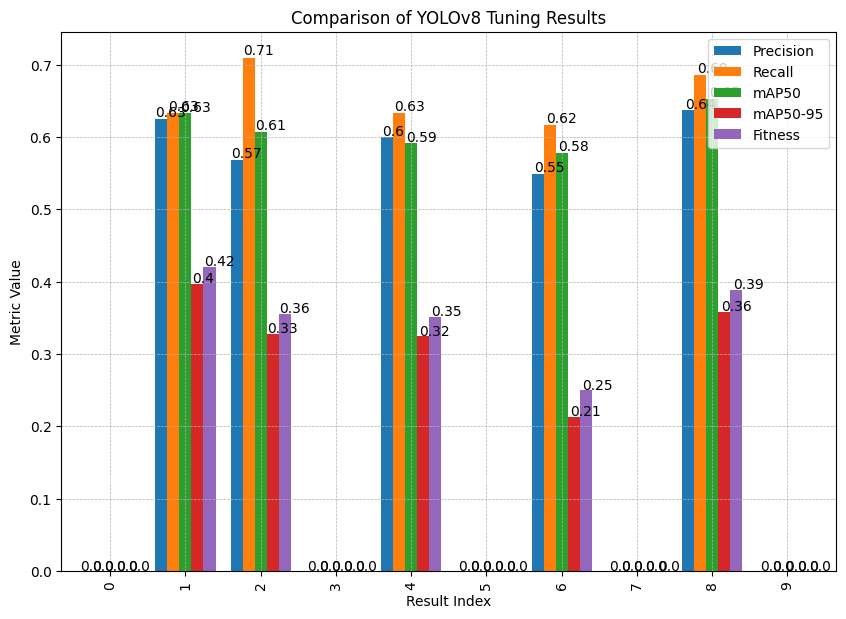

In [21]:
df_filled = df.fillna(0)  # Replace None with 0 for plotting
import matplotlib.pyplot as plt

# Plotting
ax = df_filled.plot(kind='bar', figsize=(10, 7), width=0.8)
ax.set_title('Comparison of YOLOv8 Tuning Results')
ax.set_xlabel('Result Index')
ax.set_ylabel('Metric Value')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper right')

# Adding value labels on top of each bar
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()
